In [2]:
import pandas as pd
import os
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
from pandas_summary import DataFrameSummary
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import graphviz 
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from pandas.util import hash_pandas_object
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from typing import Optional, List, Any
%matplotlib inline
from IPython.core.debugger import set_trace
from dateutil.parser import parse
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
import geopy.distance
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score


In [3]:
train_set_df_orig = pd.read_csv("port_visits_train.csv", parse_dates = ['start_time'], date_parser = parse )
train_vessels_labels_orig = pd.read_csv("vessels_labels_train.csv", index_col='vessel_id' )

In [4]:
train_set_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732484 entries, 0 to 732483
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ves_id        732484 non-null  object        
 1   start_time    732484 non-null  datetime64[ns]
 2   duration_min  732484 non-null  int64         
 3   port_id       732484 non-null  object        
 4   country       732171 non-null  object        
 5   Lat           732484 non-null  float64       
 6   Long          732484 non-null  float64       
 7   port_name     732444 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 44.7+ MB


**Add the labels and types**

In [5]:
train_set_df_orig['type'] = train_set_df_orig['ves_id'].apply(lambda vid : 
                                    train_vessels_labels_orig.loc[vid, 'type'])
train_set_df_orig['label'] = train_set_df_orig['ves_id'].apply(lambda vid : 
                                    train_vessels_labels_orig.loc[vid, 'label'])

In [6]:
train_set_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732484 entries, 0 to 732483
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ves_id        732484 non-null  object        
 1   start_time    732484 non-null  datetime64[ns]
 2   duration_min  732484 non-null  int64         
 3   port_id       732484 non-null  object        
 4   country       732171 non-null  object        
 5   Lat           732484 non-null  float64       
 6   Long          732484 non-null  float64       
 7   port_name     732444 non-null  object        
 8   type          732484 non-null  object        
 9   label         732484 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 55.9+ MB


# EDA

**The aim of this section is to establish a basic understanding of the data, and to identify candidate explanatory features for classification**

## Initial examination of the raw data ##

### Unique vessels ###

In [8]:
uniqe_ves_ids_train_orig = np.unique(train_set_df_orig.ves_id)
labels_vess_ids_intersect = set(uniqe_ves_ids_train_orig).intersection(train_vessels_labels_orig.index)
labels_vess_ids_diff = set(train_vessels_labels_orig.index ).difference(uniqe_ves_ids_train_orig)
print(f"There are {len(labels_vess_ids_intersect)} vess_ids appearing both in the train df and lables df")
print(f"There are {len(labels_vess_ids_diff)} vess_ids appearing in the lables df but not in the train df")

There are 21122 vess_ids appearing both in the train df and lables df
There are 520 vess_ids appearing in the lables df but not in the train df


### Unique ports ###

In [9]:
num_unique_ports_in_train = len(np.unique(train_set_df_orig.port_id.dropna()))
print(f"there are {num_unique_ports_in_train} unique ports in the train set")

there are 3590 unique ports in the train set


**The distribution of the labels is around 13.7% 1 (Tanker) and 86.3% 0 (not a tanker)**

Text(0.5, 1.0, 'percentage of tankers and non-tankers vessels')

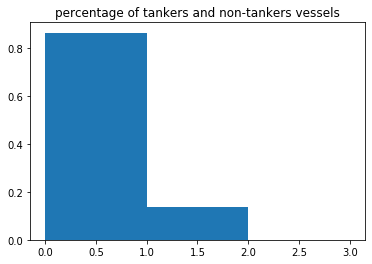

In [11]:
y_train_raw = train_vessels_labels_orig.label
counts = plt.hist(y_train_raw, bins =  [0,1,2,3], density=True )
plt.title("percentage of tankers and non-tankers vessels")

In [18]:
counts[0]/counts[0].sum()*100

array([86.22585713, 13.77414287,  0.        ])

### The subset of ports visited by tankers ###

In [87]:
tankers_ports_set = set(train_set_df_orig['port_id'][train_set_df_orig['label']==1])
print("There are {} ports visited by tankers, which are\
 {:0.2f}% of the overall ports".format(len(tankers_ports_set), len(tankers_ports_set)/num_unique_ports_in_train*100))

There are 1652 ports visited by tankers, which are 46.02% of the overall ports


In [88]:
all_ports_set = set(np.unique(train_set_df_orig.port_id.dropna()))
non_tanker_ports_set = set(train_set_df_orig['port_id'][train_set_df_orig['label']==0])
print("The intersection between the tankers ports and non-tanker ports is of size {} ".format(len(non_tanker_ports_set.intersection(tankers_ports_set))))

The intersection between the tankers ports and non-tanker ports is of size 1520 


**Initial conclusion: the ports set visited by vessels is a good candidate as an expalatory (separating) feature**

## Data cleaning ##

### What's to be cleaned? ###

**Let's examine vessel 56dd02bde4b02341a159b0ab, as an example**

In [70]:
grp_56dd02bde4b02341a159b0ab = train_set_df_orig.groupby('ves_id').get_group('56dd02bde4b02341a159b0ab').sort_values(by = ['start_time'])

**The following day indicates traveling between 4 different continents**

In [71]:
grp_56dd02bde4b02341a159b0ab[(grp_56dd02bde4b02341a159b0ab.start_time >= parse('04-11-2016')) & 
                             (grp_56dd02bde4b02341a159b0ab.start_time < parse('04-12-2016'))]

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,type,label
140872,56dd02bde4b02341a159b0ab,2016-04-11 00:37:15,0,5358fc78b68ca120a07dbac8,Japan,34.390,133.099,Itozaki,Oil Tanker,1
140880,56dd02bde4b02341a159b0ab,2016-04-11 04:08:06,16,5358fc78b68ca120a07dbc60,China,21.157,110.427,Zhanjiang,Oil Tanker,1
140889,56dd02bde4b02341a159b0ab,2016-04-11 08:41:04,0,5358fc78b68ca120a07dbcdf,Belgium,51.288,4.315,Antwerp,Oil Tanker,1
113196,56dd02bde4b02341a159b0ab,2016-04-11 08:56:05,118,5358fc78b68ca120a07dbc60,China,21.157,110.427,Zhanjiang,Oil Tanker,1
19381,56dd02bde4b02341a159b0ab,2016-04-11 21:08:55,0,54b63743a476915034d40a9f,Somalia,11.290,49.178,Bosaso,Oil Tanker,1


**The below day is even busyer...**

In [72]:
grp_56dd02bde4b02341a159b0ab[(grp_56dd02bde4b02341a159b0ab.start_time >= parse('29-04-2016')) & 
                             (grp_56dd02bde4b02341a159b0ab.start_time < parse('30-04-2016'))]

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,type,label
146746,56dd02bde4b02341a159b0ab,2016-04-29 08:23:45,0,559299555ad4c0206ee24305,Iran,29.681,48.810,Basrah Oil Terminal,Oil Tanker,1
146745,56dd02bde4b02341a159b0ab,2016-04-29 10:51:35,85,5358fc77b68ca120a07db2c4,Morocco,33.126,-8.628,Jorf Lasfar,Oil Tanker,1
146758,56dd02bde4b02341a159b0ab,2016-04-29 13:32:42,56,5358fc77b68ca120a07db0b6,Philippines,11.604,122.709,Culasi,Oil Tanker,1
146757,56dd02bde4b02341a159b0ab,2016-04-29 14:37:20,119,5358fc78b68ca120a07dba1e,Philippines,10.308,123.934,Cebu,Oil Tanker,1
146756,56dd02bde4b02341a159b0ab,2016-04-29 16:51:51,0,5358fc77b68ca120a07db0b6,Philippines,11.604,122.709,Culasi,Oil Tanker,1
146755,56dd02bde4b02341a159b0ab,2016-04-29 17:01:11,0,5358fc78b68ca120a07dbc60,China,21.157,110.427,Zhanjiang,Oil Tanker,1
159734,56dd02bde4b02341a159b0ab,2016-04-29 17:13:19,0,5358fc78b68ca120a07dba1e,Philippines,10.308,123.934,Cebu,Oil Tanker,1
146753,56dd02bde4b02341a159b0ab,2016-04-29 17:22:34,0,5358fc77b68ca120a07db2c4,Morocco,33.126,-8.628,Jorf Lasfar,Oil Tanker,1
492066,56dd02bde4b02341a159b0ab,2016-04-29 17:23:10,0,5358fc78b68ca120a07dbc60,China,21.157,110.427,Zhanjiang,Oil Tanker,1
59480,56dd02bde4b02341a159b0ab,2016-04-29 17:38:50,0,5358fc78b68ca120a07dba1e,Philippines,10.308,123.934,Cebu,Oil Tanker,1


**Many visits have 0 duration**

In [79]:
print("{} out of {} ({:0.2f}%) entries have 0 duration".format(
    (train_set_df_orig.duration_min == 0).sum(), len(train_set_df_orig), 100*(train_set_df_orig.duration_min == 0).sum()/len(train_set_df_orig)))

119565 out of 732484 (16.32%) entries have 0 duration


### Cleaning ###

**General idea:**
**remove visits of unfeasible travel duration w.r.t. to previous visits, and amend visits durations based on travel duration.**


In [128]:
#Based on https://www.marineinsight.com/guidelines/speed-of-a-ship-at-sea/
# https://en.wikipedia.org/wiki/Fishing_vessel#:~:text=The%20trolling%20line%20is%20towed,canoes%20with%20outriggers%20for%20stability.
# https://www.weeksmarine.com/equipment-division/tugboats
vess_velocities_kmph = {
    'Bulk Carrier': 15*1.852,
    'Container Vessel' : 24*1.852 , 
    'Fishing Vessel' : 11*1.852,
    'Oil Tanker': 17*1.852,
    'Passenger Vessel': 20*1.852, 
    'Reefer': 20*1.852, 
    'Tug':14*1.852
    
}

MIN_DIST_KM = 0.5

def calc_dist_km(lat_lng_1, lat_lng_2):
        return geopy.distance.geodesic(lat_lng_1, lat_lng_2).km

def calc_timediff_hours(prev_row_start_time, curr_row_start_time):
    delta = curr_row_start_time - prev_row_start_time
    return delta.days*24 + delta.seconds/3600
    
# Simplest approach - it's valid if the distance can be covered by the start times differences.
def is_valid_travel(prev_row, curr_row):
 
    if prev_row is None:
        return True, 1000000000000000 #Ideally, we won't give the first row this privilege 
    dist = calc_dist_km(prev_row[['Lat', 'Long']], curr_row[['Lat', 'Long']])
    #If we haven't moved at all - consider this as an invalid travel
    if dist <= MIN_DIST_KM:
        return False, -1
    airline_travel_duration_hours = dist/vess_velocities_kmph[curr_row['type']]
    start_times_diff_hours =  calc_timediff_hours(prev_row.start_time, curr_row.start_time )
    is_v = airline_travel_duration_hours <=  start_times_diff_hours
    max_bound = (start_times_diff_hours - airline_travel_duration_hours)*60
    return is_v, max_bound

       

def  amend_zero_durations(valid_rows: List[pd.DataFrame], idx: List[int]):
    cleaned_df = pd.DataFrame(valid_rows, index = idx)
    
    if cleaned_df['duration_min'].isnull().values.any():
        nan_entries_port_ids = set(cleaned_df['port_id'][cleaned_df['duration_min'].isnull()])
        means_per_port = {}
        grpd_by_port = cleaned_df.groupby('port_id')
        for port_id in nan_entries_port_ids:
            means_per_port[port_id] = np.nanmean(grpd_by_port.get_group(port_id).duration_min)
        for pid,pmean in means_per_port.items():
            cleaned_df.loc[(cleaned_df['port_id'] == pid) & (cleaned_df['duration_min'].isnull()),'duration_min'] = pmean
        #If we don't have the per-port - use the overall average.
        global_mean = np.nanmean(cleaned_df['duration_min'].values)
        cleaned_df.loc[cleaned_df['duration_min'].isnull(), 'duration_min'] = global_mean if not np.isnan(global_mean) else 0
    #TODO: if there's more time - use the mean over all vessels of the same type.
    return cleaned_df
        
def clean_ves_df(raw_ves_df: pd.DataFrame) -> pd.DataFrame:
    valid_rows = []
    idx = []
    prev_row = None
    #Filter out unfeasible travels
    for ind,r in raw_ves_df.sort_values(by = ['start_time']).iterrows():
     
        valid_travel, upper_duration_bound =  is_valid_travel(prev_row, r)
        if valid_travel:
            idx.append(ind)
            if len(valid_rows) > 0 :
                valid_rows[-1]['duration_min'] =  min(valid_rows[-1]['duration_min'], upper_duration_bound)
            if r['duration_min'] <= 0:
                r['duration_min'] = np.nan
            valid_rows.append(r)
            prev_row = r
        else:
            pass

    cleaned_df =  amend_zero_durations(valid_rows, idx)
    return cleaned_df

def clean_raw_port_visits(visits_df: pd.DataFrame) -> pd.DataFrame:
    cleaned_per_ves_lst = []
    for vid,ves_df in visits_df.groupby('ves_id'):
        cleaned_per_ves_lst.append(clean_ves_df(ves_df))
        print(f"finished vid {vid}")
    return pd.concat(cleaned_per_ves_lst)

In [ ]:
cleaned_raw_df = clean_raw_port_visits(train_set_df_orig)
# cleaned_raw_df.to_csv('training_cleaned.csv')
# cleaned_raw_df = pd.read_csv('training_cleaned.csv', index_col=0, parse_dates = ['start_time'], date_parser = parse)

C:\Users\Matan\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning:

Mean of empty slice



finished vid 56d83489e4b01c7098934f48
finished vid 56d83489e4b01c7098934f4f
finished vid 56d83489e4b01c7098934f50
finished vid 56d83489e4b01c7098934f51
finished vid 56d83489e4b025a920ad5e6e
finished vid 56d83489e4b02a0dec522faf
finished vid 56d83489e4b02c65b7730d72
finished vid 56d83489e4b02c65b7730d76
finished vid 56d83489e4b02c65b7730d77
finished vid 56d83489e4b0581dc93c9211
finished vid 56d83489e4b0ad1bfa26097a
finished vid 56d83489e4b0ad1bfa26097e
finished vid 56d83489e4b0c8d95c300907
finished vid 56d83489e4b0d51bec82d97b
finished vid 56d83489e4b0d51bec82d981
finished vid 56d83489e4b0e0f437f37e83
finished vid 56d83489e4b0e0f437f37e87
finished vid 56d8348ae4b00146513f8f01
finished vid 56d8348ae4b00146513f8f05
finished vid 56d8348ae4b00146513f8f07
finished vid 56d8348ae4b002eabab57e9e
finished vid 56d8348ae4b002eabab57ea1
finished vid 56d8348ae4b002eabab57ea3
finished vid 56d8348ae4b002eabab57ea9
finished vid 56d8348ae4b002eabab57eaf
finished vid 56d8348ae4b002eabab57eb0
finished vid

finished vid 56d8348be4b01c7098934f9d
finished vid 56d8348be4b01c7098934fa3
finished vid 56d8348be4b01ce41c246665
finished vid 56d8348be4b01ce41c246669
finished vid 56d8348be4b01ce41c24666e
finished vid 56d8348be4b01ce41c246671
finished vid 56d8348be4b01ce41c24667a
finished vid 56d8348be4b02098f6e2d2e6
finished vid 56d8348be4b02098f6e2d2f5
finished vid 56d8348be4b025a920ad5e92
finished vid 56d8348be4b025a920ad5e93
finished vid 56d8348be4b025a920ad5e95
finished vid 56d8348be4b025a920ad5e98
finished vid 56d8348be4b025a920ad5e9b
finished vid 56d8348be4b025a920ad5e9d
finished vid 56d8348be4b025a920ad5ea5
finished vid 56d8348be4b026569c5ac8a2
finished vid 56d8348be4b026569c5ac8a4
finished vid 56d8348be4b026569c5ac8a6
finished vid 56d8348be4b026569c5ac8b6
finished vid 56d8348be4b026569c5ac8bc
finished vid 56d8348be4b026569c5ac8be
finished vid 56d8348be4b0271c9aa37072
finished vid 56d8348be4b0271c9aa37073
finished vid 56d8348be4b0271c9aa3707b
finished vid 56d8348be4b0271c9aa37081
finished vid

C:\Users\Matan\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning:

Mean of empty slice



finished vid 56d8348be4b02a0dec522ff8
finished vid 56d8348be4b02a0dec522ffb
finished vid 56d8348be4b02a0dec522ffc
finished vid 56d8348be4b02a0dec523003
finished vid 56d8348be4b02c65b7730da4
finished vid 56d8348be4b02c65b7730da5
finished vid 56d8348be4b02c65b7730da6
finished vid 56d8348be4b02c65b7730dab
finished vid 56d8348be4b02c65b7730db4
finished vid 56d8348be4b02c65b7730db8
finished vid 56d8348be4b02c65b7730db9
finished vid 56d8348be4b0365aa1132cd0
finished vid 56d8348be4b0365aa1132cd1
finished vid 56d8348be4b0365aa1132cd7
finished vid 56d8348be4b0365aa1132cd9
finished vid 56d8348be4b0365aa1132cda
finished vid 56d8348be4b0365aa1132ce6
finished vid 56d8348be4b0365aa1132cec
finished vid 56d8348be4b0365aa1132cf9
finished vid 56d8348be4b0365aa1132cfc
finished vid 56d8348be4b0365aa1132d01
finished vid 56d8348be4b0365aa1132d02
finished vid 56d8348be4b0365aa1132d06
finished vid 56d8348be4b0426087e0eb5f
finished vid 56d8348be4b0426087e0eb63
finished vid 56d8348be4b0426087e0eb65
finished vid

finished vid 56d8348ce4b01b88a1e19b51
finished vid 56d8348ce4b01c7098934fb2
finished vid 56d8348ce4b01c7098934fb3
finished vid 56d8348ce4b01c7098934fb6
finished vid 56d8348ce4b01c7098934fb7
finished vid 56d8348ce4b01c7098934fc4
finished vid 56d8348ce4b01c7098934fc9
finished vid 56d8348ce4b01c7098934fca
finished vid 56d8348ce4b01ce41c246683
finished vid 56d8348ce4b01ce41c246685
finished vid 56d8348ce4b01ce41c246695
finished vid 56d8348ce4b01ce41c246696
finished vid 56d8348ce4b01ce41c246699
finished vid 56d8348ce4b01ce41c24669d
finished vid 56d8348ce4b01ce41c2466a4
finished vid 56d8348ce4b01ce41c2466a5
finished vid 56d8348ce4b02098f6e2d2fd
finished vid 56d8348ce4b02098f6e2d305
finished vid 56d8348ce4b02098f6e2d30d
finished vid 56d8348ce4b02098f6e2d30e
finished vid 56d8348ce4b02098f6e2d312
finished vid 56d8348ce4b025a920ad5eb2
finished vid 56d8348ce4b025a920ad5ebe
finished vid 56d8348ce4b025a920ad5ec2
finished vid 56d8348ce4b025a920ad5ed9
finished vid 56d8348ce4b025a920ad5edc
finished vid

finished vid 56d8348ce4b0e80e4c3be5b4
finished vid 56d8348ce4b0e80e4c3be5b5
finished vid 56d8348ce4b0e80e4c3be5b8
finished vid 56d8348ce4b0e80e4c3be5c2
finished vid 56d8348ce4b0e80e4c3be5c4
finished vid 56d8348ce4b0e80e4c3be5c7
finished vid 56d8348ce4b0e80e4c3be5d8
finished vid 56d8348ce4b0e80e4c3be5db
finished vid 56d8348ce4b0e85416b970b1
finished vid 56d8348ce4b0e85416b970b3
finished vid 56d8348ce4b0e85416b970b5
finished vid 56d8348ce4b0e85416b970b8
finished vid 56d8348ce4b0e85416b970bd
finished vid 56d8348ce4b0e85416b970c7
finished vid 56d8348ce4b0fd8aa7f86238
finished vid 56d8348ce4b0fd8aa7f8623c
finished vid 56d8348ce4b0fd8aa7f86245
finished vid 56d8348ce4b0fd8aa7f86246
finished vid 56d8348ce4b0fd8aa7f8624b
finished vid 56d8348ce4b0fd8aa7f86252
finished vid 56d8348ce4b0fe4de2247329
finished vid 56d8348ce4b0fea4c4b0320b
finished vid 56d8348ce4b0fea4c4b03215
finished vid 56d8348ce4b0fea4c4b03218
finished vid 56d8348ce4b0fea4c4b0321e
finished vid 56d8348ce4b0fea4c4b03227
finished vid

finished vid 56d8348de4b09ee652001269
finished vid 56d8348de4b09ee65200126f
finished vid 56d8348de4b09ee652001271
finished vid 56d8348de4b09f39bec68132
finished vid 56d8348de4b09f39bec68135
finished vid 56d8348de4b09f39bec68137
finished vid 56d8348de4b09f39bec68138
finished vid 56d8348de4b0a0bfc44b97bd
finished vid 56d8348de4b0a0bfc44b97c2
finished vid 56d8348de4b0a0bfc44b97c5
finished vid 56d8348de4b0a0bfc44b97c9
finished vid 56d8348de4b0a0bfc44b97cb
finished vid 56d8348de4b0a0bfc44b97cc
finished vid 56d8348de4b0a0bfc44b97cd
finished vid 56d8348de4b0a320bed3b0d8
finished vid 56d8348de4b0a320bed3b0db
finished vid 56d8348de4b0a320bed3b0de
finished vid 56d8348de4b0a320bed3b0e3
finished vid 56d8348de4b0ad1bfa2609f6
finished vid 56d8348de4b0ad1bfa2609f7
finished vid 56d8348de4b0ad1bfa2609fa
finished vid 56d8348de4b0ad1bfa260a05
finished vid 56d8348de4b0ad1bfa260a06
finished vid 56d8348de4b0ad1bfa260a14
finished vid 56d8348de4b0ad1bfa260a29
finished vid 56d8348de4b0ad1bfa260a2a
finished vid

finished vid 56d8348ee4b02a0dec523050
finished vid 56d8348ee4b02a0dec523058
finished vid 56d8348ee4b02a0dec52305e
finished vid 56d8348ee4b02a0dec523060
finished vid 56d8348ee4b02a0dec523062
finished vid 56d8348ee4b02a0dec523067
finished vid 56d8348ee4b02a0dec52306b
finished vid 56d8348ee4b02c65b7730e18
finished vid 56d8348ee4b02c65b7730e1f
finished vid 56d8348ee4b02c65b7730e22
finished vid 56d8348ee4b02c65b7730e27
finished vid 56d8348ee4b02c65b7730e2c
finished vid 56d8348ee4b02c65b7730e3d
finished vid 56d8348ee4b0365aa1132d69
finished vid 56d8348ee4b0365aa1132d72
finished vid 56d8348ee4b0365aa1132d73
finished vid 56d8348ee4b0365aa1132d7b
finished vid 56d8348ee4b0426087e0ebd9
finished vid 56d8348ee4b0426087e0ebe6
finished vid 56d8348ee4b0426087e0ebf8
finished vid 56d8348ee4b0426087e0ebfa
finished vid 56d8348ee4b0426087e0ec0b
finished vid 56d8348ee4b0426087e0ec10
finished vid 56d8348ee4b0426087e0ec1a
finished vid 56d8348ee4b0426087e0ec1d
finished vid 56d8348ee4b0426087e0ec20
finished vid

finished vid 56d8348ee4b0fe4de2247357
finished vid 56d8348ee4b0fe4de224735b
finished vid 56d8348ee4b0fea4c4b0324e
finished vid 56d8348ee4b0fea4c4b0324f
finished vid 56d8348ee4b0fea4c4b03257
finished vid 56d8348ee4b0fea4c4b03259
finished vid 56d8348ee4b0fea4c4b0325b
finished vid 56d8348ee4b0fea4c4b0325c
finished vid 56d8348ee4b0fea4c4b0325e
finished vid 56d8348ee4b0fea4c4b03268
finished vid 56d8348ee4b0fea4c4b03269
finished vid 56d8348ee4b0fea4c4b0326b
finished vid 56d8348ee4b0fea4c4b03272
finished vid 56d8348ee4b0fea4c4b03274
finished vid 56d8348ee4b0fea4c4b0327b
finished vid 56d8348ee4b0fea4c4b03281
finished vid 56d8348fe4b00146513f8fef
finished vid 56d8348fe4b00146513f8ff3
finished vid 56d8348fe4b00146513f8ff4
finished vid 56d8348fe4b00146513f9006
finished vid 56d8348fe4b00146513f9007
finished vid 56d8348fe4b00146513f9009
finished vid 56d8348fe4b00146513f900d
finished vid 56d8348fe4b00146513f9010
finished vid 56d8348fe4b001f429342a1f
finished vid 56d8348fe4b001f429342a20
finished vid

finished vid 56d8348fe4b09ee652001286
finished vid 56d8348fe4b09ee652001287
finished vid 56d8348fe4b09ee65200128b
finished vid 56d8348fe4b09f39bec68147
finished vid 56d8348fe4b09f39bec6814a
finished vid 56d8348fe4b09f39bec6814d
finished vid 56d8348fe4b0a0bfc44b97f8
finished vid 56d8348fe4b0a320bed3b102
finished vid 56d8348fe4b0a320bed3b105
finished vid 56d8348fe4b0ad1bfa260a4d
finished vid 56d8348fe4b0ad1bfa260a53
finished vid 56d8348fe4b0ad1bfa260a59
finished vid 56d8348fe4b0ad1bfa260a5d
finished vid 56d8348fe4b0ad1bfa260a65
finished vid 56d8348fe4b0ad1bfa260a70
finished vid 56d8348fe4b0ad1bfa260a75
finished vid 56d8348fe4b0ad1bfa260a87
finished vid 56d8348fe4b0ad1bfa260a88
finished vid 56d8348fe4b0ad1bfa260a8a
finished vid 56d8348fe4b0ad1bfa260a94
finished vid 56d8348fe4b0ad1bfa260a95
finished vid 56d8348fe4b0ad1bfa260aa0
finished vid 56d8348fe4b0b1c94f7bde97
finished vid 56d8348fe4b0b1c94f7bde98
finished vid 56d8348fe4b0b1c94f7bde9d
finished vid 56d8348fe4b0b2a61c63a92d
finished vid

finished vid 56d83490e4b025a920ad5f94
finished vid 56d83490e4b025a920ad5f98
finished vid 56d83490e4b025a920ad5f9a
finished vid 56d83490e4b025a920ad5fa2
finished vid 56d83490e4b025a920ad5fa4
finished vid 56d83490e4b025a920ad5fac
finished vid 56d83490e4b025a920ad5fb9
finished vid 56d83490e4b025a920ad5fbb
finished vid 56d83490e4b025a920ad5fbe
finished vid 56d83490e4b025a920ad5fc2
finished vid 56d83490e4b025a920ad5fc9
finished vid 56d83490e4b025a920ad5fcb
finished vid 56d83490e4b025a920ad5fd0
finished vid 56d83490e4b025a920ad5fd3
finished vid 56d83490e4b025a920ad5fd4
finished vid 56d83490e4b026569c5ac954
finished vid 56d83490e4b026569c5ac957
finished vid 56d83490e4b026569c5ac959
finished vid 56d83490e4b026569c5ac95a
finished vid 56d83490e4b026569c5ac95c
finished vid 56d83490e4b0271c9aa37128
finished vid 56d83490e4b0271c9aa3712b
finished vid 56d83490e4b0271c9aa3713c
finished vid 56d83490e4b0271c9aa37143
finished vid 56d83490e4b0271c9aa37148
finished vid 56d83490e4b0271c9aa3714b
finished vid

finished vid 56d83490e4b0d75a97d9ab34
finished vid 56d83490e4b0dd79418009f7
finished vid 56d83490e4b0dd7941800a00
finished vid 56d83490e4b0dd7941800a03
finished vid 56d83490e4b0dd7941800a08
finished vid 56d83490e4b0dd7941800a0e
finished vid 56d83490e4b0dd7941800a12
finished vid 56d83490e4b0dd7941800a18
finished vid 56d83490e4b0dd7941800a19
finished vid 56d83490e4b0dd7941800a1a
finished vid 56d83490e4b0dd7941800a1b
finished vid 56d83490e4b0dd7941800a24
finished vid 56d83490e4b0dd7941800a25
finished vid 56d83490e4b0dd7941800a28
finished vid 56d83490e4b0dd7941800a2c
finished vid 56d83490e4b0dd7941800a34
finished vid 56d83490e4b0dd7941800a39
finished vid 56d83490e4b0dd7941800a3f
finished vid 56d83490e4b0de6e5887adec
finished vid 56d83490e4b0e0f437f37f4a
finished vid 56d83490e4b0e0f437f37f4c
finished vid 56d83490e4b0e0f437f37f4f
finished vid 56d83490e4b0e0f437f37f55
finished vid 56d83490e4b0e0f437f37f5c
finished vid 56d83490e4b0e0f437f37f5d
finished vid 56d83490e4b0e0f437f37f67
finished vid

finished vid 56d83491e4b05d1780ce8d9c
finished vid 56d83491e4b05d1780ce8d9e
finished vid 56d83491e4b05d1780ce8da0
finished vid 56d83491e4b05d1780ce8da1
finished vid 56d83491e4b05d1780ce8da3
finished vid 56d83491e4b05d1780ce8db0
finished vid 56d83491e4b07096ffb1f163
finished vid 56d83491e4b07096ffb1f164
finished vid 56d83491e4b07096ffb1f170
finished vid 56d83491e4b07096ffb1f172
finished vid 56d83491e4b07096ffb1f173
finished vid 56d83491e4b076ffee46aa46
finished vid 56d83491e4b076ffee46aa4e
finished vid 56d83491e4b076ffee46aa58
finished vid 56d83491e4b076ffee46aa5a
finished vid 56d83491e4b076ffee46aa5f
finished vid 56d83491e4b076ffee46aa67
finished vid 56d83491e4b076ffee46aa69
finished vid 56d83491e4b076ffee46aa6d
finished vid 56d83491e4b076ffee46aa71
finished vid 56d83491e4b076ffee46aa75
finished vid 56d83491e4b088a576966e28
finished vid 56d83491e4b088a576966e29
finished vid 56d83491e4b088a576966e2a
finished vid 56d83491e4b088a576966e2f
finished vid 56d83491e4b088a576966e30
finished vid

finished vid 56d83492e4b0191ec59e8111
finished vid 56d83492e4b0191ec59e8114
finished vid 56d83492e4b0191ec59e8122
finished vid 56d83492e4b0191ec59e812c
finished vid 56d83492e4b0191ec59e8135
finished vid 56d83492e4b0191ec59e8139
finished vid 56d83492e4b01b88a1e19bef
finished vid 56d83492e4b01b88a1e19bf0
finished vid 56d83492e4b01b88a1e19bf4
finished vid 56d83492e4b01b88a1e19bf7
finished vid 56d83492e4b01b88a1e19bf9
finished vid 56d83492e4b01ce41c24679d
finished vid 56d83492e4b01ce41c24679e
finished vid 56d83492e4b01ce41c2467a1
finished vid 56d83492e4b01ce41c2467a3
finished vid 56d83492e4b01ce41c2467a4
finished vid 56d83492e4b01ce41c2467aa
finished vid 56d83492e4b01ce41c2467ac
finished vid 56d83492e4b01ce41c2467b0
finished vid 56d83492e4b01ce41c2467b4
finished vid 56d83492e4b01ce41c2467b5
finished vid 56d83492e4b01ce41c2467ba
finished vid 56d83492e4b02098f6e2d3d3
finished vid 56d83492e4b02098f6e2d3d5
finished vid 56d83492e4b02098f6e2d3db
finished vid 56d83492e4b02098f6e2d3df
finished vid

finished vid 56d83492e4b0e178dda671ed
finished vid 56d83492e4b0e178dda671ee
finished vid 56d83492e4b0e178dda671fe
finished vid 56d83492e4b0e178dda67200
finished vid 56d83492e4b0e47eba0a87c2
finished vid 56d83492e4b0e47eba0a87cc
finished vid 56d83492e4b0e80e4c3be6c2
finished vid 56d83492e4b0e80e4c3be6c6
finished vid 56d83492e4b0e80e4c3be6c9
finished vid 56d83492e4b0e80e4c3be6cd
finished vid 56d83492e4b0e80e4c3be6d1
finished vid 56d83492e4b0e80e4c3be6d6
finished vid 56d83492e4b0e85416b971bc
finished vid 56d83492e4b0e85416b971bd
finished vid 56d83492e4b0e85416b971c6
finished vid 56d83492e4b0e85416b971d4
finished vid 56d83492e4b0e85416b971d6
finished vid 56d83492e4b0e85416b971d9
finished vid 56d83492e4b0e85416b971dc
finished vid 56d83492e4b0eadad2347996
finished vid 56d83492e4b0fd8aa7f862db
finished vid 56d83492e4b0fd8aa7f862e1
finished vid 56d83492e4b0fd8aa7f862fe
finished vid 56d83492e4b0fe4de224739c
finished vid 56d83492e4b0fe4de224739e
finished vid 56d83492e4b0fe4de22473a7
finished vid

finished vid 56d83493e4b0fd8aa7f86304
finished vid 56d83493e4b0fd8aa7f8630e
finished vid 56d83493e4b0fe4de22473b8
finished vid 56d83493e4b0fe4de22473b9
finished vid 56d83493e4b0fe4de22473bd
finished vid 56d83493e4b0fe4de22473be
finished vid 56d83493e4b0fe4de22473c8
finished vid 56d83493e4b0fe4de22473cc
finished vid 56d83494e4b001f429342ae7
finished vid 56d83494e4b001f429342ae9
finished vid 56d83494e4b001f429342aea
finished vid 56d83494e4b001f429342af0
finished vid 56d83494e4b001f429342af6
finished vid 56d83494e4b001f429342af7
finished vid 56d83494e4b001f429342af8
finished vid 56d83494e4b001f429342af9
finished vid 56d83494e4b001f429342afe
finished vid 56d83494e4b001f429342b07
finished vid 56d83494e4b001f429342b10
finished vid 56d83494e4b001f429342b19
finished vid 56d83494e4b001f429342b1f
finished vid 56d83494e4b001f429342b24
finished vid 56d83494e4b001f429342b2b
finished vid 56d83494e4b00da0b000f6bc
finished vid 56d83494e4b00da0b000f6ca
finished vid 56d83494e4b00da0b000f6cd
finished vid

finished vid 56d83495e4b08ed15aa163a2
finished vid 56d83495e4b08ed15aa163ae
finished vid 56d83495e4b08ed15aa163b0
finished vid 56d83495e4b08ed15aa163b3
finished vid 56d83495e4b08ed15aa163c5
finished vid 56d83495e4b08ed15aa163c7
finished vid 56d83495e4b08ed15aa163c8
finished vid 56d83495e4b09ee652001340
finished vid 56d83495e4b09ee652001349
finished vid 56d83495e4b09ee65200134b
finished vid 56d83495e4b09ee65200134c
finished vid 56d83495e4b09ee652001350
finished vid 56d83495e4b09ee652001353
finished vid 56d83495e4b09ee652001358
finished vid 56d83495e4b09ee65200135b
finished vid 56d83495e4b09ee652001367
finished vid 56d83495e4b09ee65200136f
finished vid 56d83495e4b09f39bec68199
finished vid 56d83495e4b09f39bec681a2
finished vid 56d83495e4b0a0bfc44b9896
finished vid 56d83495e4b0a0bfc44b9897
finished vid 56d83495e4b0a0bfc44b9899
finished vid 56d83495e4b0a0bfc44b98a5
finished vid 56d83495e4b0a0bfc44b98a8
finished vid 56d83495e4b0a0bfc44b98b3
finished vid 56d83495e4b0a0bfc44b98b4
finished vid

finished vid 56d83497e4b08ed15aa163f3
finished vid 56d83497e4b08ed15aa163fc
finished vid 56d83497e4b08ed15aa16400
finished vid 56d83497e4b08ed15aa16404
finished vid 56d83497e4b08ed15aa1640a
finished vid 56d83497e4b08ed15aa1640b
finished vid 56d83497e4b08ed15aa16418
finished vid 56d83497e4b08ed15aa16419
finished vid 56d83497e4b08ed15aa16420
finished vid 56d83497e4b08ed15aa16426
finished vid 56d83497e4b09ee6520013ba
finished vid 56d83497e4b09ee6520013bb
finished vid 56d83497e4b09ee6520013c2
finished vid 56d83497e4b09f39bec681b2
finished vid 56d83497e4b09f39bec681bb
finished vid 56d83497e4b09f39bec681bd
finished vid 56d83497e4b09f39bec681c2
finished vid 56d83497e4b0a320bed3b1aa
finished vid 56d83497e4b0a320bed3b1b9
finished vid 56d83497e4b0a320bed3b1bd
finished vid 56d83497e4b0a320bed3b1c1
finished vid 56d83497e4b0a320bed3b1c6
finished vid 56d83497e4b0a320bed3b1c9
finished vid 56d83497e4b0a320bed3b1d4
finished vid 56d83497e4b0a320bed3b1d6
finished vid 56d83497e4b0a320bed3b1d9
finished vid

finished vid 56d835abe4b0051476b2927a
finished vid 56d835abe4b0082da0310886
finished vid 56d835abe4b008b1c25c4a03
finished vid 56d835abe4b008f3c69311bc
finished vid 56d835abe4b008f3c69311bd
finished vid 56d835abe4b00da0b000f846
finished vid 56d835abe4b013a6a061fc21
finished vid 56d835abe4b013b962386c00
finished vid 56d835abe4b018c4bd85a3dc
finished vid 56d835abe4b0191ec59e8250
finished vid 56d835abe4b0198613d0a49e
finished vid 56d835abe4b0198613d0a4a0
finished vid 56d835abe4b0198613d0a4a1
finished vid 56d835abe4b01b88a1e19dcb
finished vid 56d835abe4b01b88a1e19dce
finished vid 56d835abe4b01ec304d3dd5c
finished vid 56d835abe4b0271c9aa372e7
finished vid 56d835abe4b0344ec5de74a0
finished vid 56d835abe4b04690e5e69849
finished vid 56d835abe4b04690e5e6984a
finished vid 56d835abe4b04690e5e69851
finished vid 56d835abe4b05b8c70fda370
finished vid 56d835abe4b060dc89f27f4e
finished vid 56d835abe4b07096ffb1f2c2
finished vid 56d835abe4b076ffee46ac81
finished vid 56d835abe4b07c0bd1e40e08
finished vid

finished vid 56d835ade4b0b90a07511c90
finished vid 56d835ade4b0b90a07511c96
finished vid 56d835ade4b0c1bb3e2f70e9
finished vid 56d835ade4b0c1caecc87652
finished vid 56d835ade4b0c1caecc87654
finished vid 56d835ade4b0c1caecc8765c
finished vid 56d835ade4b0c239f219caaf
finished vid 56d835ade4b0c50cbbdeae46
finished vid 56d835ade4b0d38e4536ee07
finished vid 56d835ade4b0d51bec82dc10
finished vid 56d835ade4b0d6a7a82cc41a
finished vid 56d835ade4b0d75a97d9acf7
finished vid 56d835ade4b0d8941fe95997
finished vid 56d835ade4b0d8941fe95999
finished vid 56d835ade4b0d9e33ced590d
finished vid 56d835ade4b0d9e33ced5919
finished vid 56d835ade4b0de6e5887b05f
finished vid 56d835ade4b0e0f437f38107
finished vid 56d835ade4b0e178dda672f9
finished vid 56d835ade4b0e207d627f3c4
finished vid 56d835ade4b0e207d627f3cc
finished vid 56d835ade4b0e207d627f3d3
finished vid 56d835ade4b0e80e4c3be7f7
finished vid 56d835ade4b0e80e4c3be7fa
finished vid 56d835ade4b0e85416b972f8
finished vid 56d835ade4b0ecd62e846cf8
finished vid

finished vid 56d835afe4b098a28bab8dcf
finished vid 56d835afe4b098a28bab8dde
finished vid 56d835afe4b098a28bab8de8
finished vid 56d835afe4b09b379252ab41
finished vid 56d835afe4b09b379252ab45
finished vid 56d835afe4b09b379252ab49
finished vid 56d835afe4b09e7587feca94
finished vid 56d835afe4b09ee652001535
finished vid 56d835afe4b09f39bec6841e
finished vid 56d835afe4b09f39bec6841f
finished vid 56d835afe4b09f39bec6842a
finished vid 56d835afe4b0a0bfc44b9a3a
finished vid 56d835afe4b0a1804a32f9c9
finished vid 56d835afe4b0a320bed3b35e
finished vid 56d835afe4b0a320bed3b35f
finished vid 56d835afe4b0a320bed3b36b
finished vid 56d835afe4b0a320bed3b374
finished vid 56d835afe4b0a3ee33e57008
finished vid 56d835afe4b0a5d5ab19b825
finished vid 56d835afe4b0a6fedb004fbb
finished vid 56d835afe4b0a6fedb004fbf
finished vid 56d835afe4b0a843fd720f46
finished vid 56d835afe4b0a843fd720f56
finished vid 56d835afe4b0ab7093265e32
finished vid 56d835afe4b0ad1bfa260c02
finished vid 56d835afe4b0ad1bfa260c0d
finished vid

finished vid 56d8367ae4b0b5c9786346a5
finished vid 56d8367ae4b0ba9a5eab18be
finished vid 56d8367ae4b0ba9a5eab18bf
finished vid 56d8367ae4b0c239f219cadc
finished vid 56d8367ae4b0c363b5cdefa6
finished vid 56d8367ae4b0c363b5cdefb0
finished vid 56d8367ae4b0c5e7bb970a20
finished vid 56d8367ae4b0c5fd0bebef6f
finished vid 56d8367ae4b0c8d95c300b88
finished vid 56d8367ae4b0d38e4536ee6b
finished vid 56d8367ae4b0d38e4536ee6c
finished vid 56d8367ae4b0d38e4536ee73
finished vid 56d8367ae4b0d468a7054976
finished vid 56d8367ae4b0d51bec82dc8b
finished vid 56d8367ae4b0d6a7a82cc464
finished vid 56d8367ae4b0d8941fe959d0
finished vid 56d8367ae4b0dd4c0226ccb4
finished vid 56d8367ae4b0dd4c0226ccb8
finished vid 56d8367ae4b0dd65c48b6aff
finished vid 56d8367ae4b0de6e5887b0b1
finished vid 56d8367ae4b0de6e5887b0b2
finished vid 56d8367ae4b0de6e5887b0b6
finished vid 56d8367ae4b0e0f437f38169
finished vid 56d8367ae4b0e207d627f405
finished vid 56d8367ae4b0e207d627f407
finished vid 56d8367ae4b0e47eba0a899d
finished vid

finished vid 56d8367ce4b0a5d5ab19b878
finished vid 56d8367ce4b0a6fedb004ff7
finished vid 56d8367ce4b0ab7093265e6b
finished vid 56d8367ce4b0b1c94f7be126
finished vid 56d8367ce4b0c1bb3e2f7164
finished vid 56d8367ce4b0c1bb3e2f7165
finished vid 56d8367ce4b0c239f219caf5
finished vid 56d8367ce4b0c239f219caf6
finished vid 56d8367ce4b0c239f219caf7
finished vid 56d8367ce4b0c363b5cdefc1
finished vid 56d8367ce4b0c363b5cdefc3
finished vid 56d8367ce4b0c69889b19206
finished vid 56d8367ce4b0c8d95c300b9f
finished vid 56d8367ce4b0c8d95c300ba9
finished vid 56d8367ce4b0d51bec82dcb2
finished vid 56d8367ce4b0d75a97d9ad63
finished vid 56d8367ce4b0d9e33ced597f
finished vid 56d8367ce4b0dd4c0226cccd
finished vid 56d8367ce4b0dd65c48b6b08
finished vid 56d8367ce4b0dd7941800bcd
finished vid 56d8367ce4b0de6e5887b0d2
finished vid 56d8367ce4b0dfe443cd1c9e
finished vid 56d8367ce4b0e0e2981bf1b0
finished vid 56d8367ce4b0e0e2981bf1b1
finished vid 56d8367ce4b0e0f437f38175
finished vid 56d8367ce4b0e0f437f3817b
finished vid

finished vid 56d83772e4b0469a5cc42ef2
finished vid 56d83772e4b04b350fcdf251
finished vid 56d83772e4b04eb0dbddacdb
finished vid 56d83772e4b0550004876e8c
finished vid 56d83772e4b0581dc93c9546
finished vid 56d83772e4b0581dc93c9548
finished vid 56d83772e4b058bc0872b383
finished vid 56d83772e4b05d1780ce8fe8
finished vid 56d83772e4b05d643818b960
finished vid 56d83772e4b05d643818b963
finished vid 56d83772e4b05d643818b966
finished vid 56d83772e4b060dc89f27ff3
finished vid 56d83772e4b0646786326193
finished vid 56d83772e4b064678632619f
finished vid 56d83772e4b06601c5c57c4b
finished vid 56d83772e4b07096ffb1f338
finished vid 56d83772e4b071261a9d0b96
finished vid 56d83772e4b071261a9d0b9d
finished vid 56d83772e4b076ffee46ad0c
finished vid 56d83772e4b0790d634edd8d
finished vid 56d83772e4b088a5769670ae
finished vid 56d83772e4b08ed15aa165e7
finished vid 56d83772e4b08fc0e2176c96
finished vid 56d83772e4b09d52056e9a8b
finished vid 56d83772e4b09f39bec684b9
finished vid 56d83772e4b09f39bec684c2
finished vid

finished vid 56d83774e4b0d65048c64e9c
finished vid 56d83774e4b0d6a7a82cc4db
finished vid 56d83774e4b0d9e33ced59c5
finished vid 56d83774e4b0dfe443cd1cd2
finished vid 56d83774e4b0e47eba0a89f2
finished vid 56d83774e4b0e7b60f9df4e7
finished vid 56d83774e4b0e7b60f9df4ea
finished vid 56d83774e4b0e7b60f9df4f0
finished vid 56d83774e4b0eadad2347ca6
finished vid 56d83774e4b0ee70f41bf032
finished vid 56d83774e4b0fc779ce99ba1
finished vid 56d83774e4b0fc779ce99ba6
finished vid 56d83774e4b0fd8aa7f86505
finished vid 56d83774e4b0fea4c4b034ca
finished vid 56d83774e4b0ff9ce9164f98
finished vid 56d83775e4b01ce41c246944
finished vid 56d83775e4b02110cb183c19
finished vid 56d83775e4b09e7587fecafc
finished vid 56d83775e4b0b1c94f7be187
finished vid 56d83775e4b0b2a61c63abba
finished vid 56d83775e4b0d75a97d9adc3
finished vid 56d837d7e4b012c40094123a
finished vid 56d837d7e4b05b8c70fda45b
finished vid 56d837d8e4b0426087e0ee55
finished vid 56d8388fe4b001f429342d35
finished vid 56d8388fe4b002eabab581ed
finished vid

finished vid 56d83892e4b0469a5cc42f25
finished vid 56d83892e4b05200a64f3b6c
finished vid 56d83892e4b0581dc93c9585
finished vid 56d83892e4b05b8c70fda491
finished vid 56d83892e4b05d643818b9ad
finished vid 56d83892e4b064423ed934ca
finished vid 56d83892e4b064423ed934d0
finished vid 56d83892e4b088a5769670e9
finished vid 56d83892e4b08ae8915ac371
finished vid 56d83892e4b08fc0e2176cd3
finished vid 56d83892e4b091321c0a83bc
finished vid 56d83892e4b098a28bab8eb3
finished vid 56d83892e4b09b379252ac18
finished vid 56d83892e4b09b379252ac1b
finished vid 56d83892e4b09b379252ac21
finished vid 56d83892e4b09ee652001622
finished vid 56d83892e4b09fa4bf9e977e
finished vid 56d83892e4b09fa4bf9e977f
finished vid 56d83892e4b0a1804a32fa80
finished vid 56d83892e4b0a320bed3b433
finished vid 56d83892e4b0a3ee33e570b3
finished vid 56d83892e4b0a5d5ab19b8f4
finished vid 56d83892e4b0ad1bfa260cdd
finished vid 56d83892e4b0b1090ebf1603
finished vid 56d83892e4b0b28ed5cb4976
finished vid 56d83892e4b0b8e21409dc6c
finished vid

finished vid 56d839eee4b0344ec5de75df
finished vid 56d839eee4b0365aa11330a1
finished vid 56d839eee4b03ff86c5e8e90
finished vid 56d839eee4b03ff86c5e8e93
finished vid 56d839eee4b04d93791a8d02
finished vid 56d839eee4b04d93791a8d07
finished vid 56d839eee4b04eb0dbddad3e
finished vid 56d839eee4b06601c5c57cc2
finished vid 56d839eee4b07096ffb1f3a8
finished vid 56d839eee4b07096ffb1f3af
finished vid 56d839eee4b0774aff6cd407
finished vid 56d839eee4b0790d634eddff
finished vid 56d839eee4b088d8eaae2c65
finished vid 56d839eee4b088d8eaae2c68
finished vid 56d839eee4b08a253162ac35
finished vid 56d839eee4b091321c0a83f3
finished vid 56d839eee4b091321c0a83fb
finished vid 56d839eee4b09204d2b4c100
finished vid 56d839eee4b09b379252ac4a
finished vid 56d839eee4b09b379252ac4c
finished vid 56d839eee4b09b379252ac58
finished vid 56d839eee4b0a6fedb00507c
finished vid 56d839eee4b0ad1bfa260cfa
finished vid 56d839eee4b0af1fdd6a17ef
finished vid 56d839eee4b0af1fdd6a17f9
finished vid 56d839eee4b0af1fdd6a1800
finished vid

finished vid 56d83b5de4b0eadad2347d1d
finished vid 56d83b5de4b0ed4981508318
finished vid 56d83b5de4b0fc9ba9ac533d
finished vid 56d83b5de4b0fe4de2247634
finished vid 56d83b5ee4b001ecd97865ed
finished vid 56d83b5ee4b0102092ba144e
finished vid 56d83b5ee4b01053d793a8be
finished vid 56d83b5ee4b013b962386d4a
finished vid 56d83b5ee4b014313c42dbc1
finished vid 56d83b5ee4b01b88a1e19f53
finished vid 56d83b5ee4b01da0af7725d2
finished vid 56d83b5ee4b01da0af7725d4
finished vid 56d83b5ee4b04f8dc3fc3e6c
finished vid 56d83b5ee4b05200a64f3bec
finished vid 56d83b5ee4b05200a64f3bf6
finished vid 56d83b5ee4b05d643818ba09
finished vid 56d83b5ee4b08fc0e2176d00
finished vid 56d83b5ee4b091321c0a842d
finished vid 56d83b5ee4b0a320bed3b49b
finished vid 56d83b5ee4b0ad1bfa260d2f
finished vid 56d83b5ee4b0b28ed5cb49ef
finished vid 56d83b5ee4b0b2a61c63ac52
finished vid 56d83b5ee4b0b8e21409dcbb
finished vid 56d83b5ee4b0b90a07511de8
finished vid 56d83b5ee4b0d38e4536ef52
finished vid 56d83b5ee4b0d9e33ced5a94
finished vid

finished vid 56d83c81e4b05b8c70fda515
finished vid 56d83c81e4b06467863261f0
finished vid 56d83c81e4b064ba7279b162
finished vid 56d83c81e4b088d8eaae2cd0
finished vid 56d83c81e4b08ed15aa166df
finished vid 56d83c81e4b098a28bab8f15
finished vid 56d83c81e4b09e7587fecbd4
finished vid 56d83c81e4b09fa4bf9e97f9
finished vid 56d83c81e4b0a843fd7210d5
finished vid 56d83c81e4b0ab7093265ef2
finished vid 56d83c81e4b0ad1bfa260d5f
finished vid 56d83c81e4b0ad1bfa260d64
finished vid 56d83c81e4b0b1090ebf16ac
finished vid 56d83c81e4b0c239f219cc16
finished vid 56d83c81e4b0d51bec82dd98
finished vid 56d83c81e4b0d9e33ced5ab2
finished vid 56d83c81e4b0dd7941800cf6
finished vid 56d83c81e4b0de6e5887b1e4
finished vid 56d83c81e4b0dfe443cd1d53
finished vid 56d83c81e4b0ed498150836f
finished vid 56d83c81e4b0fd8aa7f865c7
finished vid 56d83c82e4b008f3c69312e0
finished vid 56d83c82e4b01ec304d3de70
finished vid 56d83c82e4b0296bbc0d35f5
finished vid 56d83c82e4b0296bbc0d35f7
finished vid 56d83c82e4b03c244d9150f6
finished vid

finished vid 56d83d8be4b03ff86c5e8f0b
finished vid 56d83d8be4b03ff86c5e8f0d
finished vid 56d83d8be4b0469a5cc42fdc
finished vid 56d83d8be4b05d1780ce90e7
finished vid 56d83d8be4b064678632623f
finished vid 56d83d8be4b0646786326240
finished vid 56d83d8be4b0646786326243
finished vid 56d83d8be4b064ba7279b1ae
finished vid 56d83d8be4b09204d2b4c143
finished vid 56d83d8be4b09ee652001709
finished vid 56d83d8be4b09ee65200170c
finished vid 56d83d8be4b0a0bfc44b9b45
finished vid 56d83d8be4b0a0bfc44b9b46
finished vid 56d83d8be4b0a320bed3b4d9
finished vid 56d83d8be4b0ab7093265f42
finished vid 56d83d8be4b0b1c94f7be25f
finished vid 56d83d8be4b0b90a07511e79
finished vid 56d83d8be4b0d38e4536ef8c
finished vid 56d83d8be4b0d468a7054a3f
finished vid 56d83d8be4b0d468a7054a48
finished vid 56d83d8be4b0de6e5887b20a
finished vid 56d83d8be4b0e1071229c78d
finished vid 56d83d8be4b0e1071229c792
finished vid 56d83d8be4b0e85416b9744f
finished vid 56d83d8be4b0e85416b97450
finished vid 56d83d8be4b0e85416b97459
finished vid

finished vid 56d83edbe4b0b1c94f7be280
finished vid 56d83edbe4b0b1c94f7be28a
finished vid 56d83edbe4b0b2a61c63acc8
finished vid 56d83edbe4b0b2a61c63accd
finished vid 56d83edbe4b0b8e21409dce1
finished vid 56d83edbe4b0c50cbbdeafcb
finished vid 56d83edbe4b0c5fd0bebf07a
finished vid 56d83edbe4b0d358a503af06
finished vid 56d83edbe4b0d358a503af17
finished vid 56d83edbe4b0d358a503af19
finished vid 56d83edbe4b0d8941fe95b2c
finished vid 56d83edbe4b0d9e33ced5aeb
finished vid 56d83edbe4b0dd4c0226cd83
finished vid 56d83edbe4b0dd4c0226cd9d
finished vid 56d83edbe4b0dfe443cd1dd8
finished vid 56d83edbe4b0e1071229c7d3
finished vid 56d83edbe4b0e178dda67473
finished vid 56d83edbe4b0e178dda67478
finished vid 56d83edbe4b0e178dda67487
finished vid 56d83edbe4b0eadad2347d95
finished vid 56d83edbe4b0eef5b9cfa5a6
finished vid 56d83edbe4b0fc9ba9ac5404
finished vid 56d83edbe4b0fd8aa7f865ed
finished vid 56d83edbe4b0fe4de22476b3
finished vid 56d83edbe4b0ff9ce91650b2
finished vid 56d83edce4b0051476b293fb
finished vid

finished vid 56d83f99e4b02a0dec52340b
finished vid 56d83f99e4b03c8d0f23d616
finished vid 56d83f99e4b03c8d0f23d618
finished vid 56d83f99e4b03ff86c5e8f7b
finished vid 56d83f99e4b045895e727a59
finished vid 56d83f99e4b0469a5cc4301f
finished vid 56d83f99e4b0469a5cc43020
finished vid 56d83f99e4b0469a5cc43027
finished vid 56d83f99e4b04b350fcdf3a2
finished vid 56d83f99e4b0581dc93c96ab
finished vid 56d83f99e4b060dc89f2812b
finished vid 56d83f99e4b06467863262af
finished vid 56d83f99e4b06467863262b1
finished vid 56d83f99e4b06601c5c57d79
finished vid 56d83f99e4b07c0bd1e40fd8
finished vid 56d83f99e4b07c0bd1e40fdf
finished vid 56d83f99e4b08ae8915ac4ae
finished vid 56d83f99e4b08ed15aa1679f
finished vid 56d83f99e4b091321c0a8485
finished vid 56d83f99e4b091321c0a8494
finished vid 56d83f99e4b091321c0a8497
finished vid 56d83f99e4b09944e7aa6fde
finished vid 56d83f99e4b09d52056e9baa
finished vid 56d83f99e4b09e7587fecc28
finished vid 56d83f99e4b09f39bec685ff
finished vid 56d83f99e4b09f39bec68607
finished vid

finished vid 56d83f9ee4b008f3c69313ad
finished vid 56d83f9ee4b008f3c69313ae
finished vid 56d83f9ee4b0191ec59e83e9
finished vid 56d83f9ee4b0191ec59e83f2
finished vid 56d83f9ee4b0198613d0a65b
finished vid 56d83f9ee4b02110cb183d76
finished vid 56d83f9ee4b025a920ad62bd
finished vid 56d83f9ee4b025a920ad62cc
finished vid 56d83f9ee4b0271c9aa374ba
finished vid 56d83f9ee4b03c8d0f23d621
finished vid 56d83f9ee4b03c8d0f23d626
finished vid 56d83f9ee4b04eb0dbddae2c
finished vid 56d83f9ee4b04eb0dbddae2e
finished vid 56d83f9ee4b04f8dc3fc3f19
finished vid 56d83f9ee4b0581dc93c96d7
finished vid 56d83f9ee4b058bc0872b4b4
finished vid 56d83f9ee4b05d1780ce9181
finished vid 56d83f9ee4b06467863262ce
finished vid 56d83f9ee4b07096ffb1f427
finished vid 56d83f9ee4b071261a9d0cfc
finished vid 56d83f9ee4b076ffee46add2
finished vid 56d83f9ee4b0774aff6cd54e
finished vid 56d83f9ee4b0774aff6cd554
finished vid 56d83f9ee4b0774aff6cd556
finished vid 56d83f9ee4b0774aff6cd557
finished vid 56d83f9ee4b0774aff6cd55e
finished vid

finished vid 56d840b5e4b01ec304d3df24
finished vid 56d840b5e4b0271c9aa37502
finished vid 56d840b5e4b0271c9aa37510
finished vid 56d840b5e4b0344ec5de7724
finished vid 56d840b5e4b0365aa1133183
finished vid 56d840b5e4b03c8d0f23d68d
finished vid 56d840b5e4b0550004876f55
finished vid 56d840b5e4b05b8c70fda5ef
finished vid 56d840b5e4b060dc89f2816b
finished vid 56d840b5e4b064ba7279b23f
finished vid 56d840b5e4b076ffee46ae23
finished vid 56d840b5e4b09d52056e9c00
finished vid 56d840b5e4b09ee6520017c4
finished vid 56d840b5e4b09fa4bf9e990d
finished vid 56d840b5e4b0a1804a32fb75
finished vid 56d840b5e4b0a6fedb005181
finished vid 56d840b5e4b0ab7093265fe3
finished vid 56d840b5e4b0b1090ebf17c2
finished vid 56d840b5e4b0b28ed5cb4ace
finished vid 56d840b5e4b0b28ed5cb4ad5
finished vid 56d840b5e4b0b8e21409dd49
finished vid 56d840b5e4b0c239f219cd07
finished vid 56d840b5e4b0c5fd0bebf0f6
finished vid 56d840b5e4b0d358a503afcc
finished vid 56d840b5e4b0dd4c0226cdfc
finished vid 56d840b5e4b0e0f437f38399
finished vid

finished vid 56d841bbe4b0d358a503afee
finished vid 56d841bbe4b0dd65c48b6cb7
finished vid 56d841bbe4b0e7b60f9df64c
finished vid 56d841bbe4b0ed5f9b95a346
finished vid 56d841bce4b0051476b294b4
finished vid 56d841bce4b012c4009413b1
finished vid 56d841bce4b013a6a061fe5f
finished vid 56d841bce4b0191ec59e84a8
finished vid 56d841bce4b019c3c1f1ae30
finished vid 56d841bce4b04690e5e69b24
finished vid 56d841bce4b0581dc93c975d
finished vid 56d841bce4b09b379252adc7
finished vid 56d841bce4b0c8d95c300d77
finished vid 56d841bce4b0d8941fe95c26
finished vid 56d841bce4b0d9e33ced5b9e
finished vid 56d841bce4b0fea4c4b03719
finished vid 56d841bde4b0082da0310a6b
finished vid 56d841bde4b0087bba0bc4bc
finished vid 56d841bde4b0087bba0bc4c3
finished vid 56d841bde4b012c4009413bd
finished vid 56d841bde4b02098f6e2d87f
finished vid 56d841bde4b0370600ea6b85
finished vid 56d841bde4b03ff86c5e904a
finished vid 56d841bde4b05200a64f3d79
finished vid 56d841bde4b0646786326367
finished vid 56d841bde4b0646786326368
finished vid

finished vid 56d843f4e4b0b28ed5cb4b25
finished vid 56d843f4e4b0b28ed5cb4b27
finished vid 56d843f4e4b0ba9a5eab1ace
finished vid 56d843f4e4b0c1bb3e2f7388
finished vid 56d843f4e4b0c1caecc87850
finished vid 56d843f4e4b0c239f219cd56
finished vid 56d843f4e4b0c69889b19461
finished vid 56d843f4e4b0d468a7054b93
finished vid 56d843f4e4b0d51bec82deb0
finished vid 56d843f4e4b0ecd62e846f4b
finished vid 56d843f4e4b0f4b761a25b56
finished vid 56d843f4e4b0fd8aa7f866bb
finished vid 56d843f4e4b0ff9ce9165237
finished vid 56d843f4e4b0ff9ce9165238
finished vid 56d843f5e4b00146513f940d
finished vid 56d843f5e4b002eabab583da
finished vid 56d843f5e4b0039bb584755d
finished vid 56d843f5e4b01129f9ef3e2c
finished vid 56d843f5e4b014313c42dcaf
finished vid 56d843f5e4b0296bbc0d3700
finished vid 56d843f5e4b08ed15aa168a2
finished vid 56d843f5e4b098a28bab908a
finished vid 56d843f5e4b09fa4bf9e99ab
finished vid 56d843f5e4b0a0bfc44b9c5d
finished vid 56d843f5e4b0a843fd721250
finished vid 56d843f5e4b0af1fdd6a191e
finished vid

finished vid 56d846efe4b0847ebc59d12a
finished vid 56d847ace4b0470cb721b089
finished vid 56d847ade4b0586d5d8bca92
finished vid 56d847b0e4b09db8395750b5
finished vid 56d84876e4b04fc05eea726d
finished vid 56d84876e4b0b1228d85401a
finished vid 56d84876e4b0e60539c686a8
finished vid 56d84876e4b0fb6b349c067c
finished vid 56d84877e4b006d1f1e20a47
finished vid 56d84877e4b03167c560be14
finished vid 56d84877e4b03fd3a70424ab
finished vid 56d84877e4b040de61fb422d
finished vid 56d84877e4b04fc05eea7271
finished vid 56d84877e4b0586d5d8bcaa5
finished vid 56d84877e4b0694dd02891a0
finished vid 56d84877e4b09e94ca86baad
finished vid 56d84878e4b0613255c21e4c
finished vid 56d84878e4b0663963c203c3
finished vid 56d84878e4b0726830969014
finished vid 56d84878e4b0847ebc59d14d
finished vid 56d84878e4b093cc5e5c04aa
finished vid 56d84878e4b0adec93a7edea
finished vid 56d84878e4b0b31a6dabb425
finished vid 56d84878e4b0f32c6f5f336c
finished vid 56d84879e4b00eff21b4b1c0
finished vid 56d84879e4b0158b39770e17
finished vid

finished vid 56d84afce4b02c88e3591dc4
finished vid 56d84afce4b030f1c00391f2
finished vid 56d84afce4b061c4b4ff8d52
finished vid 56d84afce4b09342188f0d84
finished vid 56d84afce4b0b1228d8540b2
finished vid 56d84afce4b0b1228d8540bb
finished vid 56d84afce4b0bd8a132883e3
finished vid 56d84afde4b00eff21b4b237
finished vid 56d84afde4b03d5e1dc7dbd1
finished vid 56d84afde4b03fd3a7042515
finished vid 56d84afde4b099c61c0ec652
finished vid 56d84afde4b09db839575149
finished vid 56d84afde4b0b1228d8540be
finished vid 56d84afde4b0b31a6dabb4c7
finished vid 56d84afde4b0bd8a132883ee
finished vid 56d84afde4b0ece8ceea2156
finished vid 56d84afee4b00c26096fa696
finished vid 56d84afee4b0504a1a84a5b8
finished vid 56d84afee4b0b148da07c54d
finished vid 56d84afee4b0e60539c6875c
finished vid 56d84affe4b00a87fa6329d3
finished vid 56d84affe4b0504a1a84a5c8
finished vid 56d84affe4b06d6d2299e9ef
finished vid 56d84affe4b06d6d2299e9f0
finished vid 56d84affe4b0ece92f848126
finished vid 56d84b00e4b089737ea67db5
finished vid

finished vid 56d84debe4b03167c560bf60
finished vid 56d84debe4b099c61c0ec6eb
finished vid 56d84e88e4b02025e132b776
finished vid 56d84e88e4b09342188f0e1b
finished vid 56d84e8ae4b0ece92f8481d9
finished vid 56d84f44e4b00a87fa632a86
finished vid 56d84f44e4b030f1c0039282
finished vid 56d84f44e4b0694dd02892cc
finished vid 56d84f44e4b06d6d2299ea9f
finished vid 56d84f44e4b07b4120dd079c
finished vid 56d84f44e4b0b1228d854167
finished vid 56d84f44e4b0b1228d85416c
finished vid 56d84f45e4b02025e132b786
finished vid 56d84f45e4b030f1c0039289
finished vid 56d84f45e4b0663963c204e0
finished vid 56d84f45e4b09e94ca86bc26
finished vid 56d84f45e4b0bb9123d4bdd3
finished vid 56d84f45e4b0d9dd466a0dc5
finished vid 56d84f45e4b0ece92f8481e8
finished vid 56d84f45e4b0f410b7b0f297
finished vid 56d84f45e4b0f7234870886c
finished vid 56d84f45e4b0fb600639629a
finished vid 56d84f46e4b00724c0f72ab1
finished vid 56d84f46e4b0158b39770f62
finished vid 56d84f46e4b02025e132b788
finished vid 56d84f46e4b0267a19231d72
finished vid

finished vid 56d8509ee4b0470cb721b2ae
finished vid 56d8509ee4b04fc05eea74ae
finished vid 56d8509ee4b04fc05eea74be
finished vid 56d8509ee4b0586d5d8bccff
finished vid 56d8509ee4b0586d5d8bcd0d
finished vid 56d8509ee4b05e3f9bb2ec65
finished vid 56d8509ee4b0694dd02893ec
finished vid 56d8509ee4b0694dd02893f4
finished vid 56d8509ee4b06b14f806f643
finished vid 56d8509ee4b0710e051d9e29
finished vid 56d8509ee4b087356fe625a9
finished vid 56d8509ee4b096d0b5361d52
finished vid 56d8509ee4b099c61c0ec7cf
finished vid 56d8509ee4b099c61c0ec7d6
finished vid 56d8509ee4b09db8395752d0
finished vid 56d8509ee4b09db8395752e4
finished vid 56d8509ee4b09e94ca86bd17
finished vid 56d8509ee4b0b148da07c705
finished vid 56d8509ee4b0b148da07c711
finished vid 56d8509ee4b0b31a6dabb67c
finished vid 56d8509ee4b0b31a6dabb682
finished vid 56d8509ee4b0b31a6dabb684
finished vid 56d8509ee4b0b31a6dabb688
finished vid 56d8509ee4b0b31a6dabb691
finished vid 56d8509ee4b0b31a6dabb696
finished vid 56d8509ee4b0bb9123d4bec7
finished vid

finished vid 56d85220e4b00a87fa632c72
finished vid 56d85220e4b00a87fa632c7e
finished vid 56d85220e4b00c26096fa929
finished vid 56d85220e4b03167c560c16d
finished vid 56d85220e4b03167c560c176
finished vid 56d85220e4b03fd3a7042764
finished vid 56d85220e4b040de61fb453d
finished vid 56d85220e4b05e3f9bb2ed5d
finished vid 56d85220e4b05e3f9bb2ed6f
finished vid 56d85220e4b0694dd02894e6
finished vid 56d85220e4b0694dd02894e7
finished vid 56d85220e4b072683096933c
finished vid 56d85220e4b07b4120dd09e3
finished vid 56d85220e4b07b4120dd09ef
finished vid 56d85220e4b089737ea680c6
finished vid 56d85220e4b093cc5e5c07b6
finished vid 56d85220e4b093d451a40f3b
finished vid 56d85220e4b0b148da07c7fb
finished vid 56d85220e4b0f410b7b0f4bd
finished vid 56d85220e4b0fb60063964c2
finished vid 56d85221e4b00a87fa632c89
finished vid 56d85221e4b00eff21b4b44d
finished vid 56d85221e4b00eff21b4b46a
finished vid 56d85221e4b01c1d3bd25dfa
finished vid 56d85221e4b0376766323eb8
finished vid 56d85221e4b0726830969351
finished vid

finished vid 56d85376e4b0267a1923200e
finished vid 56d85376e4b03167c560c2ea
finished vid 56d85376e4b037676632401e
finished vid 56d85376e4b03d5e1dc7e052
finished vid 56d85376e4b04ef35271bee2
finished vid 56d85376e4b06b14f806f886
finished vid 56d85376e4b09342188f113f
finished vid 56d85376e4b096d0b5361f76
finished vid 56d85376e4b0a3dcba5793b8
finished vid 56d85376e4b0b1228d85450b
finished vid 56d85376e4b0fb6006396621
finished vid 56d85377e4b04c2459462de7
finished vid 56d85377e4b04fc05eea7733
finished vid 56d85377e4b06d6d2299ee3c
finished vid 56d85377e4b087356fe62877
finished vid 56d85377e4b093d451a41095
finished vid 56d85377e4b0b1228d85451d
finished vid 56d85377e4b0b31a6dabb8b1
finished vid 56d85378e4b00a87fa632dac
finished vid 56d85378e4b02025e132bb13
finished vid 56d85378e4b0b31a6dabb8bc
finished vid 56d85379e4b0ece8ceea258b
finished vid 56d8540ce4b00a87fa632dce
finished vid 56d854d9e4b00a87fa632e1e
finished vid 56d854d9e4b00eff21b4b621
finished vid 56d854d9e4b02025e132bb9d
finished vid

finished vid 56d85738e4b06d6d2299f0ad
finished vid 56d85738e4b0adec93a7f4c2
finished vid 56d85739e4b00eff21b4b820
finished vid 56d85739e4b01c1d3bd2620d
finished vid 56d85739e4b02025e132bd78
finished vid 56d85739e4b02025e132bd8a
finished vid 56d85739e4b02c88e3592591
finished vid 56d85739e4b03d5e1dc7e2b2
finished vid 56d85739e4b040de61fb48f6
finished vid 56d85739e4b0613255c22509
finished vid 56d85739e4b0710e051da34a
finished vid 56d85739e4b09342188f13ac
finished vid 56d85739e4b093cc5e5c0bd3
finished vid 56d85739e4b0adec93a7f4e5
finished vid 56d85739e4b0bb9123d4c39e
finished vid 56d8573ae4b02528dabe217d
finished vid 56d8573ae4b040de61fb4900
finished vid 56d8573be4b00724c0f73063
finished vid 56d8573be4b0613255c2251e
finished vid 56d8573be4b061c4b4ff9471
finished vid 56d8573be4b090afaaaf273d
finished vid 56d8573be4b099a29d073f3f
finished vid 56d8573ce4b00724c0f73072
finished vid 56d8573ce4b0613255c22521
finished vid 56d8573ce4b09342188f13ca
finished vid 56d8573ce4b093cc5e5c0c04
finished vid

finished vid 56d85b79e4b09db839575a01
finished vid 56d85c19e4b0694dd0289af8
finished vid 56d85cbbe4b0376766324522
finished vid 56d85cbbe4b06d6d2299f332
finished vid 56d85cbbe4b089737ea6874e
finished vid 56d85cbbe4b096d0b5362437
finished vid 56d85cbbe4b099c61c0ecec4
finished vid 56d85cbbe4b0ece92f848c3a
finished vid 56d85cbbe4b0ece92f848c3f
finished vid 56d85cbbe4b0f32c6f5f3d4a
finished vid 56d85cbce4b02025e132c046
finished vid 56d85cbce4b03167c560c88e
finished vid 56d85cbce4b0586d5d8bd52a
finished vid 56d85cbce4b07935ca5a5358
finished vid 56d85cbce4b087356fe62e73
finished vid 56d85cbce4b09342188f1656
finished vid 56d85cbce4b09e94ca86c5ba
finished vid 56d85cbce4b0adec93a7f74a
finished vid 56d85cbce4b0b1228d8549e9
finished vid 56d85cbce4b0e60539c6913e
finished vid 56d85cbee4b040de61fb4bc6
finished vid 56d85cbee4b0de93e41d158c
finished vid 56d85cbfe4b0024568dd1e09
finished vid 56d85cbfe4b087356fe62e96
finished vid 56d85cbfe4b093d451a41604
finished vid 56d85cbfe4b0adec93a7f769
finished vid

finished vid 56d86450e4b0f410b7b0ffdc
finished vid 56d86451e4b006d1f1e21808
finished vid 56d86451e4b00724c0f737bc
finished vid 56d86451e4b0267a192329b4
finished vid 56d86451e4b06d6d2299f78f
finished vid 56d86451e4b0710e051daa3b
finished vid 56d86451e4b0a3dcba579dd9
finished vid 56d86451e4b0ece8ceea2f47
finished vid 56d86452e4b089737ea68b25
finished vid 56d86452e4b0b148da07d15d
finished vid 56d86452e4b0bb4a51076189
finished vid 56d86453e4b030f1c0039fac
finished vid 56d86453e4b063a2031f2b8c
finished vid 56d86453e4b0de93e41d1a4b
finished vid 56d86454e4b089737ea68b2a
finished vid 56d86454e4b099c61c0ed2a2
finished vid 56d86454e4b0fb6b349c163b
finished vid 56d86455e4b003f176aca5f6
finished vid 56d86455e4b006d1f1e2182d
finished vid 56d86455e4b02c88e3592dbb
finished vid 56d86455e4b06b14f8070293
finished vid 56d86455e4b07b4120dd15ca
finished vid 56d86455e4b089737ea68b40
finished vid 56d86455e4b0b31a6dabc277
finished vid 56d86455e4b0ece8ceea2f77
finished vid 56d86456e4b00724c0f737f1
finished vid

finished vid 56d87279e4b0726830969f22
finished vid 56d8727be4b0e60539c69703
finished vid 56d8727ce4b040de61fb5232
finished vid 56d8727ce4b0504a1a84b546
finished vid 56d8727ce4b07b4120dd1776
finished vid 56d8730ae4b099c61c0ed417
finished vid 56d873dee4b03167c560ceec
finished vid 56d873dfe4b0ece92f849346
finished vid 56d873dfe4b0f410b7b101ab
finished vid 56d873e0e4b003f176aca742
finished vid 56d873e1e4b04ef35271c831
finished vid 56d873e4e4b02c88e3592f8a
finished vid 56d873e6e4b0e15b004840c7
finished vid 56d873e7e4b089737ea68cc3
finished vid 56d873e7e4b0de93e41d1c0d
finished vid 56d873e8e4b0bb9123d4cc50
finished vid 56d87473e4b099a29d0747ca
finished vid 56d87475e4b099a29d0747cc
finished vid 56d8750ae4b0d9dd466a1b58
finished vid 56d8750be4b02528dabe28a6
finished vid 56d8750be4b0376766324a95
finished vid 56d8750be4b0bb4a51076313
finished vid 56d8750ce4b030f1c003a163
finished vid 56d8750ce4b0613255c22c7c
finished vid 56d87510e4b04ef35271c83e
finished vid 56d87510e4b05e3f9bb2fa02
finished vid

finished vid 56d88cc8e4b0504a1a84b6be
finished vid 56d88cc8e4b0b148da07d487
finished vid 56d88ccae4b02c88e35930e6
finished vid 56d88ccde4b00724c0f73a9d
finished vid 56d88ccfe4b003f176aca89a
finished vid 56d88d6ae4b0504a1a84b6db
finished vid 56d88d6be4b0bb4a5107643d
finished vid 56d88d6de4b0504a1a84b6fe
finished vid 56d88d6ee4b09db839576193
finished vid 56d88d6fe4b045870fc5b5d6
finished vid 56d88d6fe4b0b31a6dabc5a3
finished vid 56d88d6fe4b0f32c6f5f44de
finished vid 56d88e08e4b03d5e1dc7eef4
finished vid 56d88e08e4b0e15b00484285
finished vid 56d88e08e4b0ece92f849584
finished vid 56d88e09e4b040de61fb540c
finished vid 56d88e09e4b06b14f8070668
finished vid 56d88e09e4b0d9dd466a1cce
finished vid 56d88e0ae4b045870fc5b614
finished vid 56d88e0ae4b09342188f1dd0
finished vid 56d88e0ae4b0ece92f84959a
finished vid 56d88e0be4b0024568dd2524
finished vid 56d88e0be4b00c26096fb6cc
finished vid 56d88e0be4b030f1c003a370
finished vid 56d88e0be4b0847ebc59e2c7
finished vid 56d88e0be4b0f32c6f5f451a
finished vid

finished vid 56d89d5ee4b089737ea697fb
finished vid 56d89defe4b0613255c23414
finished vid 56d89ebfe4b0171685ed7f81
finished vid 56d89ec0e4b0adec93a807f8
finished vid 56d89ec2e4b0b1228d855b96
finished vid 56d89ec2e4b0ece92f849f2c
finished vid 56d89ec3e4b0ece92f849f2e
finished vid 56d89ec5e4b06b14f8070f87
finished vid 56d89ec6e4b0f410b7b10c5f
finished vid 56d89ec8e4b0bb9123d4d6cc
finished vid 56d89ec9e4b06d6d229a035a
finished vid 56d89ec9e4b0847ebc59eada
finished vid 56d89ecae4b0d9dd466a2473
finished vid 56d89f5ee4b01c1d3bd27691
finished vid 56d89ff9e4b0adec93a8085a
finished vid 56d89ffbe4b087356fe64008
finished vid 56d89ffce4b030f1c003ad12
finished vid 56d89ffce4b0b1228d855c1d
finished vid 56d8a002e4b037676632534c
finished vid 56d8a120e4b089737ea698fa
finished vid 56d8a123e4b040de61fb5e13
finished vid 56d8a123e4b087356fe6406f
finished vid 56d8a125e4b03d5e1dc7f9e5
finished vid 56d8a126e4b07b4120dd21cd
finished vid 56d8a126e4b0bd8a13289ed9
finished vid 56d8a1c0e4b03fd3a7043b6b
finished vid

finished vid 56d8c504e4b0171685ed886c
finished vid 56d8c504e4b0171685ed886e
finished vid 56d8c507e4b099c61c0ee3fd
finished vid 56d8c5a0e4b0b31a6dabd596
finished vid 56d8c692e4b090afaaaf4250
finished vid 56d8c692e4b0de93e41d2eeb
finished vid 56d8c693e4b0613255c23ae7
finished vid 56d8c694e4b06b14f807184f
finished vid 56d8c733e4b05e3f9bb30bb7
finished vid 56d8c7bce4b030f1c003b5d5
finished vid 56d8c7bde4b01c1d3bd27f0a
finished vid 56d8c7bde4b02025e132d744
finished vid 56d8c7bde4b0613255c23af9
finished vid 56d8c7bde4b0847ebc59f2f8
finished vid 56d8c7bde4b0e60539c6a80e
finished vid 56d8c7c2e4b072683096b12f
finished vid 56d8c7c3e4b03167c560e199
finished vid 56d8c7c4e4b0b5eaae328fe4
finished vid 56d8c849e4b0663963c2245d
finished vid 56d8c84be4b0de93e41d2f57
finished vid 56d8c944e4b06d6d229a0bf3
finished vid 56d8c944e4b09e94ca86dfcd
finished vid 56d8c945e4b00a87fa634602
finished vid 56d8c948e4b089737ea6a2d9
finished vid 56d8c94ce4b0710e051dbe0a
finished vid 56d8c94fe4b0ece8ceea43f6
finished vid

finished vid 56d8f4a3e4b0b148da07ecc8
finished vid 56d8f4a5e4b04fc05eea9d87
finished vid 56d8f4a5e4b061c4b4ffb59e
finished vid 56d8f5fde4b0171685ed9075
finished vid 56d8f5fee4b0f410b7b11cae
finished vid 56d8f603e4b0158b397737c5
finished vid 56d8f603e4b0847ebc59fa45
finished vid 56d8f604e4b04fc05eea9db3
finished vid 56d8f606e4b0de93e41d3637
finished vid 56d8f76ae4b0470cb721d405
finished vid 56d8f771e4b096d0b53642be
finished vid 56d8f771e4b0f32c6f5f5ee0
finished vid 56d8f90ae4b02025e132ddf1
finished vid 56d8f90be4b0586d5d8bf94e
finished vid 56d8f90de4b0024568dd3a54
finished vid 56d8f910e4b06d6d229a137e
finished vid 56d8f910e4b07935ca5a7577
finished vid 56d8f911e4b00eff21b4d517
finished vid 56d8fab6e4b00a87fa634c11
finished vid 56d8fab8e4b05e3f9bb31301
finished vid 56d8fab9e4b0bb9123d4e752
finished vid 56d8fabae4b0504a1a84d1de
finished vid 56d8fabbe4b00724c0f7520b
finished vid 56d8fabbe4b06b14f8072078
finished vid 56d8fabbe4b0b5eaae32972f
finished vid 56d8fabde4b0663963c22b3c
finished vid

finished vid 56d903eee4b089737ea6ac9b
finished vid 56d903eee4b0b5eaae329918
finished vid 56d903efe4b00724c0f753fb
finished vid 56d903efe4b01c1d3bd2888c
finished vid 56d903efe4b0586d5d8bfb18
finished vid 56d903efe4b07935ca5a774f
finished vid 56d903efe4b093d451a4393f
finished vid 56d903efe4b0e15b00485a5f
finished vid 56d903efe4b0f32c6f5f6082
finished vid 56d903f0e4b04c245946573b
finished vid 56d903f0e4b096d0b53644c1
finished vid 56d903f0e4b0fb6006398944
finished vid 56d903f0e4b0fb6b349c36f5
finished vid 56d903f1e4b02025e132dffc
finished vid 56d903f1e4b0504a1a84d331
finished vid 56d903f1e4b0ece8ceea4c2f
finished vid 56d903f1e4b0f410b7b11e79
finished vid 56d903f3e4b0847ebc59fc24
finished vid 56d903f3e4b0847ebc59fc27
finished vid 56d903f3e4b093d451a4394c
finished vid 56d903f3e4b0b148da07eeaa
finished vid 56d903f3e4b0b148da07eeaf
finished vid 56d903f4e4b0024568dd3c08
finished vid 56d903f4e4b0470cb721d615
finished vid 56d903f4e4b0504a1a84d342
finished vid 56d903f4e4b07b4120dd33de
finished vid

finished vid 56d91322e4b02025e132e200
finished vid 56d91322e4b04c2459465969
finished vid 56d91322e4b09e94ca86eb39
finished vid 56d91369e4b006d1f1e23867
finished vid 56d913fbe4b0663963c22e99
finished vid 56d913fce4b0f32c6f5f62f5
finished vid 56d913fee4b02c88e35952ed
finished vid 56d913fee4b03d5e1dc81073
finished vid 56d913ffe4b0bb9123d4ea75
finished vid 56d913ffe4b0bb9123d4ea77
finished vid 56d91400e4b0024568dd3e0b
finished vid 56d91400e4b089737ea6aefe
finished vid 56d91401e4b089737ea6af00
finished vid 56d91401e4b089737ea6af01
finished vid 56d91401e4b0b1228d857178
finished vid 56d91402e4b0b148da07f09d
finished vid 56d91403e4b0d9dd466a3596
finished vid 56d9145ee4b0e60539c6b39d
finished vid 56d914c1e4b06b14f80723fb
finished vid 56d91508e4b0e60539c6b3aa
finished vid 56d91509e4b006d1f1e23885
finished vid 56d9150be4b030f1c003c19e
finished vid 56d9150be4b0ece92f84b60c
finished vid 56d9150ce4b089737ea6af2c
finished vid 56d9158de4b0f410b7b12104
finished vid 56d9158fe4b0024568dd3e26
finished vid

finished vid 56d92cf9e4b0f7234870b592
finished vid 56d92cfde4b07935ca5a7b04
finished vid 56d92d01e4b0bd8a1328b402
finished vid 56d92d62e4b0a3dcba57c0f4
finished vid 56d92d62e4b0fb6006398c45
finished vid 56d92d64e4b00724c0f75704
finished vid 56d92d64e4b00eff21b4d8be
finished vid 56d92d64e4b0b1228d85725e
finished vid 56d92df2e4b0158b39773da6
finished vid 56d92df2e4b02c88e35953e3
finished vid 56d92df2e4b03767663264f6
finished vid 56d92df2e4b06b14f80724f7
finished vid 56d92df2e4b0adec93a81c19
finished vid 56d92df2e4b0ece8ceea4f26
finished vid 56d92df3e4b003f176acc182
finished vid 56d92df3e4b0710e051dc928
finished vid 56d92df3e4b072683096bd0a
finished vid 56d92df3e4b099c61c0eeee9
finished vid 56d92df5e4b0267a19234990
finished vid 56d92df5e4b03767663264fd
finished vid 56d92df5e4b03d5e1dc8117f
finished vid 56d92df5e4b05e3f9bb31743
finished vid 56d92df5e4b06d6d229a18d1
finished vid 56d92df5e4b090afaaaf4d98
finished vid 56d92df5e4b090afaaaf4d99
finished vid 56d92df5e4b09e94ca86ec51
finished vid

finished vid 56d94646e4b05e3f9bb318e5
finished vid 56d94647e4b0267a19234b44
finished vid 56d94647e4b0e60539c6b683
finished vid 56d94648e4b0158b39773f8f
finished vid 56d94649e4b0de93e41d3d06
finished vid 56d9474be4b03fd3a7044cfa
finished vid 56d9474ce4b087356fe65783
finished vid 56d9474ee4b0663963c23111
finished vid 56d94750e4b03d5e1dc81385
finished vid 56d94751e4b072683096bebb
finished vid 56d94751e4b0f410b7b123ca
finished vid 56d94752e4b09342188f3927
finished vid 56d9481fe4b0e60539c6b69e
finished vid 56d94820e4b00c26096fd602
finished vid 56d94820e4b02025e132e471
finished vid 56d94823e4b045870fc5db85
finished vid 56d94824e4b03167c560ef86
finished vid 56d94824e4b03d5e1dc81396
finished vid 56d94825e4b0586d5d8c0095
finished vid 56d94825e4b0f7234870b785
finished vid 56d94825e4b0fb6006398deb
finished vid 56d9487be4b0fb6006398df1
finished vid 56d9487ee4b07b4120dd3915
finished vid 56d9490be4b0267a19234b7a
finished vid 56d9490be4b0470cb721da3b
finished vid 56d9490de4b0bd8a1328b5ec
finished vid

finished vid 56d961cfe4b031aeb20755a4
finished vid 56d96238e4b031aeb20755a9
finished vid 56d962c4e4b0e28860b3a706
finished vid 56d962c4e4b0f18523612743
finished vid 56d962c6e4b01c216673cbde
finished vid 56d962c6e4b028a1e6a3f53f
finished vid 56d962c8e4b0002889d87cd6
finished vid 56d962cae4b08d85bb013ca4
finished vid 56d9632ae4b08a7acae552e7
finished vid 56d9632ce4b08d85bb013caa
finished vid 56d9632ce4b0ba243312e802
finished vid 56d963b5e4b0999885aa2080
finished vid 56d963b5e4b0ba243312e80f
finished vid 56d96431e4b01028774b761a
finished vid 56d964f5e4b003236a44136c
finished vid 56d964fbe4b031aeb20755c4
finished vid 56d964fce4b0ee2d8332e8d9
finished vid 56d964fde4b08ae1659c512b
finished vid 56d9661fe4b0f18523612759
finished vid 56d96622e4b0b5430865ba00
finished vid 56d966c8e4b01028774b7626
finished vid 56d966c8e4b031aeb20755cf
finished vid 56d966cae4b0901917fd2bdd
finished vid 56d966cbe4b030eddc8e6323
finished vid 56d966cbe4b08092867dafdf
finished vid 56d966cbe4b08a7acae5530d
finished vid

finished vid 56d96b7be4b08a0c746e9edf
finished vid 56d96b7be4b08a7acae5552f
finished vid 56d96b7be4b08d85bb013eff
finished vid 56d96b7be4b0cdbda2acd645
finished vid 56d96b7ce4b01c216673ce92
finished vid 56d96b7ce4b04f24cff6f108
finished vid 56d96b7ce4b05cbb9e435ba9
finished vid 56d96b7ce4b0a7c4f9d59880
finished vid 56d96b7ce4b0a96cfc681d9a
finished vid 56d96b7ce4b0d3feede19092
finished vid 56d96b7ce4b0f124c80a3700
finished vid 56d96b7ce4b0f124c80a3701
finished vid 56d96b7de4b07f3e7fb201aa
finished vid 56d96b7de4b0901917fd2f1c
finished vid 56d96b7de4b0a5b3d46eea00
finished vid 56d96c0ae4b0515e66291df1
finished vid 56d96c0ae4b05cbb9e435bc4
finished vid 56d96c0ae4b08a0c746e9f24
finished vid 56d96c0ae4b0a5b3d46eea1e
finished vid 56d96c0ae4b0a96cfc681dd9
finished vid 56d96c0ae4b0f052202cce45
finished vid 56d96c0be4b01028774b78d7
finished vid 56d96c0be4b069bb9f9ced31
finished vid 56d96c0be4b096d724c5757a
finished vid 56d96c0ce4b069bb9f9ced40
finished vid 56d96c0ce4b069bb9f9ced47
finished vid

finished vid 56d96d97e4b08a7acae5568c
finished vid 56d96d97e4b08a7acae5568e
finished vid 56d96d97e4b08a7acae55696
finished vid 56d96d97e4b08b46659f730b
finished vid 56d96d97e4b08d85bb0140b2
finished vid 56d96d97e4b0a96cfc681f41
finished vid 56d96d97e4b0b3cf3547e486
finished vid 56d96d97e4b0b5430865be52
finished vid 56d96d97e4b0d1ae1fbebd6b
finished vid 56d96d97e4b0ee2d8332ecb0
finished vid 56d96d97e4b0ee2d8332ecbc
finished vid 56d96d97e4b0f052202ccfcb
finished vid 56d96d97e4b0f052202ccfcd
finished vid 56d96d97e4b0f124c80a389a
finished vid 56d96d97e4b0f18523612c3f
finished vid 56d96d98e4b0002889d88178
finished vid 56d96d98e4b002a0b7ae4565
finished vid 56d96d98e4b003236a441768
finished vid 56d96d98e4b01028774b7a3a
finished vid 56d96d98e4b01028774b7a44
finished vid 56d96d98e4b01028774b7a46
finished vid 56d96d98e4b01edfd98aee87
finished vid 56d96d98e4b028a1e6a3f933
finished vid 56d96d98e4b028a1e6a3f936
finished vid 56d96d98e4b028a1e6a3f93b
finished vid 56d96d98e4b028a1e6a3f946
finished vid

finished vid 56d96d9ee4b0f052202cd054
finished vid 56d96d9ee4b0f052202cd065
finished vid 56d96d9ee4b0f052202cd06d
finished vid 56d96d9ee4b0f5c6c524ed12
finished vid 56d96d9ee4b0f5c6c524ed26
finished vid 56d96d9fe4b030eddc8e67aa
finished vid 56d96d9fe4b04f23d317aa61
finished vid 56d96d9fe4b04f23d317aa62
finished vid 56d96d9fe4b05cbb9e435d63
finished vid 56d96d9fe4b0999885aa247c
finished vid 56d96da0e4b0999885aa2486
finished vid 56d96e7de4b01edfd98aef08
finished vid 56d96e7de4b05cbb9e435de0
finished vid 56d96e7de4b0e5dce7b2da42
finished vid 56d96e7ee4b031aeb2075b38
finished vid 56d96e7ee4b04f24cff6f364
finished vid 56d96e7ee4b0f052202cd129
finished vid 56d96e7fe4b0901917fd3218
finished vid 56d96e7fe4b096d724c57793
finished vid 56d96e80e4b04f5dc1532960
finished vid 56d96e81e4b0fedc84f99526
finished vid 56d96e83e4b0b557047dca2f
finished vid 56d96e85e4b0978119454865
finished vid 56d96e87e4b003236a44183d
finished vid 56d96e87e4b0436ba6e24763
finished vid 56d96e87e4b08122d024fb9e
finished vid

finished vid 56d9857be4b04386d076758e
finished vid 56d9857ce4b0a5b3d46ef02b
finished vid 56d9857de4b0901917fd361c
finished vid 56d98607e4b01c216673d561
finished vid 56d98607e4b07f3e7fb20718
finished vid 56d98608e4b03339052c55ca
finished vid 56d98608e4b04386d07675be
finished vid 56d98608e4b069ea331359ba
finished vid 56d9866ae4b031aeb2075f96
finished vid 56d9866be4b002a0b7ae4a5d
finished vid 56d9866be4b036f77e707462
finished vid 56d9866ce4b08d85bb01459e
finished vid 56d9866ce4b0ee2d8332f206
finished vid 56d986f4e4b0901917fd366e
finished vid 56d986f6e4b06ff8356d4a10
finished vid 56d986f6e4b0ee2d8332f20c
finished vid 56d986f6e4b0f51bffc74f61
finished vid 56d986f8e4b0f052202cd5a5
finished vid 56d986f9e4b0901917fd3679
finished vid 56d986fae4b003236a441bae
finished vid 56d986fbe4b08092867db946
finished vid 56d986fbe4b0fedc84f9985a
finished vid 56d986fde4b0f51bffc74f77
finished vid 56d9875ae4b08122d024ff77
finished vid 56d9875be4b08c3e286e32dc
finished vid 56d9875be4b0ba243312f0cb
finished vid

finished vid 56d989f0e4b0f5c6c524f539
finished vid 56d989f0e4b0f5c6c524f53e
finished vid 56d989f1e4b04386d076791a
finished vid 56d989f1e4b04f5dc15330a5
finished vid 56d989f1e4b06ff8356d4d16
finished vid 56d989f1e4b07f3e7fb2098e
finished vid 56d989f1e4b08122d02501cf
finished vid 56d989f1e4b08122d02501da
finished vid 56d989f1e4b0a5b3d46ef30b
finished vid 56d989f1e4b0a5b3d46ef319
finished vid 56d989f1e4b0ba243312f2fc
finished vid 56d989f1e4b0d1ae1fbec4d8
finished vid 56d989f2e4b03339052c594d
finished vid 56d989f2e4b036f77e70777e
finished vid 56d989f2e4b04386d076793b
finished vid 56d989f2e4b047fc81dc7eca
finished vid 56d989f2e4b047fc81dc7ed4
finished vid 56d989f2e4b0515e6629284f
finished vid 56d989f2e4b07895d6c96d7b
finished vid 56d989f2e4b08a0c746ea720
finished vid 56d989f2e4b08a0c746ea730
finished vid 56d989f2e4b0999885aa2a1c
finished vid 56d989f2e4b0999885aa2a28
finished vid 56d989f2e4b0999885aa2a2f
finished vid 56d989f2e4b0ba243312f310
finished vid 56d989f2e4b0c32345061bae
finished vid

finished vid 56d98b05e4b0f5c6c524f763
finished vid 56d98b06e4b002a0b7ae5050
finished vid 56d98b06e4b01028774b82eb
finished vid 56d98b06e4b036f77e70799a
finished vid 56d98b06e4b07470bd185f65
finished vid 56d98b06e4b07470bd185f75
finished vid 56d98b06e4b08092867dc157
finished vid 56d98b06e4b08a0c746ea9c3
finished vid 56d98b06e4b0a96cfc68289b
finished vid 56d98b06e4b0ba243312f606
finished vid 56d98b06e4b0cdbda2ace1e3
finished vid 56d98b07e4b07895d6c96fc3
finished vid 56d98b07e4b08b46659f7d29
finished vid 56d98b07e4b09781194550e6
finished vid 56d98b08e4b0159308defb5a
finished vid 56d98b08e4b01c216673ddb8
finished vid 56d98b08e4b06ff8356d4fd9
finished vid 56d98b08e4b0d3feede19c13
finished vid 56d98b09e4b031aeb2076552
finished vid 56d98b09e4b0515e66292df6
finished vid 56d98b09e4b08c3e286e3af3
finished vid 56d98b09e4b08c3e286e3b00
finished vid 56d98b0ae4b0002889d88c92
finished vid 56d98b0ae4b003236a442052
finished vid 56d98b0ae4b01028774b8329
finished vid 56d98b0ae4b08d85bb014b19
finished vid

finished vid 56d98ccbe4b0f5c6c524fbda
finished vid 56d98ccce4b003236a44242a
finished vid 56d98ccce4b018ebffcf57cb
finished vid 56d98ccce4b08a7acae564f1
finished vid 56d98ccce4b0a96cfc682d6f
finished vid 56d98ccce4b0f052202ce026
finished vid 56d98d74e4b04f5dc1533838
finished vid 56d98d74e4b0d1ae1fbeca93
finished vid 56d98d76e4b03339052c60dd
finished vid 56d98d76e4b0f052202ce07c
finished vid 56d98d77e4b003236a442479
finished vid 56d98d77e4b0515e662932ec
finished vid 56d98d77e4b0d1ae1fbecacf
finished vid 56d98d77e4b0e28860b3b834
finished vid 56d98d78e4b01028774b8668
finished vid 56d98d78e4b0403bfabcc53b
finished vid 56d98d78e4b0ac970d2d9edf
finished vid 56d98d78e4b0e5dce7b2e6df
finished vid 56d98d78e4b0e5dce7b2e6e1
finished vid 56d98d78e4b0f052202ce0a7
finished vid 56d98d79e4b030eddc8e741e
finished vid 56d98d79e4b04f5dc1533854
finished vid 56d98d79e4b056bc6915cf5d
finished vid 56d98d79e4b07895d6c97551
finished vid 56d98d79e4b08b46659f832b
finished vid 56d98d79e4b0e28860b3b863
finished vid

finished vid 56d990fce4b0e28860b3bdf3
finished vid 56d990fde4b069ea331368a5
finished vid 56d990fde4b0901917fd4be0
finished vid 56d990fde4b0901917fd4bf7
finished vid 56d990fde4b0999885aa38b4
finished vid 56d990fde4b0d1ae1fbed142
finished vid 56d990fee4b030eddc8e79b1
finished vid 56d990fee4b0901917fd4c0f
finished vid 56d990ffe4b04f5dc1533fe8
finished vid 56d990ffe4b08a7acae56e6a
finished vid 56d990ffe4b0e5dce7b2edb6
finished vid 56d990ffe4b0ee2d83330458
finished vid 56d99100e4b04386d0768b26
finished vid 56d99100e4b0978119455b1e
finished vid 56d99100e4b0f51bffc761c0
finished vid 56d99101e4b01c216673ea2e
finished vid 56d99101e4b0ac970d2da6d8
finished vid 56d99179e4b056bc6915d4d0
finished vid 56d99179e4b0f51bffc761e8
finished vid 56d99179e4b0fedc84f9a607
finished vid 56d9917ae4b0f5c6c525053e
finished vid 56d9917be4b08d85bb01570a
finished vid 56d9917ce4b01c216673eaa3
finished vid 56d9917ce4b07f3e7fb21649
finished vid 56d9917ce4b0c323450627a5
finished vid 56d9917de4b01028774b8c8b
finished vid

finished vid 56d99ba7e4b0592e34831b19
finished vid 56d99ba7e4b082ec53823ed5
finished vid 56d99ba7e4b0fa8d8fb86a86
finished vid 56d99ba8e4b0e9507ac08393
finished vid 56d99ba9e4b057cedfb1dc18
finished vid 56d99ba9e4b0dd9a3c425fdb
finished vid 56d99baae4b057cedfb1dc63
finished vid 56d99baae4b0dd2ce71168d9
finished vid 56d99baae4b0dd2ce71168de
finished vid 56d99baae4b0f61236375ad3
finished vid 56d99babe4b0fa8d8fb86ab5
finished vid 56d99c08e4b04b762f062ed3
finished vid 56d99c09e4b091da48f67f03
finished vid 56d99c09e4b0d6f42bd02253
finished vid 56d99c0ae4b09019b160570b
finished vid 56d99c0ae4b0c5593f23ea6e
finished vid 56d99c0be4b0018a2c9c0d64
finished vid 56d99c0be4b07a21955987de
finished vid 56d99c0be4b0f0f879583c52
finished vid 56d99c0be4b0f3831fa1946b
finished vid 56d99c0de4b06f031dc22b45
finished vid 56d99cb0e4b008bc12648178
finished vid 56d99cb0e4b0d6f42bd022a5
finished vid 56d99cb0e4b0d95891580a48
finished vid 56d99cb1e4b0dd2ce71169cc
finished vid 56d99cb3e4b082ec53823fc3
finished vid

finished vid 56d9a97de4b094c3e49cd6ef
finished vid 56d9a97ee4b0030fd7c43b0b
finished vid 56d9a983e4b015c3b202574d
finished vid 56d9a9fbe4b09561e8efcf9d
finished vid 56d9a9fce4b01a6d2c42f98c
finished vid 56d9a9fde4b05f419ab61519
finished vid 56d9a9fee4b0f21c789950a1
finished vid 56d9a9ffe4b0f3831fa1a1b6
finished vid 56d9aafde4b04893060b1245
finished vid 56d9ab00e4b0d5cdc6316c71
finished vid 56d9ab01e4b0da453c035c74
finished vid 56d9ab04e4b0cb2e96272f70
finished vid 56d9ab05e4b09b92748645e6
finished vid 56d9ab6de4b0e73c39d76960
finished vid 56d9ab6de4b0fe226ec6c7ad
finished vid 56d9ac19e4b0d95891581739
finished vid 56d9ac21e4b0f1ede1479476
finished vid 56d9ac23e4b0ab87c16649ea
finished vid 56d9ac9be4b0e1c97ad0a2ed
finished vid 56d9ac9ce4b082ec53824dd3
finished vid 56d9ad0de4b0c4ff9a387fd6
finished vid 56d9ad0ee4b0b6b0d33c5eef
finished vid 56d9ad0fe4b0f21c78995288
finished vid 56d9ad12e4b0d7e93fbd133c
finished vid 56d9ad14e4b0018a2c9c1b13
finished vid 56d9ad6de4b0dd9a3c426eda
finished vid

finished vid 56d9c37ce4b0030fd7c44e7d
finished vid 56d9c37ce4b082ec5382610b
finished vid 56d9c37ce4b0c5cf589ca906
finished vid 56d9c43be4b0206e18679c7c
finished vid 56d9c43ee4b09914b3ea7399
finished vid 56d9c527e4b07b1c89fc5694
finished vid 56d9c528e4b0d5cdc63182cd
finished vid 56d9c57ce4b0030fd7c44fb0
finished vid 56d9c57ce4b0da453c03712b
finished vid 56d9c57de4b091da48f6a083
finished vid 56d9c5fae4b0f3831fa1bb98
finished vid 56d9c5fbe4b008bc1264a691
finished vid 56d9c5fbe4b0206e18679e3b
finished vid 56d9c601e4b0da453c0371b4
finished vid 56d9c655e4b0e1c97ad0b7d7
finished vid 56d9c657e4b0dc9707366855
finished vid 56d9c6d0e4b06954cfc01b7b
finished vid 56d9c6d0e4b0f61236377f44
finished vid 56d9c6d5e4b09914b3ea7653
finished vid 56d9c6d6e4b06b6ebfbd6dae
finished vid 56d9c730e4b06d144264458a
finished vid 56d9c732e4b0592e34833bfe
finished vid 56d9c735e4b021d78228bef9
finished vid 56d9c7a7e4b0956b8bcffb34
finished vid 56d9c7a9e4b057cedfb1fe6e
finished vid 56d9c7aae4b09e9b65e74ec5
finished vid

finished vid 56d9e4dce4b08c59dbeb0f0d
finished vid 56d9e54fe4b0069f5129b6a9
finished vid 56d9e54fe4b0f3c6fc1c4b8c
finished vid 56d9e551e4b0790255256bd9
finished vid 56d9e552e4b0abc34b17d978
finished vid 56d9e553e4b0790255256bf0
finished vid 56d9e554e4b033690ac53b8c
finished vid 56d9e5e6e4b06788241afcdd
finished vid 56d9e5e7e4b06c6109461cc6
finished vid 56d9e5eae4b0366efdfd1204
finished vid 56d9e5ebe4b09b3609d1fec9
finished vid 56d9e5ede4b00be3f54c3f04
finished vid 56d9e5ede4b0c3c304d28ad3
finished vid 56d9e5ede4b0d027e7d0c6a5
finished vid 56d9e5eee4b0e9df5da05b90
finished vid 56d9e5efe4b038ce5ae8d3a0
finished vid 56d9e5efe4b0cce13c0400af
finished vid 56d9e658e4b07f9cd8033308
finished vid 56d9e6eee4b0e0ec71c28591
finished vid 56d9e6eee4b0f68d4d823731
finished vid 56d9e6efe4b0f3c6fc1c4c6f
finished vid 56d9e6f0e4b0739708725641
finished vid 56d9e6f2e4b01d202e408f19
finished vid 56d9e76de4b00651f951eb91
finished vid 56d9e76de4b0132fe176747a
finished vid 56d9e76de4b01d202e408f4f
finished vid

finished vid 56da0770e4b0e9df5da06f0f
finished vid 56da07f5e4b033690ac54e15
finished vid 56da07f5e4b049f28a00a801
finished vid 56da07f8e4b0bb5935d70c02
finished vid 56da07fbe4b01d202e40a1f5
finished vid 56da0859e4b02b5cc4755c4a
finished vid 56da0859e4b0bcfb9a7332d0
finished vid 56da085be4b0e0ec71c29a66
finished vid 56da08ebe4b0f3c6fc1c61d3
finished vid 56da08eee4b079f7e622a976
finished vid 56da08f0e4b0195e800aaead
finished vid 56da08f2e4b0460e114b3a82
finished vid 56da08f2e4b0ade3e04ba71a
finished vid 56da0967e4b07d83c9ab00a8
finished vid 56da09f1e4b044c2fc4690f8
finished vid 56da09f1e4b049f28a00a8f8
finished vid 56da09f2e4b0dd8232fa3d31
finished vid 56da09f4e4b0b2aa323db7df
finished vid 56da09f6e4b021c903a26f18
finished vid 56da09f7e4b0c3c304d29f8e
finished vid 56da09f8e4b0abc34b17ecbf
finished vid 56da09fae4b00be3f54c56b7
finished vid 56da0b07e4b06788241b0f2d
finished vid 56da0b07e4b06c6109462e8a
finished vid 56da0b07e4b09b3609d212e7
finished vid 56da0b08e4b0069f5129d25b
finished vid

finished vid 56da2d30e4b075fb9a297688
finished vid 56da2d30e4b0c36795e6e1d8
finished vid 56da2d30e4b0d5ee6077d8ff
finished vid 56da2d31e4b0bfdb899be69e
finished vid 56da2d82e4b0366efdfd383f
finished vid 56da2d83e4b0271ae1979e93
finished vid 56da2d84e4b00be3f54c6956
finished vid 56da2df9e4b08c59dbeb32c2
finished vid 56da2dfde4b075fb9a297726
finished vid 56da2e00e4b0b648ed07a686
finished vid 56da2e03e4b0af64b3601648
finished vid 56da2e60e4b05b4c8d76d1b6
finished vid 56da2e60e4b0af64b360165e
finished vid 56da2e61e4b0636d71bb2c74
finished vid 56da2e63e4b0d5ee6077d980
finished vid 56da2f15e4b01d202e40b4dd
finished vid 56da2f17e4b017ac16d93b92
finished vid 56da2f19e4b0069f5129e632
finished vid 56da2f1be4b0ade3e04bb93b
finished vid 56da2f1be4b0f68d4d82608e
finished vid 56da2f1ce4b05f7e43fee14c
finished vid 56da2f1de4b057cd04164c12
finished vid 56da2f1ee4b0896d4f50d9b8
finished vid 56da2f8de4b0e9df5da08153
finished vid 56da302de4b05db0377fcc0b
finished vid 56da302ee4b0fa9f5845587b
finished vid

finished vid 56da487be4b0195e800ad11b
finished vid 56da487ce4b0d499fca9a74e
finished vid 56da48dee4b04bdfb9845167
finished vid 56da4970e4b017ac16d94d6b
finished vid 56da4971e4b079f7e622cecc
finished vid 56da4973e4b08c59dbeb444a
finished vid 56da4975e4b057cd041659f2
finished vid 56da4976e4b0198c9bd70aa7
finished vid 56da4976e4b0d027e7d0fb1a
finished vid 56da49cde4b04cc27f0ef77e
finished vid 56da4a5be4b081a924dee915
finished vid 56da4a5fe4b044c2fc46b4f3
finished vid 56da4a5fe4b0e9df5da09158
finished vid 56da4a62e4b0636d71bb3f52
finished vid 56da4a62e4b081a924dee95d
finished vid 56da4a63e4b081f7da9cb40e
finished vid 56da4a63e4b09b3609d2336e
finished vid 56da4ac6e4b0b2aa323ddc39
finished vid 56da4b57e4b013da7030119b
finished vid 56da4b58e4b0198c9bd70bbf
finished vid 56da4b58e4b094f11aafcd17
finished vid 56da4b59e4b0739708728aa7
finished vid 56da4b5be4b0d027e7d0fc43
finished vid 56da4b5de4b0807a837b7c41
finished vid 56da4b5ee4b0b10c54698785
finished vid 56da4c4fe4b05f7e43fef3a3
finished vid

finished vid 56da6633e4b0785ebfcca273
finished vid 56da6634e4b081f7da9cc616
finished vid 56da6635e4b0fe20f061aff1
finished vid 56da6636e4b0cce13c04469d
finished vid 56da6637e4b0fe20f061b008
finished vid 56da66c3e4b0b0995e319e5f
finished vid 56da675fe4b04bdfb9846734
finished vid 56da675fe4b0ade3e04be03b
finished vid 56da675fe4b0e9df5da0a45e
finished vid 56da6761e4b02439821be9da
finished vid 56da6762e4b081a924df000a
finished vid 56da68a3e4b081a924df00a9
finished vid 56da68a7e4b02b5cc4759c29
finished vid 56da68a7e4b07912d7e32b26
finished vid 56da68a9e4b01d202e40db4e
finished vid 56da68a9e4b0636d71bb552b
finished vid 56da6919e4b0abc34b181da8
finished vid 56da6919e4b0d499fca9bd92
finished vid 56da69aee4b0636d71bb55d0
finished vid 56da69aee4b0d57afb97512f
finished vid 56da69b5e4b01d202e40dc36
finished vid 56da69b5e4b0bb5935d748e7
finished vid 56da6a13e4b0785ebfcca56f
finished vid 56da6a14e4b075fb9a299f33
finished vid 56da6a15e4b0cce13c0448d6
finished vid 56da6acbe4b00be3f54c93b8
finished vid

finished vid 56da8800e4b0b0d979c0a770
finished vid 56da8802e4b090b398e99d18
finished vid 56da88f2e4b0132fe176dfe7
finished vid 56da88f6e4b081a924df1a4d
finished vid 56da8967e4b02439821c04fd
finished vid 56da8967e4b0dd8232fa9950
finished vid 56da89f2e4b0460e114b8df0
finished vid 56da89f6e4b0b648ed07ef6c
finished vid 56da89f7e4b0b10c5469b01f
finished vid 56da89f8e4b00be3f54cabc0
finished vid 56da89f8e4b0cce13c045f47
finished vid 56da8a53e4b02439821c0612
finished vid 56da8ae1e4b028ce4a9a9a91
finished vid 56da8ae3e4b02fa36a9c2b4e
finished vid 56da8ae5e4b06b7b1e6c5321
finished vid 56da8ae6e4b0198c9bd73c06
finished vid 56da8ae6e4b04bdfb98481a1
finished vid 56da8ae7e4b08b4174e50dcc
finished vid 56da8ae8e4b075fb9a29b761
finished vid 56da8b47e4b0069f512a3033
finished vid 56da8b48e4b0f3c6fc1cb8eb
finished vid 56da8be7e4b03656d6e24765
finished vid 56da8bebe4b0c36795e7291a
finished vid 56da8bece4b0fa9f5845930e
finished vid 56da8beee4b04cc27f0f2375
finished vid 56da8befe4b02fa36a9c2c5a
finished vid

finished vid 56daa912e4b0bb5935d77ae3
finished vid 56daa96ee4b0460e114ba6a4
finished vid 56daa970e4b0a20a4d25e49d
finished vid 56daa971e4b06c6109468c36
finished vid 56daa973e4b094f11ab01100
finished vid 56daa9cde4b075fb9a29cf9f
finished vid 56daaa16e4b00be3f54cc646
finished vid 56daaa63e4b0e0ec71c3087a
finished vid 56daaaade4b04616c3f9a68b
finished vid 56daaaafe4b075fb9a29d07c
finished vid 56daaafde4b0b648ed080a72
finished vid 56daaafee4b0460e114ba85a
finished vid 56daab64e4b0dd8232fab667
finished vid 56daaba2e4b09d3de0785cf0
finished vid 56daabece4b079025525fea3
finished vid 56daabeee4b0bb5935d77db6
finished vid 56daac7de4b017ac16d99c16
finished vid 56daac7ee4b021c903a2e34c
finished vid 56daacbfe4b073970872cd98
finished vid 56daad04e4b038ce5ae95a91
finished vid 56daad05e4b0f3c6fc1cd609
finished vid 56daad52e4b0460e114baadb
finished vid 56daae0ee4b017ac16d99e04
finished vid 56daae0ee4b0d499fca9ef57
finished vid 56daae0fe4b013da703056e9
finished vid 56daae11e4b0271ae197f781
finished vid

finished vid 56dac6f6e4b02c54cc049ac9
finished vid 56dac75be4b08298bd8e1945
finished vid 56dac763e4b0d8043175a19f
finished vid 56dac7b0e4b07f9d27caa241
finished vid 56dac7b2e4b02e8a3d7429b0
finished vid 56dac810e4b06d54144ecdf8
finished vid 56dac812e4b05be3ecb6dde7
finished vid 56dac875e4b08e66fd3b43c5
finished vid 56dac8cae4b0ab4786f11d36
finished vid 56dac8d0e4b05e9335cd0ee5
finished vid 56dac8d3e4b012595814237d
finished vid 56dac92ae4b038c9de8a5880
finished vid 56dac92be4b05be2c562415f
finished vid 56dac92ce4b097fa1d5720d2
finished vid 56dac99ce4b00432e7c86df1
finished vid 56dac99ce4b0c971fe7f3a47
finished vid 56dac9a2e4b07966c6eae80f
finished vid 56daca01e4b09b4760f586a2
finished vid 56daca01e4b0fbf44a08af34
finished vid 56daca03e4b06fe6a1ca757c
finished vid 56daca06e4b08e66fd3b4536
finished vid 56daca50e4b040966ed78ef2
finished vid 56daca58e4b038c9de8a5a1d
finished vid 56dacaabe4b07f956f51dfdc
finished vid 56dacaace4b072b544979966
finished vid 56dacaade4b040f51dd3a081
finished vid

finished vid 56dae31ae4b0dea62c4bfae4
finished vid 56dae385e4b040966ed7a8c4
finished vid 56dae38ae4b01259581439f4
finished vid 56dae442e4b052fdb56230af
finished vid 56dae443e4b0125958143a7d
finished vid 56dae444e4b05e9335cd2b2c
finished vid 56dae446e4b022fe3d123b8f
finished vid 56dae446e4b0de29f8ce295b
finished vid 56dae447e4b065525664f243
finished vid 56dae44be4b0465f3ccf34c2
finished vid 56dae44ee4b06d759e49f94b
finished vid 56dae4a2e4b06f64cbd6f28c
finished vid 56dae4a4e4b0465f3ccf34ef
finished vid 56dae4a6e4b06f64cbd6f2b2
finished vid 56dae50be4b016b1ff5ef2e6
finished vid 56dae50be4b0791170c840c0
finished vid 56dae50be4b07e655210c247
finished vid 56dae512e4b078a82a3eb7a3
finished vid 56dae571e4b0791170c84121
finished vid 56dae571e4b0dea62c4bfd53
finished vid 56dae572e4b0dd10c2d409fc
finished vid 56dae578e4b00fd58b4ee81c
finished vid 56dae579e4b05e9335cd2c73
finished vid 56dae57ae4b0551751b2ff14
finished vid 56dae5e0e4b02e8a3d744805
finished vid 56dae5e1e4b0c50f610aab7b
finished vid

finished vid 56dafee8e4b0abb2489eb256
finished vid 56dafeeae4b03c759c6f8672
finished vid 56daff37e4b08a7d9f97615a
finished vid 56daff39e4b053eb0c2c1737
finished vid 56daff90e4b0bce5ed5a98ba
finished vid 56daff93e4b04eba878a9612
finished vid 56daff96e4b0f0759d89cf38
finished vid 56daffebe4b01a2205c44ad6
finished vid 56daffebe4b02fbf8aacc863
finished vid 56daffece4b09c0363aecd86
finished vid 56daffede4b00e80d3b46823
finished vid 56daffefe4b0407523f082f0
finished vid 56db0041e4b097bfc278a744
finished vid 56db0043e4b0512b8c3c7821
finished vid 56db0096e4b02fbf8aacc8c8
finished vid 56db0096e4b0512b8c3c7834
finished vid 56db0096e4b0a0e037dc9127
finished vid 56db0096e4b0bdb93ff2359a
finished vid 56db009be4b087b8d90a6448
finished vid 56db00f1e4b0c36e0e78ca56
finished vid 56db00f4e4b08287170aea48
finished vid 56db015de4b0f55bd2e0e8ce
finished vid 56db015ee4b0a4f73a4a4d05
finished vid 56db015fe4b00ece3c82a0f0
finished vid 56db01aae4b0168d8a0ccc82
finished vid 56db01aee4b0705b36b59baa
finished vid

finished vid 56db18e2e4b0b9989de2e981
finished vid 56db18e3e4b078be241d6148
finished vid 56db18e5e4b0913b8377c95f
finished vid 56db18e6e4b00e80d3b475f8
finished vid 56db18e8e4b0b44af2fd71e8
finished vid 56db1940e4b08da4110e4a3d
finished vid 56db1941e4b078be241d6193
finished vid 56db1945e4b0821fc7f19735
finished vid 56db1994e4b0f0a10b2a8e1e
finished vid 56db1995e4b03acba553b40b
finished vid 56db1998e4b0e0b320870b38
finished vid 56db199ae4b05a8dd7cf23e9
finished vid 56db19f2e4b01f3f5daeeffc
finished vid 56db19f2e4b04cf68258c354
finished vid 56db19f3e4b0106af12dd546
finished vid 56db19f4e4b097bfc278b68a
finished vid 56db19f5e4b0c36e0e78d860
finished vid 56db1a55e4b0a77b732c2677
finished vid 56db1a58e4b0b44af2fd72ac
finished vid 56db1acae4b08287170af714
finished vid 56db1acbe4b05d72e79886ef
finished vid 56db1acce4b027895f25a082
finished vid 56db1acde4b04eba878aa686
finished vid 56db1acfe4b072df583dc758
finished vid 56db1ad0e4b0854c8ed280fc
finished vid 56db1ad0e4b0b3d04e31d3ce
finished vid

finished vid 56db2f28e4b0d3576dd5044c
finished vid 56db2f2ae4b0bdb93ff24feb
finished vid 56db2f81e4b053eb0c2c2e40
finished vid 56db2f83e4b06394d2053873
finished vid 56db2f83e4b0913b8377d0e3
finished vid 56db2f84e4b091daf14540af
finished vid 56db2fdde4b03acba553bef4
finished vid 56db2fdee4b08da4110e5750
finished vid 56db2fdfe4b078307b49d702
finished vid 56db3043e4b041699bd93f52
finished vid 56db3043e4b062a964ed7ae4
finished vid 56db3043e4b08f2019c054c9
finished vid 56db3140e4b0854c8ed28c26
finished vid 56db319ee4b0a77b732c3182
finished vid 56db31f9e4b02c227b748c14
finished vid 56db326be4b0286e63373394
finished vid 56db326be4b0ca9bba193afc
finished vid 56db326fe4b0ab55aaa0617c
finished vid 56db32cce4b0f0759d89ea68
finished vid 56db32cde4b02c227b748c82
finished vid 56db32cde4b08b279d4721b8
finished vid 56db32cfe4b041699bd94040
finished vid 56db32d0e4b0705b36b5b404
finished vid 56db331fe4b03941a399a769
finished vid 56db336de4b02fd93eb58f8c
finished vid 56db3370e4b05d7e85a58491
finished vid

finished vid 56db4a6be4b0f55bd2e10d35
finished vid 56db4a6de4b04ae3e5c0857e
finished vid 56db4a6fe4b053eb0c2c3a35
finished vid 56db4a70e4b0b44af2fd89b4
finished vid 56db4ac1e4b0006bb3f1af63
finished vid 56db4ac2e4b0a77b732c3eec
finished vid 56db4ac3e4b0f6046f43e28a
finished vid 56db4ac3e4b0f7865f8db0fa
finished vid 56db4b27e4b01d85cea2b95a
finished vid 56db4b81e4b0eef783911b5f
finished vid 56db4b81e4b0f0a10b2aa870
finished vid 56db4b86e4b091daf1454ed4
finished vid 56db4bdae4b006198d26358c
finished vid 56db4bdae4b01f19323deca1
finished vid 56db4bdce4b0344560c0f7a9
finished vid 56db4bdce4b09c0363aef67e
finished vid 56db4bdde4b0705b36b5c0ba
finished vid 56db4c3ee4b0f0759d89f746
finished vid 56db4cb4e4b0a988e7521e66
finished vid 56db4d02e4b03b1462b099dd
finished vid 56db4d03e4b0112febea6781
finished vid 56db4d03e4b02c227b749a87
finished vid 56db4d03e4b0854c8ed299e1
finished vid 56db4d51e4b01520fd685eb2
finished vid 56db4d53e4b0149ffca870ea
finished vid 56db4d53e4b084758035edfc
finished vid

finished vid 56db628fe4b093f24b288619
finished vid 56db6291e4b060200e08a372
finished vid 56db62f8e4b01d85cea2c171
finished vid 56db62f8e4b0acf59445fb68
finished vid 56db62f9e4b04294e3df5cca
finished vid 56db62f9e4b0e0e5562c50bd
finished vid 56db634ae4b0c36e0e78f9bc
finished vid 56db634be4b051e8acaeb78c
finished vid 56db634be4b0bb97c2cef310
finished vid 56db634de4b06394d2054d84
finished vid 56db634de4b080044e9da793
finished vid 56db63ade4b03b1462b0a216
finished vid 56db63aee4b0f6046f43ea80
finished vid 56db63b3e4b0f3e1331d007a
finished vid 56db6406e4b08b5ca58427d8
finished vid 56db6409e4b05d7e85a59783
finished vid 56db6480e4b06e0375225787
finished vid 56db6482e4b0c9f609040fc8
finished vid 56db6483e4b09e2e2ed19f69
finished vid 56db6483e4b0c6ed9bd2ba42
finished vid 56db64d4e4b0112febea6ecf
finished vid 56db64d8e4b0006bb3f1b750
finished vid 56db6536e4b078be241d8220
finished vid 56db6537e4b0f0759d89ffaa
finished vid 56db6538e4b09958e04775dd
finished vid 56db653ae4b0ca9bba194fc6
finished vid

finished vid 56db7798e4b00ece3c82d751
finished vid 56db7798e4b0e0b320873586
finished vid 56db7798e4b0eef783912e80
finished vid 56db7799e4b0abb2489eea76
finished vid 56db779ce4b08f2019c0739a
finished vid 56db779de4b060200e08adbf
finished vid 56db779de4b0f55bd2e11f46
finished vid 56db77efe4b0abb2489eeaa8
finished vid 56db77f2e4b078be241d8a90
finished vid 56db77f2e4b0ee8c894fe926
finished vid 56db77f4e4b087b8d90a9b67
finished vid 56db784be4b0344560c10815
finished vid 56db784be4b0e34e786017a3
finished vid 56db784ce4b0b44af2fd9c18
finished vid 56db78aae4b0407523f0bd2a
finished vid 56db790ee4b07967d3afc4cd
finished vid 56db796ae4b05d7e85a5a165
finished vid 56db796ae4b065e471e76168
finished vid 56db796ae4b0ee8c894fe9fd
finished vid 56db796fe4b08da4110e7ae3
finished vid 56db7970e4b0ca9bba1959e8
finished vid 56db79dfe4b01f19323dfe44
finished vid 56db79e1e4b07f988d74455b
finished vid 56db79e3e4b0e6609677a978
finished vid 56db7a40e4b0a07782372e99
finished vid 56db7a8be4b060200e08af46
finished vid

finished vid 56db8ab0e4b0dda9cf1e621e
finished vid 56db8ab4e4b0c87f4d7abe07
finished vid 56db8ab5e4b0e0b320874004
finished vid 56db8b1ee4b0f7865f8dcd77
finished vid 56db8b1fe4b087b8d90aa60d
finished vid 56db8b20e4b0f4c212f898d4
finished vid 56db8b23e4b0937ee7a5eca1
finished vid 56db8b23e4b0acf5944610f7
finished vid 56db8b7de4b0913b8377fc31
finished vid 56db8b7ee4b0a77b732c5d84
finished vid 56db8b7fe4b08b5ca5843859
finished vid 56db8b80e4b04ae3e5c0a2e8
finished vid 56db8b81e4b08f2019c07e10
finished vid 56db8b84e4b0937ee7a5ecf7
finished vid 56db8b86e4b0b7a2bd04434a
finished vid 56db8c5de4b01f19323e080b
finished vid 56db8c5de4b0821fc7f1cd6a
finished vid 56db8c5de4b08a7d9f97aaa4
finished vid 56db8c5de4b0f3e1331d13be
finished vid 56db8c5ee4b0adf76e2ac086
finished vid 56db8c5fe4b0813b9bc0d244
finished vid 56db8c62e4b0c36e0e790e32
finished vid 56db8c63e4b0854c8ed2b684
finished vid 56db8ce0e4b0821fc7f1cdb1
finished vid 56db8ce1e4b05a8dd7cf57bb
finished vid 56db8ce3e4b0149ffca88e2a
finished vid

finished vid 56db9f28e4b03941a399d3f8
finished vid 56db9f2be4b093ff10cafb19
finished vid 56db9f2ce4b0821fc7f1d82b
finished vid 56db9f85e4b0813b9bc0dd56
finished vid 56db9f85e4b0dda9cf1e6c6f
finished vid 56db9f88e4b0813b9bc0dd67
finished vid 56db9f8ce4b0821fc7f1d850
finished vid 56dba014e4b00ece3c82ed16
finished vid 56dba018e4b01ecea8adbeef
finished vid 56dba018e4b0b3d04e321143
finished vid 56dba01be4b05a8dd7cf61a7
finished vid 56dba080e4b0ef264233db0a
finished vid 56dba081e4b0a9ba7503b09c
finished vid 56dba083e4b0a4f73a4a9edf
finished vid 56dba084e4b03ff6c1e1defe
finished vid 56dba0e9e4b01d85cea2e125
finished vid 56dba0eee4b0813b9bc0de07
finished vid 56dba0eee4b0d1c9f5214b46
finished vid 56dba14fe4b093f24b28a68f
finished vid 56dba150e4b07f988d745a37
finished vid 56dba152e4b0813b9bc0de24
finished vid 56dba155e4b02c227b74c4e7
finished vid 56dba157e4b00d2d61fde423
finished vid 56dba157e4b01ecea8adbf96
finished vid 56dba158e4b0512b8c3cc497
finished vid 56dba1cae4b0e90bd203d3c2
finished vid

finished vid 56dbc84de4b0314dce236716
finished vid 56dbc84de4b0cbd0e9212d51
finished vid 56dbc84fe4b02caf96932274
finished vid 56dbc8bce4b019f20f30f263
finished vid 56dbc8c1e4b0765b2920def8
finished vid 56dbc92ee4b0c9470b357c96
finished vid 56dbc930e4b099f6a40aaa42
finished vid 56dbc933e4b093fd62959196
finished vid 56dbc99de4b0e04f371e9123
finished vid 56dbc99ee4b0736962f8b4a0
finished vid 56dbc9a1e4b0f19af16f4f95
finished vid 56dbc9a2e4b0a704a44e0ef4
finished vid 56dbc9a4e4b0c96edaaa1038
finished vid 56dbca09e4b05d0e62e0c633
finished vid 56dbca09e4b0ba6ac935c3a8
finished vid 56dbca0be4b0e7eaedba557d
finished vid 56dbca0ee4b0631ea2225287
finished vid 56dbca0fe4b000d97f5b5c06
finished vid 56dbca10e4b0c9689479b055
finished vid 56dbca7ce4b06389a3720b72
finished vid 56dbcaf6e4b0765b2920dfca
finished vid 56dbcaf7e4b05b49294feb20
finished vid 56dbcaf8e4b069203c61a80a
finished vid 56dbcaf9e4b0bae43a1f8bba
finished vid 56dbcafae4b0cbd0e9212e7c
finished vid 56dbcafce4b0631ea22252ed
finished vid

finished vid 56dbf5dce4b0ddf4839ce527
finished vid 56dbf5e4e4b02a804cc12328
finished vid 56dbf699e4b0bfd4e02d6671
finished vid 56dbf69ee4b01008fd5e0fd3
finished vid 56dbf69ee4b0cff6972dccc1
finished vid 56dbf6a2e4b045335a301935
finished vid 56dbf6a4e4b0bfd4e02d66a0
finished vid 56dbf741e4b0296748e0ff0b
finished vid 56dbf742e4b0c3380a933ca7
finished vid 56dbf744e4b0c123f35ed7a6
finished vid 56dbf749e4b03788e4014f4f
finished vid 56dbf751e4b03505d1c8d73c
finished vid 56dbf7dae4b0626c1078a6dc
finished vid 56dbf7dbe4b0b4fd1201dfaf
finished vid 56dbf880e4b09be3cbdfa08d
finished vid 56dbf883e4b0043cc8da1bad
finished vid 56dbf887e4b0d4f9d4423e6e
finished vid 56dbf88ae4b045335a301a59
finished vid 56dbf88ae4b089df4bccb49f
finished vid 56dbf88ce4b0b4fd1201e015
finished vid 56dbf91be4b0b4f5c2e68a8e
finished vid 56dbf925e4b01008fd5e1152
finished vid 56dbf929e4b0a420380b4bd9
finished vid 56dbf92ce4b09e0250612706
finished vid 56dbf9d0e4b087452c215192
finished vid 56dbf9d3e4b0367fbb81829c
finished vid

finished vid 56dc1580e4b09e02506137d6
finished vid 56dc1582e4b09be3cbdfb582
finished vid 56dc1586e4b027dfb9206628
finished vid 56dc162fe4b07ca6db95212d
finished vid 56dc1633e4b0ef825553d290
finished vid 56dc16d1e4b0ef825553d300
finished vid 56dc16d2e4b029ebdd5c94c9
finished vid 56dc1761e4b087452c21677e
finished vid 56dc176ae4b043ca02c45473
finished vid 56dc176fe4b0c123f35eea27
finished vid 56dc17eee4b00ab8c2c1d779
finished vid 56dc17f0e4b02907ff8ea1b7
finished vid 56dc17f0e4b0c3380a93569d
finished vid 56dc17f2e4b043ca02c454d0
finished vid 56dc17f4e4b0f429838c4e62
finished vid 56dc17f5e4b09be3cbdfb782
finished vid 56dc1884e4b0043cc8da318e
finished vid 56dc1887e4b01008fd5e24e7
finished vid 56dc1887e4b049447bcc932f
finished vid 56dc1887e4b0bf1d6a3f2b48
finished vid 56dc1895e4b087452c2168f6
finished vid 56dc1895e4b0b4fd1201f3c2
finished vid 56dc1926e4b0bf1d6a3f2bba
finished vid 56dc192de4b0bfd4e02d7cce
finished vid 56dc19b6e4b0367fbb819a44
finished vid 56dc19c3e4b001e9fa1c9bb8
finished vid

finished vid 56dc3c1ce4b043ca02c46cc8
finished vid 56dc3c28e4b06a3ca339712e
finished vid 56dc3c2ae4b065de5bd98da8
finished vid 56dc3c2ce4b0bf1d6a3f42e4
finished vid 56dc3cd3e4b0483abf78c84d
finished vid 56dc3cd9e4b045335a3045ba
finished vid 56dc3d70e4b009004fbe02ab
finished vid 56dc3d71e4b0c123f35efe06
finished vid 56dc3e53e4b0bf1d6a3f43fd
finished vid 56dc3e54e4b043ca02c46e56
finished vid 56dc3e58e4b0ddf4839d1709
finished vid 56dc3e59e4b0ade092d73035
finished vid 56dc3fc9e4b01e296a04895a
finished vid 56dc3fc9e4b0296748e127dd
finished vid 56dc3fc9e4b09e406a7d028c
finished vid 56dc3fcfe4b004ca9b502edd
finished vid 56dc3fdce4b050152c354b82
finished vid 56dc407ae4b065de5bd98fa1
finished vid 56dc407ae4b0ef825553eabf
finished vid 56dc4084e4b0cc0991b29c2b
finished vid 56dc4088e4b06a3ca3397377
finished vid 56dc4088e4b0ef825553eadf
finished vid 56dc408be4b087452c218278
finished vid 56dc4136e4b0b4fd12020aca
finished vid 56dc413ee4b064a67cc020c5
finished vid 56dc413ee4b0cff6972e0306
finished vid

finished vid 56dc5f3ee4b03505d1c91204
finished vid 56dc5f3fe4b029ebdd5cb6a6
finished vid 56dc5f3fe4b087452c218bda
finished vid 56dc5f40e4b02907ff8ec3f8
finished vid 56dc5f43e4b0367fbb81bc71
finished vid 56dc5f43e4b0f429838c73f3
finished vid 56dc5f45e4b0442cccf25686
finished vid 56dc5f47e4b049447bccb622
finished vid 56dc5f47e4b0c02c22986f04
finished vid 56dc5f47e4b0d4f9d4427a98
finished vid 56dc5fe3e4b095bb145a85a7
finished vid 56dc5fe3e4b0a420380b8024
finished vid 56dc5fede4b03505d1c91220
finished vid 56dc5fede4b0ff2e32e75cd5
finished vid 56dc607ae4b02341a159a208
finished vid 56dc6081e4b0d4f9d4427ab1
finished vid 56dc6082e4b065de5bd997b5
finished vid 56dc6115e4b049447bccb653
finished vid 56dc6187e4b0f429838c742f
finished vid 56dc618fe4b087452c218c15
finished vid 56dc6190e4b029ebdd5cb6d9
finished vid 56dc6191e4b004ca9b5039ac
finished vid 56dc6191e4b09be3cbdfd890
finished vid 56dc6194e4b004ca9b5039ae
finished vid 56dc6221e4b009004fbe0ffa
finished vid 56dc6221e4b0296748e131ab
finished vid

finished vid 56dc7af5e4b072c429b28919
finished vid 56dc7af9e4b03505d1c914c9
finished vid 56dc7b83e4b00ab8c2c1f9e7
finished vid 56dc7b85e4b095bb145a887b
finished vid 56dc7b87e4b0f429838c7715
finished vid 56dc7b8be4b09deed9c58c7c
finished vid 56dc7c0fe4b072c429b28934
finished vid 56dc7c11e4b0cff6972e10eb
finished vid 56dc7c14e4b087452c218f00
finished vid 56dc7c19e4b01cd23510c0e5
finished vid 56dc7cdde4b01008fd5e472a
finished vid 56dc7ce3e4b0ff2e32e75fd9
finished vid 56dc7ce8e4b0ef825553f690
finished vid 56dc7d6ce4b0ff2e32e75fe6
finished vid 56dc7d75e4b08d1faddda741
finished vid 56dc7d76e4b0367fbb81bfb5
finished vid 56dc7d7ae4b049447bccb96d
finished vid 56dc7df8e4b0ddf4839d255f
finished vid 56dc7dfbe4b029ebdd5cb982
finished vid 56dc7e05e4b004ca9b503c3d
finished vid 56dc7e7ae4b02341a159a537
finished vid 56dc7e7ae4b0d4f9d4427dca
finished vid 56dc7e7de4b03788e4018a4f
finished vid 56dc7e7ee4b01cd23510c112
finished vid 56dc7e7ee4b043ca02c47d15
finished vid 56dc7e7ee4b05e98d01eef9f
finished vid

finished vid 56dc989ee4b0483abf78d9a7
finished vid 56dc98a4e4b0180f2cc66ac9
finished vid 56dc98a6e4b02a804cc1603b
finished vid 56dc98a6e4b0b4fd12021973
finished vid 56dc98a7e4b03788e4018cf2
finished vid 56dc98ace4b02a804cc1603e
finished vid 56dc9930e4b09e025061604b
finished vid 56dc99d4e4b089df4bcce99b
finished vid 56dc99d4e4b0ddf4839d283d
finished vid 56dc99d8e4b0bf1d6a3f55a1
finished vid 56dc99d8e4b0ef825553f960
finished vid 56dc99dae4b0b4f5c2e6c512
finished vid 56dc99dbe4b07d4a8df85d77
finished vid 56dc9a70e4b08d1faddda997
finished vid 56dc9a71e4b09503813c7d8b
finished vid 56dc9a73e4b0f429838c7a4a
finished vid 56dc9a77e4b0ade092d741ea
finished vid 56dc9a78e4b01e296a049907
finished vid 56dc9b10e4b045335a3055ff
finished vid 56dc9b11e4b0bfd4e02da3a3
finished vid 56dc9b13e4b0146428857084
finished vid 56dc9b14e4b064a67cc02f92
finished vid 56dc9b16e4b061fecdadf363
finished vid 56dc9b19e4b02341a159a7d7
finished vid 56dc9b1ae4b0cff6972e144a
finished vid 56dc9bb4e4b0367fbb81c2f9
finished vid

finished vid 56dcb175e4b01e296a049b28
finished vid 56dcb176e4b09e406a7d1270
finished vid 56dcb177e4b0a420380b875a
finished vid 56dcb179e4b01008fd5e4b60
finished vid 56dcb1fee4b0ade092d74409
finished vid 56dcb200e4b072c429b28de1
finished vid 56dcb200e4b0c02c229876c6
finished vid 56dcb2a7e4b0c02c229876d0
finished vid 56dcb2a9e4b0483abf78dc53
finished vid 56dcb2b4e4b0442cccf25dbb
finished vid 56dcb352e4b001e9fa1cc180
finished vid 56dcb356e4b09e406a7d1290
finished vid 56dcb35be4b0b4f5c2e6c72f
finished vid 56dcb360e4b049447bccbe7d
finished vid 56dcb3dbe4b0180f2cc66d72
finished vid 56dcb3e2e4b089df4bccebc1
finished vid 56dcb3e3e4b0180f2cc66d74
finished vid 56dcb45be4b095bb145a8e05
finished vid 56dcb460e4b0296748e13860
finished vid 56dcb462e4b0965d89281eb9
finished vid 56dcb468e4b029ebdd5cbdfb
finished vid 56dcb4e2e4b0b4f5c2e6c75b
finished vid 56dcb4eae4b004ca9b504107
finished vid 56dcb4ebe4b064a67cc031ee
finished vid 56dcb4ece4b0f429838c7d10
finished vid 56dcb4eee4b0c3380a938888
finished vid

finished vid 56dcd49ce4b0367fbb81c7e3
finished vid 56dcd49ce4b08d1fadddae99
finished vid 56dcd51be4b0a2087a7cede2
finished vid 56dcd51be4b0cc0991b2b06b
finished vid 56dcd524e4b0367fbb81c7f8
finished vid 56dcd526e4b05e98d01ef777
finished vid 56dcd5b3e4b08fecdc12e8f9
finished vid 56dcd5b4e4b061fecdadf8cf
finished vid 56dcd5b5e4b01e296a049e74
finished vid 56dcd5b5e4b08d1fadddaeb0
finished vid 56dcd5bae4b0296748e13a7f
finished vid 56dcd5bee4b089df4bccee65
finished vid 56dcd66be4b0ade092d74720
finished vid 56dcd66fe4b09503813c81da
finished vid 56dcd785e4b0c3380a938bbd
finished vid 56dcd78ae4b0442cccf2608e
finished vid 56dcd78ee4b0ddf4839d2d5a
finished vid 56dcd790e4b0043cc8da5ef4
finished vid 56dcd80de4b001e9fa1cc41f
finished vid 56dcd812e4b0c3380a938bd8
finished vid 56dcd815e4b061fecdadf906
finished vid 56dcd817e4b0483abf78df77
finished vid 56dcd819e4b029ebdd5cc0cb
finished vid 56dcd88be4b02907ff8ece7e
finished vid 56dcd8eee4b09e406a7d1529
finished vid 56dcd8f2e4b0b13426022bdb
finished vid

finished vid 56dcf0a9e4b095bb145a9337
finished vid 56dcf0a9e4b0a420380b8c01
finished vid 56dcf0afe4b03788e4019526
finished vid 56dcf0b9e4b009004fbe1e56
finished vid 56dcf161e4b027dfb9209e5d
finished vid 56dcf210e4b009004fbe1e6b
finished vid 56dcf217e4b009004fbe1e6f
finished vid 56dcf219e4b029ebdd5cc302
finished vid 56dcf21ce4b0b4fd12022071
finished vid 56dcf220e4b0c02c22987bb3
finished vid 56dcf223e4b06a3ca3398a81
finished vid 56dcf2c5e4b01464288577f2
finished vid 56dcf2cee4b0c123f35f12ff
finished vid 56dcf2d1e4b03505d1c91f95
finished vid 56dcf2d9e4b03788e4019557
finished vid 56dcf37ce4b0146428857807
finished vid 56dcf384e4b08fecdc12eb76
finished vid 56dcf385e4b01008fd5e506f
finished vid 56dcf388e4b009004fbe1e90
finished vid 56dcf42ce4b064a67cc03704
finished vid 56dcf42ee4b001e9fa1cc66d
finished vid 56dcf42ee4b09be3cbdfe5c9
finished vid 56dcf433e4b001e9fa1cc670
finished vid 56dcf433e4b0cc0991b2b2ea
finished vid 56dcf438e4b03013a5ff3eb1
finished vid 56dcf438e4b0c123f35f1327
finished vid

finished vid 56dd13c0e4b09e0250616a32
finished vid 56dd13c2e4b095bb145a965d
finished vid 56dd13c4e4b0cff6972e201f
finished vid 56dd13c6e4b050152c356934
finished vid 56dd1460e4b0483abf78e572
finished vid 56dd1464e4b049447bccc6ba
finished vid 56dd1468e4b001e9fa1cc910
finished vid 56dd146ce4b095bb145a9675
finished vid 56dd14fee4b050152c35694d
finished vid 56dd1501e4b01e296a04a44c
finished vid 56dd1503e4b0367fbb81ce5a
finished vid 56dd150ee4b09be3cbdfe8e3
finished vid 56dd150ee4b09e406a7d19fa
finished vid 56dd150fe4b09be3cbdfe8e5
finished vid 56dd159ee4b0965d892827ca
finished vid 56dd15a8e4b0146428857ae4
finished vid 56dd15aee4b004ca9b5048ef
finished vid 56dd15b1e4b0a2087a7cf2ae
finished vid 56dd1648e4b043ca02c48a98
finished vid 56dd1648e4b0ddf4839d32e4
finished vid 56dd164ae4b0cceca25d0cbf
finished vid 56dd164de4b09503813c868d
finished vid 56dd164fe4b07ca6db95580b
finished vid 56dd1654e4b0ef82555404ec
finished vid 56dd1655e4b095bb145a96b6
finished vid 56dd16e6e4b0cceca25d0ccc
finished vid

finished vid 56e8705ce4b0590772d4b375
finished vid 56e8845ce4b03a2f73444e3e
finished vid 56e88c6de4b02b89d2cb6213
finished vid 56e89ad0e4b07173f4bb6f6b
finished vid 56e8b797e4b0571fcf4e0684
finished vid 56e8c657e4b0e16f6dbd1518
finished vid 56e8d0b4e4b092b52aa02040
finished vid 56e8d28ee4b02b56604b749c
finished vid 56e8e6f7e4b001fd858cc600
finished vid 56e8ebabe4b0b1b9a31009c2
finished vid 56e8f9ace4b092b52aa02670
finished vid 56e9276be4b056c44ec16b2a
finished vid 56e92f46e4b01423d34d4fb9
finished vid 56e93645e4b0457b3f881b47
finished vid 56e93d35e4b0125b95305f71
finished vid 56e94e1ee4b0b70714fbcee6
finished vid 56e9719fe4b0023925c9dddb
finished vid 56e97429e4b09da906b0ff3f
finished vid 56e98ef5e4b05d2f73e05985
finished vid 56e9bcb5e4b0e6c6601d99cb
finished vid 56e9c703e4b0ddfa4602eaa8
finished vid 56e9ce90e4b01bc043fa559a
finished vid 56e9d998e4b02dc34ca0a363
finished vid 56e9dfe5e4b011c686ae8795
finished vid 56e9e0f1e4b00bc134b1e27f
finished vid 56ea0060e4b0168db3f4ddb1
finished vid

In [80]:
print(f"Before cleaning, there were overall { len(train_set_df_orig) } rows. After cleaning there are { len(cleaned_raw_df)} rows")

Before cleaning, there were overall 732484 rows. After cleaning there are 674240 rows


**Let's review our example 56dd02bde4b02341a159b0ab vessel**

In [83]:
grp_56dd02bde4b02341a159b0ab_cleaned = cleaned_raw_df.groupby('ves_id').get_group('56dd02bde4b02341a159b0ab').sort_values(by = ['start_time'])
print(f"Vessel 56dd02bde4b02341a159b0ab: before cleaning, there were overall { len(grp_56dd02bde4b02341a159b0ab) } rows. After cleaning there are { len(grp_56dd02bde4b02341a159b0ab_cleaned)} rows.")



Vessel 56dd02bde4b02341a159b0ab: before cleaning, there were overall 303 rows. After cleaning there are 39 rows.


**Visualization:**


**Before:**
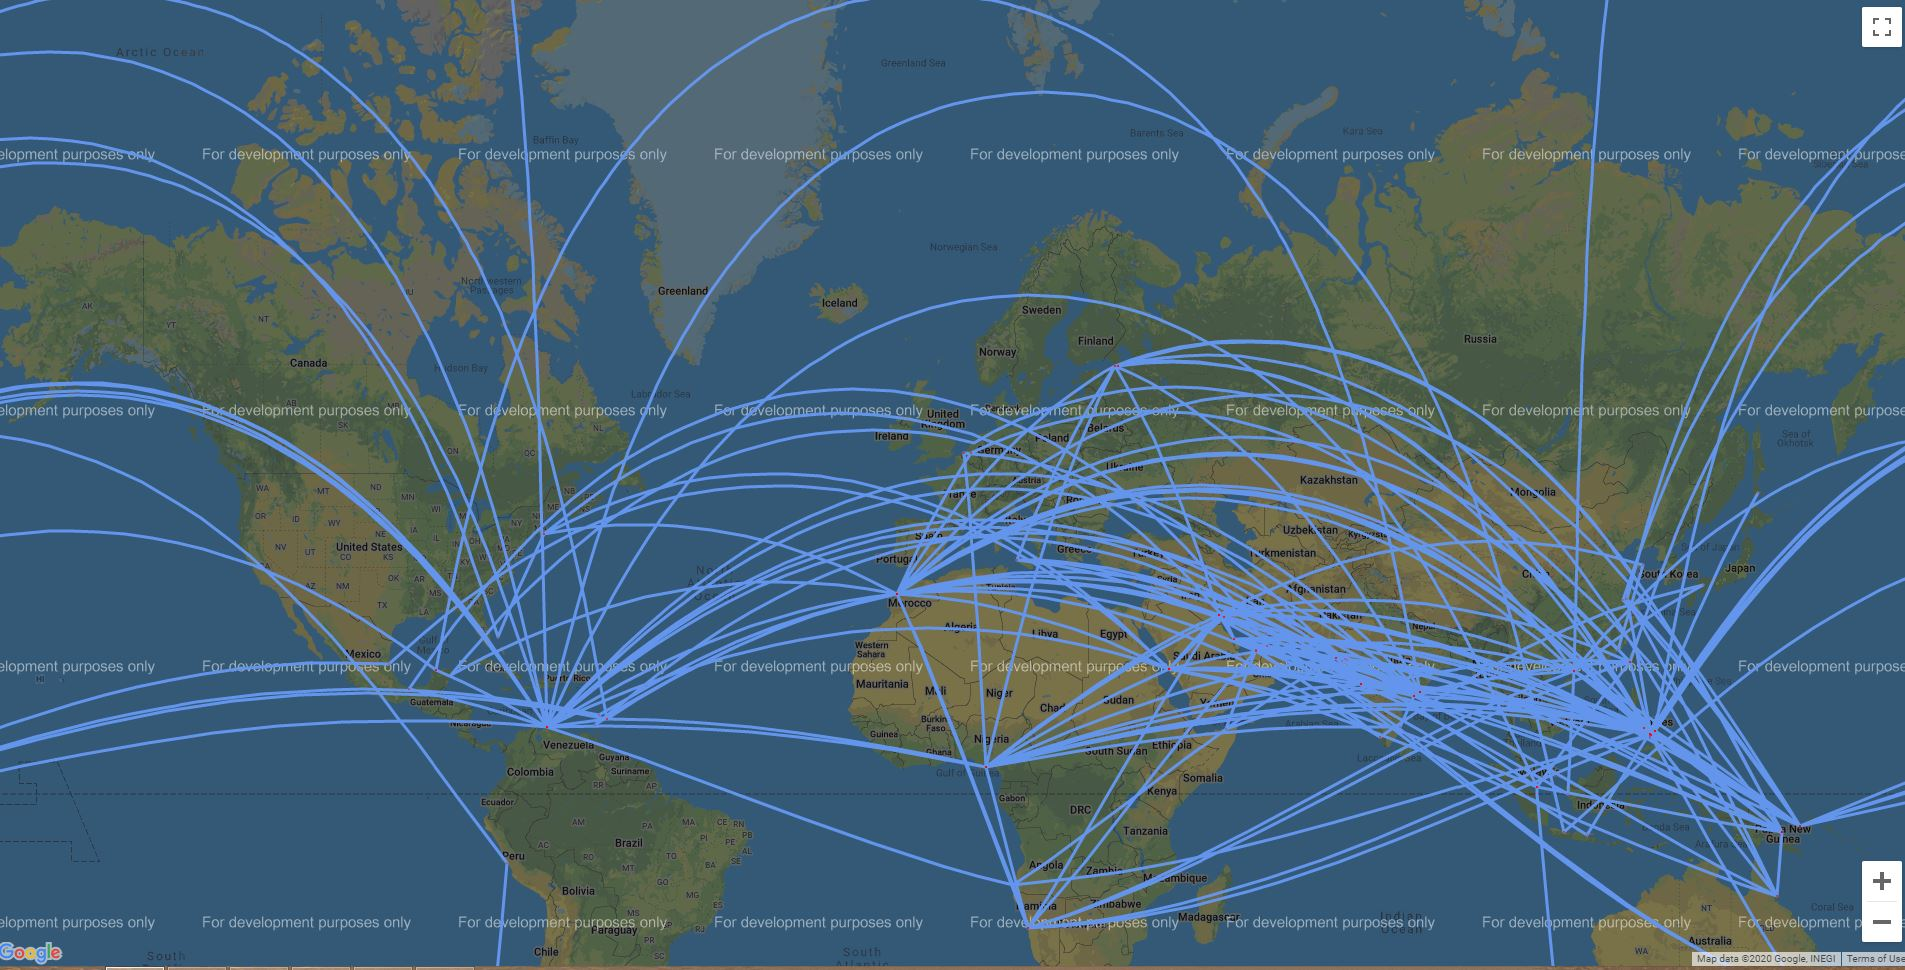


**After:**
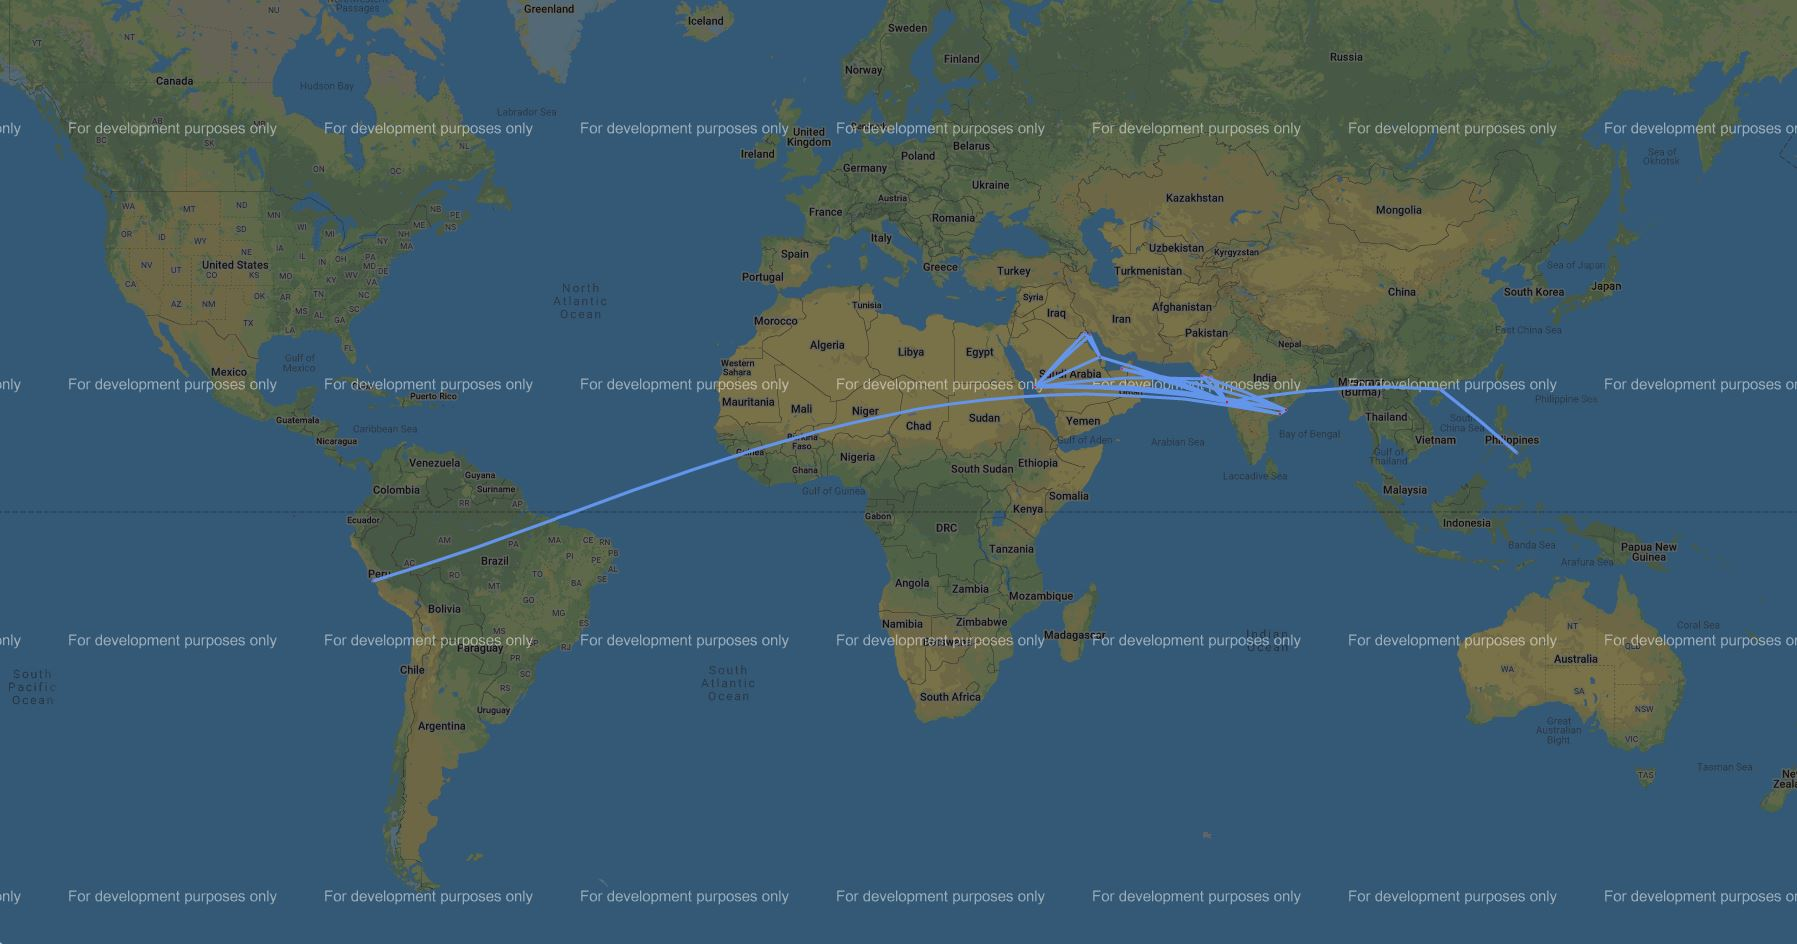

**The cleaning heuristic used here is certainly crude, and the drawing indicates it may be erroneous**
**(why visiting Queit and Saudi Arabia successivelly?), but under the scope of this exercise it's reasonable**

## Durations distribution as a function of the vessel type ##

**After obtaining a more reliable dataset, we want to examine the durations distribution, in order to identify possible related explanatory features**

### Durations distribution per port ###

In [85]:
train_df_to_work_with = cleaned_raw_df

There were 113 tankers visits and 60 non-tanker visits to port 537c6adb72ef82043d620fdf


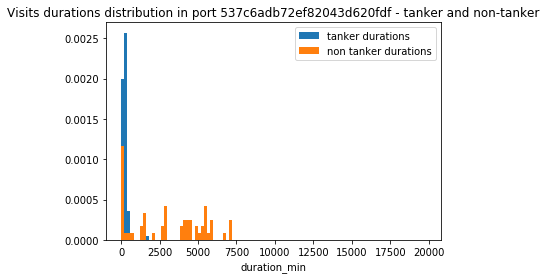

In [102]:
ports_lst = list(tankers_ports_set)
# curr_port = next(iter(tankers_ports_set))
curr_port = ports_lst[1179]
curr_port_visits = train_df_to_work_with[train_df_to_work_with['port_id'] == curr_port]
curr_port_tanker_visits_durations = curr_port_visits[curr_port_visits['label']==1]['duration_min']
curr_port_non_tanker_visits_durations = curr_port_visits[curr_port_visits['label']==0]['duration_min']
print(f"There were {len(curr_port_tanker_visits_durations)} tankers visits and {len(curr_port_non_tanker_visits_durations)} non-tanker visits to port {curr_port}")
fig_visits, ax_visits = plt.subplots()
bins = np.arange(0,20000, 200)
ax_visits.hist(curr_port_tanker_visits_durations,  bins=bins, density=True, label = "tanker durations")
ax_visits.hist(curr_port_non_tanker_visits_durations, bins=bins, density=True, label = "non tanker durations")
ax_visits.set_title(f"Visits durations distribution in port {curr_port} - tanker and non-tanker")
ax_visits.set_xlabel("duration_min")
plt.legend();


**Seems that per port (at least for some ports), the durations distribution differs between tankers and non tankers.**
**This indicates another potential explanatory feature**

**Let's just get a sense of the overall visits numbers per port**

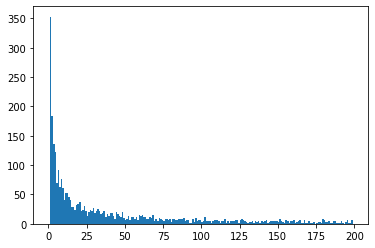

In [105]:
num_visits_per_port = [len(pdf) for pid,pdf in train_df_to_work_with.groupby('port_id')]
plt.hist(num_visits_per_port, bins=np.arange(200));

**Seems exponential, so it's basically random across the entire population (no special patterns, at least at a glance)**

### Durations distribution per vessel ###

In [107]:
tanker_grouped = train_df_to_work_with[train_df_to_work_with['label']==1].groupby('ves_id')
tanker_grouped_iter = iter(tanker_grouped)
non_tanker_grouped = train_df_to_work_with[train_df_to_work_with['label']==0].groupby('ves_id')
non_tanker_grouped_iter = iter(non_tanker_grouped)

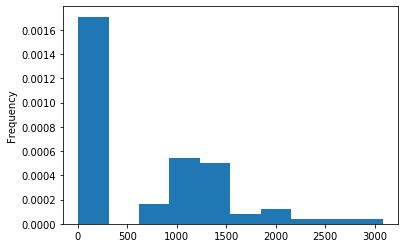

In [115]:
curr_tanker_df = next(tanker_grouped_iter)[1]
curr_tanker_df['duration_min'].plot.hist(density = True)

**Examining several tankers indicates a typically bounded durations set (< 10,000 mins)**

### Durations distribution per vessel type ###

**Let's first compare the tanker and non tanker overall durations distribution.**

1293.0
644.81


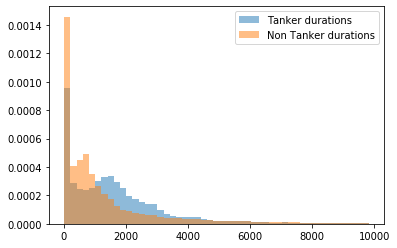

In [116]:
all_tanker_durations = train_df_to_work_with[train_df_to_work_with['label']==1]['duration_min']
all_non_tanker_durations = train_df_to_work_with[train_df_to_work_with['label']==0]['duration_min']
fig_durations,ax_durations = plt.subplots()
durations_bins = np.arange(10,10000, 200)
ax_durations.hist(all_tanker_durations, bins = durations_bins, density=True, label = 'Tanker durations', alpha=0.5)
ax_durations.hist(all_non_tanker_durations, bins = durations_bins, density=True, label = 'Non Tanker durations', alpha=0.5)
plt.legend()
print(np.median(all_tanker_durations.values))
print(np.median(all_non_tanker_durations.values))

**They are different, but with a large overalapping area, so separation is not very promissing.**

**Num samples and overall series duration per vessel**

In [127]:
train_orig_grouped = train_df_to_work_with.groupby('ves_id')
train_df_to_work_with['start_time']
train_set_df_orig['start_time']

0        2016-03-10 07:55:05
1        2016-03-31 07:37:35
2        2016-06-16 07:24:58
3        2016-03-10 05:28:48
4        2016-04-26 18:12:19
                 ...        
732479   2016-03-20 23:59:11
732480   2016-06-13 06:10:45
732481   2016-03-16 08:56:22
732482   2016-03-16 09:32:12
732483   2016-01-02 06:01:15
Name: start_time, Length: 732484, dtype: datetime64[ns]

In [126]:
per_ves_ts_len_tanker = []
per_ves_ts_duration_tanker = []
overall_deltas_tanker = np.array([])
per_ves_ts_len_non_tanker = []
per_ves_ts_duration_non_tanker = []
overall_deltas_non_tanker = np.array([])

for vid, vdf in train_df_to_work_with.groupby('ves_id'):
#     print(vid)
    is_tanker = vdf.iloc[0]['label'] == 1
    per_ves_ts_len  = per_ves_ts_len_tanker if is_tanker else per_ves_ts_len_non_tanker
    per_ves_ts_len.append(len(vdf))
    sorted_ts = vdf['start_time'].sort_values().values
    deltas = sorted_ts[1:] - sorted_ts[:-1]
    if is_tanker:
        overall_deltas_tanker = np.append(overall_deltas_tanker, deltas.astype('timedelta64[m]').astype('int'))
    else:
        overall_deltas_non_tanker = np.append(overall_deltas_non_tanker, deltas.astype('timedelta64[m]').astype('int'))
    per_ves_ts_duration = per_ves_ts_duration_tanker if is_tanker else per_ves_ts_duration_non_tanker
    per_ves_ts_duration.append(sorted_ts[-1]-sorted_ts[0])
    

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [289]:
overall_deltas_tanker

array([19337., 44039., 32045., ...,  2005.,  6043.,  6815.])

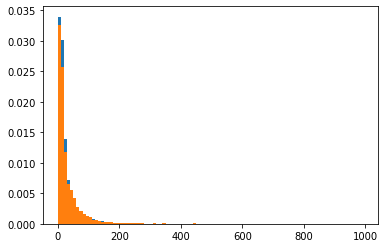

In [273]:
fig_ts_len, ax_ts_len = plt.subplots()
ax_ts_len.hist(per_ves_ts_len_tanker, bins=np.arange(0,1000,10), label='Tanker', density=True);
ax_ts_len.hist(per_ves_ts_len_non_tanker, bins=np.arange(0,1000,10), label='Non Tanker', density=True);

In [262]:
min(per_ves_ts_len)

1

In [249]:
np.array(per_ves_ts_duration).astype('timedelta64[m]').astype('int')

array([250356, 148235, 252381, ...,   1542,      0,      0])

NameError: name 'per_ves_ts_duration_non_tanker' is not defined

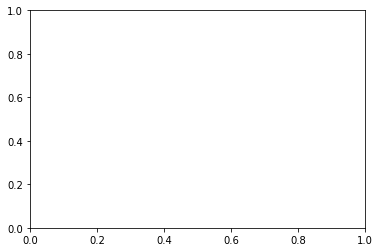

In [35]:
fig_ts_duration, ax_ts_duration = plt.subplots()
ax_ts_duration.hist(np.array(per_ves_ts_duration_non_tanker).astype('timedelta64[m]').astype('int'), label='Non Tanker', density=True, alpha=0.5);
ax_ts_duration.hist(np.array(per_ves_ts_duration_tanker).astype('timedelta64[m]').astype('int'), label='Tanker', density=True, alpha=0.5);

ax_ts_duration.legend()
# plt.hist(np.array(per_ves_ts_duration).astype('timedelta64[m]').astype('int'), density=True);

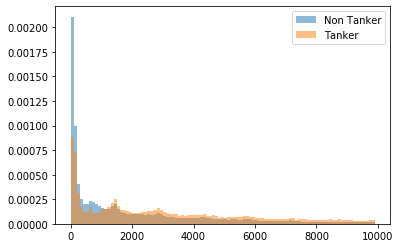

In [295]:
fig_ts_deltas, ax_ts_deltas = plt.subplots()
ax_ts_deltas.hist(overall_deltas_non_tanker,  label='Non Tanker', density=True, bins=np.arange(0,10000,100), alpha=0.5 ); 
ax_ts_deltas.hist(overall_deltas_tanker,  label='Tanker', density=True, bins=np.arange(0,10000,100), alpha=0.5 ); 
ax_ts_deltas.legend()

In [298]:
tanker_grouped_lst = list(tanker_grouped)
tanker_lst_lens = [len(vdf) for vid,vdf in tanker_grouped_lst]

In [302]:
np.argmax(tanker_lst_lens)

2741

In [300]:
len(tanker_lst_lens)

2898

In [313]:
# tanker_grouped_lst[2741][1].to_csv("tanker_2741.csv")
len(pd.unique(tanker_grouped_lst[2741][1]['port_id']))
curr_tanker_sorted_df = tanker_grouped_lst[2741][1].sort_values('start_time')
curr_tanker_sorted_df.to_csv("tanker_2741.csv")

In [316]:
non_tanker_grouped_lst = list(non_tanker_grouped)
non_tanker_lst_lens = [len(vdf) for vid,vdf in non_tanker_grouped_lst]

In [317]:
np.argmax(non_tanker_lst_lens)

9933

In [322]:
curr_non_tanker_sorted_df = non_tanker_grouped_lst[9933][1].sort_values('start_time')
curr_non_tanker_sorted_df.to_csv("non_tanker_9933.csv")

**Vess 56d96c11e4b0436ba6e245ca is a passenger vessel - it just travels between two ports: Cowes Harbour and southhampton**

In [24]:

vess_by_type = defaultdict(list)
for vid,vdf in train_orig_grouped:
    vess_by_type[vdf.iloc[0]['type']].append(vdf)



C:\Users\Matan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\Matan\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning:

invalid value encountered in true_divide



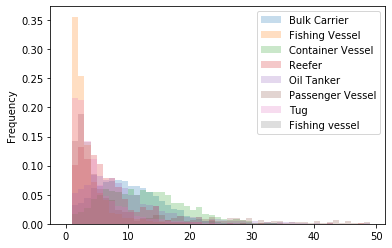

In [72]:
num_locations_per_type = { k : pd.Series( [len(np.unique(vdf['port_id'])) for vdf in vess_by_type[k]]) for k in vess_by_type}
pd.DataFrame(num_locations_per_type).plot.hist(alpha=0.25, density=True, bins=bins_for_num_locations)

In [47]:
non_tanker_num_locations = pd.Series(np.concatenate([loc_ser.values for k,loc_ser in  num_locations_per_type.items() if k != 'Oil Tanker' ]))

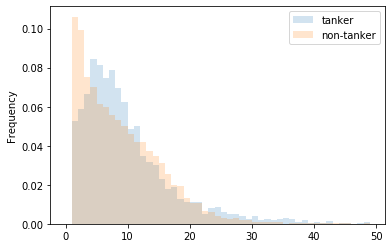

In [74]:
pd.DataFrame({"tanker": num_locations_per_type['Oil Tanker'],  "non-tanker": non_tanker_num_locations }).plot.\
hist(alpha=0.2, density=True, bins=bins_for_num_locations)

In [44]:
len(non_tanker_num_locations)

18224

In [54]:
len(non_tanker_num_locations.index.unique()) + len(num_locations_per_type['Oil Tanker'])

21122

In [53]:
sum([len(s) for s in num_locations_per_type.values() ])

21122

In [62]:
bins_for_num_locations = np.arange(0, 50, 1)

(array([0.        , 0.05248619, 0.05904696, 0.06664365, 0.08425414,
        0.08149171, 0.07458564, 0.07872928, 0.06975138, 0.0621547 ,
        0.04868785, 0.05006906, 0.03487569, 0.03176796, 0.03004144,
        0.02279006, 0.0179558 , 0.01864641, 0.01277624, 0.01104972,
        0.01139503, 0.01104972, 0.00483425, 0.00828729, 0.0086326 ,
        0.00587017, 0.00517956, 0.00517956, 0.00414365, 0.00241713,
        0.00414365, 0.00207182, 0.00241713, 0.00172652, 0.00241713,
        0.00310773, 0.00241713, 0.00069061, 0.00172652, 0.0003453 ,
        0.00069061, 0.0003453 , 0.00138122, 0.        , 0.0003453 ,
        0.0003453 , 0.        , 0.0003453 , 0.00069061]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

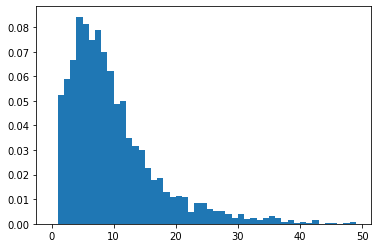

In [63]:
tanker_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Oil Tanker']]
plt.hist(tanker_num_locations, density=True, bins=bins_for_num_locations)

In [38]:
passengers_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Passenger Vessel']]

(array([0.        , 0.14226376, 0.18795431, 0.14018692, 0.08515057,
        0.06022845, 0.04465213, 0.04049844, 0.0238837 , 0.02076843,
        0.01973001, 0.00519211, 0.01038422, 0.00934579, 0.01557632,
        0.0145379 , 0.00726895, 0.01038422, 0.01349948, 0.00415369,
        0.00726895, 0.01142264, 0.00830737, 0.01142264, 0.00415369,
        0.00519211, 0.00934579, 0.00934579, 0.00623053, 0.00934579,
        0.00207684, 0.00623053, 0.00311526, 0.00519211, 0.00415369,
        0.00207684, 0.00311526, 0.00311526, 0.00311526, 0.00207684,
        0.00519211, 0.00207684, 0.00311526, 0.00623053, 0.00207684,
        0.00415369, 0.00103842, 0.00103842, 0.00311526]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

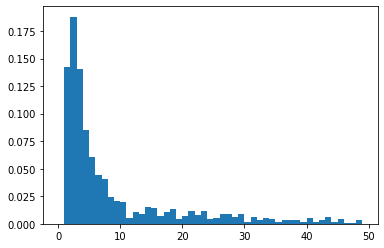

In [66]:
plt.hist(passengers_num_locations, bins=bins_for_num_locations, density=True)

(array([0.        , 0.21554661, 0.21275937, 0.14183958, 0.11117993,
        0.06720347, 0.0470734 , 0.03871168, 0.03065965, 0.02880149,
        0.01951068, 0.0142459 , 0.01238774, 0.00836172, 0.00867142,
        0.00836172, 0.00495509, 0.00495509, 0.00526479, 0.00371632,
        0.00309693, 0.00371632, 0.00185816, 0.00123877, 0.00123877,
        0.00030969, 0.00185816, 0.00061939, 0.        , 0.        ,
        0.        , 0.00030969, 0.00030969, 0.        , 0.00092908,
        0.        , 0.        , 0.        , 0.        , 0.00030969,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

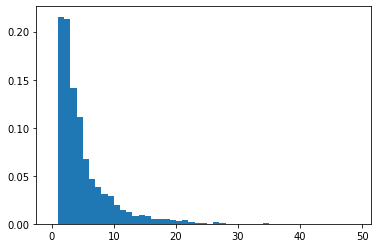

In [67]:
tug_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Tug']]
plt.hist(tug_num_locations, bins=bins_for_num_locations, density=True)

(array([0.        , 0.35604607, 0.25335893, 0.13627639, 0.07101727,
        0.05278311, 0.04174664, 0.01775432, 0.01727447, 0.01007678,
        0.01007678, 0.00767754, 0.00863724, 0.00479846, 0.00239923,
        0.00431862, 0.00191939, 0.00095969, 0.00143954, 0.00095969,
        0.        , 0.        , 0.        , 0.        , 0.00047985,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

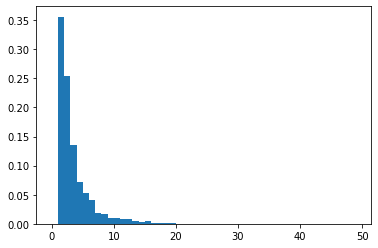

In [68]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Fishing Vessel']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.03185407, 0.0358018 , 0.04424176, 0.06180234,
        0.06452491, 0.07160359, 0.07405391, 0.07582358, 0.07391778,
        0.0649333 , 0.06575007, 0.06084944, 0.05417915, 0.04696433,
        0.03906888, 0.0319902 , 0.02613667, 0.02382249, 0.01306834,
        0.01075415, 0.00748707, 0.00558127, 0.00435611, 0.00299483,
        0.00204193, 0.00108903, 0.00081677, 0.00081677, 0.00081677,
        0.00040839, 0.00040839, 0.00054451, 0.00054451, 0.00027226,
        0.        , 0.00013613, 0.00013613, 0.        , 0.00027226,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00013613, 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

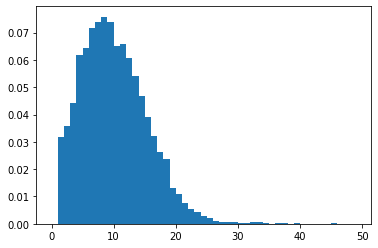

In [69]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Bulk Carrier']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.01658826, 0.02005447, 0.02698688, 0.04184204,
        0.04976479, 0.05917306, 0.05644962, 0.05471651, 0.0514979 ,
        0.06016341, 0.04926962, 0.05793513, 0.05446893, 0.05471651,
        0.05545927, 0.04976479, 0.03490963, 0.03614756, 0.03119584,
        0.02352067, 0.02822481, 0.01634068, 0.01535033, 0.01089379,
        0.0089131 , 0.00569448, 0.00866551, 0.00668482, 0.00495172,
        0.00198069, 0.0017331 , 0.00123793, 0.0017331 , 0.0017331 ,
        0.        , 0.        , 0.        , 0.00049517, 0.00024759,
        0.        , 0.00024759, 0.        , 0.        , 0.00024759,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

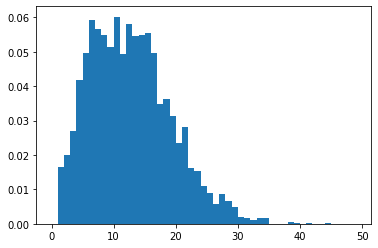

In [70]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Container Vessel']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.10153257, 0.13218391, 0.11111111, 0.11877395,
        0.10344828, 0.07854406, 0.07854406, 0.06321839, 0.04214559,
        0.02298851, 0.0210728 , 0.02873563, 0.02298851, 0.03065134,
        0.00383142, 0.00574713, 0.00383142, 0.00383142, 0.00383142,
        0.00383142, 0.00383142, 0.        , 0.00574713, 0.        ,
        0.        , 0.00191571, 0.        , 0.00191571, 0.        ,
        0.        , 0.00191571, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00191571, 0.        , 0.        ,
        0.        , 0.        , 0.00191571, 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

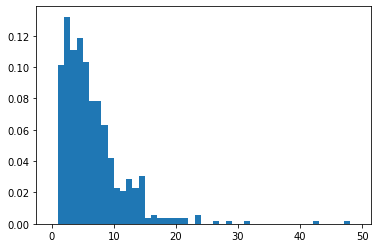

In [75]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Reefer']], density=True, bins=bins_for_num_locations)

In [13]:
np.unique(train_vessels_labels_orig.type)

array(['Bulk Carrier', 'Container Vessel', 'Fishing Vessel', 'Oil Tanker',
       'Passenger Vessel', 'Reefer', 'Tug'], dtype=object)

# Features engineering

### Extractor classes ###

In [4]:
#TODO: use ABC
class FeaturesGenerator:
    def __init__(self):
        pass
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        pass
    
    
class LabelsGenerator:
    def __init__(self):
        pass
    def generate_labels(self, input_df:pd.DataFrame) -> pd.DataFrame:
        pass
    
    
class FeaturesExtractor:
    def __init__(self, features_generators:List[FeaturesGenerator], labels_generator: LabelsGenerator):
        self.generators_lst = features_generators
        self.labels_generator = labels_generator
    
    #Returns the features dataframe and the labels dataframe
    def generate_features(self, input_df:pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        features_dfs = [gen.generate_features(input_df) for gen in self.generators_lst ]
        features_df = pd.concat(features_dfs, axis=1)
        labels_df = self.labels_generator.generate_labels(input_df)
        if not all(labels_df.index == features_df.index):
            raise Exception("In generate_features(). The labels and features dfs have different index!!")
        return features_df,labels_df

In [5]:
#TODO: check embedding here instead of on-hot-encoding
'''
Encode categorical ports as a one-hot numeric array, and have the per-port value the total stay duration in this port.
Return a dataframe in which each row encodes the durations per port of a single vessel.
'''
from sklearn.preprocessing import OneHotEncoder

class PortsFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        res_df_rows = []
        res_df_ind = []
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(input_df[['port_id']])
        for vid,vdf in input_df.groupby('ves_id'):
            ports_categorized = enc.transform(vdf[['port_id']]).toarray()
            ports_categorized_durations = ports_categorized * vdf[['duration_min']].values
            res_df_ind.append(vid)
            res_df_rows.append(ports_categorized_durations.sum(axis=0))
        return pd.DataFrame(res_df_rows, index = res_df_ind, columns=enc.categories_[0])
            
'''
The spread of the visited locations
'''
from shapely.geometry import MultiPoint
class DistanceStdGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:    
        res_df_rows = []
        res_df_ind = []
        for vid,vdf in input_df.groupby('ves_id'):
            ports_coords = [(lt,lng) for lt,lng in zip(vdf['Lat'], vdf['Long'])]
            locations_polygon = MultiPoint(ports_coords)
            #Probably not the geodetic centroid, but I don't have time to improve this now...
            locations_centroid = locations_polygon.centroid 
            dists_from_centroid = np.array([calc_dist_km((locations_centroid.x, locations_centroid.y), (lt,lng)) for
                                   lt,lng in zip(vdf['Lat'], vdf['Long'])] )
            res_df_ind.append(vid)
            res_df_rows.append(np.sqrt(dists_from_centroid.dot(dists_from_centroid)/len(dists_from_centroid)))
        return pd.DataFrame(res_df_rows, index = res_df_ind, columns=['ports_std'])
            

'''
The average and median durations in the tankers and non-tanker ports 
'''
#TODO: add 25 and 75 percentiles
class PortsDurationSamplesFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        all_ports_set = set(input_df['port_id'])
        tankers_ports_set = set(input_df['port_id'][input_df['label']==1])
#         non-tankers_ports_set = all_ports_set.difference(tankers_ports_set)
        res_df_rows = []
        res_df_ind = []    
        for vid,vdf in input_df.groupby('ves_id'):

            tankers_inds = vdf['port_id'].apply(lambda p : p in tankers_ports_set)
            res_df_ind.append(vid)
            res_df_rows.append([vdf[tankers_inds]['duration_min'].mean(), vdf[tankers_inds]['duration_min'].median(), 
                                vdf[~tankers_inds]['duration_min'].mean(), vdf[~tankers_inds]['duration_min'].median(), 
                               vdf['duration_min'].mean(), vdf['duration_min'].median()])
        res =  pd.DataFrame(res_df_rows, index = res_df_ind, 
                            columns=['tanker_ports_mean_duration', 'tanker_ports_median_duration', 
                                    'non_tanker_ports_mean_duration', 'non_tanker_ports_median_duration', 
                                     'all_ports_mean_duration', 'all_ports_median_duration' ])
        res = res.fillna(-1)
        return res

    
class PercentTankersPortsFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        all_ports_set = set(input_df['port_id'])
        tankers_ports_set = set(input_df['port_id'][input_df['label']==1])
        res_df_rows = []
        res_df_ind = []    
        for vid,vdf in input_df.groupby('ves_id'):
            tankers_inds = vdf['port_id'].apply(lambda p : p in tankers_ports_set)
            res_df_ind.append(vid)
            res_df_rows.append([tankers_inds.sum()/len(vdf)])
                               
        res = pd.DataFrame(res_df_rows, index = res_df_ind, columns = ['tankers_ports_percentage'])
        return res
                           
       
class BinaryLabelsGenerator(LabelsGenerator):
    def __init__(self):
        pass
    def generate_labels(self, input_df:pd.DataFrame) -> pd.DataFrame:
        patients_classes_df = input_df.groupby('ves_id').nth(0)['label']
        return patients_classes_df
                                                                
        

### Features generation ###

In [60]:
# extractor = FeaturesExtractor([PortsFeaturesGenerator()], BinaryLabelsGenerator())
extractor = FeaturesExtractor([PortsDurationSamplesFeaturesGenerator(),
                               PercentTankersPortsFeaturesGenerator(), 
                               DistanceStdGenerator() ], BinaryLabelsGenerator())
features_df, labels_df = extractor.generate_features(train_df_to_work_with)

vid: 56d83489e4b01c7098934f48, centroid: POINT (19.21657142857143 -19.60942857142857)
vid: 56d83489e4b01c7098934f4f, centroid: POINT (35.49266666666666 138.8448333333334)
vid: 56d83489e4b01c7098934f50, centroid: POINT (29.61133333333333 2.190666666666669)
vid: 56d83489e4b01c7098934f51, centroid: POINT (44.41027272727273 -77.86790909090911)
vid: 56d83489e4b025a920ad5e6e, centroid: POINT (9.9915 73.28116666666666)
vid: 56d83489e4b02a0dec522faf, centroid: POINT (27.76524324324323 48.35413513513511)
vid: 56d83489e4b02c65b7730d72, centroid: POINT (29.73161224489796 2.624326530612247)
vid: 56d83489e4b02c65b7730d76, centroid: POINT (29.72488888888888 120.064)
vid: 56d83489e4b02c65b7730d77, centroid: POINT (-11.3684 10.3556)
vid: 56d83489e4b0581dc93c9211, centroid: POINT (3.688027777777779 -71.41966666666666)
vid: 56d83489e4b0ad1bfa26097a, centroid: POINT (28.49912499999999 120.1910416666667)
vid: 56d83489e4b0ad1bfa26097e, centroid: POINT (5.368000000000001 135.3171818181818)
vid: 56d83489e4b0

vid: 56d8348ae4b0c8d95c300922, centroid: POINT (34.16118181818182 76.67854545454544)
vid: 56d8348ae4b0c8d95c300927, centroid: POINT (-35.49394594594594 -57.44556756756756)
vid: 56d8348ae4b0c8d95c30092d, centroid: POINT (29.572 101.40125)
vid: 56d8348ae4b0d38e4536eb48, centroid: POINT (14.58045454545455 99.05636363636364)
vid: 56d8348ae4b0d38e4536eb4a, centroid: POINT (6.918250000000001 37.49299999999999)
vid: 56d8348ae4b0d38e4536eb4d, centroid: POINT (-32.55813043478259 -71.55878260869561)
vid: 56d8348ae4b0d38e4536eb52, centroid: POINT (20.0677 94.24170000000001)
vid: 56d8348ae4b0d38e4536eb54, centroid: POINT (-22.93876865671643 -43.79880597014933)
vid: 56d8348ae4b0d38e4536eb58, centroid: POINT (3.008999999999999 -89.55775)
vid: 56d8348ae4b0d38e4536eb5b, centroid: POINT (33.8715 130.3252647058824)
vid: 56d8348ae4b0d38e4536eb5d, centroid: POINT (65.11150000000001 -22.531)
vid: 56d8348ae4b0d38e4536eb65, centroid: POINT (4.697399999999999 85.22420000000001)
vid: 56d8348ae4b0d38e4536eb66, 

vid: 56d8348be4b025a920ad5e98, centroid: POINT (36.81828767123287 -53.92465753424657)
vid: 56d8348be4b025a920ad5e9b, centroid: POINT (4.898166666666667 76.00758333333334)
vid: 56d8348be4b025a920ad5e9d, centroid: POINT (20.73142857142857 33.63678571428573)
vid: 56d8348be4b025a920ad5ea5, centroid: POINT (37.45035714285714 15.41621428571429)
vid: 56d8348be4b026569c5ac8a2, centroid: POINT (28.6966875 57.79228124999999)
vid: 56d8348be4b026569c5ac8a4, centroid: POINT (29.53416666666666 120.8255)
vid: 56d8348be4b026569c5ac8a6, centroid: POINT (1.2135 88.90000000000001)
vid: 56d8348be4b026569c5ac8b6, centroid: POINT (33.666 -54.27464705882353)
vid: 56d8348be4b026569c5ac8bc, centroid: POINT (10.761875 111.95575)
vid: 56d8348be4b026569c5ac8be, centroid: POINT (25.74942857142858 80.82014285714286)
vid: 56d8348be4b0271c9aa37072, centroid: POINT (25.2681052631579 -55.07773684210525)
vid: 56d8348be4b0271c9aa37073, centroid: POINT (23.3841 59.3771)
vid: 56d8348be4b0271c9aa3707b, centroid: POINT (29.0

vid: 56d8348be4b0ad1bfa2609c1, centroid: POINT (23.53031818181818 -27.25172727272727)
vid: 56d8348be4b0ad1bfa2609c2, centroid: POINT (-36.50833333333333 -33.18766666666667)
vid: 56d8348be4b0ad1bfa2609c5, centroid: POINT (23.6583125 -33.91350000000001)
vid: 56d8348be4b0ad1bfa2609c9, centroid: POINT (35.093 128.96)
vid: 56d8348be4b0b1c94f7bde0b, centroid: POINT (-45.468 -72.81999999999999)
vid: 56d8348be4b0b1c94f7bde0f, centroid: POINT (18.33792857142857 57.76892857142855)
vid: 56d8348be4b0b1c94f7bde16, centroid: POINT (6.432 3.37)
vid: 56d8348be4b0b1c94f7bde18, centroid: POINT (-1.364666666666666 -31.40933333333334)
vid: 56d8348be4b0b1c94f7bde1e, centroid: POINT (49.74316666666666 1.27825)
vid: 56d8348be4b0b1c94f7bde1f, centroid: POINT (-29.879 31.024)
vid: 56d8348be4b0b2a61c63a8ce, centroid: POINT (25.90475 117.9403333333333)
vid: 56d8348be4b0b2a61c63a8d4, centroid: POINT (45.84213145539913 -122.7280915492955)
vid: 56d8348be4b0b2a61c63a8d6, centroid: POINT (16.04464285714286 -58.299714

vid: 56d8348ce4b00146513f8f74, centroid: POINT (39.13072222222222 9.522999999999994)
vid: 56d8348ce4b00146513f8f7f, centroid: POINT (-33.91 18.437)
vid: 56d8348ce4b001f4293429dc, centroid: POINT (30.565 99.80442857142859)
vid: 56d8348ce4b001f4293429e0, centroid: POINT (5.945833333333333 132.0523333333333)
vid: 56d8348ce4b001f4293429e5, centroid: POINT (25.07004494382024 115.6810337078652)
vid: 56d8348ce4b002eabab57ef2, centroid: POINT (67.94499999999999 13.635)
vid: 56d8348ce4b002eabab57efe, centroid: POINT (23.07313333333333 -19.96693333333333)
vid: 56d8348ce4b002eabab57f00, centroid: POINT (31.60996363636364 21.09594545454546)
vid: 56d8348ce4b002eabab57f03, centroid: POINT (33.02791666666666 71.24845833333332)
vid: 56d8348ce4b002eabab57f07, centroid: POINT (-15.3685 109.771)
vid: 56d8348ce4b002eabab57f0c, centroid: POINT (23.7654 2.9897)
vid: 56d8348ce4b002eabab57f0d, centroid: POINT (2.649383333333335 -60.68556666666667)
vid: 56d8348ce4b002eabab57f14, centroid: POINT (18.84723255813

vid: 56d8348ce4b0550004876bb7, centroid: POINT (43.25016666666667 -59.41758333333333)
vid: 56d8348ce4b0550004876bc0, centroid: POINT (14.78873684210528 -72.13142105263157)
vid: 56d8348ce4b0550004876bc1, centroid: POINT (19.7710625 110.571125)
vid: 56d8348ce4b0550004876bc5, centroid: POINT (0.9850000000000008 91.65055555555556)
vid: 56d8348ce4b0550004876bce, centroid: POINT (27.46106896551724 3.231862068965518)
vid: 56d8348ce4b0581dc93c9266, centroid: POINT (31.517 -9.597500000000005)
vid: 56d8348ce4b0581dc93c9268, centroid: POINT (45.832 -73.28399999999998)
vid: 56d8348ce4b0581dc93c926a, centroid: POINT (54.26913084112149 -130.3149626168223)
vid: 56d8348ce4b0581dc93c926b, centroid: POINT (5.992818181818179 138.0917272727273)
vid: 56d8348ce4b0581dc93c926c, centroid: POINT (32.22364000000001 126.80556)
vid: 56d8348ce4b0581dc93c9274, centroid: POINT (15.70919565217391 107.5771521739131)
vid: 56d8348ce4b0581dc93c9275, centroid: POINT (16.98107142857143 109.8633571428571)
vid: 56d8348ce4b05

vid: 56d8348ce4b0de6e5887adb0, centroid: POINT (24.25328571428572 35.17264285714285)
vid: 56d8348ce4b0de6e5887adb2, centroid: POINT (20.68673913043478 101.091)
vid: 56d8348ce4b0de6e5887adb4, centroid: POINT (34.819 135.632)
vid: 56d8348ce4b0e1071229c3f0, centroid: POINT (15.94521739130434 107.7327391304348)
vid: 56d8348ce4b0e1071229c3f1, centroid: POINT (29.50485714285714 -56.05914285714285)
vid: 56d8348ce4b0e1071229c3f4, centroid: POINT (17.78452941176471 120.4401176470588)
vid: 56d8348ce4b0e1071229c3fa, centroid: POINT (25.53022222222223 65.73100000000002)
vid: 56d8348ce4b0e1071229c3fe, centroid: POINT (10.76568518518519 87.38662962962968)
vid: 56d8348ce4b0e178dda670be, centroid: POINT (15.13303703703703 -10.27881481481482)
vid: 56d8348ce4b0e178dda670df, centroid: POINT (-42.03715555555557 -72.17960000000002)
vid: 56d8348ce4b0e47eba0a870f, centroid: POINT (0.5458684210526314 43.2245)
vid: 56d8348ce4b0e47eba0a8714, centroid: POINT (18.13935185185185 100.4127777777778)
vid: 56d8348ce4b

vid: 56d8348de4b025a920ad5f06, centroid: POINT (39.53284615384616 -23.12661538461538)
vid: 56d8348de4b025a920ad5f07, centroid: POINT (31.63966666666667 120.985)
vid: 56d8348de4b025a920ad5f0d, centroid: POINT (46.02652631578947 0.7193157894736842)
vid: 56d8348de4b025a920ad5f11, centroid: POINT (12.191 37.5076)
vid: 56d8348de4b025a920ad5f13, centroid: POINT (29.56775000000001 81.53481250000002)
vid: 56d8348de4b025a920ad5f19, centroid: POINT (-24.72345161290323 -56.8801935483871)
vid: 56d8348de4b025a920ad5f1f, centroid: POINT (-19.15561538461538 8.545615384615385)
vid: 56d8348de4b025a920ad5f22, centroid: POINT (43.78914285714285 -28.19623809523809)
vid: 56d8348de4b026569c5ac8ea, centroid: POINT (34.16416666666667 120.9176666666667)
vid: 56d8348de4b026569c5ac8ec, centroid: POINT (34.866 138.331)
vid: 56d8348de4b026569c5ac8f2, centroid: POINT (22.53984210526315 -25.29615789473684)
vid: 56d8348de4b0271c9aa3709e, centroid: POINT (-1.721357142857141 -13.54364285714287)
vid: 56d8348de4b0271c9aa

vid: 56d8348de4b09ee652001269, centroid: POINT (13.66666666666667 141.4833333333333)
vid: 56d8348de4b09ee65200126f, centroid: POINT (23.26207142857143 112.5218571428572)
vid: 56d8348de4b09ee652001271, centroid: POINT (22.26705882352941 31.1919411764706)
vid: 56d8348de4b09f39bec68132, centroid: POINT (-1.721404761904762 106.9241666666666)
vid: 56d8348de4b09f39bec68135, centroid: POINT (-8.549333333333331 67.35966666666667)
vid: 56d8348de4b09f39bec68137, centroid: POINT (36.4824 22.0575)
vid: 56d8348de4b09f39bec68138, centroid: POINT (63.92341666666665 9.519083333333333)
vid: 56d8348de4b0a0bfc44b97bd, centroid: POINT (-19.256 6.730636363636363)
vid: 56d8348de4b0a0bfc44b97c2, centroid: POINT (33.73611111111111 55.70251851851852)
vid: 56d8348de4b0a0bfc44b97c5, centroid: POINT (-42.33650000000002 -73.31224999999999)
vid: 56d8348de4b0a0bfc44b97c9, centroid: POINT (37.25529999999999 28.5621)
vid: 56d8348de4b0a0bfc44b97cb, centroid: POINT (22.65886363636364 60.72354545454545)
vid: 56d8348de4b0

vid: 56d8348de4b0e80e4c3be5f7, centroid: POINT (26.30741666666666 29.24416666666667)
vid: 56d8348de4b0e85416b970ca, centroid: POINT (39.353 -9.372)
vid: 56d8348de4b0e85416b970ce, centroid: POINT (24.82866666666667 -7.883666666666664)
vid: 56d8348de4b0e85416b970da, centroid: POINT (17.16794117647059 119.8504117647059)
vid: 56d8348de4b0e85416b970e1, centroid: POINT (8.006 89.61275000000002)
vid: 56d8348de4b0e85416b970e3, centroid: POINT (36.804 -47.53840000000001)
vid: 56d8348de4b0e85416b970ea, centroid: POINT (29.29300000000001 3.145499999999999)
vid: 56d8348de4b0fd8aa7f86262, centroid: POINT (25.8385625 43.5275625)
vid: 56d8348de4b0fd8aa7f86263, centroid: POINT (22.1375 61.52549999999999)
vid: 56d8348de4b0fe4de2247339, centroid: POINT (43.63207547169812 -85.58520754716977)
vid: 56d8348de4b0fe4de224733a, centroid: POINT (10.5495433070866 -61.53144881889774)
vid: 56d8348de4b0fe4de224733f, centroid: POINT (49.12685714285714 -123.0817142857143)
vid: 56d8348de4b0fe4de2247347, centroid: POIN

vid: 56d8348ee4b0365aa1132d69, centroid: POINT (33.31183333333334 70.84855555555555)
vid: 56d8348ee4b0365aa1132d72, centroid: POINT (29.66418181818182 14.84754545454546)
vid: 56d8348ee4b0365aa1132d73, centroid: POINT (15.89867307692309 108.61125)
vid: 56d8348ee4b0365aa1132d7b, centroid: POINT (20.89447826086957 77.65304347826086)
vid: 56d8348ee4b0426087e0ebd9, centroid: POINT (34.5715274725275 103.3883626373627)
vid: 56d8348ee4b0426087e0ebe6, centroid: POINT (42.039 -71.10900000000001)
vid: 56d8348ee4b0426087e0ebf8, centroid: POINT (31.66936 53.44932)
vid: 56d8348ee4b0426087e0ebfa, centroid: POINT (64.62366666666668 -16.47233333333334)
vid: 56d8348ee4b0426087e0ec0b, centroid: POINT (-1.89940425531915 124.514085106383)
vid: 56d8348ee4b0426087e0ec10, centroid: POINT (13.41216666666666 124.8595)
vid: 56d8348ee4b0426087e0ec1a, centroid: POINT (26.192 -42.4718)
vid: 56d8348ee4b0426087e0ec1d, centroid: POINT (34.4976 13.1842)
vid: 56d8348ee4b0426087e0ec20, centroid: POINT (10.5709 136.6747)


vid: 56d8348ee4b0b1c94f7bde6f, centroid: POINT (-21.01938709677419 -63.66587096774193)
vid: 56d8348ee4b0b1c94f7bde70, centroid: POINT (20.46022222222222 69.09377777777779)
vid: 56d8348ee4b0b1c94f7bde71, centroid: POINT (12.62394791666667 15.97751041666667)
vid: 56d8348ee4b0b1c94f7bde72, centroid: POINT (16.622 119.369)
vid: 56d8348ee4b0b1c94f7bde76, centroid: POINT (26.576375 100.6295)
vid: 56d8348ee4b0b1c94f7bde78, centroid: POINT (30.5665 32.4395)
vid: 56d8348ee4b0b2a61c63a916, centroid: POINT (26.1797619047619 34.96114285714285)
vid: 56d8348ee4b0b2a61c63a91c, centroid: POINT (29.80365 23.7296)
vid: 56d8348ee4b0b2a61c63a91e, centroid: POINT (24.735 -37.08011111111111)
vid: 56d8348ee4b0b2a61c63a92a, centroid: POINT (33.746875 49.2876875)
vid: 56d8348ee4b0b90a07511ad8, centroid: POINT (14.67968965517241 27.22144827586206)
vid: 56d8348ee4b0b90a07511ad9, centroid: POINT (8.437749999999999 138.81725)
vid: 56d8348ee4b0b90a07511adb, centroid: POINT (27.46711764705882 -72.25223529411765)
vid

vid: 56d8348fe4b00146513f9007, centroid: POINT (4.446999999999998 -56.43340000000001)
vid: 56d8348fe4b00146513f9009, centroid: POINT (24.01880769230769 5.227846153846157)
vid: 56d8348fe4b00146513f900d, centroid: POINT (18.776 101.5194117647059)
vid: 56d8348fe4b00146513f9010, centroid: POINT (26.05266666666667 54.40633333333334)
vid: 56d8348fe4b001f429342a1f, centroid: POINT (30.7725 93.38039999999999)
vid: 56d8348fe4b001f429342a20, centroid: POINT (27.46225 -31.133)
vid: 56d8348fe4b001f429342a21, centroid: POINT (21.15633333333333 86.73733333333332)
vid: 56d8348fe4b001f429342a22, centroid: POINT (25.04733333333333 33.75466666666667)
vid: 56d8348fe4b001f429342a25, centroid: POINT (20.65349999999999 108.53672)
vid: 56d8348fe4b001f429342a26, centroid: POINT (-23.926 -46.338)
vid: 56d8348fe4b001f429342a28, centroid: POINT (28.54118181818182 114.3725454545454)
vid: 56d8348fe4b001f429342a2c, centroid: POINT (11.26211320754717 87.47367924528307)
vid: 56d8348fe4b002eabab57f7c, centroid: POINT 

vid: 56d8348fe4b02a0dec52309c, centroid: POINT (63.71977777777777 -20.19866666666667)
vid: 56d8348fe4b02a0dec5230a4, centroid: POINT (21.49825 41.67149999999999)
vid: 56d8348fe4b02a0dec5230a8, centroid: POINT (28.56106896551724 75.12634482758621)
vid: 56d8348fe4b02c65b7730e3f, centroid: POINT (29.88136842105263 -57.23168421052632)
vid: 56d8348fe4b02c65b7730e48, centroid: POINT (9.261750000000006 135.8894166666666)
vid: 56d8348fe4b02c65b7730e4a, centroid: POINT (31.265 130.291)
vid: 56d8348fe4b02c65b7730e4b, centroid: POINT (21.3604776119403 -75.18935820895521)
vid: 56d8348fe4b02c65b7730e50, centroid: POINT (42.27541025641027 -83.11135897435896)
vid: 56d8348fe4b02c65b7730e52, centroid: POINT (64.48157142857143 24.07928571428571)
vid: 56d8348fe4b02c65b7730e53, centroid: POINT (54.26910101010102 -130.3149595959595)
vid: 56d8348fe4b02c65b7730e55, centroid: POINT (0.8286249999999993 130.056)
vid: 56d8348fe4b02c65b7730e5b, centroid: POINT (33.86539999999999 33.88175)
vid: 56d8348fe4b02c65b77

vid: 56d8348fe4b0e85416b97127, centroid: POINT (6.815777777777778 -37.48344444444444)
vid: 56d8348fe4b0eadad234792e, centroid: POINT (13.01566666666667 -6.468)
vid: 56d8348fe4b0eadad2347939, centroid: POINT (14.03363333333334 57.78976666666667)
vid: 56d8348fe4b0eadad234793a, centroid: POINT (21.48342857142857 126.4261428571428)
vid: 56d8348fe4b0fd8aa7f86293, centroid: POINT (31.73225 120.94)
vid: 56d8348fe4b0fd8aa7f86294, centroid: POINT (-0.05661538461538459 104.3232307692308)
vid: 56d8348fe4b0fd8aa7f8629d, centroid: POINT (34.89357142857143 2.129571428571427)
vid: 56d8348fe4b0fe4de224735f, centroid: POINT (29.43874193548386 100.6847741935484)
vid: 56d8348fe4b0fe4de2247361, centroid: POINT (-44.79833333333334 -64.642)
vid: 56d8348fe4b0fe4de2247363, centroid: POINT (1.926666666666667 -78.79266666666668)
vid: 56d8348fe4b0fe4de2247364, centroid: POINT (26.75451136363636 -69.34089772727273)
vid: 56d8348fe4b0fe4de2247365, centroid: POINT (9.993142857142855 82.32166666666666)
vid: 56d8348fe

vid: 56d83490e4b0271c9aa3712b, centroid: POINT (36.40644444444445 28.10200000000001)
vid: 56d83490e4b0271c9aa3713c, centroid: POINT (18.26742857142857 112.6671428571428)
vid: 56d83490e4b0271c9aa37143, centroid: POINT (30.87395121951219 -7.973634146341463)
vid: 56d83490e4b0271c9aa37148, centroid: POINT (1.311 103.801)
vid: 56d83490e4b0271c9aa3714b, centroid: POINT (24.97225 90.11199999999999)
vid: 56d83490e4b0271c9aa37152, centroid: POINT (33.35220689655172 78.50486206896552)
vid: 56d83490e4b0271c9aa37153, centroid: POINT (10.827 116.9582)
vid: 56d83490e4b0271c9aa37155, centroid: POINT (7.085 171.36)
vid: 56d83490e4b0271c9aa37158, centroid: POINT (22.4805 95.38887500000001)
vid: 56d83490e4b0271c9aa37159, centroid: POINT (12.227 33.74225714285713)
vid: 56d83490e4b0271c9aa3715e, centroid: POINT (37.14963636363637 10.939)
vid: 56d83490e4b02a0dec5230ab, centroid: POINT (17.869375 88.15724999999999)
vid: 56d83490e4b02a0dec5230b0, centroid: POINT (28.13058928571428 -30.27853571428571)
vid: 56

vid: 56d83490e4b098a28bab8c69, centroid: POINT (29.32485714285715 34.79328571428572)
vid: 56d83490e4b09ee6520012b5, centroid: POINT (17.51566666666667 63.40273333333332)
vid: 56d83490e4b09ee6520012b7, centroid: POINT (-1.920958333333334 134.6749583333333)
vid: 56d83490e4b09ee6520012c1, centroid: POINT (14.97833333333334 114.0444166666667)
vid: 56d83490e4b09ee6520012c4, centroid: POINT (-36.80154285714287 -73.11928571428567)
vid: 56d83490e4b09f39bec6814f, centroid: POINT (40.873 24.96933333333333)
vid: 56d83490e4b09f39bec68151, centroid: POINT (24.628 53.747)
vid: 56d83490e4b09f39bec68154, centroid: POINT (29.0779 114.4245)
vid: 56d83490e4b09f39bec68159, centroid: POINT (11.24590909090909 133.1719090909091)
vid: 56d83490e4b0a0bfc44b9805, centroid: POINT (27.42925 50.27525)
vid: 56d83490e4b0a0bfc44b980c, centroid: POINT (33.46984242424245 129.6341454545453)
vid: 56d83490e4b0a0bfc44b980e, centroid: POINT (25.10766666666667 54.57083333333333)
vid: 56d83490e4b0a0bfc44b9813, centroid: POINT 

vid: 56d83490e4b0e1071229c462, centroid: POINT (9.370393939393939 123.0394848484849)
vid: 56d83490e4b0e178dda67170, centroid: POINT (10.90842857142857 131.5066428571429)
vid: 56d83490e4b0e178dda67171, centroid: POINT (29.1362 29.7542)
vid: 56d83490e4b0e178dda6717e, centroid: POINT (40.4104 -11.9242)
vid: 56d83490e4b0e178dda67186, centroid: POINT (30.98571428571428 -54.96897142857142)
vid: 56d83490e4b0e178dda6718c, centroid: POINT (25.51285185185185 93.90259259259257)
vid: 56d83490e4b0e178dda6718f, centroid: POINT (9.360916666666666 -15.99025)
vid: 56d83490e4b0e47eba0a877a, centroid: POINT (27.04937037037038 76.28238888888892)
vid: 56d83490e4b0e47eba0a877b, centroid: POINT (29.24972549019608 8.751392156862748)
vid: 56d83490e4b0e47eba0a8785, centroid: POINT (28.71443478260869 50.25073913043477)
vid: 56d83490e4b0e47eba0a8787, centroid: POINT (33.88813888888888 131.9480555555557)
vid: 56d83490e4b0e47eba0a878e, centroid: POINT (13.73763636363637 128.5384545454545)
vid: 56d83490e4b0e47eba0a8

vid: 56d83491e4b02a0dec523109, centroid: POINT (-13.5825 -46.27014285714286)
vid: 56d83491e4b02a0dec52310a, centroid: POINT (20.86326315789472 -86.03996052631584)
vid: 56d83491e4b02a0dec52310e, centroid: POINT (4.333088235294118 92.70126470588237)
vid: 56d83491e4b02a0dec52311a, centroid: POINT (2.869235294117649 123.97)
vid: 56d83491e4b02c65b7730e93, centroid: POINT (33.4449 9.751200000000003)
vid: 56d83491e4b02c65b7730e96, centroid: POINT (33.56828070175439 -29.39198245614035)
vid: 56d83491e4b02c65b7730ea3, centroid: POINT (22.59858333333334 66.37358333333333)
vid: 56d83491e4b02c65b7730ea8, centroid: POINT (15.48966666666666 42.71866666666667)
vid: 56d83491e4b02c65b7730ea9, centroid: POINT (26.502 73.5941111111111)
vid: 56d83491e4b02c65b7730eac, centroid: POINT (11.16622222222222 97.03922222222224)
vid: 56d83491e4b02c65b7730ead, centroid: POINT (28.480625 -32.35375)
vid: 56d83491e4b02c65b7730eb2, centroid: POINT (-44.389 171.257)
vid: 56d83491e4b02c65b7730eb6, centroid: POINT (30.2804

vid: 56d83491e4b08ed15aa16335, centroid: POINT (-5.704999999999999 48.73433333333335)
vid: 56d83491e4b08ed15aa16337, centroid: POINT (31.12276190476191 4.08604761904762)
vid: 56d83491e4b08ed15aa1633f, centroid: POINT (25.9027380952381 84.19692857142857)
vid: 56d83491e4b098a28bab8c72, centroid: POINT (18.475 -69.881)
vid: 56d83491e4b098a28bab8c7a, centroid: POINT (12.46154545454545 82.95945454545455)
vid: 56d83491e4b098a28bab8c7c, centroid: POINT (38.35545 7.72295)
vid: 56d83491e4b098a28bab8c7f, centroid: POINT (35.53896694214875 132.1499338842975)
vid: 56d83491e4b098a28bab8c81, centroid: POINT (20.7937 138.1392)
vid: 56d83491e4b098a28bab8c91, centroid: POINT (46.36727272727265 -72.45980165289266)
vid: 56d83491e4b09ee6520012c7, centroid: POINT (9.583416666666666 58.7485)
vid: 56d83491e4b09ee6520012d1, centroid: POINT (4.543959999999999 -82.07327999999998)
vid: 56d83491e4b09ee6520012d2, centroid: POINT (-0.7527500000000001 74.46858333333333)
vid: 56d83491e4b09f39bec6815a, centroid: POINT

vid: 56d83491e4b0e80e4c3be6a9, centroid: POINT (-34.89 -56.224)
vid: 56d83491e4b0e80e4c3be6bb, centroid: POINT (9.941666666666666 131.8358888888889)
vid: 56d83491e4b0e80e4c3be6bc, centroid: POINT (21.751 7.672599999999996)
vid: 56d83491e4b0e80e4c3be6bd, centroid: POINT (13.15511538461539 -33.372)
vid: 56d83491e4b0e80e4c3be6c1, centroid: POINT (-2.568040609137061 -44.37098477157362)
vid: 56d83491e4b0e85416b9716e, centroid: POINT (37.96958333333333 126.7230833333333)
vid: 56d83491e4b0e85416b9717e, centroid: POINT (40.82173684210526 -35.90957894736842)
vid: 56d83491e4b0e85416b97181, centroid: POINT (32.33466666666666 64.04566666666668)
vid: 56d83491e4b0e85416b97186, centroid: POINT (4.903666666666666 -1.728333333333333)
vid: 56d83491e4b0e85416b9718c, centroid: POINT (70.673 23.637)
vid: 56d83491e4b0e85416b9718d, centroid: POINT (15.75836363636363 112.7763636363636)
vid: 56d83491e4b0e85416b97194, centroid: POINT (35.69532203389831 -1.720593220338983)
vid: 56d83491e4b0e85416b97195, centroid

vid: 56d83492e4b0271c9aa371db, centroid: POINT (28.28061111111111 74.38461111111113)
vid: 56d83492e4b0365aa1132e18, centroid: POINT (25.95845454545455 34.34975)
vid: 56d83492e4b0365aa1132e1a, centroid: POINT (13.94933333333334 112.0045555555556)
vid: 56d83492e4b0365aa1132e1b, centroid: POINT (-53.15233333333333 -70.89433333333334)
vid: 56d83492e4b0365aa1132e1c, centroid: POINT (39.73811627906976 40.13311627906978)
vid: 56d83492e4b0365aa1132e1e, centroid: POINT (1.776909090909091 142.6725454545455)
vid: 56d83492e4b0365aa1132e2d, centroid: POINT (38.28990909090908 3.926060606060605)
vid: 56d83492e4b0365aa1132e30, centroid: POINT (37.501 120.995)
vid: 56d83492e4b0365aa1132e34, centroid: POINT (29.03885714285714 -49.11114285714285)
vid: 56d83492e4b0365aa1132e36, centroid: POINT (31.94777777777777 91.16633333333333)
vid: 56d83492e4b0365aa1132e3b, centroid: POINT (30.98571428571428 -31.76490476190476)
vid: 56d83492e4b0365aa1132e3d, centroid: POINT (17.80845714285714 -2.681485714285715)
vid: 

vid: 56d83492e4b0c1caecc87518, centroid: POINT (34.26666666666667 20.37626666666667)
vid: 56d83492e4b0d38e4536ec6a, centroid: POINT (27.52549999999999 -138.0765000000001)
vid: 56d83492e4b0d38e4536ec6b, centroid: POINT (25.71261538461538 96.87496923076927)
vid: 56d83492e4b0d38e4536ec6e, centroid: POINT (14.40865 97.75829999999999)
vid: 56d83492e4b0d38e4536ec70, centroid: POINT (43.111 131.891)
vid: 56d83492e4b0d38e4536ec71, centroid: POINT (42.00475000000001 -39.44180000000001)
vid: 56d83492e4b0d38e4536ec8a, centroid: POINT (-20.148 57.496)
vid: 56d83492e4b0d38e4536ec8e, centroid: POINT (37.56830666666666 -22.55851999999999)
vid: 56d83492e4b0d38e4536ec96, centroid: POINT (10.99242857142857 -29.06228571428571)
vid: 56d83492e4b0d38e4536ec98, centroid: POINT (17.46908333333333 -70.39007142857146)
vid: 56d83492e4b0d38e4536ec9b, centroid: POINT (26.48411764705881 -30.56479411764706)
vid: 56d83492e4b0d75a97d9ab62, centroid: POINT (37.14107317073171 -55.71409756097562)
vid: 56d83492e4b0d75a97d

vid: 56d83493e4b0550004876c5b, centroid: POINT (14.30977777777778 21.52855555555556)
vid: 56d83493e4b0550004876c66, centroid: POINT (26.916125 52.57787500000001)
vid: 56d83493e4b0550004876c6c, centroid: POINT (24.63525 108.89175)
vid: 56d83493e4b0550004876c73, centroid: POINT (8.238199999999999 91.7924)
vid: 56d83493e4b0550004876c78, centroid: POINT (-12.35236363636364 -3.344545454545454)
vid: 56d83493e4b0550004876c79, centroid: POINT (-31.865 -67.489)
vid: 56d83493e4b0550004876c7b, centroid: POINT (-34.89888311688309 -56.17761038961046)
vid: 56d83493e4b05b8c70fda1d6, centroid: POINT (37.46850877192984 -21.46861403508771)
vid: 56d83493e4b05b8c70fda1db, centroid: POINT (27.61983783783784 32.3842972972973)
vid: 56d83493e4b05b8c70fda1e5, centroid: POINT (32.01033333333334 89.37799999999999)
vid: 56d83493e4b05b8c70fda1e6, centroid: POINT (39.91267307692308 -14.61953846153846)
vid: 56d83493e4b05b8c70fda1e9, centroid: POINT (-12.75376744186046 125.3874418604651)
vid: 56d83493e4b05b8c70fda1ec

vid: 56d83493e4b0eadad23479b8, centroid: POINT (0.1544000000000008 76.08340000000001)
vid: 56d83493e4b0eadad23479bd, centroid: POINT (2.882321428571429 90.66549999999998)
vid: 56d83493e4b0eadad23479c7, centroid: POINT (42.79700000000001 18.7716)
vid: 56d83493e4b0eadad23479cb, centroid: POINT (12.94709090909091 78.33990909090909)
vid: 56d83493e4b0eadad23479cc, centroid: POINT (7.504583333333334 -62.99966666666666)
vid: 56d83493e4b0eadad23479d0, centroid: POINT (35.42968181818182 48.31954545454546)
vid: 56d83493e4b0fd8aa7f86304, centroid: POINT (42.800234375 -83.05131249999997)
vid: 56d83493e4b0fd8aa7f8630e, centroid: POINT (36.73033333333333 125.6262222222222)
vid: 56d83493e4b0fe4de22473b8, centroid: POINT (-14.61528 58.41168)
vid: 56d83493e4b0fe4de22473b9, centroid: POINT (23.08881609195404 117.3274022988506)
vid: 56d83493e4b0fe4de22473bd, centroid: POINT (34.01608333333333 62.13216666666668)
vid: 56d83493e4b0fe4de22473be, centroid: POINT (42.52544230769232 -36.72042307692308)
vid: 56d

vid: 56d83494e4b0b2a61c63a9d6, centroid: POINT (64.32068421052631 -22.23468421052631)
vid: 56d83494e4b0b2a61c63a9d8, centroid: POINT (13.39564705882353 -87.66547058823528)
vid: 56d83494e4b0b2a61c63a9d9, centroid: POINT (22.0016 -49.07979999999999)
vid: 56d83494e4b0b2a61c63a9dd, centroid: POINT (-35.47144680851063 -60.27663829787232)
vid: 56d83494e4b0b2a61c63a9e0, centroid: POINT (-2.0916 43.7642)
vid: 56d83494e4b0b2a61c63a9e3, centroid: POINT (39.34563157894737 14.03368421052632)
vid: 56d83494e4b0b2a61c63a9e9, centroid: POINT (54.64689115646249 11.77820408163265)
vid: 56d83494e4b0b2a61c63a9eb, centroid: POINT (34.06340625 41.41534375)
vid: 56d83494e4b0b2a61c63a9ec, centroid: POINT (1.625857142857143 -53.93971428571428)
vid: 56d83494e4b0b2a61c63a9ee, centroid: POINT (32.616 37.71250000000001)
vid: 56d83494e4b0b2a61c63a9ef, centroid: POINT (46.81 -71.20100000000002)
vid: 56d83494e4b0b2a61c63a9f3, centroid: POINT (34.50314285714286 24.99571428571429)
vid: 56d83494e4b0c1bb3e2f6e9e, centroi

vid: 56d83495e4b076ffee46ab3e, centroid: POINT (17.7396 -27.4818)
vid: 56d83495e4b076ffee46ab3f, centroid: POINT (7.723250000000001 -6.346499999999999)
vid: 56d83495e4b076ffee46ab42, centroid: POINT (22.99 113.591)
vid: 56d83495e4b088a576966e64, centroid: POINT (27.42152941176471 18.91588235294117)
vid: 56d83495e4b088a576966e69, centroid: POINT (38.65480645161291 -24.43587096774192)
vid: 56d83495e4b088a576966e70, centroid: POINT (24.3628125 89.39875000000001)
vid: 56d83495e4b088a576966e71, centroid: POINT (55.62736666666668 -155.0828333333333)
vid: 56d83495e4b088a576966e73, centroid: POINT (15.29275 32.53075)
vid: 56d83495e4b088a576966e78, centroid: POINT (9.042400000000001 51.13940000000001)
vid: 56d83495e4b088a576966e7a, centroid: POINT (-33.91 18.437)
vid: 56d83495e4b088a576966e7b, centroid: POINT (39.836 124.211)
vid: 56d83495e4b088a576966e96, centroid: POINT (20.13903125 69.19481249999998)
vid: 56d83495e4b08ed15aa1639b, centroid: POINT (54.7444 -159.47)
vid: 56d83495e4b08ed15aa163

vid: 56d83496e4b01b88a1e19cb5, centroid: POINT (12.2277 -65.72309999999999)
vid: 56d83496e4b01b88a1e19cb6, centroid: POINT (21.471 39.143)
vid: 56d83496e4b01b88a1e19cb8, centroid: POINT (12.45692592592593 -0.6606296296296292)
vid: 56d83496e4b01b88a1e19cba, centroid: POINT (13.78575862068966 79.31944827586207)
vid: 56d83496e4b0550004876ce0, centroid: POINT (40.59779032258066 40.74119354838709)
vid: 56d83496e4b0550004876ce2, centroid: POINT (53.82096153846153 -129.7560384615384)
vid: 56d83496e4b0550004876ce3, centroid: POINT (1.822 109.4868)
vid: 56d83496e4b0550004876ceb, centroid: POINT (-6.856228070175437 -61.98064912280702)
vid: 56d83496e4b0550004876cf4, centroid: POINT (3.773727272727271 79.50036363636364)
vid: 56d83496e4b0550004876cf5, centroid: POINT (25.58805555555556 109.9580277777778)
vid: 56d83496e4b076ffee46ab47, centroid: POINT (43.77488 -65.31807999999997)
vid: 56d83496e4b076ffee46ab4e, centroid: POINT (25.14738461538462 53.78353846153846)
vid: 56d83496e4b076ffee46ab4f, cent

vid: 56d83497e4b09f39bec681bd, centroid: POINT (25.6010925925926 -36.21137037037036)
vid: 56d83497e4b09f39bec681c2, centroid: POINT (24.42899999999999 54.42784)
vid: 56d83497e4b0a320bed3b1aa, centroid: POINT (-2.267 -79.91)
vid: 56d83497e4b0a320bed3b1b9, centroid: POINT (30.746 118.919)
vid: 56d83497e4b0a320bed3b1bd, centroid: POINT (31.50372727272727 118.5520454545454)
vid: 56d83497e4b0a320bed3b1c1, centroid: POINT (12.354 129.9681111111111)
vid: 56d83497e4b0a320bed3b1c6, centroid: POINT (5.23925 -23.183875)
vid: 56d83497e4b0a320bed3b1c9, centroid: POINT (70.178 29.88800000000001)
vid: 56d83497e4b0a320bed3b1d4, centroid: POINT (22.85397297297297 -2.314621621621622)
vid: 56d83497e4b0a320bed3b1d6, centroid: POINT (-19.72753571428571 -42.60960714285714)
vid: 56d83497e4b0a320bed3b1d9, centroid: POINT (25.61876923076924 50.12938461538462)
vid: 56d83497e4b0a320bed3b1db, centroid: POINT (-20.67466666666667 56.022)
vid: 56d83497e4b0a320bed3b1df, centroid: POINT (26.71444444444444 88.106888888

vid: 56d83499e4b0c1bb3e2f6f69, centroid: POINT (-5.321750000000002 35.15025000000001)
vid: 56d83499e4b0de6e5887aeeb, centroid: POINT (25.6733947368421 45.48486842105262)
vid: 56d83499e4b0de6e5887aef6, centroid: POINT (33.7028 10.6413)
vid: 56d83499e4b0de6e5887aef9, centroid: POINT (47.8314 -122.6026)
vid: 56d83499e4b0de6e5887aeff, centroid: POINT (-6.423250000000001 34.1315)
vid: 56d83499e4b0de6e5887af05, centroid: POINT (16.807 104.5878571428571)
vid: 56d8349ae4b088a576966f27, centroid: POINT (31.95599999999999 10.66249999999999)
vid: 56d8349ae4b088a576966f31, centroid: POINT (-3.266777777777776 -30.70177777777777)
vid: 56d8349ae4b0c1bb3e2f6f73, centroid: POINT (26.33583333333333 86.59566666666666)
vid: 56d8349ae4b0c1bb3e2f6f76, centroid: POINT (22.11744827586207 67.80775862068964)
vid: 56d8349ae4b0c1bb3e2f6f87, centroid: POINT (25.63733333333333 138.183)
vid: 56d8349ae4b0c1bb3e2f6f91, centroid: POINT (18.00097872340425 116.6602340425532)
vid: 56d8349ae4b0c1bb3e2f6f9a, centroid: POINT

vid: 56d835ace4b0191ec59e8265, centroid: POINT (41.7018 3.892400000000001)
vid: 56d835ace4b01b88a1e19dd3, centroid: POINT (17.23342857142857 86.69821428571429)
vid: 56d835ace4b01c70989351e7, centroid: POINT (18.82400000000001 134.5692727272727)
vid: 56d835ace4b01ce41c2468b9, centroid: POINT (36.931 140.886)
vid: 56d835ace4b01ec304d3dd69, centroid: POINT (-2.553268292682926 41.77619512195121)
vid: 56d835ace4b01ec304d3dd72, centroid: POINT (28.72238541666666 -88.41172916666666)
vid: 56d835ace4b026569c5acb3e, centroid: POINT (5.002555555555558 60.56)
vid: 56d835ace4b0271c9aa372f1, centroid: POINT (38.8785 -42.14)
vid: 56d835ace4b02a0dec52324c, centroid: POINT (68.994 33.063)
vid: 56d835ace4b03c8d0f23d4a7, centroid: POINT (7.161923076923076 138.4757692307692)
vid: 56d835ace4b045895e7278ff, centroid: POINT (22.22584210526316 50.06278947368421)
vid: 56d835ace4b045895e727900, centroid: POINT (26.657 54.4408)
vid: 56d835ace4b045895e727901, centroid: POINT (-10.16611764705883 -77.91676470588236

vid: 56d835ade4b025a920ad60d7, centroid: POINT (25.5694 -30.816)
vid: 56d835ade4b025a920ad60d8, centroid: POINT (68.483 16.17533333333333)
vid: 56d835ade4b026569c5acb4a, centroid: POINT (32.12107407407407 -32.50951851851852)
vid: 56d835ade4b02a0dec523256, centroid: POINT (14.35325 -20.118625)
vid: 56d835ade4b0370600ea69cc, centroid: POINT (-0.3486666666666665 31.89073333333333)
vid: 56d835ade4b0370600ea69cf, centroid: POINT (31.1397 101.8318)
vid: 56d835ade4b03c8d0f23d4ba, centroid: POINT (53.9162786885246 9.22434426229508)
vid: 56d835ade4b04690e5e69867, centroid: POINT (7.412000000000001 -15.85385714285714)
vid: 56d835ade4b04690e5e69868, centroid: POINT (15.43952631578947 92.47084210526316)
vid: 56d835ade4b04690e5e6986d, centroid: POINT (35.99817647058824 -31.822)
vid: 56d835ade4b04690e5e69870, centroid: POINT (-2.721976744186046 107.0389069767442)
vid: 56d835ade4b04b350fcdf18e, centroid: POINT (38.74491999999999 3.584280000000003)
vid: 56d835ade4b04b350fcdf192, centroid: POINT (35.36

vid: 56d835aee4b013b962386c26, centroid: POINT (14.66728571428572 79.00657142857142)
vid: 56d835aee4b013b962386c31, centroid: POINT (25.957 114.8351666666667)
vid: 56d835aee4b0191ec59e827e, centroid: POINT (37.5028 128.482)
vid: 56d835aee4b0191ec59e8280, centroid: POINT (26.197 50.65150000000001)
vid: 56d835aee4b0198613d0a4b8, centroid: POINT (69.75671999999997 20.15252)
vid: 56d835aee4b019c3c1f1abfb, centroid: POINT (15.2396 128.6756)
vid: 56d835aee4b01b88a1e19de7, centroid: POINT (30.8469375 -8.353874999999999)
vid: 56d835aee4b01c70989351f9, centroid: POINT (22.77677777777778 -76.77022222222222)
vid: 56d835aee4b01ec304d3dd80, centroid: POINT (66.01700000000001 -18.63475)
vid: 56d835aee4b02098f6e2d572, centroid: POINT (-2.869499999999999 -36.29900000000001)
vid: 56d835aee4b02110cb183ba8, centroid: POINT (41.71766666666667 130.5855)
vid: 56d835aee4b026569c5acb4e, centroid: POINT (26.82774999999999 18.84541666666667)
vid: 56d835aee4b026569c5acb56, centroid: POINT (18.30371428571429 99.8

vid: 56d835afe4b013a6a061fc53, centroid: POINT (42.73353333333333 133.0482666666666)
vid: 56d835afe4b013a6a061fc55, centroid: POINT (17.78794444444444 111.1212222222222)
vid: 56d835afe4b014313c42daed, centroid: POINT (21.693 -26.0794)
vid: 56d835afe4b014313c42daf0, centroid: POINT (17.31641176470588 119.7695882352941)
vid: 56d835afe4b0191ec59e82a9, centroid: POINT (43.59758333333334 136.398)
vid: 56d835afe4b01ce41c2468db, centroid: POINT (0.1281666666666658 85.36766666666666)
vid: 56d835afe4b01ce41c2468dd, centroid: POINT (27.046875 60.982125)
vid: 56d835afe4b01da0af77251a, centroid: POINT (48.67557142857142 147.4612857142857)
vid: 56d835afe4b01ec304d3dd95, centroid: POINT (38.5688 131.2698)
vid: 56d835afe4b01ec304d3dd9a, centroid: POINT (30.07842857142857 42.62371428571429)
vid: 56d835afe4b02098f6e2d576, centroid: POINT (8.27438775510204 102.6256326530612)
vid: 56d835afe4b025a920ad60f1, centroid: POINT (11.54009090909091 -2.485999999999999)
vid: 56d835afe4b025a920ad60f7, centroid: POI

vid: 56d835afe4b0f11b7136e2fd, centroid: POINT (8.911 87.03600000000002)
vid: 56d835afe4b0f11b7136e301, centroid: POINT (27.20815384615385 43.88484615384615)
vid: 56d835afe4b0f11b7136e302, centroid: POINT (21.31979999999999 117.0308173913044)
vid: 56d835afe4b0f11b7136e30f, centroid: POINT (-25.47999999999999 -48.59250000000002)
vid: 56d835afe4b0fc779ce99b26, centroid: POINT (27.23455 80.06905)
vid: 56d835afe4b0fc779ce99b29, centroid: POINT (17.182 114.8703333333333)
vid: 56d835afe4b0ff9ce9164edf, centroid: POINT (-6.664749999999999 -7.308)
vid: 56d835afe4b0ff9ce9164ee3, centroid: POINT (25.82146794871795 122.5437820512821)
vid: 56d835b0e4b00146513f9172, centroid: POINT (25.28415789473684 80.93447368421054)
vid: 56d835b0e4b0039bb5847361, centroid: POINT (22.9336052631579 87.60836842105263)
vid: 56d835b0e4b0087bba0bc1f4, centroid: POINT (18.63683333333334 113.7949583333333)
vid: 56d835b0e4b0087bba0bc1f5, centroid: POINT (13.98403571428571 48.7177857142857)
vid: 56d835b0e4b0087bba0bc1f9, 

vid: 56d8367ae4b04690e5e698cc, centroid: POINT (20.221 74.3446)
vid: 56d8367ae4b04eb0dbddaca2, centroid: POINT (42.15922222222223 -38.76777777777777)
vid: 56d8367ae4b04eb0dbddaca7, centroid: POINT (26.75382352941176 -16.56811764705882)
vid: 56d8367ae4b05200a64f3aed, centroid: POINT (19.6076 54.1084)
vid: 56d8367ae4b0581dc93c94fd, centroid: POINT (1.255616071428572 103.776875)
vid: 56d8367ae4b05b8c70fda3d8, centroid: POINT (42.02915789473684 2.185789473684213)
vid: 56d8367ae4b05b8c70fda3e0, centroid: POINT (21.24527272727272 112.3285454545455)
vid: 56d8367ae4b064423ed9346a, centroid: POINT (15.3315306122449 97.25069387755103)
vid: 56d8367ae4b071261a9d0b22, centroid: POINT (27.64591428571428 47.43108571428571)
vid: 56d8367ae4b071261a9d0b2a, centroid: POINT (4.489999999999999 134.1537777777777)
vid: 56d8367ae4b0774aff6cd367, centroid: POINT (15.40533333333333 76.48722222222221)
vid: 56d8367ae4b088455d1c11b7, centroid: POINT (40.86832786885245 -18.13760655737705)
vid: 56d8367ae4b088d8eaae2

vid: 56d8367be4b05d1780ce8f9e, centroid: POINT (7.296929824561401 102.6177192982457)
vid: 56d8367be4b05d1780ce8fa1, centroid: POINT (16.91975 42.96785000000001)
vid: 56d8367be4b05d1780ce8fa2, centroid: POINT (21.08445454545454 -58.6436818181818)
vid: 56d8367be4b05d1780ce8fa3, centroid: POINT (16.21325806451613 -24.19041935483873)
vid: 56d8367be4b05d1780ce8fa9, centroid: POINT (26.36866666666667 125.8727333333333)
vid: 56d8367be4b05d643818b909, centroid: POINT (10.38841666666667 77.14397222222227)
vid: 56d8367be4b060dc89f27f9d, centroid: POINT (-5.277815789473685 114.744)
vid: 56d8367be4b060dc89f27f9f, centroid: POINT (19.0295 114.719375)
vid: 56d8367be4b060dc89f27fa1, centroid: POINT (16.30859574468085 104.7562978723405)
vid: 56d8367be4b0646786326150, centroid: POINT (21.9209 68.00125)
vid: 56d8367be4b06601c5c57c0b, centroid: POINT (34.21285714285715 -35.687)
vid: 56d8367be4b06601c5c57c0d, centroid: POINT (25.911 51.617)
vid: 56d8367be4b071261a9d0b34, centroid: POINT (-21.4149655172413

vid: 56d8367ce4b05d1780ce8fb0, centroid: POINT (31.43253333333333 -8.791466666666668)
vid: 56d8367ce4b05d1780ce8fb1, centroid: POINT (26.66578000000001 52.42160000000001)
vid: 56d8367ce4b05d1780ce8fb5, centroid: POINT (30.91466666666667 89.09833333333331)
vid: 56d8367ce4b064423ed9347c, centroid: POINT (17.928 131.3336)
vid: 56d8367ce4b071261a9d0b47, centroid: POINT (27.94747761194031 119.2549253731343)
vid: 56d8367ce4b071261a9d0b54, centroid: POINT (19.56272222222223 118.4361666666667)
vid: 56d8367ce4b071261a9d0b61, centroid: POINT (-3.915666666666667 26.349)
vid: 56d8367ce4b0717ad01d52e4, centroid: POINT (19.83955555555556 -1.892527777777778)
vid: 56d8367ce4b0717ad01d52e8, centroid: POINT (-10.87494117647059 14.19205882352941)
vid: 56d8367ce4b0717ad01d52ea, centroid: POINT (46.627 142.763)
vid: 56d8367ce4b076ffee46acd4, centroid: POINT (38.06870270270273 -122.3104864864866)
vid: 56d8367ce4b0774aff6cd377, centroid: POINT (14.98 55.791)
vid: 56d8367ce4b07c0bd1e40e4e, centroid: POINT (44

vid: 56d8367de4b08ed15aa165c8, centroid: POINT (19.58393103448276 111.7929195402299)
vid: 56d8367de4b098a28bab8e45, centroid: POINT (-1.409 10.8796)
vid: 56d8367de4b09b379252aba0, centroid: POINT (11.44769230769231 139.6593846153846)
vid: 56d8367de4b09b379252abaa, centroid: POINT (18.00428571428572 80.72114285714284)
vid: 56d8367de4b09d52056e9a64, centroid: POINT (10.02518181818182 78.56463636363637)
vid: 56d8367de4b09d52056e9a65, centroid: POINT (29.33195238095239 44.27204761904763)
vid: 56d8367de4b09ee652001590, centroid: POINT (25.41027272727273 109.1186363636364)
vid: 56d8367de4b09f39bec6848b, centroid: POINT (32.53385416666667 121.0892291666666)
vid: 56d8367de4b09f39bec6848f, centroid: POINT (36.5985 22.257)
vid: 56d8367de4b0a1804a32fa17, centroid: POINT (30.98560000000001 99.9256)
vid: 56d8367de4b0a320bed3b3d1, centroid: POINT (22.4423 65.0489)
vid: 56d8367de4b0a320bed3b3d5, centroid: POINT (32.8497 -41.56535000000001)
vid: 56d8367de4b0a320bed3b3d6, centroid: POINT (30.4993333333

vid: 56d83771e4b0ed5f9b95a171, centroid: POINT (15.31370588235294 106.9318823529412)
vid: 56d83771e4b0fe4de22475ef, centroid: POINT (20.22641666666667 130.27325)
vid: 56d83771e4b0ff9ce9164f64, centroid: POINT (25.1669375 54.86843749999999)
vid: 56d83771e4b0ff9ce9164f67, centroid: POINT (24.53 25.44639999999999)
vid: 56d83772e4b001ecd9786555, centroid: POINT (-2.894749999999999 67.55974999999999)
vid: 56d83772e4b0051476b292c6, centroid: POINT (36.85166666666667 40.07474603174602)
vid: 56d83772e4b0082da0310905, centroid: POINT (26.00645161290323 111.0056774193548)
vid: 56d83772e4b008b1c25c4aa8, centroid: POINT (16.98327272727273 76.91945454545454)
vid: 56d83772e4b00da0b000f8cd, centroid: POINT (-20.148 57.496)
vid: 56d83772e4b0102092ba13b6, centroid: POINT (65.75385263157885 12.42472631578948)
vid: 56d83772e4b012c400941224, centroid: POINT (17.92851020408163 -96.86132653061225)
vid: 56d83772e4b013b962386cc7, centroid: POINT (69.67100000000001 19.006)
vid: 56d83772e4b018c4bd85a49a, centro

vid: 56d83773e4b03c244d914fda, centroid: POINT (-3.064 88.751)
vid: 56d83773e4b045895e7279a7, centroid: POINT (31.24161538461539 9.461384615384615)
vid: 56d83773e4b04690e5e69943, centroid: POINT (13.5001 130.0831)
vid: 56d83773e4b04d93791a8ca5, centroid: POINT (27.9117 35.3407)
vid: 56d83773e4b04f8dc3fc3de4, centroid: POINT (5.027899999999999 82.63539999999999)
vid: 56d83773e4b05200a64f3b2f, centroid: POINT (2.3565 102.9745)
vid: 56d83773e4b0581dc93c9551, centroid: POINT (-44.389 171.257)
vid: 56d83773e4b058bc0872b388, centroid: POINT (12.481 127.063)
vid: 56d83773e4b058bc0872b38b, centroid: POINT (38.88291666666667 23.13295833333333)
vid: 56d83773e4b05d1780ce8ffb, centroid: POINT (70.65310695187166 23.64794117647064)
vid: 56d83773e4b05d643818b977, centroid: POINT (68.994 33.063)
vid: 56d83773e4b060dc89f27ffc, centroid: POINT (17.78 83.96333333333332)
vid: 56d83773e4b060dc89f27ffd, centroid: POINT (20.67719607843137 105.2982352941177)
vid: 56d83773e4b060dc89f28003, centroid: POINT (29.

vid: 56d83774e4b0a1804a32fa4a, centroid: POINT (17.254 -10.23214285714286)
vid: 56d83774e4b0a1804a32fa4c, centroid: POINT (20.37124390243902 118.4040487804878)
vid: 56d83774e4b0a5d5ab19b8bc, centroid: POINT (27.12016666666667 118.7177083333333)
vid: 56d83774e4b0a6fedb00501e, centroid: POINT (-21.269 149.296)
vid: 56d83774e4b0a81e7db19e09, centroid: POINT (-2.706857142857143 44.76628571428572)
vid: 56d83774e4b0ab7093265ea5, centroid: POINT (25.71333333333332 38.33916666666667)
vid: 56d83774e4b0ab7093265ea8, centroid: POINT (28.600875 -27.83300000000001)
vid: 56d83774e4b0b90a07511d33, centroid: POINT (38.57476923076923 127.507076923077)
vid: 56d83774e4b0b90a07511d37, centroid: POINT (25.214875 77.00974999999998)
vid: 56d83774e4b0c1bb3e2f71bc, centroid: POINT (57.5044705882353 11.12988235294118)
vid: 56d83774e4b0c1caecc876cc, centroid: POINT (28.848 12.38854545454545)
vid: 56d83774e4b0c5e7bb970a78, centroid: POINT (38.972 117.695)
vid: 56d83774e4b0c5fd0bebefc2, centroid: POINT (28.3837142

vid: 56d83890e4b09b379252ac06, centroid: POINT (8.699333333333334 -17.66000000000001)
vid: 56d83890e4b09ee65200160e, centroid: POINT (42.5846 -15.18703333333333)
vid: 56d83890e4b09ee652001612, centroid: POINT (24.26558333333333 53.65091666666666)
vid: 56d83890e4b09fa4bf9e9774, centroid: POINT (4.01225 60.75375)
vid: 56d83890e4b0a0bfc44b9ac5, centroid: POINT (40.286 122.08)
vid: 56d83890e4b0a1804a32fa6d, centroid: POINT (17.60947619047619 -62.93414285714285)
vid: 56d83890e4b0ab7093265ec3, centroid: POINT (21.3383488372093 94.41083720930233)
vid: 56d83890e4b0af1fdd6a17c0, centroid: POINT (40.36061538461539 27.30738461538462)
vid: 56d83890e4b0b2a61c63abcf, centroid: POINT (-1.676599999999999 85.155)
vid: 56d83890e4b0b2a61c63abd1, centroid: POINT (17.59566666666667 73.27906944444445)
vid: 56d83890e4b0c239f219cb4f, centroid: POINT (14.86675 38.171)
vid: 56d83890e4b0c239f219cb55, centroid: POINT (19.48925 109.65975)
vid: 56d83890e4b0c363b5cdf019, centroid: POINT (2.4864 92.87140000000002)
vi

vid: 56d83892e4b03c244d91500b, centroid: POINT (40.99500000000002 21.89836842105263)
vid: 56d83892e4b03c8d0f23d55d, centroid: POINT (55.9075625 6.511750000000001)
vid: 56d83892e4b04690e5e6997f, centroid: POINT (2.745555555555554 138.7175555555555)
vid: 56d83892e4b0469a5cc42f24, centroid: POINT (32.53530769230769 -41.561)
vid: 56d83892e4b0469a5cc42f25, centroid: POINT (34.39654330708666 -6.744866141732281)
vid: 56d83892e4b05200a64f3b6c, centroid: POINT (13.647 100.561)
vid: 56d83892e4b0581dc93c9585, centroid: POINT (11.92552631578947 -25.64173684210526)
vid: 56d83892e4b05b8c70fda491, centroid: POINT (26.82015 64.14919999999999)
vid: 56d83892e4b05d643818b9ad, centroid: POINT (36.02483333333333 35.17216666666667)
vid: 56d83892e4b064423ed934ca, centroid: POINT (41.25366666666667 91.53066666666666)
vid: 56d83892e4b064423ed934d0, centroid: POINT (23.85628571428572 -1.261571428571429)
vid: 56d83892e4b088a5769670e9, centroid: POINT (23.68721875 116.2638020833334)
vid: 56d83892e4b08ae8915ac371,

vid: 56d83911e4b05d1780ce904b, centroid: POINT (39.31607692307693 27.70730769230769)
vid: 56d83912e4b013a6a061fd1d, centroid: POINT (23.745140625 120.569078125)
vid: 56d839ebe4b01da0af772583, centroid: POINT (16.0585625 -72.930125)
vid: 56d839ece4b001ecd97865a9, centroid: POINT (-36.47875 119.262)
vid: 56d839ece4b0082da0310951, centroid: POINT (27.93525 73.32358333333333)
vid: 56d839ece4b00da0b000f929, centroid: POINT (54.12 -165.6685)
vid: 56d839ece4b01053d793a879, centroid: POINT (20.02309090909091 95.24781818181818)
vid: 56d839ece4b01da0af772591, centroid: POINT (-7.355619047619048 -30.09985714285714)
vid: 56d839ece4b025a920ad6198, centroid: POINT (15.82020689655172 -0.407793103448276)
vid: 56d839ece4b03ff86c5e8e6c, centroid: POINT (50.5529 -0.7601999999999988)
vid: 56d839ece4b04690e5e69996, centroid: POINT (18.83219047619048 97.88657142857144)
vid: 56d839ece4b05200a64f3b8d, centroid: POINT (35.77942857142856 76.80057142857143)
vid: 56d839ece4b05d1780ce9053, centroid: POINT (-15.229

vid: 56d839eee4b0ad1bfa260cfa, centroid: POINT (19.44391666666667 -68.88729166666668)
vid: 56d839eee4b0af1fdd6a17ef, centroid: POINT (30.9513486238532 -11.94182568807338)
vid: 56d839eee4b0af1fdd6a17f9, centroid: POINT (53.019 158.635)
vid: 56d839eee4b0af1fdd6a1800, centroid: POINT (18.9035 101.2486)
vid: 56d839eee4b0b2a61c63ac08, centroid: POINT (26.81602857142856 49.19022857142858)
vid: 56d839eee4b0c8d95c300c34, centroid: POINT (21.70966666666667 -35.97566666666666)
vid: 56d839eee4b0c8d95c300c42, centroid: POINT (40.86350537634402 -73.52694623655913)
vid: 56d839eee4b0d75a97d9ae1b, centroid: POINT (39.14303125000001 57.30959375)
vid: 56d839eee4b0d75a97d9ae1f, centroid: POINT (14.28486440677966 106.9841864406779)
vid: 56d839eee4b0d8941fe95aab, centroid: POINT (32.44798039215686 88.58392156862746)
vid: 56d839eee4b0d9e33ced5a1e, centroid: POINT (18.11333333333333 123.8648888888889)
vid: 56d839eee4b0d9e33ced5a21, centroid: POINT (-10.77509523809524 -79.49985714285715)
vid: 56d839eee4b0fd8a

vid: 56d839f2e4b0f4b761a259bf, centroid: POINT (14.8176 59.3682)
vid: 56d839f3e4b012c400941279, centroid: POINT (22.14622222222222 89.04022222222223)
vid: 56d839f3e4b064ba7279b150, centroid: POINT (38.54663636363636 -15.83136363636364)
vid: 56d839f3e4b09d52056e9b00, centroid: POINT (40.78504166666667 12.78785416666666)
vid: 56d839f3e4b0a5d5ab19b933, centroid: POINT (20.31636363636363 126.3653636363636)
vid: 56d839f3e4b0ecd62e846dfa, centroid: POINT (-17.1066 -37.16633333333334)
vid: 56d839f4e4b012c40094127e, centroid: POINT (42.03061702127661 -21.55604255319148)
vid: 56d839f4e4b012c400941281, centroid: POINT (30.55475000000001 27.7495)
vid: 56d839f4e4b0e0f437f3822f, centroid: POINT (24.3776 94.72120000000001)
vid: 56d839f5e4b012c400941289, centroid: POINT (35.093 128.96)
vid: 56d839f5e4b012c40094128f, centroid: POINT (30.698 121.299)
vid: 56d839fbe4b0e0e2981bf1f1, centroid: POINT (37.02393333333332 2.381799999999999)
vid: 56d839fce4b0e0e2981bf1fc, centroid: POINT (10.309125 115.97875)


vid: 56d83b5fe4b0774aff6cd453, centroid: POINT (13.250375 55.78912500000001)
vid: 56d83b5fe4b08ed15aa166ba, centroid: POINT (40.08055555555555 3.768222222222221)
vid: 56d83b5fe4b098a28bab8eec, centroid: POINT (6.901090909090911 101.4837272727273)
vid: 56d83b5fe4b09fa4bf9e97c5, centroid: POINT (32.22338461538462 24.51169230769231)
vid: 56d83b5fe4b0a81e7db19e2a, centroid: POINT (11.66821428571428 101.0415)
vid: 56d83b5fe4b0c1caecc87720, centroid: POINT (30.32873684210526 93.85794736842107)
vid: 56d83b5fe4b0c69889b1928b, centroid: POINT (32.623 125.5545)
vid: 56d83b5fe4b0d38e4536ef5f, centroid: POINT (22.922625 42.164375)
vid: 56d83b5fe4b0d38e4536ef63, centroid: POINT (28.50507692307692 -56.44346153846153)
vid: 56d83b5fe4b0d51bec82dd63, centroid: POINT (38.41055555555557 -71.9017222222222)
vid: 56d83b5fe4b0dd7941800cca, centroid: POINT (28.4990294117647 -89.45755882352941)
vid: 56d83b5fe4b0e0f437f3827a, centroid: POINT (23.90953333333333 63.26346666666666)
vid: 56d83b5fe4b0ecd62e846e25, c

vid: 56d83c7fe4b0ed4981508352, centroid: POINT (16.596 129.6103636363636)
vid: 56d83c7fe4b0ed5f9b95a22e, centroid: POINT (17.1992 29.4074)
vid: 56d83c7fe4b0ed5f9b95a23a, centroid: POINT (39.86606477732794 -75.2399838056679)
vid: 56d83c7fe4b0fc9ba9ac537d, centroid: POINT (11.27747368421053 -69.32557894736841)
vid: 56d83c7fe4b0fc9ba9ac537f, centroid: POINT (7.846833333333328 100.1184523809524)
vid: 56d83c80e4b0087bba0bc363, centroid: POINT (29.14320754716982 -91.87667924528301)
vid: 56d83c80e4b0087bba0bc365, centroid: POINT (19.982 73.90466666666666)
vid: 56d83c80e4b02110cb183ce2, centroid: POINT (13.07433333333334 106.8347222222223)
vid: 56d83c80e4b0296bbc0d35cb, centroid: POINT (20.9263 98.223)
vid: 56d83c80e4b0296bbc0d35d0, centroid: POINT (26.70066666666667 125.1646)
vid: 56d83c80e4b0296bbc0d35d2, centroid: POINT (33.99325 123.4238333333333)
vid: 56d83c80e4b02c65b7731121, centroid: POINT (34.57931034482759 -34.04258620689654)
vid: 56d83c80e4b0365aa11330d7, centroid: POINT (38.544125 

vid: 56d83c83e4b0e0f437f382a8, centroid: POINT (-27.5575 176.7020000000001)
vid: 56d83c83e4b0e0f437f382b3, centroid: POINT (30.47452631578947 24.0081052631579)
vid: 56d83c83e4b0e178dda6740f, centroid: POINT (9.2765 85.88249999999999)
vid: 56d83c83e4b0e47eba0a8abe, centroid: POINT (23.59541666666667 33.54183333333334)
vid: 56d83c83e4b0e85416b97429, centroid: POINT (27.9565 74.7925)
vid: 56d83c83e4b0ff9ce9165095, centroid: POINT (28.96698913043479 -40.84157608695649)
vid: 56d83c84e4b001ecd9786643, centroid: POINT (28.38857142857143 -37.44528571428571)
vid: 56d83c84e4b0051476b29374, centroid: POINT (13.647 100.561)
vid: 56d83c84e4b008b1c25c4b56, centroid: POINT (27.07591666666667 45.41208333333334)
vid: 56d83c84e4b008f3c69312e8, centroid: POINT (5.530000000000002 -62.40706666666667)
vid: 56d83c84e4b008f3c69312e9, centroid: POINT (23.27807692307692 0.5458461538461536)
vid: 56d83c84e4b01053d793a914, centroid: POINT (33.90678048780489 62.87824390243901)
vid: 56d83c84e4b02098f6e2d73f, centroi

vid: 56d83d8ae4b09ee6520016fe, centroid: POINT (35.407417721519 139.639417721519)
vid: 56d83d8ae4b0a1804a32faa7, centroid: POINT (34.72967567567567 62.10683783783784)
vid: 56d83d8ae4b0ab7093265f33, centroid: POINT (37.59008333333333 -9.673624999999999)
vid: 56d83d8ae4b0ad1bfa260d8b, centroid: POINT (1.312620689655172 103.6991034482759)
vid: 56d83d8ae4b0ad1bfa260d8f, centroid: POINT (-0.281666666666666 -50.37150000000002)
vid: 56d83d8ae4b0b1c94f7be242, centroid: POINT (27.2037027027027 90.06445945945947)
vid: 56d83d8ae4b0b1c94f7be244, centroid: POINT (-23.08657894736842 -9.902368421052635)
vid: 56d83d8ae4b0c1bb3e2f725c, centroid: POINT (2.786999999999999 122.4911428571429)
vid: 56d83d8ae4b0c363b5cdf11a, centroid: POINT (-11.369625 9.235250000000001)
vid: 56d83d8ae4b0c363b5cdf122, centroid: POINT (25.9385052631579 125.4598421052632)
vid: 56d83d8ae4b0d6a7a82cc54c, centroid: POINT (32.09941666666668 17.89475)
vid: 56d83d8ae4b0e0f437f382dc, centroid: POINT (32.1254 61.57539999999999)
vid: 5

vid: 56d83d8ee4b00146513f92a0, centroid: POINT (24.3984 29.2006)
vid: 56d83d8ee4b0082da0310997, centroid: POINT (-8.116363636363637 -42.08072727272727)
vid: 56d83d8ee4b01053d793a941, centroid: POINT (34.411 32.55866666666667)
vid: 56d83d8ee4b0370600ea6b00, centroid: POINT (41.71059999999999 -71.33160000000001)
vid: 56d83d8ee4b088a57696717b, centroid: POINT (23.49613333333333 -43.60426666666667)
vid: 56d83d8ee4b09204d2b4c154, centroid: POINT (59.33571264367819 11.7198275862069)
vid: 56d83d8ee4b09fa4bf9e986c, centroid: POINT (37.2900625 135.859625)
vid: 56d83d8ee4b0a3ee33e57173, centroid: POINT (24.14945833333333 51.793375)
vid: 56d83d8ee4b0a6fedb005109, centroid: POINT (-24.31553846153846 -9.178307692307691)
vid: 56d83d8ee4b0a6fedb00510a, centroid: POINT (-8.853999999999999 13.213)
vid: 56d83d8ee4b0c1caecc87748, centroid: POINT (45.99471875 15.5394375)
vid: 56d83d8ee4b0e7b60f9df58e, centroid: POINT (8.837777777777777 -6.427740740740742)
vid: 56d83d8ee4b0f11b7136e48a, centroid: POINT (0.

vid: 56d83edbe4b08fc0e2176d77, centroid: POINT (39.75294444444446 29.99747777777778)
vid: 56d83edbe4b098a28bab8fa3, centroid: POINT (13.420375 111.635125)
vid: 56d83edbe4b098a28bab8fb0, centroid: POINT (24.69584 98.26263999999999)
vid: 56d83edbe4b09944e7aa6fbe, centroid: POINT (41.74244444444444 -9.041611111111106)
vid: 56d83edbe4b0a3ee33e57196, centroid: POINT (40.71740697674418 20.12710465116278)
vid: 56d83edbe4b0a3ee33e57198, centroid: POINT (42.13595575221238 28.54457522123891)
vid: 56d83edbe4b0a81e7db19ec0, centroid: POINT (25.73381034482759 -28.22055172413793)
vid: 56d83edbe4b0a81e7db19ede, centroid: POINT (36.62832835820898 30.05288059701494)
vid: 56d83edbe4b0a81e7db19ee1, centroid: POINT (53.29354166666667 1.789083333333334)
vid: 56d83edbe4b0ab7093265f69, centroid: POINT (7.315142857142858 130.7659285714286)
vid: 56d83edbe4b0ad1bfa260dd0, centroid: POINT (27.52265789473683 85.81289473684211)
vid: 56d83edbe4b0b1090ebf1704, centroid: POINT (27.48438297872341 65.21244680851062)
vi

vid: 56d83f97e4b025a920ad6290, centroid: POINT (19.485 39.473)
vid: 56d83f97e4b02c65b773118b, centroid: POINT (26.906 121.005)
vid: 56d83f97e4b02c65b773118c, centroid: POINT (54.80433333333334 7.462333333333333)
vid: 56d83f97e4b03ff86c5e8f58, centroid: POINT (19.87433333333333 -10.28533333333333)
vid: 56d83f97e4b03ff86c5e8f5b, centroid: POINT (30.89145454545455 -46.31300000000002)
vid: 56d83f97e4b03ff86c5e8f5f, centroid: POINT (37.4474 21.9269)
vid: 56d83f97e4b04eb0dbddade9, centroid: POINT (31.3425 30.1895)
vid: 56d83f97e4b0581dc93c9692, centroid: POINT (23.41451063829786 -36.40787234042553)
vid: 56d83f97e4b0581dc93c9693, centroid: POINT (42.48999999999999 -70.84950000000001)
vid: 56d83f97e4b0581dc93c9698, centroid: POINT (12.944625 39.8165)
vid: 56d83f97e4b05b8c70fda565, centroid: POINT (12.4654 47.9504)
vid: 56d83f97e4b05b8c70fda573, centroid: POINT (38.98608219178084 0.0814383561643834)
vid: 56d83f97e4b05d1780ce9135, centroid: POINT (22.7413495145631 121.6096310679612)
vid: 56d83f9

vid: 56d83f99e4b03ff86c5e8f7b, centroid: POINT (2.048999999999999 143.149125)
vid: 56d83f99e4b045895e727a59, centroid: POINT (40.59521428571428 20.24607142857142)
vid: 56d83f99e4b0469a5cc4301f, centroid: POINT (25.95204166666667 112.2218333333333)
vid: 56d83f99e4b0469a5cc43020, centroid: POINT (9.108428571428574 127.1074761904762)
vid: 56d83f99e4b0469a5cc43027, centroid: POINT (2.904095238095236 -64.17538095238095)
vid: 56d83f99e4b04b350fcdf3a2, centroid: POINT (42.21789999999999 10.55165)
vid: 56d83f99e4b0581dc93c96ab, centroid: POINT (4.765499999999999 -7.273374999999998)
vid: 56d83f99e4b060dc89f2812b, centroid: POINT (27.916125 90.24975000000001)
vid: 56d83f99e4b06467863262af, centroid: POINT (35.09734188034189 135.9011538461539)
vid: 56d83f99e4b06467863262b1, centroid: POINT (38.05822916666667 29.38636458333332)
vid: 56d83f99e4b06601c5c57d79, centroid: POINT (25.21218181818182 88.57363636363638)
vid: 56d83f99e4b07c0bd1e40fd8, centroid: POINT (41.38104761904762 8.933380952380956)
vi

vid: 56d83f9ae4b0c5fd0bebf0b9, centroid: POINT (24.6756 54.02080000000001)
vid: 56d83f9ae4b0d358a503af48, centroid: POINT (26.57913636363636 52.57320454545454)
vid: 56d83f9ae4b0d38e4536effa, centroid: POINT (11.0777 29.3235)
vid: 56d83f9ae4b0d38e4536effc, centroid: POINT (17.60973333333333 14.26823333333334)
vid: 56d83f9ae4b0d51bec82de17, centroid: POINT (23.18749999999999 -17.48016666666667)
vid: 56d83f9ae4b0d9e33ced5b16, centroid: POINT (36.89686666666667 -28.37028333333333)
vid: 56d83f9ae4b0dd4c0226cdc1, centroid: POINT (30.07464285714286 122.4795)
vid: 56d83f9ae4b0dd65c48b6c39, centroid: POINT (36.82885714285715 -5.897000000000004)
vid: 56d83f9ae4b0dd7941800d64, centroid: POINT (2.095948717948718 87.21592307692308)
vid: 56d83f9ae4b0e207d627f539, centroid: POINT (-7.708416666666666 -43.84041666666667)
vid: 56d83f9ae4b0e80e4c3be9d3, centroid: POINT (30.5238 31.573)
vid: 56d83f9ae4b0e85416b97487, centroid: POINT (39.49157894736843 -57.37963157894738)
vid: 56d83f9ae4b0eadad2347dd8, cen

vid: 56d840b2e4b0fea4c4b036b3, centroid: POINT (24.94 -21.623)
vid: 56d840b3e4b012c400941351, centroid: POINT (29.83972727272727 16.2059090909091)
vid: 56d840b3e4b018c4bd85a5b1, centroid: POINT (41.75738983050848 -18.40742372881355)
vid: 56d840b3e4b018c4bd85a5ba, centroid: POINT (18.95510975609757 -42.77118292682928)
vid: 56d840b3e4b01b88a1e19fd5, centroid: POINT (25.17494230769231 53.36673076923078)
vid: 56d840b3e4b01ce41c246a75, centroid: POINT (28.8016 100.8335)
vid: 56d840b3e4b02c65b7731204, centroid: POINT (39.09828125000001 1.105343750000001)
vid: 56d840b3e4b02c65b7731205, centroid: POINT (38.62707692307693 28.22107692307692)
vid: 56d840b3e4b03c8d0f23d675, centroid: POINT (24.94833333333334 36.70061111111112)
vid: 56d840b3e4b04690e5e69aba, centroid: POINT (70.834 24.155)
vid: 56d840b3e4b04690e5e69abe, centroid: POINT (24.5155925925926 79.2288888888889)
vid: 56d840b3e4b04b350fcdf40c, centroid: POINT (8.507533333333335 106.6114)
vid: 56d840b3e4b04f8dc3fc3f67, centroid: POINT (51.59

vid: 56d840b5e4b09ee6520017c4, centroid: POINT (24.50033333333333 1.654166666666667)
vid: 56d840b5e4b09fa4bf9e990d, centroid: POINT (13.39284931506849 99.11617808219181)
vid: 56d840b5e4b0a1804a32fb75, centroid: POINT (34.492 -42.6675)
vid: 56d840b5e4b0a6fedb005181, centroid: POINT (30.19400000000001 122.054)
vid: 56d840b5e4b0ab7093265fe3, centroid: POINT (37.1790465116279 136.6223410852714)
vid: 56d840b5e4b0b1090ebf17c2, centroid: POINT (5.858000000000002 -74.97961904761907)
vid: 56d840b5e4b0b28ed5cb4ace, centroid: POINT (33.11405882352942 95.42629411764703)
vid: 56d840b5e4b0b28ed5cb4ad5, centroid: POINT (6.023583333333331 45.20508333333333)
vid: 56d840b5e4b0b8e21409dd49, centroid: POINT (-3.09625 28.06175)
vid: 56d840b5e4b0c239f219cd07, centroid: POINT (16.741 110.4147142857143)
vid: 56d840b5e4b0c5fd0bebf0f6, centroid: POINT (34.64858823529411 21.76976470588235)
vid: 56d840b5e4b0d358a503afcc, centroid: POINT (39.64936842105264 23.36189473684211)
vid: 56d840b5e4b0dd4c0226cdfc, centroid

vid: 56d841b9e4b0039bb584750b, centroid: POINT (19.5606 61.842)
vid: 56d841b9e4b012c4009413a5, centroid: POINT (27.47340000000001 67.3558)
vid: 56d841b9e4b01b88a1e1a029, centroid: POINT (31.3706 41.2865)
vid: 56d841b9e4b0296bbc0d36a4, centroid: POINT (45.17254166666666 11.50283333333333)
vid: 56d841b9e4b04eb0dbddaea2, centroid: POINT (14.83055999999999 -38.50211999999999)
vid: 56d841b9e4b04eb0dbddaea3, centroid: POINT (34.71243999999999 -61.68852000000001)
vid: 56d841b9e4b0581dc93c9746, centroid: POINT (39.023 118.515)
vid: 56d841b9e4b05b8c70fda630, centroid: POINT (21.86228205128206 116.8880128205129)
vid: 56d841b9e4b05b8c70fda636, centroid: POINT (29.32246153846154 115.5709230769231)
vid: 56d841b9e4b05d643818bb51, centroid: POINT (18.27568518518519 66.69670370370373)
vid: 56d841b9e4b064678632634f, centroid: POINT (17.872 80.879525)
vid: 56d841b9e4b0717ad01d5432, centroid: POINT (22.08568000000002 63.30339999999998)
vid: 56d841b9e4b0774aff6cd5d4, centroid: POINT (13.70444 -44.39568)
v

vid: 56d841bde4b0a1804a32fba3, centroid: POINT (25.65744444444444 53.71677777777776)
vid: 56d841bde4b0a843fd72120e, centroid: POINT (24.82888888888889 76.69833333333334)
vid: 56d841bde4b0a843fd72120f, centroid: POINT (26.4776 73.9217)
vid: 56d841bde4b0d8941fe95c35, centroid: POINT (34.84268085106384 136.3990212765958)
vid: 56d841bde4b0d8941fe95c38, centroid: POINT (-1.729000000000002 -22.113875)
vid: 56d841bde4b0dd7941800de2, centroid: POINT (26.43327118644068 123.9571440677968)
vid: 56d841bde4b0de6e5887b2fd, centroid: POINT (38.60785 19.44235)
vid: 56d841bde4b0e178dda67578, centroid: POINT (13.57297368421052 -77.68955263157893)
vid: 56d841bee4b0082da0310a73, centroid: POINT (26.52642857142857 22.96671428571429)
vid: 56d841bee4b02098f6e2d88b, centroid: POINT (2.682631578947367 -39.25033333333334)
vid: 56d841bee4b0365aa11331ce, centroid: POINT (51.1538 19.51205000000001)
vid: 56d841bee4b0370600ea6b90, centroid: POINT (32.93896296296296 -16.11766666666666)
vid: 56d841bee4b045895e727b1f, 

vid: 56d842dbe4b0b5c9786348c6, centroid: POINT (12.58566666666667 108.9113333333333)
vid: 56d842dbe4b0b5c9786348c8, centroid: POINT (40.46714285714288 24.04928571428571)
vid: 56d842dbe4b0b90a07511f64, centroid: POINT (31.70664516129031 117.729)
vid: 56d842dbe4b0c1bb3e2f7362, centroid: POINT (28.53347368421052 63.44726315789472)
vid: 56d842dbe4b0d38e4536f0a5, centroid: POINT (25.36738888888889 94.47877777777776)
vid: 56d842dbe4b0d38e4536f0ad, centroid: POINT (24.48234736842106 117.7269473684211)
vid: 56d842dbe4b0d468a7054b64, centroid: POINT (27.7472105263158 51.77699999999999)
vid: 56d842dce4b0087bba0bc514, centroid: POINT (15.73766666666667 -26.534)
vid: 56d842dce4b013a6a061fe8b, centroid: POINT (21.72825 84.02687499999999)
vid: 56d842dce4b013a6a061fe98, centroid: POINT (30.14614285714285 38.68528571428571)
vid: 56d842dce4b018c4bd85a65e, centroid: POINT (28.56441666666666 -41.36516666666667)
vid: 56d842dce4b018c4bd85a661, centroid: POINT (19.543 -8.314285714285715)
vid: 56d842dce4b071

vid: 56d843f6e4b0c69889b19474, centroid: POINT (26.71417499999999 83.60802500000003)
vid: 56d843f6e4b0e7b60f9df68b, centroid: POINT (25.7252 53.3798)
vid: 56d843f6e4b0ed5f9b95a3a0, centroid: POINT (27.85146341463415 18.39426829268293)
vid: 56d843f6e4b0ee70f41bf21b, centroid: POINT (-20.739 55.8465)
vid: 56d843f6e4b0fc779ce99d15, centroid: POINT (21.1264 109.6893333333333)
vid: 56d843f6e4b0fe4de2247777, centroid: POINT (24.16946153846154 41.77138461538462)
vid: 56d843f7e4b01ce41c246b04, centroid: POINT (15.32175 119.92425)
vid: 56d843f7e4b02098f6e2d8ee, centroid: POINT (59.77835897435896 22.40416666666665)
vid: 56d843f7e4b02098f6e2d8f4, centroid: POINT (20.2044705882353 87.68523529411763)
vid: 56d843f7e4b02a0dec5234d4, centroid: POINT (33.6658947368421 -89.57536842105263)
vid: 56d843f7e4b03c8d0f23d766, centroid: POINT (12.87941666666667 -65.49566666666666)
vid: 56d843f7e4b03ff86c5e90b0, centroid: POINT (42.40136842105263 23.32131578947368)
vid: 56d843f7e4b05b8c70fda6c7, centroid: POINT 

vid: 56d846e4e4b0171685ed65b3, centroid: POINT (28.51729268292684 67.78280487804878)
vid: 56d846e4e4b030f1c00390f7, centroid: POINT (42.50613793103449 16.06055172413793)
vid: 56d846e4e4b03d5e1dc7dacd, centroid: POINT (28.86828571428572 117.6121428571428)
vid: 56d846e4e4b045870fc5a210, centroid: POINT (11.37066666666667 136.6831111111111)
vid: 56d846e4e4b0586d5d8bca59, centroid: POINT (41.53577669902916 28.35181553398057)
vid: 56d846e4e4b0586d5d8bca5e, centroid: POINT (34.32951785714286 129.7862142857143)
vid: 56d846e4e4b061c4b4ff8c9a, centroid: POINT (-6.707944444444444 -52.98255555555556)
vid: 56d846e4e4b07935ca5a494d, centroid: POINT (32.69975 19.913)
vid: 56d846e4e4b0ece92f847feb, centroid: POINT (39.652 -0.192)
vid: 56d846e4e4b0f32c6f5f3316, centroid: POINT (24.41459340659342 117.5674505494506)
vid: 56d846e5e4b01c1d3bd25acd, centroid: POINT (19.17111320754716 91.77081132075473)
vid: 56d846e5e4b02c88e3591cc3, centroid: POINT (9.783999999999999 -2.130500000000001)
vid: 56d846e5e4b03f

vid: 56d8487ce4b00c26096fa629, centroid: POINT (37.03591666666666 -19.07091666666667)
vid: 56d8487ce4b0267a19231c53, centroid: POINT (24.324875 49.52999999999999)
vid: 56d8487ce4b040de61fb4245, centroid: POINT (28.067 90.48055555555555)
vid: 56d8487ce4b0586d5d8bcab2, centroid: POINT (38.26766666666667 -27.63666666666667)
vid: 56d8487ce4b05e3f9bb2ea49, centroid: POINT (7.74046268656716 101.5059552238807)
vid: 56d8487ce4b07935ca5a49a5, centroid: POINT (34.28317647058822 20.84417647058824)
vid: 56d8487ce4b0a3dcba578eb6, centroid: POINT (24.04450892857142 118.6101696428572)
vid: 56d8487ce4b0e60539c686b9, centroid: POINT (26.76230434782609 118.2156521739131)
vid: 56d8487de4b00c26096fa62e, centroid: POINT (45.7932 -73.1182)
vid: 56d8487de4b03d5e1dc7db47, centroid: POINT (22.84446875 25.01128125000001)
vid: 56d8487de4b0586d5d8bcac0, centroid: POINT (28.98276923076923 114.5553076923077)
vid: 56d8487de4b05e3f9bb2ea4d, centroid: POINT (22.176 10.35833333333333)
vid: 56d8487de4b06b14f806f449, cen

vid: 56d849aee4b04c245946299c, centroid: POINT (24.91426984126985 52.05592063492065)
vid: 56d849aee4b061c4b4ff8d26, centroid: POINT (5.942957446808511 92.58044680851066)
vid: 56d849aee4b06b14f806f49d, centroid: POINT (-2.472806451612904 116.7880967741935)
vid: 56d849aee4b087356fe62378, centroid: POINT (24.903625 54.52531250000001)
vid: 56d849aee4b0b31a6dabb48a, centroid: POINT (18.92429824561403 103.0671228070175)
vid: 56d849afe4b00c26096fa672, centroid: POINT (43.59766666666667 40.296)
vid: 56d849afe4b03167c560be98, centroid: POINT (-16.21255555555556 -7.261000000000002)
vid: 56d849afe4b03fd3a70424f4, centroid: POINT (34.27173333333332 99.24228888888891)
vid: 56d849afe4b0663963c2041b, centroid: POINT (25.98804761904762 -9.101190476190476)
vid: 56d849afe4b06d6d2299e9b7, centroid: POINT (31.06767105263158 2.400578947368419)
vid: 56d849afe4b087356fe62383, centroid: POINT (-7.501131578947366 29.78336842105263)
vid: 56d849afe4b093cc5e5c0515, centroid: POINT (35.85519672131148 130.361245901

vid: 56d84b02e4b045870fc5a306, centroid: POINT (32.39314285714286 -43.39592857142857)
vid: 56d84b02e4b04ef35271bb81, centroid: POINT (32.70780714285713 128.0238642857143)
vid: 56d84b02e4b0613255c21ee3, centroid: POINT (59.99590322580645 5.117677419354836)
vid: 56d84b02e4b061c4b4ff8d69, centroid: POINT (32.70231250000001 115.477)
vid: 56d84b02e4b090afaaaf200f, centroid: POINT (40.38213725490197 3.379764705882353)
vid: 56d84b02e4b09db839575153, centroid: POINT (14.24985714285714 45.68171428571429)
vid: 56d84b02e4b09e94ca86bb57, centroid: POINT (26.69016666666667 57.2655)
vid: 56d84b02e4b0adec93a7ee7a, centroid: POINT (11.91785714285714 -21.593)
vid: 56d84b02e4b0b148da07c559, centroid: POINT (25.3505652173913 12.49104347826087)
vid: 56d84b02e4b0bb9123d4bd3b, centroid: POINT (22.46518750000001 123.01875)
vid: 56d84b02e4b0de93e41d0ca0, centroid: POINT (33.91695652173912 -42.98082608695652)
vid: 56d84b02e4b0f410b7b0f20a, centroid: POINT (2.685249999999999 35.53475)
vid: 56d84b02e4b0fb6b349c0

vid: 56d84de1e4b093d451a40cfc, centroid: POINT (39.65717647058824 -6.034764705882352)
vid: 56d84de1e4b0b148da07c5af, centroid: POINT (31.07842857142857 -14.63392857142857)
vid: 56d84de1e4b0f32c6f5f3463, centroid: POINT (-34.30769230769229 158.2046461538462)
vid: 56d84de2e4b0694dd02892b3, centroid: POINT (37.35755555555555 -52.64255555555555)
vid: 56d84de3e4b00724c0f72a85, centroid: POINT (-1.275833333333334 122.4181666666667)
vid: 56d84de3e4b06d6d2299ea66, centroid: POINT (10.40466666666666 137.4897777777778)
vid: 56d84de3e4b093cc5e5c05c9, centroid: POINT (34.78210869565219 44.26743478260868)
vid: 56d84de3e4b093cc5e5c05ca, centroid: POINT (9.29986666666667 -59.26406666666666)
vid: 56d84de3e4b09e94ca86bbc8, centroid: POINT (-33.89175 -59.71529166666667)
vid: 56d84de3e4b0adec93a7eecb, centroid: POINT (66.98859999999999 12.9808)
vid: 56d84de3e4b0e60539c687d4, centroid: POINT (3.830799999999999 73.53099999999999)
vid: 56d84de4e4b04c2459462a43, centroid: POINT (26.88184848484849 74.69942424

vid: 56d84f4ee4b089737ea67e70, centroid: POINT (16.3795 37.57899999999999)
vid: 56d84f4ee4b093cc5e5c0605, centroid: POINT (30.05903703703705 116.9869259259259)
vid: 56d84f4ee4b0a3dcba579023, centroid: POINT (34.98411570247935 137.3219256198348)
vid: 56d84f4fe4b03167c560bf90, centroid: POINT (26.43474999999999 103.877375)
vid: 56d84f4fe4b0504a1a84a6b0, centroid: POINT (37.0969333333333 -116.2843666666667)
vid: 56d84f4fe4b072683096915a, centroid: POINT (40.48825925925925 29.22714814814815)
vid: 56d84f4fe4b0ece8ceea223d, centroid: POINT (24.92711111111111 -79.16149999999999)
vid: 56d84f4fe4b0fb60063962c9, centroid: POINT (29.05684615384615 102.307)
vid: 56d84f50e4b02025e132b79b, centroid: POINT (24.2668 15.33613333333333)
vid: 56d84f50e4b02c88e3591ec9, centroid: POINT (29.576875 60.49620833333333)
vid: 56d84fe0e4b099c61c0ec739, centroid: POINT (26.28785714285715 45.62728571428571)
vid: 56d84fe2e4b00c26096fa792, centroid: POINT (36.03825000000001 59.56972916666666)
vid: 56d84fe2e4b02025e13

vid: 56d8509ce4b04ef35271bce5, centroid: POINT (54.43731746031745 9.391920634920636)
vid: 56d8509ce4b09342188f0edc, centroid: POINT (26.07997981651382 -80.11949541284379)
vid: 56d8509ce4b099a29d073a4a, centroid: POINT (43.3722 9.948000000000002)
vid: 56d8509ce4b099a29d073a57, centroid: POINT (8.656437500000001 117.035625)
vid: 56d8509ce4b09db8395752c6, centroid: POINT (30.23386206896552 -84.49286206896551)
vid: 56d8509ce4b0a3dcba5790fc, centroid: POINT (40.8795 135.4065)
vid: 56d8509ce4b0bb4a5107568a, centroid: POINT (-21.85155555555555 53.45511111111112)
vid: 56d8509de4b0024568dd1740, centroid: POINT (59.39525000000002 5.270937499999998)
vid: 56d8509de4b0024568dd1747, centroid: POINT (59.55930232558138 9.833837209302326)
vid: 56d8509de4b003f176ac9a8f, centroid: POINT (25.62382352941177 -85.804)
vid: 56d8509de4b003f176ac9a91, centroid: POINT (-7.432249999999999 -16.5085)
vid: 56d8509de4b00724c0f72b81, centroid: POINT (59.691 28.41800000000001)
vid: 56d8509de4b00724c0f72b83, centroid: P

vid: 56d850a0e4b02025e132b8ac, centroid: POINT (33.71987962962962 132.2979907407406)
vid: 56d850a0e4b02025e132b8b1, centroid: POINT (55.26631081081075 14.10164864864865)
vid: 56d850a0e4b04c2459462b8b, centroid: POINT (17.17992 -82.80272000000001)
vid: 56d850a0e4b04ef35271bcfd, centroid: POINT (53.63866666666667 -8.928666666666667)
vid: 56d850a0e4b04ef35271bd07, centroid: POINT (53.72073563218388 9.711873563218395)
vid: 56d850a0e4b0613255c2206a, centroid: POINT (61.73139999999999 5.707399999999999)
vid: 56d850a0e4b063a2031f25f7, centroid: POINT (34.50556 -65.16224000000003)
vid: 56d850a0e4b07b4120dd08c6, centroid: POINT (52.42507692307693 4.643846153846154)
vid: 56d850a0e4b07b4120dd08d1, centroid: POINT (35.50263909774438 139.507022556391)
vid: 56d850a0e4b07b4120dd08d8, centroid: POINT (36.30159803921568 -44.9704411764706)
vid: 56d850a0e4b099a29d073a7e, centroid: POINT (27.52072727272727 -82.88204545454548)
vid: 56d850a0e4b0adec93a7f029, centroid: POINT (27.64775 -90.66075000000001)
vid

vid: 56d850a4e4b05e3f9bb2ecbc, centroid: POINT (61.7176 5.264)
vid: 56d850a4e4b05e3f9bb2ecc1, centroid: POINT (25.938375 65.712875)
vid: 56d850a4e4b061c4b4ff8f56, centroid: POINT (32.5976 -10.7972)
vid: 56d850a4e4b06d6d2299ec03, centroid: POINT (30.84818181818182 -16.23672727272727)
vid: 56d850a4e4b06d6d2299ec05, centroid: POINT (9.695199999999998 127.915)
vid: 56d850a4e4b0847ebc59d3d0, centroid: POINT (66.63203571428571 15.18289285714286)
vid: 56d850a4e4b089737ea67fca, centroid: POINT (24.492125 131.577125)
vid: 56d850a4e4b089737ea67fce, centroid: POINT (54.35228 4.31344)
vid: 56d850a4e4b093cc5e5c0714, centroid: POINT (13.90182894736842 -64.42921052631581)
vid: 56d850a4e4b096d0b5361d8a, centroid: POINT (39.87571186440679 -75.21866101694913)
vid: 56d850a4e4b09db839575338, centroid: POINT (30.03722222222225 -90.94646913580257)
vid: 56d850a4e4b0adec93a7f04c, centroid: POINT (40.55482456140349 -74.06277192982452)
vid: 56d850a4e4b0d9dd466a0eed, centroid: POINT (-5.326791044776126 65.752656

vid: 56d85227e4b06d6d2299ecf9, centroid: POINT (12.72996296296296 0.4911111111111112)
vid: 56d85227e4b0710e051d9f9c, centroid: POINT (36.81805555555556 57.07316666666667)
vid: 56d85227e4b089737ea6811f, centroid: POINT (26.453 118.878)
vid: 56d85227e4b093cc5e5c07fb, centroid: POINT (58.74540425531917 16.58508510638299)
vid: 56d85227e4b0b1228d8543f5, centroid: POINT (19.66563043478262 -78.87910869565218)
vid: 56d85227e4b0bb9123d4c038, centroid: POINT (41.92489999999999 10.6471)
vid: 56d85227e4b0bb9123d4c03a, centroid: POINT (23.44783333333334 47.59066666666666)
vid: 56d85227e4b0ece8ceea245e, centroid: POINT (14.42965384615385 69.42207692307692)
vid: 56d85227e4b0f32c6f5f3758, centroid: POINT (27.60233333333333 91.62433333333333)
vid: 56d85227e4b0f410b7b0f514, centroid: POINT (29.5775 -94.41800000000001)
vid: 56d85228e4b003f176ac9c1b, centroid: POINT (44.78815384615385 3.948153846153846)
vid: 56d85228e4b003f176ac9c20, centroid: POINT (65.34123076923076 11.62461538461539)
vid: 56d85228e4b00

vid: 56d85372e4b063a2031f2726, centroid: POINT (36.55695384615386 -52.50958461538463)
vid: 56d85372e4b06b14f806f852, centroid: POINT (62.20083333333333 -6.730166666666666)
vid: 56d85372e4b0710e051da0ba, centroid: POINT (-36.744 -73.15000000000001)
vid: 56d85372e4b096d0b5361f4a, centroid: POINT (27.95935897435897 -34.29784615384615)
vid: 56d85372e4b0e15b00483594, centroid: POINT (15.3745 66.95533333333334)
vid: 56d85372e4b0ece92f84863b, centroid: POINT (16.3226 91.5286)
vid: 56d85373e4b02025e132baf7, centroid: POINT (-40.49 -56.76166666666666)
vid: 56d85373e4b03167c560c2c9, centroid: POINT (43.00341666666666 28.90916666666666)
vid: 56d85373e4b045870fc5a7cb, centroid: POINT (24.80165384615384 115.6164230769231)
vid: 56d85373e4b0710e051da0cc, centroid: POINT (29.8337 119.3976)
vid: 56d85373e4b0b1228d8544e1, centroid: POINT (51.3064 19.70735)
vid: 56d85373e4b0fb6006396607, centroid: POINT (29.522 -94.9485)
vid: 56d85373e4b0fb6006396608, centroid: POINT (33.72358333333333 53.05491666666666)

vid: 56d854dee4b0fb6b349c0cc9, centroid: POINT (57.242375 -1.51475)
vid: 56d854dfe4b00a87fa632e4f, centroid: POINT (31.33245454545455 -2.230999999999999)
vid: 56d854dfe4b030f1c003976f, centroid: POINT (38.727 -13.96833333333333)
vid: 56d854dfe4b0694dd028976f, centroid: POINT (7.643000000000001 110.7223333333334)
vid: 56d854dfe4b0694dd0289770, centroid: POINT (10.0978 118.2057)
vid: 56d854dfe4b0694dd0289775, centroid: POINT (20.0922 72.10749999999999)
vid: 56d854dfe4b093d451a41183, centroid: POINT (10.465 52.928)
vid: 56d854dfe4b0de93e41d1122, centroid: POINT (43.72625 -65.56524999999998)
vid: 56d854dfe4b0ece92f84874c, centroid: POINT (0.6774000000000008 49.5646)
vid: 56d854e0e4b0586d5d8bd0bd, centroid: POINT (24.82413636363636 -84.47563636363637)
vid: 56d854e0e4b05e3f9bb2ef90, centroid: POINT (29.33931818181818 -94.88254545454546)
vid: 56d854e0e4b0710e051da1ac, centroid: POINT (32.61452173913043 3.060304347826087)
vid: 56d854e0e4b087356fe62965, centroid: POINT (58.9784 23.5068)
vid: 56

vid: 56d85614e4b0de93e41d124a, centroid: POINT (17.35026829268292 10.00558536585365)
vid: 56d85614e4b0de93e41d124b, centroid: POINT (29.12866666666667 123.4207222222222)
vid: 56d85614e4b0ece8ceea274d, centroid: POINT (39.08815789473684 126.2026315789474)
vid: 56d85615e4b0470cb721b66f, centroid: POINT (1.4132 124.0411)
vid: 56d85615e4b09342188f12ea, centroid: POINT (21.327 129.9746)
vid: 56d85615e4b09db839575713, centroid: POINT (54.38076623376625 10.87909090909092)
vid: 56d85615e4b0bb9123d4c2f9, centroid: POINT (18.71748717948718 22.06653846153845)
vid: 56d85616e4b0470cb721b68c, centroid: POINT (-11.25825 71.03949999999999)
vid: 56d8569de4b096d0b5362182, centroid: POINT (16.32922727272727 -14.82468181818182)
vid: 56d8569de4b0f72348708df2, centroid: POINT (41.89536363636363 28.74763636363636)
vid: 56d85735e4b03fd3a7042b0d, centroid: POINT (62.14135294117647 6.211117647058823)
vid: 56d85735e4b0663963c20a44, centroid: POINT (30.94942187500001 -48.68812499999998)
vid: 56d85735e4b09db839575

vid: 56d8588fe4b0f410b7b0f908, centroid: POINT (29.639 -85.05120000000002)
vid: 56d85890e4b0694dd0289981, centroid: POINT (24.25477777777778 -1.190777777777779)
vid: 56d85890e4b07935ca5a5122, centroid: POINT (36.72673684210526 13.64082105263158)
vid: 56d85890e4b07935ca5a5125, centroid: POINT (46.752 -8.0016)
vid: 56d85890e4b0ece8ceea288d, centroid: POINT (28.5055 -92.92224999999999)
vid: 56d85890e4b0f32c6f5f3b58, centroid: POINT (-10.124625 29.44216666666666)
vid: 56d85890e4b0fb6b349c0f35, centroid: POINT (11.67156862745098 106.6927058823529)
vid: 56d85891e4b01c1d3bd2629b, centroid: POINT (11.53154545454545 -69.12904545454545)
vid: 56d85891e4b02025e132be19, centroid: POINT (2.979499999999998 67.83449999999999)
vid: 56d85891e4b0613255c225a0, centroid: POINT (21.68693069306932 116.6013465346536)
vid: 56d85891e4b089737ea684e9, centroid: POINT (55.36933333333333 5.167133333333334)
vid: 56d85891e4b09db839575863, centroid: POINT (21.63646666666666 -0.4728666666666659)
vid: 56d85891e4b0b148da

vid: 56d85b72e4b0f723487090b1, centroid: POINT (41.49081818181818 5.482727272727273)
vid: 56d85b73e4b03d5e1dc7e55d, centroid: POINT (-20.06528571428572 -42.63821428571429)
vid: 56d85b73e4b09342188f1596, centroid: POINT (33.14543979057595 128.0402460732984)
vid: 56d85b73e4b099a29d074170, centroid: POINT (4.638492753623188 105.9125217391304)
vid: 56d85b73e4b0a3dcba57987e, centroid: POINT (4.493475000000002 53.35237499999998)
vid: 56d85b73e4b0ece92f848b60, centroid: POINT (36.4250909090909 37.00063636363636)
vid: 56d85b73e4b0fb6006396a6d, centroid: POINT (48.66873076923078 14.62)
vid: 56d85b74e4b00eff21b4b9ef, centroid: POINT (39.78290909090909 9.966272727272733)
vid: 56d85b74e4b06b14f806fd29, centroid: POINT (-40.39500000000001 -61.281)
vid: 56d85b75e4b00eff21b4b9ff, centroid: POINT (19.7225 75.80599999999998)
vid: 56d85b75e4b02c88e359283c, centroid: POINT (22.25766666666667 101.9147407407408)
vid: 56d85b75e4b0726830969928, centroid: POINT (29.19277272727275 -88.65395454545454)
vid: 56d8

vid: 56d85e06e4b096d0b5362547, centroid: POINT (31.5478 121.2902)
vid: 56d85e06e4b09e94ca86c6c0, centroid: POINT (28.508 -90.79049999999998)
vid: 56d85e06e4b0bd8a13288e94, centroid: POINT (26.2481875 -34.2200625)
vid: 56d85e07e4b093cc5e5c0fc7, centroid: POINT (24.06977777777778 44.12666666666667)
vid: 56d85e08e4b09342188f1776, centroid: POINT (28.790625 122.9341875)
vid: 56d85e08e4b09e94ca86c6d3, centroid: POINT (55.48927777777777 6.584166666666667)
vid: 56d85e08e4b0b31a6dabbef7, centroid: POINT (38.61495833333334 -18.19395833333333)
vid: 56d85f38e4b0158b39771a40, centroid: POINT (27.76245714285714 58.99205714285715)
vid: 56d85f38e4b0726830969b1b, centroid: POINT (1.362 172.932)
vid: 56d85f38e4b096d0b53625cd, centroid: POINT (13.0625 126.77)
vid: 56d85f38e4b09db839575bd6, centroid: POINT (45.86405405405407 -3.220378378378379)
vid: 56d85f38e4b0e60539c69284, centroid: POINT (-29.879 31.024)
vid: 56d85f39e4b04fc05eea7da7, centroid: POINT (53.92173170731709 9.73441463414634)
vid: 56d85f39e

vid: 56d86337e4b0613255c22ad6, centroid: POINT (21.914 91.38966666666668)
vid: 56d86337e4b089737ea68ab4, centroid: POINT (28.72195454545455 68.69786363636364)
vid: 56d86337e4b0fb6b349c15a3, centroid: POINT (46.944 -9.317)
vid: 56d86338e4b0e60539c694e8, centroid: POINT (37.84457142857143 90.26942857142856)
vid: 56d86450e4b00c26096fb310, centroid: POINT (37.72018749999999 0.6215625000000001)
vid: 56d86450e4b0ece8ceea2f32, centroid: POINT (30.46470370370369 125.7401481481482)
vid: 56d86450e4b0f410b7b0ffdc, centroid: POINT (29.46111764705883 97.3864705882353)
vid: 56d86451e4b006d1f1e21808, centroid: POINT (55.02847727272727 9.799863636363638)
vid: 56d86451e4b00724c0f737bc, centroid: POINT (16.58854545454545 121.1194545454546)
vid: 56d86451e4b0267a192329b4, centroid: POINT (-5.106200000000001 -13.6282)
vid: 56d86451e4b06d6d2299f78f, centroid: POINT (37.3635 14.4228125)
vid: 56d86451e4b0710e051daa3b, centroid: POINT (38.09389655172414 133.8456551724138)
vid: 56d86451e4b0a3dcba579dd9, centroi

vid: 56d86952e4b061c4b4ff9ca7, centroid: POINT (29.41775 116.9429722222222)
vid: 56d86953e4b03d5e1dc7ec62, centroid: POINT (25.665 55.71700000000001)
vid: 56d86953e4b0710e051dab78, centroid: POINT (28.74184999999999 80.27995)
vid: 56d86953e4b0ece8ceea3075, centroid: POINT (6.528749999999998 121.057)
vid: 56d86955e4b0171685ed74ab, centroid: POINT (29.959 -10.26730434782609)
vid: 56d86956e4b045870fc5b382, centroid: POINT (29.85 121.957)
vid: 56d86a88e4b087356fe6347a, centroid: POINT (4.836428571428571 -54.04050000000001)
vid: 56d86a89e4b02c88e3592ef3, centroid: POINT (34.92673846153846 130.7256769230769)
vid: 56d86a89e4b045870fc5b38a, centroid: POINT (27.76149295774649 125.609985915493)
vid: 56d86a8ae4b05e3f9bb2f955, centroid: POINT (15.83325 91.57900000000001)
vid: 56d86a8ae4b06b14f80703c5, centroid: POINT (26.14509090909091 118.9907272727273)
vid: 56d86a8ae4b07935ca5a598d, centroid: POINT (40.78763461538462 16.44838461538461)
vid: 56d86a8be4b0158b39771e73, centroid: POINT (-23.63377777

vid: 56d87278e4b0f32c6f5f42fe, centroid: POINT (36.669625 66.24368750000001)
vid: 56d87279e4b0726830969f22, centroid: POINT (35.62078448275866 129.9700862068965)
vid: 56d8727be4b0e60539c69703, centroid: POINT (-34.89 -56.224)
vid: 56d8727ce4b040de61fb5232, centroid: POINT (20.93 106.763)
vid: 56d8727ce4b0504a1a84b546, centroid: POINT (3.018714285714285 130.7097142857143)
vid: 56d8727ce4b07b4120dd1776, centroid: POINT (62.24100000000001 -6.591)
vid: 56d8730ae4b099c61c0ed417, centroid: POINT (41.27805263157895 21.97778947368421)
vid: 56d873dee4b03167c560ceec, centroid: POINT (34.9079 29.8323)
vid: 56d873dfe4b0ece92f849346, centroid: POINT (26.61755555555556 117.2753333333333)
vid: 56d873dfe4b0f410b7b101ab, centroid: POINT (27.321 35.735)
vid: 56d873e0e4b003f176aca742, centroid: POINT (15.49288235294118 119.2101764705882)
vid: 56d873e1e4b04ef35271c831, centroid: POINT (32.38264285714286 104.8502142857143)
vid: 56d873e4e4b02c88e3592f8a, centroid: POINT (40.59111111111111 35.04888888888889)

vid: 56d87fa0e4b0f32c6f5f43c0, centroid: POINT (51.25155555555554 3.375388888888889)
vid: 56d88077e4b090afaaaf30f0, centroid: POINT (-19.94622097378278 148.166183520599)
vid: 56d8807ae4b00c26096fb580, centroid: POINT (32.50978260869565 120.6989710144927)
vid: 56d8807ae4b0ece92f849403, centroid: POINT (23.41411111111112 -81.13655555555556)
vid: 56d8807be4b0847ebc59e14b, centroid: POINT (25.234 56.39)
vid: 56d8807be4b0b31a6dabc4c9, centroid: POINT (22.79241666666667 119.40775)
vid: 56d8807ce4b061c4b4ff9db9, centroid: POINT (20.173375 112.45525)
vid: 56d8807de4b0b31a6dabc4ca, centroid: POINT (37.334 -28.77045454545455)
vid: 56d8807fe4b02528dabe292b, centroid: POINT (29.75700000000001 -90.137)
vid: 56d88081e4b0e60539c697ce, centroid: POINT (42.614 28.8645)
vid: 56d881b5e4b00c26096fb590, centroid: POINT (2.9918 -80.27080000000001)
vid: 56d881b5e4b07935ca5a5aef, centroid: POINT (57.491 -144.13175)
vid: 56d881b7e4b0694dd028a198, centroid: POINT (23.81327272727273 -94.30218181818182)
vid: 56d8

vid: 56d88e0be4b0f32c6f5f451a, centroid: POINT (1.202492957746478 103.8633661971832)
vid: 56d88e0ce4b0171685ed7743, centroid: POINT (26.80442857142857 122.4601804511279)
vid: 56d88e0ce4b0710e051dade9, centroid: POINT (24.00886315789474 121.0333684210527)
vid: 56d88e0ce4b0de93e41d1e1e, centroid: POINT (20.15231818181818 120.0913636363637)
vid: 56d88e0ce4b0de93e41d1e24, centroid: POINT (30.39677777777778 116.4635555555556)
vid: 56d88e0de4b02025e132c80c, centroid: POINT (3.485397435897435 103.9592692307693)
vid: 56d88e0de4b0586d5d8bddb4, centroid: POINT (29.30507142857143 114.8424285714286)
vid: 56d88e0de4b072683096a126, centroid: POINT (25.60776699029126 120.5389320388351)
vid: 56d88e0de4b099a29d07499d, centroid: POINT (31.41042105263158 117.7075263157895)
vid: 56d88e0de4b0d9dd466a1d16, centroid: POINT (30.92584615384616 13.78300000000001)
vid: 56d88e0ee4b09342188f1dec, centroid: POINT (31.372 121.513)
vid: 56d88e0ee4b0ece92f8495db, centroid: POINT (1.203766884531583 103.8626339869277)
v

vid: 56d89653e4b099a29d074ea8, centroid: POINT (34.49305042016806 131.289512605042)
vid: 56d89654e4b063a2031f2ed4, centroid: POINT (26.84502941176471 -79.36132352941179)
vid: 56d896f6e4b0de93e41d22f6, centroid: POINT (37.16890909090909 48.65302272727272)
vid: 56d896f9e4b09e94ca86d352, centroid: POINT (35.43100000000001 120.3287195121951)
vid: 56d89776e4b0710e051db2b1, centroid: POINT (35.86342857142857 -78.17414285714287)
vid: 56d89777e4b03fd3a704385a, centroid: POINT (10.49116666666667 87.62716666666665)
vid: 56d897eee4b090afaaaf3749, centroid: POINT (29.11871428571429 -63.28567857142856)
vid: 56d897efe4b00eff21b4c5a5, centroid: POINT (35.75269230769231 -16.43407692307693)
vid: 56d897f2e4b09342188f227c, centroid: POINT (16.3662 45.643)
vid: 56d8988fe4b00c26096fbc2a, centroid: POINT (3.370555555555556 118.7402222222222)
vid: 56d8988fe4b06d6d229a00ba, centroid: POINT (32.17881481481483 120.0457777777778)
vid: 56d89890e4b0b148da07daf9, centroid: POINT (25.98966666666666 -48.8265)
vid: 56

vid: 56d8a539e4b0158b39772a48, centroid: POINT (65.94292307692308 13.35530769230769)
vid: 56d8a5c3e4b0586d5d8be900, centroid: POINT (15.89916438356164 -72.40898630136986)
vid: 56d8a659e4b0ece8ceea3cbe, centroid: POINT (5.17 5.17)
vid: 56d8a65ae4b0376766325480, centroid: POINT (45.22766666666667 19.36746666666666)
vid: 56d8a65ae4b0adec93a809f6, centroid: POINT (26.5336 48.83044)
vid: 56d8a65ce4b040de61fb5f49, centroid: POINT (-26.97184615384615 8.211846153846155)
vid: 56d8a65fe4b0ece92f84a178, centroid: POINT (20.15988235294118 75.26082352941175)
vid: 56d8a78be4b0158b39772a8f, centroid: POINT (14.69268571428572 113.4154142857143)
vid: 56d8a78be4b03d5e1dc7fb7d, centroid: POINT (31.92006451612903 120.4924193548387)
vid: 56d8a78ce4b0470cb721c876, centroid: POINT (37.20971428571429 126.1127857142857)
vid: 56d8a78ce4b0adec93a80a21, centroid: POINT (44.47800000000001 -68.89460869565217)
vid: 56d8a78de4b0ece92f84a1cb, centroid: POINT (16.34663043478261 103.0982608695653)
vid: 56d8a790e4b0847eb

vid: 56d8bcbde4b09342188f2a5c, centroid: POINT (30.81992105263158 120.0013157894737)
vid: 56d8bcbee4b04ef35271d5ed, centroid: POINT (57.53833333333333 -146.7296666666666)
vid: 56d8bcc0e4b07935ca5a6c77, centroid: POINT (32.80178571428571 113.8337857142857)
vid: 56d8bcc2e4b09e94ca86dd62, centroid: POINT (32.72627272727274 36.7150909090909)
vid: 56d8bcc3e4b07935ca5a6c82, centroid: POINT (28.47888636363637 128.1808181818182)
vid: 56d8bd5ae4b0fb6006397f51, centroid: POINT (1.066 103.908)
vid: 56d8be14e4b06b14f807169c, centroid: POINT (24.32528571428572 54.52314285714285)
vid: 56d8be14e4b09e94ca86dd9a, centroid: POINT (3.0382 85.36419999999998)
vid: 56d8be18e4b0024568dd31c6, centroid: POINT (-19.30477777777778 -5.443000000000001)
vid: 56d8beace4b093d451a42dcc, centroid: POINT (32.04583333333333 110.3335)
vid: 56d8bf59e4b0b1228d8563a1, centroid: POINT (33.10755555555556 130.3963222222222)
vid: 56d8bf5ce4b05e3f9bb30a3e, centroid: POINT (8.771000000000001 78.193)
vid: 56d8bf5ce4b0ece92f84a784, 

vid: 56d8d30ce4b0024568dd353c, centroid: POINT (17.33235294117647 119.4049411764706)
vid: 56d8d30de4b02c88e359480d, centroid: POINT (-13.44 -76.30666666666666)
vid: 56d8d30fe4b0376766325bfe, centroid: POINT (-23.48314285714286 -44.89971428571429)
vid: 56d8d310e4b0586d5d8bf2b4, centroid: POINT (25.61816666666667 -12.27583333333333)
vid: 56d8d311e4b04fc05eea97dc, centroid: POINT (3.776 103.669)
vid: 56d8d311e4b0ece8ceea454b, centroid: POINT (18.4015 122.0965)
vid: 56d8d3a5e4b0694dd028b759, centroid: POINT (24.48935294117646 53.85105882352941)
vid: 56d8d3a9e4b02c88e3594869, centroid: POINT (35.03217391304348 85.25995652173913)
vid: 56d8d455e4b0bb9123d4e237, centroid: POINT (32.86273333333333 32.73713333333333)
vid: 56d8d456e4b093d451a4319d, centroid: POINT (25.19577777777778 101.4961111111111)
vid: 56d8d457e4b072683096b352, centroid: POINT (-20.9742 -22.4596)
vid: 56d8d45fe4b04c245946507c, centroid: POINT (-9.549409090909093 -26.92877272727273)
vid: 56d8d45fe4b093d451a431ae, centroid: POI

vid: 56d8edd0e4b03d5e1dc80a44, centroid: POINT (28.184 121.3138421052632)
vid: 56d8edd0e4b0adec93a8160f, centroid: POINT (45.85379787234043 10.72624468085107)
vid: 56d8edd4e4b040de61fb6b4b, centroid: POINT (39.44630000000001 51.39332499999999)
vid: 56d8edd5e4b00724c0f75080, centroid: POINT (40.17511764705883 5.181058823529412)
vid: 56d8ee92e4b00c26096fcdd1, centroid: POINT (37.737 -25.664)
vid: 56d8ee92e4b045870fc5d1f3, centroid: POINT (29.96364285714286 18.87042857142857)
vid: 56d8ee93e4b09e94ca86e5c8, centroid: POINT (-41.79186046511629 -72.1912093023256)
vid: 56d8ee94e4b0f410b7b11bb0, centroid: POINT (25.38666666666667 54.78166666666667)
vid: 56d8ee9be4b09342188f3217, centroid: POINT (-3.06675 118.015)
vid: 56d8ee9ce4b0b1228d856c78, centroid: POINT (-20.484 -66.346)
vid: 56d8ee9fe4b0847ebc59f935, centroid: POINT (29.08933333333333 48.21283333333334)
vid: 56d8ef25e4b0694dd028bbf0, centroid: POINT (34.224 -15.9739375)
vid: 56d8efe8e4b0e60539c6ae6c, centroid: POINT (32.03666129032261 3

vid: 56d90266e4b0e60539c6b0b2, centroid: POINT (59.5265 18.5905)
vid: 56d90266e4b0e60539c6b0bf, centroid: POINT (55.88991275167784 11.09272483221475)
vid: 56d90266e4b0e60539c6b0c1, centroid: POINT (55.79409090909092 12.64104545454546)
vid: 56d90266e4b0f7234870b243, centroid: POINT (54.28693749999999 10.46633333333333)
vid: 56d90267e4b00eff21b4d5e3, centroid: POINT (54.87362251655634 11.1182152317881)
vid: 56d90267e4b00eff21b4d5e6, centroid: POINT (54.16731081081077 12.17040540540541)
vid: 56d90267e4b04c24594656b0, centroid: POINT (60.4879090909091 22.51045454545455)
vid: 56d90267e4b04ef35271de8c, centroid: POINT (54.19 13.9315)
vid: 56d90267e4b04fc05eea9f07, centroid: POINT (57.96252941176471 11.59235294117647)
vid: 56d90267e4b072683096b9b9, centroid: POINT (55.73600000000001 -1.850082191780822)
vid: 56d90267e4b090afaaaf4a10, centroid: POINT (58.77626315789475 17.46921052631578)
vid: 56d90267e4b0e15b004859a5, centroid: POINT (59.332 18.114)
vid: 56d90267e4b0ece8ceea4bcc, centroid: POIN

vid: 56d90270e4b06d6d229a150d, centroid: POINT (58.12100000000001 11.44221052631578)
vid: 56d90270e4b0ece8ceea4be0, centroid: POINT (69.67100000000001 19.006)
vid: 56d90271e4b06d6d229a151a, centroid: POINT (59.58008333333333 25.07125)
vid: 56d90274e4b04fc05eea9f3b, centroid: POINT (48.065 145.263)
vid: 56d90275e4b0267a192345ce, centroid: POINT (54.63350000000003 13.71299999999998)
vid: 56d90342e4b0b1228d856f10, centroid: POINT (55.20206827309232 9.846935742971896)
vid: 56d90343e4b00724c0f753c8, centroid: POINT (58.15352173913046 11.63057142857144)
vid: 56d90345e4b04c2459465704, centroid: POINT (54.22766666666676 13.13224722222226)
vid: 56d90347e4b02528dabe402e, centroid: POINT (24.425 54.43000000000001)
vid: 56d90347e4b040de61fb6f14, centroid: POINT (55.59190760869561 11.11954891304346)
vid: 56d90347e4b07935ca5a772c, centroid: POINT (41.54822680412371 26.45388659793814)
vid: 56d90348e4b0470cb721d5d5, centroid: POINT (53.76388095238097 9.327999999999999)
vid: 56d903e9e4b040de61fb6f20, c

vid: 56d90617e4b0a3dcba57be51, centroid: POINT (41.98560869565216 -130.051)
vid: 56d90617e4b0d9dd466a3428, centroid: POINT (35.20680000000002 27.14272727272729)
vid: 56d90618e4b087356fe65347, centroid: POINT (-5.805 -81.04300000000001)
vid: 56d90619e4b0adec93a81976, centroid: POINT (25.6715 55.6575)
vid: 56d9061ae4b00a87fa634ddd, centroid: POINT (61.17853333333334 9.637333333333334)
vid: 56d90701e4b040de61fb7013, centroid: POINT (28.05505128205127 -9.041564102564106)
vid: 56d90701e4b04c245946580d, centroid: POINT (38.40228124999999 -77.75540624999999)
vid: 56d90702e4b0847ebc59fcda, centroid: POINT (26.07833084112156 -80.11975327102776)
vid: 56d90703e4b03fd3a7044989, centroid: POINT (34.2415 98.38266666666668)
vid: 56d90703e4b0710e051dc6d7, centroid: POINT (30.384 -81.586)
vid: 56d90705e4b02025e132e0bf, centroid: POINT (47.9016 -17.81013333333333)
vid: 56d90706e4b00a87fa634e07, centroid: POINT (32.31124510638315 -64.80396425531961)
vid: 56d90706e4b0376766326305, centroid: POINT (29.8408

vid: 56d91068e4b045870fc5d7ce, centroid: POINT (17.56658 64.24514000000001)
vid: 56d91068e4b0fb6b349c38d8, centroid: POINT (28.81814285714286 117.6529285714286)
vid: 56d9106ae4b03167c560ec22, centroid: POINT (-23.221 -44.26366666666667)
vid: 56d9106de4b00eff21b4d784, centroid: POINT (55.8447 15.40575)
vid: 56d9106de4b04ef35271e066, centroid: POINT (18.2955 52.256)
vid: 56d9106fe4b090afaaaf4c1a, centroid: POINT (21.7505 63.63200000000001)
vid: 56d910d7e4b0adec93a81ab0, centroid: POINT (55.69300000000001 21.124)
vid: 56d910d7e4b0b5eaae329adb, centroid: POINT (54.49389285714286 10.12435714285714)
vid: 56d910d7e4b0ece92f84b58c, centroid: POINT (54.183 15.554)
vid: 56d910d7e4b0ece92f84b58e, centroid: POINT (56.10599999999999 14.89544444444444)
vid: 56d910d8e4b00a87fa634ebc, centroid: POINT (56.623 19.42166666666667)
vid: 56d910d8e4b040de61fb70f2, centroid: POINT (54.82812280701754 3.4350350877193)
vid: 56d910d8e4b0470cb721d778, centroid: POINT (53.38 6.799071428571429)
vid: 56d910dbe4b006d1

vid: 56d91a3be4b0f410b7b12133, centroid: POINT (36.038875 31.333125)
vid: 56d91abbe4b093d451a43bd1, centroid: POINT (42.34913333333333 -4.53052222222222)
vid: 56d91abbe4b09e94ca86ebb2, centroid: POINT (57.949 22.123)
vid: 56d91abce4b0fb6006398bda, centroid: POINT (54.3836 9.736755555555554)
vid: 56d91abde4b0171685ed94cb, centroid: POINT (54.52383333333333 18.57166666666667)
vid: 56d91abde4b09e94ca86ebb7, centroid: POINT (54.56702097902103 18.72134965034966)
vid: 56d91abfe4b04ef35271e139, centroid: POINT (57.39783333333335 9.668333333333331)
vid: 56d91ac0e4b0710e051dc894, centroid: POINT (53.98077922077919 8.973012987012986)
vid: 56d91b62e4b00c26096fd391, centroid: POINT (36.21718181818182 23.05618181818182)
vid: 56d91b63e4b09e94ca86ebcc, centroid: POINT (27.75336363636364 -13.69654545454546)
vid: 56d91b65e4b006d1f1e238d9, centroid: POINT (33.73169613259667 131.0688950276243)
vid: 56d91b66e4b04fc05eeaa272, centroid: POINT (58.81222222222223 8.838111111111111)
vid: 56d91b68e4b07935ca5a7a

vid: 56d92731e4b0024568dd3ec5, centroid: POINT (37.67052000000002 23.43157599999996)
vid: 56d92835e4b0ece92f84b6fa, centroid: POINT (14.442375 -26.25712500000001)
vid: 56d92836e4b00724c0f756f8, centroid: POINT (-23.926 -46.338)
vid: 56d92837e4b0fb6006398c37, centroid: POINT (29.44314285714286 -28.21271428571429)
vid: 56d92838e4b0470cb721d883, centroid: POINT (45.29186624203832 14.4534331210191)
vid: 56d92838e4b0b5eaae329c25, centroid: POINT (27.29788235294117 109.5032941176471)
vid: 56d9283ae4b0613255c244a4, centroid: POINT (41.367 -73.98342857142858)
vid: 56d9283be4b0470cb721d884, centroid: POINT (56.2265 -1.6567)
vid: 56d9283fe4b061c4b4ffbad6, centroid: POINT (43.56028571428572 -7.411714285714284)
vid: 56d9295ce4b093d451a43c53, centroid: POINT (54.66005555555557 3.093388888888889)
vid: 56d9295ce4b0de93e41d3b39, centroid: POINT (11.629625 140.67825)
vid: 56d9295ee4b01c1d3bd28ba0, centroid: POINT (32.6446923076923 64.29276923076922)
vid: 56d9295ee4b06b14f80724d3, centroid: POINT (26.10

vid: 56d9329ae4b02528dabe4399, centroid: POINT (57.35849999999999 9.282499999999999)
vid: 56d9329ae4b093d451a43d03, centroid: POINT (22.965875 120.023125)
vid: 56d9329be4b006d1f1e239f5, centroid: POINT (21.6639 109.8412)
vid: 56d9329be4b096d0b53648b0, centroid: POINT (35.893 14.509)
vid: 56d9329de4b0e60539c6b54c, centroid: POINT (22.23886666666667 24.95149999999999)
vid: 56d9329fe4b00c26096fd4b3, centroid: POINT (-31.94525000000001 -70.73350000000001)
vid: 56d932a1e4b00724c0f75790, centroid: POINT (36.89 122.435)
vid: 56d932a1e4b06d6d229a1949, centroid: POINT (22.81573529411765 78.03597058823529)
vid: 56d932a2e4b02025e132e37b, centroid: POINT (35.093 128.96)
vid: 56d932a2e4b0b31a6dabe27f, centroid: POINT (29.77666666666666 -94.00306060606059)
vid: 56d932a3e4b040de61fb72f0, centroid: POINT (43.51377777777778 12.70911111111111)
vid: 56d932a3e4b0847ebc59fff6, centroid: POINT (41.08017647058824 1.218411764705882)
vid: 56d932a3e4b0f410b7b1228c, centroid: POINT (54.8705 14.955)
vid: 56d932a4

vid: 56d94301e4b0fb6006398da9, centroid: POINT (45.1380819672131 -3.900950819672132)
vid: 56d9439be4b006d1f1e23b0c, centroid: POINT (-22.05775 112.5215)
vid: 56d9439be4b0694dd028c388, centroid: POINT (40.836 14.282)
vid: 56d9439be4b090afaaaf4f22, centroid: POINT (38.373 15.797)
vid: 56d9439ce4b0fb6006398dac, centroid: POINT (27.80450000000001 -81.73825000000001)
vid: 56d943a0e4b099c61c0ef07e, centroid: POINT (25.471 112.1274)
vid: 56d943a1e4b0d9dd466a37e8, centroid: POINT (57.01688888888889 10.12822222222222)
vid: 56d943a1e4b0f410b7b12391, centroid: POINT (32.47481481481481 -88.41040740740739)
vid: 56d9441ae4b030f1c003c3dd, centroid: POINT (-7.005 -38.57933333333334)
vid: 56d9445ee4b003f176acc30b, centroid: POINT (4.262 95.39383333333335)
vid: 56d9445ee4b00a87fa635164, centroid: POINT (31.12 120.5281111111111)
vid: 56d94460e4b00eff21b4da04, centroid: POINT (32.42245833333333 119.3255)
vid: 56d944a2e4b04ef35271e318, centroid: POINT (59.1658411214953 5.348168224299061)
vid: 56d944a3e4b06

vid: 56d95002e4b0710e051dcb60, centroid: POINT (23.51225 9.177499999999997)
vid: 56d950d8e4b0586d5d8c010a, centroid: POINT (-18.32336363636363 0.4736363636363618)
vid: 56d950d9e4b0a3dcba57c353, centroid: POINT (10.17556666666666 57.22706666666665)
vid: 56d950d9e4b0e60539c6b71d, centroid: POINT (25.2006875 67.32675)
vid: 56d950dbe4b00c26096fd671, centroid: POINT (3.342875000000003 -67.5196875)
vid: 56d950dde4b045870fc5dc24, centroid: POINT (38.16515887850478 15.58871028037384)
vid: 56d950dee4b0376766326725, centroid: POINT (31.75605882352941 61.8726274509804)
vid: 56d951ede4b0adec93a81e92, centroid: POINT (28.78433333333333 -30.30750000000002)
vid: 56d951ede4b0d9dd466a38ad, centroid: POINT (30.315625 55.04825000000001)
vid: 56d951ede4b0ece8ceea5159, centroid: POINT (20.06332142857141 -85.20361904761907)
vid: 56d951efe4b003f176acc3d4, centroid: POINT (31.80792592592594 63.56670370370371)
vid: 56d951f1e4b04c2459465cc9, centroid: POINT (33.095 -79.6015)
vid: 56d951f2e4b0fb6b349c3cfa, centr

vid: 56d96083e4b0e28860b3a6f1, centroid: POINT (14.934 108.3258)
vid: 56d96085e4b0a96cfc681a80, centroid: POINT (39.44266666666667 31.06966666666667)
vid: 56d96087e4b0f052202ccad5, centroid: POINT (59.28426708074532 6.274111801242229)
vid: 56d9608ce4b02e55401d3bbc, centroid: POINT (24.64985714285714 54.86514285714286)
vid: 56d9608de4b07adb6de5940c, centroid: POINT (35.01373913043479 59.51623913043478)
vid: 56d96090e4b04f5dc1532397, centroid: POINT (9.177562500000001 119.6484375)
vid: 56d96091e4b0901917fd2b88, centroid: POINT (2.205099999999999 120.949)
vid: 56d96093e4b07470bd184eeb, centroid: POINT (34.55222222222223 -36.27388888888889)
vid: 56d961c5e4b0ee2d8332e8ad, centroid: POINT (24.90573333333334 54.51706666666667)
vid: 56d961c6e4b097811945437b, centroid: POINT (18.67599999999999 72.92357142857144)
vid: 56d961cae4b0999885aa2074, centroid: POINT (-20.16676470588235 -40.20923529411765)
vid: 56d961cae4b0f052202ccae8, centroid: POINT (-14.543 -65.07553846153847)
vid: 56d961cde4b002a0b

vid: 56d96a66e4b030eddc8e64a6, centroid: POINT (-32.091 -52.10100000000001)
vid: 56d96a66e4b0436ba6e24479, centroid: POINT (51.506125 3.91725)
vid: 56d96a67e4b0c32345061279, centroid: POINT (60.08324999999999 5.426000000000001)
vid: 56d96a67e4b0f124c80a3593, centroid: POINT (60.48379310344828 5.697482758620689)
vid: 56d96a67e4b0fedc84f991d1, centroid: POINT (50.81995601374545 -1.343964261168352)
vid: 56d96a68e4b0d3feede18f5a, centroid: POINT (46.75250847457628 -1.979813559322034)
vid: 56d96a69e4b0ba243312e9b5, centroid: POINT (51.97940579710146 1.787014492753624)
vid: 56d96b02e4b0999885aa21ff, centroid: POINT (53.27140000000001 5.7558)
vid: 56d96b03e4b04f23d317a703, centroid: POINT (52.77381871345026 2.093830409356731)
vid: 56d96b03e4b05cbb9e435ad6, centroid: POINT (-5.667499999999999 69.37050000000001)
vid: 56d96b03e4b07470bd18513a, centroid: POINT (31.86275 96.70350000000001)
vid: 56d96b03e4b0a7c4f9d5978d, centroid: POINT (52.24542857142857 1.395523809523809)
vid: 56d96b03e4b0c323450

vid: 56d96b7ae4b056bc6915c13d, centroid: POINT (51.653 3.859333333333333)
vid: 56d96b7ae4b07adb6de59616, centroid: POINT (54.03060000000001 7.7396)
vid: 56d96b7ae4b08092867db25c, centroid: POINT (52.938 5.034)
vid: 56d96b7ae4b08092867db269, centroid: POINT (52.38777906976743 2.12808139534884)
vid: 56d96b7ae4b08122d024f8bc, centroid: POINT (65.09242105263156 10.73636842105263)
vid: 56d96b7ae4b08b46659f7116, centroid: POINT (51.288 4.315)
vid: 56d96b7ae4b08b46659f711e, centroid: POINT (53.097 7.371)
vid: 56d96b7ae4b0ee2d8332eb42, centroid: POINT (52.55325757575758 1.934946969696973)
vid: 56d96b7be4b069bb9f9cecf4, centroid: POINT (50.76552007347027 -1.135492521647897)
vid: 56d96b7be4b08a0c746e9edf, centroid: POINT (51.80810504201683 4.559457983193273)
vid: 56d96b7be4b08a7acae5552f, centroid: POINT (34.17043636363636 129.0663818181818)
vid: 56d96b7be4b08d85bb013eff, centroid: POINT (51.74662222222224 4.37577777777778)
vid: 56d96b7be4b0cdbda2acd645, centroid: POINT (52.02441304347824 3.8115

vid: 56d96d1ae4b069ea3313548d, centroid: POINT (60.93168421052631 5.72678947368421)
vid: 56d96d1be4b08b46659f7283, centroid: POINT (62.78515384615385 6.479615384615385)
vid: 56d96d1de4b07470bd185329, centroid: POINT (55.69300000000001 21.124)
vid: 56d96d1de4b08a7acae55629, centroid: POINT (60.2726875 6.3751875)
vid: 56d96d1de4b0b3cf3547e433, centroid: POINT (49.15123076923074 -3.654846153846155)
vid: 56d96d1de4b0f052202ccf55, centroid: POINT (50.54354545454546 1.526954545454545)
vid: 56d96d1ee4b0e5dce7b2d951, centroid: POINT (34.4713125 117.281625)
vid: 56d96d1fe4b0515e66291f44, centroid: POINT (56.01648333333335 -3.272916666666666)
vid: 56d96d1fe4b0e28860b3aa71, centroid: POINT (57.58668292682928 -3.752902439024392)
vid: 56d96d21e4b01028774b7a05, centroid: POINT (53.76753846153846 7.278615384615386)
vid: 56d96d93e4b04f5dc153283c, centroid: POINT (37.98578260869569 23.5361111111111)
vid: 56d96d93e4b0a7c4f9d59a00, centroid: POINT (44.85740909090909 -17.84013636363636)
vid: 56d96d93e4b0b

vid: 56d96d97e4b069bb9f9cee67, centroid: POINT (39.96485185185187 24.51374074074074)
vid: 56d96d97e4b07470bd1853a0, centroid: POINT (45.352 36.48)
vid: 56d96d97e4b07f3e7fb202f9, centroid: POINT (40.35 28.04305)
vid: 56d96d97e4b08a0c746ea07d, centroid: POINT (40.31999999999999 49.94733333333334)
vid: 56d96d97e4b08a7acae5568c, centroid: POINT (19.040140625 28.21764062500001)
vid: 56d96d97e4b08a7acae5568e, centroid: POINT (38.03770833333333 23.86954166666666)
vid: 56d96d97e4b08a7acae55696, centroid: POINT (40.63 22.919)
vid: 56d96d97e4b08b46659f730b, centroid: POINT (53.331397260274 8.577952054794522)
vid: 56d96d97e4b08d85bb0140b2, centroid: POINT (39.22030526315794 26.65658947368419)
vid: 56d96d97e4b0a96cfc681f41, centroid: POINT (46.33521428571429 30.80128571428571)
vid: 56d96d97e4b0b3cf3547e486, centroid: POINT (37.951 23.604)
vid: 56d96d97e4b0b5430865be52, centroid: POINT (61.72976470588235 5.786470588235295)
vid: 56d96d97e4b0d1ae1fbebd6b, centroid: POINT (21.7059393939394 67.01315151

vid: 56d96d9ae4b0ba243312ec28, centroid: POINT (51.665 3.875333333333333)
vid: 56d96d9ae4b0c32345061543, centroid: POINT (40.85017647058824 30.23317647058823)
vid: 56d96d9ae4b0c32345061547, centroid: POINT (56.02234090909092 -3.348181818181819)
vid: 56d96d9ae4b0c32345061549, centroid: POINT (41.14209090909091 24.75159090909091)
vid: 56d96d9ae4b0e28860b3aae0, centroid: POINT (37.5499090909091 32.71363636363637)
vid: 56d96d9ae4b0e5dce7b2d9b2, centroid: POINT (41.38336842105265 27.35657894736841)
vid: 56d96d9ae4b0f052202cd012, centroid: POINT (50.97667741935483 1.523387096774193)
vid: 56d96d9ae4b0f124c80a38cc, centroid: POINT (38.2955806451613 21.75212903225806)
vid: 56d96d9ae4b0f5c6c524ecbe, centroid: POINT (46.85360869565218 16.7844347826087)
vid: 56d96d9ae4b0f5c6c524ecc3, centroid: POINT (54.94996710526308 12.18063815789474)
vid: 56d96d9ae4b0fedc84f99466, centroid: POINT (43.94289473684211 32.44836842105263)
vid: 56d96d9be4b01028774b7a6b, centroid: POINT (53.64 7.9695)
vid: 56d96d9be4b

vid: 56d96d9ee4b0f052202cd065, centroid: POINT (37.19780701754388 1.220421052631579)
vid: 56d96d9ee4b0f052202cd06d, centroid: POINT (37.9925 23.537)
vid: 56d96d9ee4b0f5c6c524ed12, centroid: POINT (32.821 35.003)
vid: 56d96d9ee4b0f5c6c524ed26, centroid: POINT (41.105 29.064)
vid: 56d96d9fe4b030eddc8e67aa, centroid: POINT (61.45426923076922 5.273192307692306)
vid: 56d96d9fe4b04f23d317aa61, centroid: POINT (36.69109090909092 -30.02109090909091)
vid: 56d96d9fe4b04f23d317aa62, centroid: POINT (38.69228205128204 -62.84797435897438)
vid: 56d96d9fe4b05cbb9e435d63, centroid: POINT (52.2243181818182 4.668727272727271)
vid: 56d96d9fe4b0999885aa247c, centroid: POINT (36.82401075268819 36.00679569892472)
vid: 56d96da0e4b0999885aa2486, centroid: POINT (55.4935 8.654000000000002)
vid: 56d96e7de4b01edfd98aef08, centroid: POINT (53.408 6.204)
vid: 56d96e7de4b05cbb9e435de0, centroid: POINT (41.21604347826087 22.78108695652174)
vid: 56d96e7de4b0e5dce7b2da42, centroid: POINT (46.43066666666667 37.39166666

vid: 56d97d2be4b0403bfabcb863, centroid: POINT (32.821 35.003)
vid: 56d97d2ce4b04f24cff6f549, centroid: POINT (42.93680000000001 30.81330000000001)
vid: 56d97d2de4b04f24cff6f54b, centroid: POINT (60.219875 -1.18175)
vid: 56d97d2fe4b08122d024fd40, centroid: POINT (3.261875000000003 26.2681875)
vid: 56d97da3e4b07895d6c9682e, centroid: POINT (46.882375 39.034625)
vid: 56d97da4e4b08a0c746ea306, centroid: POINT (23.903 127.6712857142857)
vid: 56d97da8e4b04f5dc1532b67, centroid: POINT (40.055 30.459)
vid: 56d97e47e4b0978119454a32, centroid: POINT (37.22695652173913 10.43353623188406)
vid: 56d97e48e4b06ff8356d47ea, centroid: POINT (40.77011111111111 29.03883333333333)
vid: 56d97e48e4b0a96cfc6821b3, centroid: POINT (27.24555714285714 51.65424285714292)
vid: 56d97e49e4b08b46659f7643, centroid: POINT (33.42016666666667 122.7745)
vid: 56d97e49e4b0f51bffc74cf4, centroid: POINT (46.38550000000001 39.3945)
vid: 56d97e4ae4b018ebffcf5341, centroid: POINT (8.388882352941177 48.05226470588237)
vid: 56d9

vid: 56d9866ce4b08d85bb01459e, centroid: POINT (40.33125 29.27146428571428)
vid: 56d9866ce4b0ee2d8332f206, centroid: POINT (59.459 24.699)
vid: 56d986f4e4b0901917fd366e, centroid: POINT (70.25000000000001 23.44735714285715)
vid: 56d986f6e4b06ff8356d4a10, centroid: POINT (2.876777777777779 134.6612777777778)
vid: 56d986f6e4b0ee2d8332f20c, centroid: POINT (54.07633333333334 6.3065)
vid: 56d986f6e4b0f51bffc74f61, centroid: POINT (5.397333333333335 -2.664666666666667)
vid: 56d986f8e4b0f052202cd5a5, centroid: POINT (53.15219999999999 5.7264)
vid: 56d986f9e4b0901917fd3679, centroid: POINT (27.6135 -85.16149999999999)
vid: 56d986fae4b003236a441bae, centroid: POINT (29.28943749999999 -92.714625)
vid: 56d986fbe4b08092867db946, centroid: POINT (30.53238461538461 118.5060769230769)
vid: 56d986fbe4b0fedc84f9985a, centroid: POINT (14.98475 -62.36737500000002)
vid: 56d986fde4b0f51bffc74f77, centroid: POINT (-37.45611764705883 -58.50429411764706)
vid: 56d9875ae4b08122d024ff77, centroid: POINT (17.685

vid: 56d98964e4b0002889d88831, centroid: POINT (30.61950000000001 -88.07600000000001)
vid: 56d98964e4b003236a441d01, centroid: POINT (10.4315 -71.54400000000001)
vid: 56d98964e4b02e55401d448b, centroid: POINT (43.462 -7.04)
vid: 56d98964e4b030eddc8e6ce2, centroid: POINT (34.3777313432836 133.7327164179105)
vid: 56d98964e4b04f5dc1532f2f, centroid: POINT (36.157 -5.414)
vid: 56d98964e4b07470bd185b32, centroid: POINT (54.04605555555555 7.683833333333333)
vid: 56d98964e4b07895d6c96c02, centroid: POINT (53.59333333333333 7.446666666666666)
vid: 56d98964e4b07f3e7fb20895, centroid: POINT (29.73541304347828 -89.86986956521736)
vid: 56d98964e4b08092867dbaf8, centroid: POINT (38.19149999999978 20.46600000000019)
vid: 56d98964e4b08c3e286e346e, centroid: POINT (38.82207722007727 1.42642471042471)
vid: 56d98964e4b08d85bb014747, centroid: POINT (1.270333333333333 103.7963333333333)
vid: 56d98964e4b0901917fd3801, centroid: POINT (32.2730930232558 123.5088837209303)
vid: 56d98964e4b0978119454d3b, cent

vid: 56d989f1e4b04386d076791a, centroid: POINT (32.92679508196722 -22.85432786885244)
vid: 56d989f1e4b04f5dc15330a5, centroid: POINT (44.092 15.257)
vid: 56d989f1e4b06ff8356d4d16, centroid: POINT (25.45466666666666 77.18782051282051)
vid: 56d989f1e4b07f3e7fb2098e, centroid: POINT (25.82754545454545 90.41036363636363)
vid: 56d989f1e4b08122d02501cf, centroid: POINT (40.3875 0.9225)
vid: 56d989f1e4b08122d02501da, centroid: POINT (22.38436363636365 114.0483181818182)
vid: 56d989f1e4b0a5b3d46ef30b, centroid: POINT (21.61288235294118 115.5068235294118)
vid: 56d989f1e4b0a5b3d46ef319, centroid: POINT (43.674 -7.601)
vid: 56d989f1e4b0ba243312f2fc, centroid: POINT (2.234 102.117)
vid: 56d989f1e4b0d1ae1fbec4d8, centroid: POINT (43.41165073529391 4.924628676470599)
vid: 56d989f2e4b03339052c594d, centroid: POINT (43.571 -5.805)
vid: 56d989f2e4b036f77e70777e, centroid: POINT (34.40967647058824 123.5771470588235)
vid: 56d989f2e4b04386d076793b, centroid: POINT (21.69802631578946 114.8091052631579)
vid

vid: 56d989f8e4b0e5dce7b2e0cb, centroid: POINT (43.557 10.304)
vid: 56d989f8e4b0e5dce7b2e0d1, centroid: POINT (34.595 133.988)
vid: 56d989f8e4b0fedc84f99b05, centroid: POINT (45.39785185185185 12.26318518518519)
vid: 56d989f9e4b0002889d88a7b, centroid: POINT (31.33406451612906 31.26985483870968)
vid: 56d989f9e4b02e55401d4645, centroid: POINT (23.58425850340131 117.4389659863946)
vid: 56d989f9e4b030eddc8e6e8f, centroid: POINT (30.23800624999998 -34.46394375)
vid: 56d989f9e4b03339052c5a1b, centroid: POINT (20.8295 118.2983333333333)
vid: 56d989f9e4b036f77e707890, centroid: POINT (22.49116759776536 113.9680000000003)
vid: 56d989f9e4b0515e66292908, centroid: POINT (31.80889583333333 120.6733541666667)
vid: 56d989f9e4b069ea33135cc1, centroid: POINT (-20.935625 -13.59025)
vid: 56d989f9e4b07470bd185d3d, centroid: POINT (25.84833333333334 -80.31755555555554)
vid: 56d989f9e4b07470bd185d4b, centroid: POINT (16.24595348837209 114.2481860465117)
vid: 56d989f9e4b07895d6c96e69, centroid: POINT (8.07

vid: 56d98b06e4b036f77e70799a, centroid: POINT (31.84637974683542 -90.35888607594936)
vid: 56d98b06e4b07470bd185f65, centroid: POINT (32.70966666666668 123.4403333333334)
vid: 56d98b06e4b07470bd185f75, centroid: POINT (34.9943448275862 130.0307241379311)
vid: 56d98b06e4b08092867dc157, centroid: POINT (28.29975757575759 116.9423484848485)
vid: 56d98b06e4b08a0c746ea9c3, centroid: POINT (25.05012396694215 119.594785123967)
vid: 56d98b06e4b0a96cfc68289b, centroid: POINT (17.73965384615384 111.6090576923076)
vid: 56d98b06e4b0ba243312f606, centroid: POINT (38.80344117647059 29.09014705882353)
vid: 56d98b06e4b0cdbda2ace1e3, centroid: POINT (29.4696 -91.59399999999999)
vid: 56d98b07e4b07895d6c96fc3, centroid: POINT (30.06381081081081 -90.69986486486488)
vid: 56d98b07e4b08b46659f7d29, centroid: POINT (45.39851111111111 12.26351111111111)
vid: 56d98b07e4b09781194550e6, centroid: POINT (44.96682926829267 -0.5639999999999999)
vid: 56d98b08e4b0159308defb5a, centroid: POINT (31.57502272727273 118.96

vid: 56d98b93e4b0159308defd4d, centroid: POINT (32.85127619047619 120.504)
vid: 56d98b93e4b0436ba6e25215, centroid: POINT (33.62200751879697 130.7906390977443)
vid: 56d98b93e4b08122d0250634, centroid: POINT (45.3548 12.2848)
vid: 56d98b93e4b0c32345061f14, centroid: POINT (24.83370833333333 120.0020952380953)
vid: 56d98b93e4b0e28860b3b51c, centroid: POINT (25.72538461538462 52.57561538461538)
vid: 56d98b94e4b02e55401d4911, centroid: POINT (29.49798039215687 121.2608039215686)
vid: 56d98b94e4b04f5dc1533598, centroid: POINT (34.12445267489712 130.6690617283948)
vid: 56d98b94e4b0ac970d2d9bf4, centroid: POINT (26.42785714285714 87.61757142857144)
vid: 56d98b95e4b0515e66292faf, centroid: POINT (26.1978 54.121)
vid: 56d98c42e4b036f77e707c27, centroid: POINT (39.023 118.515)
vid: 56d98c42e4b06ff8356d5224, centroid: POINT (34.18859776536312 132.4326648044693)
vid: 56d98c42e4b0d1ae1fbec888, centroid: POINT (43.5155 -7.956)
vid: 56d98c42e4b0f51bffc75735, centroid: POINT (37.2426 124.35888)
vid: 5

vid: 56d98cc9e4b0515e662931f4, centroid: POINT (30.60297368421053 119.5318289473684)
vid: 56d98cc9e4b0f124c80a45b5, centroid: POINT (26.42868750000001 53.812375)
vid: 56d98ccae4b003236a4423f7, centroid: POINT (22.52623542600903 113.7877085201799)
vid: 56d98ccae4b056bc6915ceea, centroid: POINT (22.2045 -86.02150000000002)
vid: 56d98ccae4b05cbb9e436985, centroid: POINT (10.72949056603774 -79.50124528301892)
vid: 56d98ccae4b07470bd186405, centroid: POINT (22.27633333333334 114.1252)
vid: 56d98ccbe4b002a0b7ae5494, centroid: POINT (15.411 73.801)
vid: 56d98ccbe4b031aeb2076999, centroid: POINT (4.806222222222221 142.4745555555556)
vid: 56d98ccbe4b04f5dc15337f8, centroid: POINT (5.862717948717949 103.6602051282051)
vid: 56d98ccbe4b0515e66293236, centroid: POINT (41.2840625 -46.4568125)
vid: 56d98ccbe4b06ff8356d544a, centroid: POINT (-13.13133333333334 59.94133333333334)
vid: 56d98ccbe4b0f5c6c524fbda, centroid: POINT (33.07357333333335 120.7150533333333)
vid: 56d98ccce4b003236a44242a, centroid

vid: 56d98e7ae4b047fc81dc88fd, centroid: POINT (20.61266666666667 113.9433333333333)
vid: 56d98e7ae4b0999885aa3440, centroid: POINT (26.76122881355933 123.0436016949154)
vid: 56d98e7be4b002a0b7ae56f9, centroid: POINT (44.29026582278479 8.47177215189874)
vid: 56d98e7be4b08a03371b6d06, centroid: POINT (-13.00858333333333 -53.01366666666666)
vid: 56d98e7be4b0f5c6c524ff0e, centroid: POINT (39.17628260869567 8.355565217391305)
vid: 56d98e7ce4b0436ba6e25756, centroid: POINT (34.78261818181817 130.6617454545455)
vid: 56d98e7ce4b0e5dce7b2e9e5, centroid: POINT (3.782 8.712)
vid: 56d98e7de4b08092867dc83d, centroid: POINT (19.18371428571428 109.6444285714286)
vid: 56d98e7de4b0f124c80a4832, centroid: POINT (24.44241666666667 119.1521944444445)
vid: 56d98e7ee4b02e55401d4d3a, centroid: POINT (33.94994252873564 -6.935666666666672)
vid: 56d98e7ee4b08122d0250ad8, centroid: POINT (32.66436111111112 119.0561666666667)
vid: 56d98e7ee4b0cdbda2ace95a, centroid: POINT (51.3365 3.391)
vid: 56d98e7fe4b08092867

vid: 56d9908ae4b0978119455a89, centroid: POINT (32.61237681159421 120.4086231884058)
vid: 56d9908be4b06ff8356d5bcd, centroid: POINT (1.311 103.801)
vid: 56d9908ce4b0403bfabcccb7, centroid: POINT (4.443885714285714 116.1380571428572)
vid: 56d9908ce4b04386d0768a2e, centroid: POINT (12.97969230769231 118.6021923076923)
vid: 56d9908ce4b0f124c80a4ae3, centroid: POINT (11.99629411764706 16.29858823529412)
vid: 56d990f9e4b031aeb20770c6, centroid: POINT (53.60395714285721 -0.1707)
vid: 56d990f9e4b03339052c69ac, centroid: POINT (33.11412499999999 117.01125)
vid: 56d990f9e4b08b46659f8a28, centroid: POINT (37.23950526315791 135.8914105263157)
vid: 56d990f9e4b08d85bb0155ad, centroid: POINT (30.75380327868853 119.2293606557377)
vid: 56d990fae4b003236a442a57, centroid: POINT (-12.01993220338982 -77.13137288135592)
vid: 56d990fbe4b031aeb20770f3, centroid: POINT (11.17466666666667 -68.29433333333333)
vid: 56d990fbe4b03339052c69c6, centroid: POINT (19.5285 109.329)
vid: 56d990fbe4b0d1ae1fbed105, centro

vid: 56d99413e4b031aeb20775f3, centroid: POINT (1.631135135135135 103.7361621621621)
vid: 56d99415e4b0d3feede1ac82, centroid: POINT (22.46945372460502 113.813812641084)
vid: 56d99419e4b0002889d89f3b, centroid: POINT (22.5645 113.901)
vid: 56d99419e4b0159308df0e20, centroid: POINT (29.593875 41.29300000000001)
vid: 56d99419e4b0159308df0e30, centroid: POINT (20.84217857142858 97.99876785714287)
vid: 56d99419e4b036f77e708dea, centroid: POINT (-15.69227272727273 -15.77972727272727)
vid: 56d99419e4b08c3e286e4df1, centroid: POINT (28.27176923076924 118.6186923076923)
vid: 56d994a6e4b05cbb9e43740b, centroid: POINT (35.979 126.613)
vid: 56d994a6e4b0c32345062d44, centroid: POINT (36.08270588235295 -66.47299999999998)
vid: 56d994a6e4b0cdbda2acf3fe, centroid: POINT (43.38903846153846 16.35861538461539)
vid: 56d994a6e4b0f124c80a5106, centroid: POINT (19.70083333333333 109.47925)
vid: 56d994aae4b0159308df0eab, centroid: POINT (35.15075 -1.068666666666667)
vid: 56d994ace4b0e5dce7b2f2e0, centroid: PO

vid: 56d99b1fe4b01ee5db16e763, centroid: POINT (23.929875 54.6735)
vid: 56d99b1fe4b0f1ede14784db, centroid: POINT (25.64525 109.978125)
vid: 56d99ba7e4b04b762f062eb3, centroid: POINT (36.8013076923077 -6.503692307692305)
vid: 56d99ba7e4b0592e34831b19, centroid: POINT (27.55169230769231 119.0234230769231)
vid: 56d99ba7e4b082ec53823ed5, centroid: POINT (-0.6318749999999997 120.4735)
vid: 56d99ba7e4b0fa8d8fb86a86, centroid: POINT (42.86855940594106 10.44089975247532)
vid: 56d99ba8e4b0e9507ac08393, centroid: POINT (34.06479999999989 133.0664447761197)
vid: 56d99ba9e4b057cedfb1dc18, centroid: POINT (32.3779090909091 121.0817792207793)
vid: 56d99ba9e4b0dd9a3c425fdb, centroid: POINT (29.77887692307692 -90.95324615384619)
vid: 56d99baae4b057cedfb1dc63, centroid: POINT (18.82866666666667 79.73999999999999)
vid: 56d99baae4b0dd2ce71168d9, centroid: POINT (1.20124798387096 103.8494213709686)
vid: 56d99baae4b0dd2ce71168de, centroid: POINT (27.96307142857143 107.9975)
vid: 56d99baae4b0f61236375ad3, 

vid: 56d9a134e4b06e88039d8433, centroid: POINT (62.15366666666667 -6.684333333333332)
vid: 56d9a134e4b0e9507ac08950, centroid: POINT (51.9615 4.1515)
vid: 56d9a135e4b0206e18677f45, centroid: POINT (34.95308695652174 120.3192173913043)
vid: 56d9a136e4b094c3e49cd09a, centroid: POINT (9.366090909090911 85.41863636363635)
vid: 56d9a1cbe4b0d7e93fbd0a06, centroid: POINT (32.58242465753425 120.2277671232877)
vid: 56d9a1cce4b0d6f42bd02737, centroid: POINT (35.335 119.526)
vid: 56d9a1d1e4b01ee5db16ecd7, centroid: POINT (44.91713559322034 -22.965)
vid: 56d9a1d2e4b06b6ebfbd4f54, centroid: POINT (29.16613043478261 29.38308695652174)
vid: 56d9a1d2e4b0916a09ba4f42, centroid: POINT (21.75836842105263 113.8784736842106)
vid: 56d9a1d2e4b0dc9707364ebd, centroid: POINT (15.94933333333333 -86.63099999999999)
vid: 56d9a1d3e4b0a99461c0fe87, centroid: POINT (43.986 15.44666666666667)
vid: 56d9a231e4b015c3b202519c, centroid: POINT (8.610285714285714 14.75557142857143)
vid: 56d9a231e4b0a99461c0fea7, centroid: 

vid: 56d9adffe4b057cedfb1eb73, centroid: POINT (38.0184347826087 31.83695652173914)
vid: 56d9adffe4b06242ae5443d9, centroid: POINT (-29.8055 -46.01283333333333)
vid: 56d9ae00e4b021d78228ac6d, centroid: POINT (0.7954166666666662 -37.7115)
vid: 56d9ae60e4b0fa8d8fb87b20, centroid: POINT (1.21165306122449 103.6182244897959)
vid: 56d9aedfe4b09561e8efd346, centroid: POINT (11.79892307692308 -66.63607692307693)
vid: 56d9aee2e4b06d144264343c, centroid: POINT (1.202679012345677 103.8632592592593)
vid: 56d9aee2e4b0971f30fd87fe, centroid: POINT (-15.8995 13.8555)
vid: 56d9aee4e4b01ee5db16f6da, centroid: POINT (7.863 39.9965)
vid: 56d9aee4e4b04b762f064095, centroid: POINT (13.339 67.73400000000001)
vid: 56d9aee4e4b084064359d1c2, centroid: POINT (34.83311111111112 64.15155555555555)
vid: 56d9aee7e4b0936b4c904708, centroid: POINT (26.82391666666667 55.47299999999999)
vid: 56d9af58e4b04b762f0640d8, centroid: POINT (8.295577777777781 6.57831111111111)
vid: 56d9af59e4b06954cfc007d8, centroid: POINT (5.

vid: 56d9b9a0e4b0d5cdc631792b, centroid: POINT (12.504375 105.029125)
vid: 56d9b9a2e4b0a99461c112d9, centroid: POINT (20.954625 111.8405625)
vid: 56d9b9a2e4b0d7e93fbd1e1b, centroid: POINT (-15.80313114754098 -44.14059016393443)
vid: 56d9b9a3e4b05175e6a9c92e, centroid: POINT (20.918 19.555)
vid: 56d9b9a3e4b0da098f6fd0d1, centroid: POINT (31.737 12.13826666666667)
vid: 56d9b9a6e4b03e14b09b86ed, centroid: POINT (15.13914285714286 108.5147142857143)
vid: 56d9b9a6e4b0c15d2b36ee43, centroid: POINT (31.92833333333333 17.07800000000001)
vid: 56d9b9a7e4b06d1442643c64, centroid: POINT (32.89572727272727 129.093)
vid: 56d9ba18e4b0f21c78995c6e, centroid: POINT (34.97036842105264 128.4537368421051)
vid: 56d9ba1be4b008bc12649d34, centroid: POINT (33.17926436781609 34.39711494252874)
vid: 56d9baa7e4b05175e6a9c9c7, centroid: POINT (64.92 -23.804)
vid: 56d9baa8e4b0018a2c9c2527, centroid: POINT (43.0745 10.8985)
vid: 56d9baaee4b094c3e49ce2fc, centroid: POINT (30.82647058823529 115.5263529411765)
vid: 56

vid: 56d9c89be4b0c15d2b36fa6e, centroid: POINT (10.45166666666667 -64.41733333333333)
vid: 56d9c89de4b0ab321ecefb35, centroid: POINT (14.592 120.956)
vid: 56d9c89de4b0dd2ce711949a, centroid: POINT (-8.738615384615384 20.637)
vid: 56d9c89fe4b0c5cf589cad21, centroid: POINT (29.05947422680415 48.18676288659798)
vid: 56d9c8a0e4b091da48f6a342, centroid: POINT (-9.732714285714284 14.72771428571428)
vid: 56d9c8f8e4b0d6f42bd0436d, centroid: POINT (28.8736875 117.040375)
vid: 56d9c8f8e4b0fa8d8fb89102, centroid: POINT (41.50216666666666 45.6618888888889)
vid: 56d9c8f8e4b0fa8d8fb8910a, centroid: POINT (15.11527272727273 140.676)
vid: 56d9c8f9e4b07b1c89fc5a53, centroid: POINT (-34.89 -56.224)
vid: 56d9c8fae4b0156f6523c9ae, centroid: POINT (21.27994117647059 -16.94670588235294)
vid: 56d9c8fce4b0dd9a3c4284cb, centroid: POINT (17.37525 -49.79008333333332)
vid: 56d9cfede4b049f28a007e55, centroid: POINT (-12.387 56.48)
vid: 56d9cfede4b08b4174e496d4, centroid: POINT (36.57153333333333 -2.476733333333333

vid: 56d9dcb7e4b0fe20f06163d8, centroid: POINT (-23.926 -46.338)
vid: 56d9dcb8e4b0f3c6fc1c4635, centroid: POINT (-27.70311111111111 154.0905555555555)
vid: 56d9dcbbe4b090b398e92df9, centroid: POINT (55.269 9.885)
vid: 56d9dcbbe4b0f68d4d82304a, centroid: POINT (24.61171428571429 90.67514285714286)
vid: 56d9dcbde4b028ce4a9a326e, centroid: POINT (23.28633333333333 54.95241666666667)
vid: 56d9dd63e4b08d77fc8393ff, centroid: POINT (0.5178235294117642 107.8913529411765)
vid: 56d9dd66e4b05b4c8d76a002, centroid: POINT (5.29057142857143 -6.309)
vid: 56d9dd66e4b0dd8232fa1deb, centroid: POINT (-7.562833333333333 27.04100000000001)
vid: 56d9dd68e4b01d202e4089a7, centroid: POINT (35.092 67.53276190476191)
vid: 56d9dd6ae4b081a924dea806, centroid: POINT (26.5934 92.30753333333335)
vid: 56d9ddd6e4b0460e114b1f46, centroid: POINT (39.87763636363637 11.19340909090909)
vid: 56d9ddd8e4b08b4174e4a143, centroid: POINT (12.9503125 106.91375)
vid: 56d9ddd8e4b0e0ec71c27fcd, centroid: POINT (1.457052631578947 12

vid: 56d9ee61e4b0c3c304d28f63, centroid: POINT (30.50626086956521 115.5636956521739)
vid: 56d9eedee4b0af64b35ff84f, centroid: POINT (22.575 120.304)
vid: 56d9eee0e4b0ade3e04b95dd, centroid: POINT (22.29702799999995 113.8607039999999)
vid: 56d9ef72e4b06788241b0210, centroid: POINT (29.681 48.81)
vid: 56d9efc7e4b090b398e939b6, centroid: POINT (6.125333333333334 44.00366666666667)
vid: 56d9efc8e4b06c61094621b5, centroid: POINT (37.34151428571427 126.5278571428571)
vid: 56d9f057e4b038ce5ae8da40, centroid: POINT (23.12588524590165 -15.01824590163934)
vid: 56d9f057e4b06b7b1e6be838, centroid: POINT (-19.44025 -2.877666666666666)
vid: 56d9f0bde4b00651f951f15f, centroid: POINT (22.84503703703704 113.9042222222223)
vid: 56d9f0bfe4b092b1af352f38, centroid: POINT (42.23333333333333 -70.91500000000001)
vid: 56d9f160e4b0216e21a18bc0, centroid: POINT (35.27045098039216 119.9853137254901)
vid: 56d9f161e4b0bcfb9a732307, centroid: POINT (19.94427777777778 116.236)
vid: 56d9f1c8e4b0b648ed07826e, centroid

vid: 56da0354e4b0af64b36003a3, centroid: POINT (14.874 87.88429999999998)
vid: 56da0355e4b05b4c8d76ba52, centroid: POINT (20.29771428571429 99.253)
vid: 56da03bae4b044c2fc468d72, centroid: POINT (8.2888 43.8866)
vid: 56da0435e4b017ac16d9239a, centroid: POINT (13.7621 120.9806)
vid: 56da0437e4b04616c3f93c5c, centroid: POINT (30.93892660550458 128.9129908256879)
vid: 56da049de4b02fa36a9bda7b, centroid: POINT (21.41 72.19800000000002)
vid: 56da0534e4b02439821babc3, centroid: POINT (-12.48194736842106 57.55628947368422)
vid: 56da0537e4b0132fe1768896, centroid: POINT (29.4 -94.75)
vid: 56da0539e4b05db0377fb7dd, centroid: POINT (34.242 -18.2475)
vid: 56da0539e4b06b7b1e6bf73c, centroid: POINT (17.21655555555555 139.4878888888889)
vid: 56da059de4b049f28a00a68e, centroid: POINT (38.5138 -4.516399999999999)
vid: 56da059fe4b04bdfb9842b0c, centroid: POINT (31.07636363636363 51.2449090909091)
vid: 56da063ae4b06c6109462c5c, centroid: POINT (7.248399999999999 79.17160000000001)
vid: 56da063be4b0216e2

vid: 56da164de4b03656d6e1f71d, centroid: POINT (23.11992727272727 40.29878181818182)
vid: 56da164fe4b0b648ed079804, centroid: POINT (31.88236363636364 120.4735454545454)
vid: 56da16e3e4b06788241b12b1, centroid: POINT (55.89348275862069 -147.7723103448276)
vid: 56da16e4e4b07902552589eb, centroid: POINT (1.260678899082568 103.7900366972477)
vid: 56da16e8e4b0f3c6fc1c6730, centroid: POINT (44.467 12.262)
vid: 56da1744e4b0d027e7d0e061, centroid: POINT (22.09945454545454 103.8048636363636)
vid: 56da1745e4b0b0995e31713c, centroid: POINT (26.23325925925926 -80.80425925925925)
vid: 56da17d3e4b0785ebfcc6fb6, centroid: POINT (32.74821739130435 62.50534782608695)
vid: 56da17d3e4b0abc34b17f15d, centroid: POINT (50.17608571428573 -66.42222857142855)
vid: 56da1831e4b021c903a274b8, centroid: POINT (21.02207547169812 4.651094339622638)
vid: 56da1832e4b0bfdb899bdb12, centroid: POINT (-30.7941 -43.96409999999999)
vid: 56da1836e4b033690ac553ab, centroid: POINT (30.32536363636364 -17.07681818181818)
vid: 5

vid: 56da2c4ce4b063634a30d59c, centroid: POINT (33.9175 32.13545000000001)
vid: 56da2c4ee4b07912d7e2fe93, centroid: POINT (29.17236842105263 125.2988947368421)
vid: 56da2c4fe4b02fa36a9becb1, centroid: POINT (46.5845740740741 -22.87498148148148)
vid: 56da2c4fe4b07912d7e2fe9c, centroid: POINT (36.345 30.11575)
vid: 56da2cade4b04616c3f94f46, centroid: POINT (-31.38742857142858 -40.10671428571428)
vid: 56da2cade4b0a20a4d259273, centroid: POINT (27.98207692307693 93.96623076923075)
vid: 56da2d29e4b06788241b1c6b, centroid: POINT (30.74652631578947 49.99189473684209)
vid: 56da2d29e4b090b398e95ac0, centroid: POINT (60.47499999999999 28.6385)
vid: 56da2d2ae4b092b1af354f46, centroid: POINT (5.2915 6.760000000000001)
vid: 56da2d30e4b021c903a281de, centroid: POINT (16.692 2.2425)
vid: 56da2d30e4b044c2fc46a243, centroid: POINT (6.314076923076922 16.93361538461538)
vid: 56da2d30e4b075fb9a297688, centroid: POINT (-5.457653061224487 12.12191836734695)
vid: 56da2d30e4b0c36795e6e1d8, centroid: POINT (21

vid: 56da3af2e4b0f68d4d826768, centroid: POINT (13.74737931034483 -61.44744827586207)
vid: 56da3af5e4b0fe20f06192d6, centroid: POINT (0.7730000000000001 104.2055517241379)
vid: 56da3b68e4b08c59dbeb3a38, centroid: POINT (26.6655 54.01)
vid: 56da3b6ae4b0fa9f58455e78, centroid: POINT (22.575 120.304)
vid: 56da3bf6e4b08d77fc83c87a, centroid: POINT (35.90138095238095 33.08409523809524)
vid: 56da3bf7e4b0d57afb97348f, centroid: POINT (23.202 -106.402)
vid: 56da3bfce4b0636d71bb3423, centroid: POINT (16.885 -24.996)
vid: 56da3c65e4b00651f9521d90, centroid: POINT (25.32447826086957 -84.57734782608698)
vid: 56da3c67e4b04bdfb98448da, centroid: POINT (48.27737931034483 9.069948275862069)
vid: 56da3c67e4b075fb9a297f96, centroid: POINT (51.97775 6.628625)
vid: 56da3c68e4b04616c3f957f0, centroid: POINT (13.402 -87.425)
vid: 56da3c6ae4b049f28a00c50e, centroid: POINT (36.80676315789474 124.0602368421053)
vid: 56da3cebe4b0dd8232fa5b23, centroid: POINT (69.07205555555556 33.19355555555555)
vid: 56da3cede4

vid: 56da4a5fe4b0e9df5da09158, centroid: POINT (14.1395 121.0416666666667)
vid: 56da4a62e4b0636d71bb3f52, centroid: POINT (21.06175 143.49075)
vid: 56da4a62e4b081a924dee95d, centroid: POINT (32.43307692307692 117.0754615384615)
vid: 56da4a63e4b081f7da9cb40e, centroid: POINT (1.165 103.868)
vid: 56da4a63e4b09b3609d2336e, centroid: POINT (31.3637426470588 121.0291102941178)
vid: 56da4ac6e4b0b2aa323ddc39, centroid: POINT (7.065476190476191 58.1410476190476)
vid: 56da4b57e4b013da7030119b, centroid: POINT (36.35497619047619 47.36878571428571)
vid: 56da4b58e4b0198c9bd70bbf, centroid: POINT (-23.8060754716981 -45.40001886792454)
vid: 56da4b58e4b094f11aafcd17, centroid: POINT (33.85999999999999 -8.444222222222223)
vid: 56da4b59e4b0739708728aa7, centroid: POINT (5.578555555555559 16.87916666666668)
vid: 56da4b5be4b0d027e7d0fc43, centroid: POINT (56.24633333333335 20.329)
vid: 56da4b5de4b0807a837b7c41, centroid: POINT (28.57976 61.05632)
vid: 56da4b5ee4b0b10c54698785, centroid: POINT (10.243 -64

vid: 56da58dbe4b07f9cd80370e9, centroid: POINT (23.493 119.28625)
vid: 56da58dbe4b090b398e97990, centroid: POINT (38.53633333333333 -1.241541666666664)
vid: 56da5957e4b00be3f54c8695, centroid: POINT (12.412 49.08421212121211)
vid: 56da5957e4b0271ae197b9bc, centroid: POINT (55.47863636363638 -137.246)
vid: 56da595ce4b0b648ed07c7bf, centroid: POINT (7.144000000000001 -123.251)
vid: 56da595de4b0b648ed07c7cc, centroid: POINT (8.822714285714286 32.71)
vid: 56da595ee4b02439821bdede, centroid: POINT (3.958500000000001 -55.35899999999998)
vid: 56da595fe4b06eae80fd2bed, centroid: POINT (18.976 72.88800000000001)
vid: 56da59bae4b0069f512a06b7, centroid: POINT (-0.6345000000000001 50.75890625)
vid: 56da59bae4b092b1af356d6f, centroid: POINT (25.234 56.39)
vid: 56da59bce4b0e0ec71c2c9d3, centroid: POINT (26.04184210526316 109.357052631579)
vid: 56da59bee4b0460e114b6a51, centroid: POINT (40.89563636363636 29.39472727272727)
vid: 56da5a62e4b05f7e43fefec0, centroid: POINT (8.420333333333334 -8.46666666

vid: 56da68a9e4b01d202e40db4e, centroid: POINT (22.37013105413085 113.7194615384615)
vid: 56da68a9e4b0636d71bb552b, centroid: POINT (5.946939393939396 83.34815151515154)
vid: 56da6919e4b0abc34b181da8, centroid: POINT (6.182999999999999 54.73985714285713)
vid: 56da6919e4b0d499fca9bd92, centroid: POINT (22.8108 73.09099999999999)
vid: 56da69aee4b0636d71bb55d0, centroid: POINT (30.73046666666666 56.34979999999999)
vid: 56da69aee4b0d57afb97512f, centroid: POINT (32.87794871794872 69.15356410256412)
vid: 56da69b5e4b01d202e40dc36, centroid: POINT (31.34535294117647 7.025294117647057)
vid: 56da69b5e4b0bb5935d748e7, centroid: POINT (-43.606 172.716)
vid: 56da6a13e4b0785ebfcca56f, centroid: POINT (12.96654310344833 -61.26189655172387)
vid: 56da6a14e4b075fb9a299f33, centroid: POINT (54.37911832946654 10.18997911832948)
vid: 56da6a15e4b0cce13c0448d6, centroid: POINT (30.50856756756757 56.4884054054054)
vid: 56da6acbe4b00be3f54c93b8, centroid: POINT (19.122 70.96325)
vid: 56da6acbe4b02439821bec5f,

vid: 56da7953e4b0f68d4d829554, centroid: POINT (1.334 103.6257777777778)
vid: 56da7956e4b0f3c6fc1caac1, centroid: POINT (-15.88630434782608 145.4005217391304)
vid: 56da7a54e4b0896d4f510efc, centroid: POINT (21.54237500000001 100.9599642857143)
vid: 56da7a55e4b090b398e99354, centroid: POINT (17.0093 -28.3701)
vid: 56da7a58e4b02b5cc475a96e, centroid: POINT (21.44956250000001 -3.619187499999994)
vid: 56da7a5ae4b0807a837b9e53, centroid: POINT (15.18736363636364 121.2208181818182)
vid: 56da7a5ce4b02fa36a9c1fc5, centroid: POINT (19.0112 -91.8446)
vid: 56da7b68e4b081a924df0f10, centroid: POINT (-6.775333333333331 75.68733333333331)
vid: 56da7b6be4b0785ebfccb2b7, centroid: POINT (-18.00372 146.14984)
vid: 56da7b6de4b0abc34b182989, centroid: POINT (11.451875 6.159874999999996)
vid: 56da7bd2e4b0366efdfd6f2a, centroid: POINT (50.80857142857143 10.07757142857143)
vid: 56da7bd3e4b0d57afb975dcc, centroid: POINT (-23.70275342465753 -70.43289041095885)
vid: 56da7c6be4b05f7e43ff17f1, centroid: POINT (2

vid: 56da8bf0e4b06eae80fd4ceb, centroid: POINT (53.99626315789475 8.409131578947365)
vid: 56da8c5ee4b05f7e43ff238f, centroid: POINT (35.60881250000002 51.44970833333332)
vid: 56da8c5ee4b094f11aaffaed, centroid: POINT (49.62657377049181 8.21632786885246)
vid: 56da8ce8e4b09d3de07843ab, centroid: POINT (21.71313636363637 49.34686363636363)
vid: 56da8ce9e4b09d3de07843b6, centroid: POINT (21.78433333333333 116.59725)
vid: 56da8ceae4b0366efdfd7c26, centroid: POINT (35.093 128.96)
vid: 56da8cebe4b08c59dbeb7315, centroid: POINT (-53.1445 -70.8875)
vid: 56da8cece4b044c2fc46e746, centroid: POINT (-11.94332 43.84332000000001)
vid: 56da8cede4b0a26d10cd85c8, centroid: POINT (27.711 81.02185714285713)
vid: 56da8d45e4b0e9df5da0bd7e, centroid: POINT (44.00118181818181 22.966)
vid: 56da8d46e4b0366efdfd7c80, centroid: POINT (14.1481 -25.2755)
vid: 56da8d46e4b0b10c5469b2c6, centroid: POINT (18.10813333333334 -74.89613333333332)
vid: 56da8d47e4b06788241b5136, centroid: POINT (23.38243333333333 123.1094333

vid: 56da9f49e4b0dd8232faa97d, centroid: POINT (13.36628169014085 113.9687887323943)
vid: 56da9f4be4b063634a3128c0, centroid: POINT (27.78730769230769 51.26253846153846)
vid: 56da9fdce4b0069f512a4020, centroid: POINT (23.78863636363636 83.69990909090909)
vid: 56da9fdce4b0d57afb9775af, centroid: POINT (34.77358064516129 9.431483870967742)
vid: 56da9fdee4b0d027e7d137f8, centroid: POINT (1.674333333333334 122.0385)
vid: 56da9fe0e4b0dd8232faaa77, centroid: POINT (10.18784210526317 -64.73040000000002)
vid: 56da9fe1e4b073970872c1d4, centroid: POINT (43.47025 13.14980000000001)
vid: 56daa02fe4b02fa36a9c3a0e, centroid: POINT (36.90942857142857 37.89028571428571)
vid: 56daa030e4b08d77fc840f0a, centroid: POINT (47.25776470588235 14.76383823529413)
vid: 56daa031e4b01d202e410680, centroid: POINT (31.16363492063493 -2.616206349206349)
vid: 56daa032e4b06b7b1e6c6370, centroid: POINT (13.787 85.00099999999999)
vid: 56daa033e4b0bfdb899c32b4, centroid: POINT (21.03936363636364 134.5379090909091)
vid: 56

vid: 56daaeafe4b08c59dbeb8e77, centroid: POINT (18.2695 80.01975)
vid: 56daaeede4b0a26d10cda636, centroid: POINT (20.27433333333333 -17.38733333333333)
vid: 56daaeeee4b0069f512a51f1, centroid: POINT (11.61394736842106 -67.27605263157895)
vid: 56daaeeee4b075fb9a29d4e3, centroid: POINT (-13.97601612903226 -44.12198387096775)
vid: 56daaeefe4b092b1af35b345, centroid: POINT (24.68516666666666 43.62566666666667)
vid: 56daaf39e4b094f11ab01780, centroid: POINT (22.45350000000001 63.6534)
vid: 56daaf3be4b049f28a012368, centroid: POINT (30.016 106.5525)
vid: 56daaf79e4b09d3de078626a, centroid: POINT (-2.225761904761904 -40.11880952380953)
vid: 56daaf7ce4b00be3f54ccd25, centroid: POINT (34.9780476190476 130.6767142857143)
vid: 56daaf7ce4b06c61094691be, centroid: POINT (12.38766666666667 107.3633333333333)
vid: 56daaf7ce4b0e0ec71c30e66, centroid: POINT (5.715000000000001 99.90575)
vid: 56daaf7de4b0132fe17701df, centroid: POINT (31.86642857142857 -62.88328571428571)
vid: 56daafbee4b02439821c28cb, c

vid: 56dabec1e4b072b544978f47, centroid: POINT (10.95228571428571 -11.43514285714286)
vid: 56dabec3e4b0de29f8ce06de, centroid: POINT (38.99301754385966 -49.05536842105264)
vid: 56dabec6e4b0e7639d62b75f, centroid: POINT (-38.673 178.026)
vid: 56dabec7e4b052fdb56209dc, centroid: POINT (9.395833333333336 138.8318333333333)
vid: 56dabf51e4b0125958141c4a, centroid: POINT (31.83169999999999 100.8806)
vid: 56dabf51e4b02fde561ed4d1, centroid: POINT (30.54921518987342 42.95410126582277)
vid: 56dabf51e4b0633f18f4e231, centroid: POINT (30.65326562500002 119.113203125)
vid: 56dabfabe4b089e72967844f, centroid: POINT (24.95059259259259 55.47462962962963)
vid: 56dabfb0e4b0d39ff91c540c, centroid: POINT (2.271600000000001 58.49524)
vid: 56dabfb1e4b0dc4526d79264, centroid: POINT (6.951000000000001 79.84100000000002)
vid: 56dac00ce4b09937748f575c, centroid: POINT (39.77864634146336 -74.67370731707314)
vid: 56dac00fe4b01f18d2a05b16, centroid: POINT (62.24100000000001 -6.591)
vid: 56dac012e4b040f51dd395ee,

vid: 56dacf2ee4b07e655210abe3, centroid: POINT (27.37504545454546 102.2040909090909)
vid: 56dacf2fe4b02e8a3d7430ca, centroid: POINT (35.00428431372551 134.6028333333333)
vid: 56dacf91e4b06d759e49e9f6, centroid: POINT (50.58500000000001 11.77322222222222)
vid: 56dacf95e4b06d54144ed51b, centroid: POINT (34.96181818181819 128.3063636363636)
vid: 56dacffbe4b02aae1bb81530, centroid: POINT (19.55039473684211 85.30534210526316)
vid: 56dad06be4b0d8043175a972, centroid: POINT (31.6851 -17.8966)
vid: 56dad071e4b05be3ecb6e5d7, centroid: POINT (11.0825 -14.5)
vid: 56dad071e4b06f64cbd6df1e, centroid: POINT (32.0395 121.1325)
vid: 56dad072e4b02aae1bb81618, centroid: POINT (31.73973333333333 39.76290000000002)
vid: 56dad0d9e4b033c859d9c8d5, centroid: POINT (27.525 52.534)
vid: 56dad0dbe4b00fd58b4ed1e8, centroid: POINT (27.72636363636364 106.0770909090909)
vid: 56dad0dbe4b0e734c4f790bf, centroid: POINT (1.260325757575758 103.7921742424242)
vid: 56dad0dde4b08e66fd3b4ab0, centroid: POINT (28.304 3.54721

vid: 56dadfcbe4b07c02219209a5, centroid: POINT (22.64870588235295 116.8536705882353)
vid: 56dadfcbe4b07ef6fa8347b0, centroid: POINT (23.05361904761905 126.8450476190476)
vid: 56dae023e4b02524a89761f0, centroid: POINT (20.138 71.869)
vid: 56dae023e4b02524a89761f4, centroid: POINT (37.41220000000001 5.944220000000001)
vid: 56dae023e4b0d8043175b833, centroid: POINT (29.0985 67.91079999999999)
vid: 56dae024e4b081663e4c1f78, centroid: POINT (12.13855737704919 107.2501475409836)
vid: 56dae026e4b02fde561ef417, centroid: POINT (43.709 7.161999999999999)
vid: 56dae027e4b016b1ff5eee0d, centroid: POINT (54.20644186046513 11.06381395348838)
vid: 56dae028e4b08e66fd3b5802, centroid: POINT (-4.923133333333335 -14.66786666666667)
vid: 56dae029e4b0fbf44a08c5b6, centroid: POINT (25.92642857142857 -81.92207142857141)
vid: 56dae097e4b07966c6eb0053, centroid: POINT (18.2549 100.46615)
vid: 56dae0f8e4b02fde561ef4d3, centroid: POINT (25.58208333333333 55.02658333333333)
vid: 56dae0fae4b0e346cf05d44f, centroi

vid: 56daef03e4b0d8043175c65b, centroid: POINT (32.11511428571428 61.86762857142858)
vid: 56daef04e4b065525664fc2c, centroid: POINT (69.08985714285714 24.80428571428572)
vid: 56daef5ee4b09b4760f5adef, centroid: POINT (25.9455 54.24433333333334)
vid: 56daef62e4b0ab4786f14100, centroid: POINT (46.8892 31.97693333333333)
vid: 56daef64e4b0dcb185773c70, centroid: POINT (36.48108474576271 131.3019830508474)
vid: 56daef65e4b0beda9f2fbd73, centroid: POINT (30.1363 -43.26649999999999)
vid: 56daef67e4b0e734c4f7acec, centroid: POINT (3.508749999999998 15.28925)
vid: 56daef68e4b038c9de8a8137, centroid: POINT (16.85811320754717 27.29232075471698)
vid: 56daefc6e4b0c971fe7f629b, centroid: POINT (28.50142500000001 120.8219875)
vid: 56daefcce4b02c54cc04ba2d, centroid: POINT (42.43478571428572 21.12171428571429)
vid: 56daefcde4b0ef7c89dd9560, centroid: POINT (14.7038 126.0953)
vid: 56daf027e4b0ab4786f141be, centroid: POINT (32.91185714285714 121.3861428571429)
vid: 56daf028e4b0317c123cbb5d, centroid: PO

vid: 56db0041e4b097bfc278a744, centroid: POINT (41.0415 124.793)
vid: 56db0043e4b0512b8c3c7821, centroid: POINT (22.65128571428571 34.5605)
vid: 56db0096e4b02fbf8aacc8c8, centroid: POINT (39.102 130.4255)
vid: 56db0096e4b0512b8c3c7834, centroid: POINT (13.20930769230769 -80.09046153846154)
vid: 56db0096e4b0a0e037dc9127, centroid: POINT (35.91346666666666 -9.696200000000001)
vid: 56db0096e4b0bdb93ff2359a, centroid: POINT (26.010375 51.23425)
vid: 56db009be4b087b8d90a6448, centroid: POINT (44.29915384615386 -48.7063076923077)
vid: 56db00f1e4b0c36e0e78ca56, centroid: POINT (60.57054545454546 28.73672727272726)
vid: 56db00f4e4b08287170aea48, centroid: POINT (9.180333333333333 -3.630333333333332)
vid: 56db015de4b0f55bd2e0e8ce, centroid: POINT (41.57008333333334 29.83641666666666)
vid: 56db015ee4b0a4f73a4a4d05, centroid: POINT (-43.3215 -64.006)
vid: 56db015fe4b00ece3c82a0f0, centroid: POINT (53.72077777777778 -139.1657777777778)
vid: 56db01aae4b0168d8a0ccc82, centroid: POINT (5.502 -4.99179

vid: 56db0d9fe4b063efe24fc22b, centroid: POINT (15.76951515151515 105.0743333333333)
vid: 56db0da0e4b080044e9d81b1, centroid: POINT (31.43528205128205 56.18551282051283)
vid: 56db0da0e4b0adf76e2a86de, centroid: POINT (19.7209 -94.46530000000001)
vid: 56db0df0e4b0abb2489ebac9, centroid: POINT (31.431 121.1768571428571)
vid: 56db0df4e4b0937ee7a5b0f4, centroid: POINT (30.17294915254238 122.2860677966102)
vid: 56db0e4fe4b0f0a10b2a876a, centroid: POINT (10.10175 -88.104)
vid: 56db0e51e4b00d2d61fd9a09, centroid: POINT (-16.8556 49.93735)
vid: 56db0e53e4b08da4110e43bb, centroid: POINT (7.788272727272729 3.953295454545457)
vid: 56db0ea9e4b0ab55aaa0509d, centroid: POINT (1.249894736842105 103.7997894736842)
vid: 56db0eace4b0937ee7a5b156, centroid: POINT (5.538411764705883 -29.37258823529412)
vid: 56db0eace4b093f24b286020, centroid: POINT (21.2246 70.40820000000001)
vid: 56db0eade4b0c15d5200c7d7, centroid: POINT (41.15405405405406 -72.82164864864868)
vid: 56db0f1de4b03941a399955d, centroid: POIN

vid: 56db199ae4b05a8dd7cf23e9, centroid: POINT (0.3770714285714298 -35.47857142857143)
vid: 56db19f2e4b01f3f5daeeffc, centroid: POINT (23.90977777777778 36.3298888888889)
vid: 56db19f2e4b04cf68258c354, centroid: POINT (31.12533999999999 -39.60909999999999)
vid: 56db19f3e4b0106af12dd546, centroid: POINT (16.92034375000001 108.598796875)
vid: 56db19f4e4b097bfc278b68a, centroid: POINT (29.93705263157894 46.84542105263159)
vid: 56db19f5e4b0c36e0e78d860, centroid: POINT (39.997 53.034)
vid: 56db1a55e4b0a77b732c2677, centroid: POINT (69.726 30.058)
vid: 56db1a58e4b0b44af2fd72ac, centroid: POINT (35.71256164383563 27.53789041095891)
vid: 56db1acae4b08287170af714, centroid: POINT (41.457 31.785)
vid: 56db1acbe4b05d72e79886ef, centroid: POINT (5.589500000000001 2.5085)
vid: 56db1acce4b027895f25a082, centroid: POINT (29.88716666666667 75.33933333333333)
vid: 56db1acde4b04eba878aa686, centroid: POINT (53.173 5.619)
vid: 56db1acfe4b072df583dc758, centroid: POINT (1.613833333333333 103.588)
vid: 56

vid: 56db26ece4b0cecdbbb9ddbc, centroid: POINT (16.24607692307692 -10.50592307692308)
vid: 56db26eee4b08287170afc9a, centroid: POINT (36.31962499999999 -18.317)
vid: 56db26efe4b0e34e785ff40a, centroid: POINT (25.665 55.717)
vid: 56db26f0e4b060200e0887f8, centroid: POINT (25.07628571428571 57.35464285714285)
vid: 56db26f1e4b06394d2053475, centroid: POINT (40.934125 19.0388125)
vid: 56db26f1e4b0813b9bc09ef8, centroid: POINT (29.17075 63.90130555555555)
vid: 56db2744e4b0f55bd2e0fc0a, centroid: POINT (27.12833333333334 -18.38983333333333)
vid: 56db2748e4b01ecea8ad88cb, centroid: POINT (52.38453333333334 -8.208533333333337)
vid: 56db2795e4b0168d8a0ce0e0, centroid: POINT (17.764 125.6619090909091)
vid: 56db2796e4b02c227b7486ef, centroid: POINT (43.20263636363637 -44.04240909090909)
vid: 56db2797e4b0bdb93ff24bab, centroid: POINT (38.98684615384615 31.23384615384615)
vid: 56db2799e4b0e0e5562c3812, centroid: POINT (4.201375 105.54225)
vid: 56db279be4b0407523f0991d, centroid: POINT (18.0985 -64.

vid: 56db35b1e4b0b3d04e31e02c, centroid: POINT (-5.076694444444446 115.1848055555556)
vid: 56db361ee4b05d72e7989133, centroid: POINT (32.0595 41.20125)
vid: 56db361fe4b0b44af2fd7f87, centroid: POINT (1.274275 103.7903249999999)
vid: 56db3620e4b00d2d61fdafa2, centroid: POINT (26.45547058823529 100.0825882352941)
vid: 56db367de4b01520fd685266, centroid: POINT (15.3342 79.0349333333333)
vid: 56db367ee4b0149ffca86456, centroid: POINT (21.83671428571429 50.06614285714286)
vid: 56db367fe4b093f24b2873fd, centroid: POINT (23.6305 101.7905952380952)
vid: 56db3680e4b0f0a10b2a9d61, centroid: POINT (14.701 -17.392)
vid: 56db36d0e4b0f55bd2e10363, centroid: POINT (36.87156048387101 36.0067298387096)
vid: 56db36d2e4b0705b36b5b5da, centroid: POINT (48.0542105263158 11.97363157894737)
vid: 56db36d6e4b02c227b748ed2, centroid: POINT (13.55856756756756 106.2528648648649)
vid: 56db3728e4b080044e9d967f, centroid: POINT (43.67087500000001 -8.713374999999999)
vid: 56db3729e4b0a077823711fb, centroid: POINT (53

vid: 56db437de4b0854c8ed29549, centroid: POINT (-0.2313333333333331 104.3703333333333)
vid: 56db437de4b0c2b4acb9b9e4, centroid: POINT (26.279625 53.90492499999999)
vid: 56db43d8e4b0e90bd203a5bb, centroid: POINT (25.60185714285714 53.78271428571429)
vid: 56db43dbe4b02fd93eb59850, centroid: POINT (3.887 74.88099999999999)
vid: 56db43dde4b06394d2054289, centroid: POINT (34.86433333333333 121.9896666666667)
vid: 56db4439e4b00d2d61fdb768, centroid: POINT (31.38451282051282 117.4845128205128)
vid: 56db4439e4b0937ee7a5cbd6, centroid: POINT (14.376375 77.02462499999999)
vid: 56db443ae4b07f46ec72c025, centroid: POINT (3.009 101.34)
vid: 56db443de4b01a2205c46e80, centroid: POINT (-5.077 -81.11799999999999)
vid: 56db443de4b097bfc278cd97, centroid: POINT (24.42518181818182 97.542)
vid: 56db443ee4b0a988e7521a5c, centroid: POINT (56.11334482758622 12.16479310344828)
vid: 56db44b0e4b0a0e037dcb213, centroid: POINT (32.37064516129033 77.13430645161289)
vid: 56db4537e4b0380adbd7ad09, centroid: POINT (30

vid: 56db4f58e4b0bdb93ff26143, centroid: POINT (19.95148421052632 118.8313157894737)
vid: 56db4fade4b0ec966965fd0c, centroid: POINT (22.44233333333333 29.11999999999999)
vid: 56db4fb2e4b0f86324d1d598, centroid: POINT (45.34575 -8.686)
vid: 56db501be4b080044e9da1fa, centroid: POINT (38.82448571428571 29.37725714285714)
vid: 56db5073e4b0f7865f8db401, centroid: POINT (10.71826956521739 -79.55559130434789)
vid: 56db50c2e4b027895f25b771, centroid: POINT (12.023375 -22.595875)
vid: 56db50c4e4b05a8dd7cf3e82, centroid: POINT (-2.02205882352941 31.44558823529412)
vid: 56db50c7e4b09958e0476f4e, centroid: POINT (-4.479666666666667 121.0996666666667)
vid: 56db5112e4b00d2d61fdbd81, centroid: POINT (55.07630555555556 6.696347222222222)
vid: 56db5115e4b05b4f184afebf, centroid: POINT (18.118875 133.60225)
vid: 56db5115e4b0c6ed9bd2b417, centroid: POINT (25.12723529411765 137.0605882352941)
vid: 56db5161e4b05d7e85a59246, centroid: POINT (23.202 -106.402)
vid: 56db5164e4b07967d3afb760, centroid: POINT (-

vid: 56db5e9ee4b0f6b7e719be48, centroid: POINT (21.4822 -32.16799999999999)
vid: 56db5e9fe4b053eb0c2c40dc, centroid: POINT (27.1218 -4.3638)
vid: 56db5f03e4b0e17395ac6222, centroid: POINT (54.47428571428572 -151.5678571428571)
vid: 56db5f04e4b03ff6c1e1ba8f, centroid: POINT (11.45866666666667 151.4523333333333)
vid: 56db5f05e4b006198d263c0f, centroid: POINT (1.256987499999999 103.7887125000001)
vid: 56db5f64e4b02fd93eb5a421, centroid: POINT (26.15772826086957 50.77520108695661)
vid: 56db5f69e4b06394d2054c27, centroid: POINT (56.65544444444444 -139.0835555555556)
vid: 56db5f6ae4b041699bd952fa, centroid: POINT (40.732 14.2075)
vid: 56db5f6ce4b03acba553d286, centroid: POINT (9.535771929824559 -75.7104035087719)
vid: 56db5fd6e4b0a77b732c46b2, centroid: POINT (-18.8791 -38.4552)
vid: 56db5fd7e4b07967d3afbae3, centroid: POINT (40.464 0.476)
vid: 56db6032e4b053eb0c2c4123, centroid: POINT (29.06691304347826 83.17391304347825)
vid: 56db607ee4b0821fc7f1b6ec, centroid: POINT (25.88000000000001 56.

vid: 56db6b95e4b0937ee7a5da94, centroid: POINT (37.594 33.0736)
vid: 56db6b95e4b093f24b28895b, centroid: POINT (33.20102247191011 126.1840674157303)
vid: 56db6b98e4b0b44af2fd95bb, centroid: POINT (37.3165 119.678)
vid: 56db6be5e4b0f55bd2e1196c, centroid: POINT (29.58441176470588 100.5384705882353)
vid: 56db6be7e4b0b9989de30e19, centroid: POINT (2.5535 101.7555)
vid: 56db6be8e4b07f988d743dae, centroid: POINT (7.147411764705883 -1.884999999999999)
vid: 56db6c37e4b0f94da23017e3, centroid: POINT (28.67576470588236 -6.857058823529412)
vid: 56db6c38e4b0e0e5562c543a, centroid: POINT (68.994 33.063)
vid: 56db6c3de4b0e17395ac6796, centroid: POINT (30.55338461538461 -24.703)
vid: 56db6c8ee4b00d2d61fdc6b8, centroid: POINT (13.488 -15.72641666666667)
vid: 56db6c92e4b0d3576dd51aa3, centroid: POINT (19.62425 -19.0025)
vid: 56db6ce5e4b0ef264233be74, centroid: POINT (5.870000000000001 0.8179999999999999)
vid: 56db6ce6e4b04294e3df6162, centroid: POINT (30.60256521739129 70.86191304347827)
vid: 56db6ce6

vid: 56db77efe4b0abb2489eeaa8, centroid: POINT (24.84249999999999 124.958)
vid: 56db77f2e4b078be241d8a90, centroid: POINT (23.37484848484848 -0.5870909090909124)
vid: 56db77f2e4b0ee8c894fe926, centroid: POINT (36.98 126.807)
vid: 56db77f4e4b087b8d90a9b67, centroid: POINT (-3.956200000000003 58.73939999999999)
vid: 56db784be4b0344560c10815, centroid: POINT (19.0988 60.97669999999999)
vid: 56db784be4b0e34e786017a3, centroid: POINT (10.646 -14.625)
vid: 56db784ce4b0b44af2fd9c18, centroid: POINT (31.05768181818182 119.7431818181818)
vid: 56db78aae4b0407523f0bd2a, centroid: POINT (38.691 -37.3258125)
vid: 56db790ee4b07967d3afc4cd, centroid: POINT (37.07166666666667 10.309)
vid: 56db796ae4b05d7e85a5a165, centroid: POINT (25.11366666666667 52.73666666666665)
vid: 56db796ae4b065e471e76168, centroid: POINT (11.62083333333334 -54.54630555555553)
vid: 56db796ae4b0ee8c894fe9fd, centroid: POINT (32.14593548387096 -89.5488064516129)
vid: 56db796fe4b08da4110e7ae3, centroid: POINT (13.0895 107.9135)
v

vid: 56db82bee4b04eba878ad51b, centroid: POINT (25.8394 53.66139999999999)
vid: 56db832ce4b006198d264d3c, centroid: POINT (42.25212500000001 130.937125)
vid: 56db832de4b006198d264d43, centroid: POINT (43.6135 -19.72725)
vid: 56db838ce4b0c87f4d7ab9d3, centroid: POINT (0.4535 105.4338333333333)
vid: 56db838ce4b0d75e9423df2e, centroid: POINT (36.83854999999999 -76.36395000000002)
vid: 56db838fe4b0b7a2bd043e7e, centroid: POINT (32.79024999999999 32.0705)
vid: 56db8392e4b0bb97c2cf01b1, centroid: POINT (24.02712500000001 -32.6536875)
vid: 56db83efe4b0512b8c3cb4a7, centroid: POINT (23.417 120.4025)
vid: 56db83f2e4b0636e538e7fc0, centroid: POINT (40.4665 17.225)
vid: 56db83f4e4b05b4f184b1336, centroid: POINT (30.12476470588235 -90.75616176470595)
vid: 56db844ce4b07967d3afc9b6, centroid: POINT (5.65325 5.52325)
vid: 56db844ce4b0bdb93ff27a2d, centroid: POINT (45.5585 17.7719)
vid: 56db844ee4b0380adbd7cb01, centroid: POINT (38.44570212765957 -77.55757446808511)
vid: 56db84bae4b0eaa233b295b6, cent

vid: 56db8ee0e4b0f94da2302ab9, centroid: POINT (26.12746874999998 53.97209375000001)
vid: 56db8ee4e4b013be20a41cae, centroid: POINT (22.74566666666666 -22.36833333333333)
vid: 56db8ee7e4b05d7e85a5ab64, centroid: POINT (37.95274999999999 14.442)
vid: 56db8f3ce4b091daf1456ec5, centroid: POINT (44.576 50.25899999999999)
vid: 56db8f3ee4b078be241d977b, centroid: POINT (29.79300000000001 -92.151)
vid: 56db8fa3e4b072df583dfd76, centroid: POINT (36.913 27.952375)
vid: 56db8fa3e4b0ee8c894ff6b7, centroid: POINT (-38.042 -57.533)
vid: 56db90a0e4b03941a399cc65, centroid: POINT (29.05605555555558 48.18430000000006)
vid: 56db90a2e4b01f19323e09cd, centroid: POINT (32.76023529411766 -8.749019607843136)
vid: 56db9120e4b051e8acaecfa2, centroid: POINT (-5.93642857142857 114.2827142857143)
vid: 56db9122e4b0407523f0c8f8, centroid: POINT (21.21131932773113 -157.6428823529411)
vid: 56db9184e4b0c2b4acb9dd33, centroid: POINT (25.44483333333334 85.01249999999999)
vid: 56db9186e4b0344560c113d1, centroid: POINT (

vid: 56db994be4b01ecea8adbba0, centroid: POINT (29.79300000000001 -92.151)
vid: 56db994be4b0344560c11895, centroid: POINT (27.07842857142858 94.06000000000002)
vid: 56db99b6e4b04294e3df7a81, centroid: POINT (34.36429411764706 31.54670588235294)
vid: 56db99b7e4b06394d2056741, centroid: POINT (38.90322 48.92997999999999)
vid: 56db99b7e4b08a7d9f97b23e, centroid: POINT (14.2125 119.907)
vid: 56db99b9e4b03ff6c1e1db2d, centroid: POINT (29.76973076923077 119.6429615384615)
vid: 56db99b9e4b09958e047923d, centroid: POINT (54.47915789473684 12.28073684210526)
vid: 56db99bae4b08b5ca5843eaa, centroid: POINT (32.74100000000001 118.9983846153846)
vid: 56db99bae4b0f0759d8a1bf8, centroid: POINT (-33.48625274725273 -59.49432967032968)
vid: 56db99bbe4b049f160b11944, centroid: POINT (38.012 12.502)
vid: 56db99bbe4b04eba878ae185, centroid: POINT (20.17322222222223 113.6954074074074)
vid: 56db99bce4b01a2205c4916e, centroid: POINT (32.16627272727273 65.33631818181817)
vid: 56db99bce4b0d1c9f52147f2, centroid

vid: 56dba45be4b08b5ca58442ca, centroid: POINT (10.91787878787879 46.47666666666665)
vid: 56dba45ce4b0bdb93ff28dbd, centroid: POINT (18.63295454545454 -32.54318181818181)
vid: 56dba45de4b03941a399d64d, centroid: POINT (39.03073333333334 6.241933333333334)
vid: 56dba45de4b0c15d52010ef0, centroid: POINT (40.41249999999999 50.323)
vid: 56dba45de4b0c2b4acb9e81e, centroid: POINT (29.124 27.693)
vid: 56dba4c3e4b060200e08c7c1, centroid: POINT (35.4918 13.38214285714286)
vid: 56dba4c3e4b0e0e5562c718f, centroid: POINT (-47.752 -65.914)
vid: 56dba4c5e4b0c6ed9bd2dcf2, centroid: POINT (15.997 -61.733)
vid: 56dba4c6e4b0f07dc7df72df, centroid: POINT (44.091 39.067)
vid: 56dba4c7e4b05d72e798bd7f, centroid: POINT (58.31241428571428 9.049728571428574)
vid: 56dba4c7e4b0c36e0e791b2c, centroid: POINT (45.018 37.59350000000001)
vid: 56dba525e4b01d85cea2e2df, centroid: POINT (-18.133 178.424)
vid: 56dba526e4b0380adbd7dd7e, centroid: POINT (40.14742857142857 -2.862857142857142)
vid: 56dba527e4b06394d2056c89,

vid: 56dbb8c9e4b035b02bacebbd, centroid: POINT (21.16404444444445 -102.5095111111111)
vid: 56dbb942e4b0f2e0d69ec0d1, centroid: POINT (24.77828571428572 118.7618125000001)
vid: 56dbb943e4b04184997077dc, centroid: POINT (38.7692087912088 30.43025274725276)
vid: 56dbb945e4b08a800d998a2f, centroid: POINT (54.07374999999999 0.6547299999999994)
vid: 56dbb948e4b084f065aec2a3, centroid: POINT (0.3165000000000001 8.79875)
vid: 56dbb94be4b01e267ed69c55, centroid: POINT (34.71163157894737 -76.7376842105263)
vid: 56dbb9cae4b01e267ed69c60, centroid: POINT (19.436 72.20625000000001)
vid: 56dbb9cae4b0ac24708e372a, centroid: POINT (-20.37733333333333 -21.1585)
vid: 56dbb9cae4b0b292d714546d, centroid: POINT (28.982 50.847)
vid: 56dbb9cbe4b06750ed789f7e, centroid: POINT (38.10058823529412 13.46841176470588)
vid: 56dbb9cbe4b099b2f1f93fa6, centroid: POINT (26.991 -79.53800000000001)
vid: 56dbb9cbe4b0d7db13e79129, centroid: POINT (-18.133 178.424)
vid: 56dbb9d2e4b0418499707821, centroid: POINT (25.48985714

vid: 56dbd183e4b027e75d6024c0, centroid: POINT (49.14039999999999 -123.1458)
vid: 56dbd183e4b0b13d99b6bd3f, centroid: POINT (25.266 55.278)
vid: 56dbd186e4b09ce3b3b5f321, centroid: POINT (53.767 9.122)
vid: 56dbd186e4b0d6bdb87a5ee5, centroid: POINT (-2.552666666666665 -44.42595999999995)
vid: 56dbd186e4b0d7a792a4a5bc, centroid: POINT (1.2034 103.6106)
vid: 56dbd1f5e4b07ef9fcc3385c, centroid: POINT (7.211 100.578)
vid: 56dbd1f7e4b06b67bcb5b7cd, centroid: POINT (15.60058823529412 80.23964705882352)
vid: 56dbd1fbe4b0b9a9cc5551fa, centroid: POINT (37.2266 28.5272)
vid: 56dbd26fe4b0875626d0d823, centroid: POINT (51.25904761904761 4.112666666666668)
vid: 56dbd270e4b0736962f8b7c5, centroid: POINT (-3.036999999999999 108.0849999999999)
vid: 56dbd270e4b09c3ab81c3ed1, centroid: POINT (38.69718750000001 19.136625)
vid: 56dbd272e4b014387a270e0f, centroid: POINT (41.42919999999999 131.6482)
vid: 56dbd273e4b0b9a9cc55522a, centroid: POINT (39.55023076923078 -0.2583846153846154)
vid: 56dbd2dde4b0c33c3

vid: 56dbe6efe4b01baea3a65cbd, centroid: POINT (6.868333333333332 136.4706666666667)
vid: 56dbe7bbe4b0b95977878e99, centroid: POINT (28.03517391304348 -15.52108695652174)
vid: 56dbe7bfe4b0b5a754fac110, centroid: POINT (23.26621428571428 -7.103357142857143)
vid: 56dbe7c3e4b07a207f28e9c9, centroid: POINT (22.7866 59.77539999999999)
vid: 56dbe7c5e4b0642bbc2e164a, centroid: POINT (31.0608 106.8118)
vid: 56dbe7c7e4b0702f209a38f8, centroid: POINT (20.643 109.377)
vid: 56dbe7c8e4b07c81fc836bc3, centroid: POINT (-17.52211764705883 -149.6841519607842)
vid: 56dbe7c9e4b06c92ae6dedfb, centroid: POINT (46.22711764705883 4.472941176470588)
vid: 56dbefb4e4b09503813c42a0, centroid: POINT (25.16333333333334 105.2471666666667)
vid: 56dbefbbe4b0cff6972dc7b5, centroid: POINT (-23.40421428571429 -19.01435714285714)
vid: 56dbefbee4b050152c3511b8, centroid: POINT (25.19592307692307 48.16484615384616)
vid: 56dbefc0e4b0367fbb817bb8, centroid: POINT (41.27008571428571 -57.04260000000001)
vid: 56dbf0b6e4b045335a

vid: 56dc0082e4b03788e401555b, centroid: POINT (28.834 124.632)
vid: 56dc0082e4b0ddf4839cec3d, centroid: POINT (46.01911538461539 -1.442884615384616)
vid: 56dc0085e4b08fecdc12ae83, centroid: POINT (28.797 129.409)
vid: 56dc0085e4b0ddf4839cec44, centroid: POINT (35.826 14.544)
vid: 56dc0113e4b043ca02c4447c, centroid: POINT (37.9430387931035 23.57466379310346)
vid: 56dc0113e4b09e406a7cde39, centroid: POINT (36.06577777777778 69.75172222222221)
vid: 56dc0116e4b08d1faddd723a, centroid: POINT (16.61 120.298)
vid: 56dc0117e4b089df4bccb95d, centroid: POINT (-24.02737931034482 132.8657931034483)
vid: 56dc011ce4b0146428853bf3, centroid: POINT (54.472 9.032999999999999)
vid: 56dc011ee4b043ca02c444bd, centroid: POINT (31.82614285714286 79.13903571428573)
vid: 56dc0121e4b0367fbb818838, centroid: POINT (-18.133 178.424)
vid: 56dc0123e4b065de5bd96dbd, centroid: POINT (-1.228333333333333 104.876)
vid: 56dc01b3e4b08fecdc12af28, centroid: POINT (11.02884615384615 -6.606923076923078)
vid: 56dc01b8e4b036

vid: 56dc11f9e4b0b4fd1201ef49, centroid: POINT (26.6027 52.67039999999999)
vid: 56dc11fde4b095bb145a5b5e, centroid: POINT (6.941435897435899 -22.03684615384615)
vid: 56dc128ce4b0f429838c4a5c, centroid: POINT (31.8842 8.497933333333345)
vid: 56dc1291e4b0c3380a9351ed, centroid: POINT (9.378500000000001 150.4295)
vid: 56dc1293e4b095bb145a5ba0, centroid: POINT (27.7568 111.479)
vid: 56dc1294e4b0296748e10f4a, centroid: POINT (9.7445 99.33875)
vid: 56dc129ae4b0483abf78ad6c, centroid: POINT (28.037 51.41421428571429)
vid: 56dc129de4b027dfb92063b3, centroid: POINT (-7.783357142857139 -32.157)
vid: 56dc132ae4b050152c352ad8, centroid: POINT (29.96333333333333 73.447)
vid: 56dc1333e4b043ca02c4513b, centroid: POINT (16.2305 -16.577)
vid: 56dc13bde4b0c3380a935320, centroid: POINT (11.5552 109.4406)
vid: 56dc13c5e4b029ebdd5c92e6, centroid: POINT (47.383 -7.770666666666666)
vid: 56dc144ce4b0cceca25cd137, centroid: POINT (34.11576923076922 -54.80802564102565)
vid: 56dc144de4b0c02c229849fd, centroid: P

vid: 56dc259ae4b027dfb92072bd, centroid: POINT (59.04606249999998 10.14291666666667)
vid: 56dc262ee4b049447bcc9bf4, centroid: POINT (19.55230769230769 68.15384615384616)
vid: 56dc2635e4b0043cc8da3abd, centroid: POINT (38.86511764705882 -29.12141176470588)
vid: 56dc2638e4b0ef825553dcbe, centroid: POINT (17.5472 54.6176)
vid: 56dc263be4b087452c2172cc, centroid: POINT (49.162 142.057)
vid: 56dc263ce4b0043cc8da3ae1, centroid: POINT (51.805 1.025)
vid: 56dc263ee4b07ca6db952ca8, centroid: POINT (39.102 130.4255)
vid: 56dc263fe4b02907ff8eaaef, centroid: POINT (60.85062499999999 9.8660625)
vid: 56dc26d1e4b09e406a7cf536, centroid: POINT (23.7142 9.5322)
vid: 56dc26d6e4b05e98d01ed3d1, centroid: POINT (27.94027272727273 -3.020909090909087)
vid: 56dc278be4b0180f2cc64991, centroid: POINT (37.49362500000001 25.74871428571428)
vid: 56dc2834e4b0a420380b68db, centroid: POINT (28.13565624999999 122.2781875)
vid: 56dc28cfe4b004ca9b5020fc, centroid: POINT (-5.805 -81.04300000000001)
vid: 56dc28dae4b0180f2

vid: 56dc3e53e4b0bf1d6a3f43fd, centroid: POINT (65.58271428571429 20.94614285714286)
vid: 56dc3e54e4b043ca02c46e56, centroid: POINT (-6.506156250000002 115.73615625)
vid: 56dc3e58e4b0ddf4839d1709, centroid: POINT (6.7285 34.601)
vid: 56dc3e59e4b0ade092d73035, centroid: POINT (1.311 103.801)
vid: 56dc3fc9e4b01e296a04895a, centroid: POINT (30.32333333333334 120.4552083333334)
vid: 56dc3fc9e4b0296748e127dd, centroid: POINT (34.95525 37.91204166666667)
vid: 56dc3fc9e4b09e406a7d028c, centroid: POINT (17.384 145.3276666666667)
vid: 56dc3fcfe4b004ca9b502edd, centroid: POINT (25.31777777777778 53.34799999999999)
vid: 56dc3fdce4b050152c354b82, centroid: POINT (1.066 103.908)
vid: 56dc407ae4b065de5bd98fa1, centroid: POINT (18.55063636363636 114.5729090909091)
vid: 56dc407ae4b0ef825553eabf, centroid: POINT (11.92733333333333 99.02233333333334)
vid: 56dc4084e4b0cc0991b29c2b, centroid: POINT (3.436 36.4934)
vid: 56dc4088e4b06a3ca3397377, centroid: POINT (35.05989041095891 28.27205479452056)
vid: 56

vid: 56dc4e38e4b0b4fd120212d3, centroid: POINT (4.556999999999999 6.978000000000001)
vid: 56dc4e3be4b065de5bd99645, centroid: POINT (34.175625 -41.3808125)
vid: 56dc4e3be4b07d4a8df855a2, centroid: POINT (1.958399999999999 -22.02453333333334)
vid: 56dc4e3de4b0043cc8da52bb, centroid: POINT (-3.532999999999999 114.4896818181818)
vid: 56dc4ec3e4b08fecdc12dcaa, centroid: POINT (56.01848148148149 13.67733333333333)
vid: 56dc4ec5e4b0f429838c724b, centroid: POINT (8.480000000000002 153.692)
vid: 56dc4f3be4b0cceca25cf964, centroid: POINT (2.766271186440679 -61.03693220338984)
vid: 56dc4f3fe4b0ddf4839d20e6, centroid: POINT (18.48914285714286 109.1)
vid: 56dc4f42e4b0367fbb81badd, centroid: POINT (-9.430999999999999 159.958)
vid: 56dc4f48e4b03013a5ff2f91, centroid: POINT (-0.3484736842105262 105.0849473684211)
vid: 56dc4f4ae4b045335a304ed2, centroid: POINT (-4.605032258064516 113.5437096774193)
vid: 56dc4fcee4b0c123f35f06e3, centroid: POINT (36.59017647058823 0.1377058823529416)
vid: 56dc4fd2e4b00

vid: 56dc5fede4b0ff2e32e75cd5, centroid: POINT (1.311 103.801)
vid: 56dc607ae4b02341a159a208, centroid: POINT (18.976 72.88800000000001)
vid: 56dc6081e4b0d4f9d4427ab1, centroid: POINT (22.483 69.676)
vid: 56dc6082e4b065de5bd997b5, centroid: POINT (26.825 -53.1058125)
vid: 56dc6115e4b049447bccb653, centroid: POINT (35.59499999999999 52.18168292682927)
vid: 56dc6187e4b0f429838c742f, centroid: POINT (37.189 -6.925)
vid: 56dc618fe4b087452c218c15, centroid: POINT (1.2155 103.845375)
vid: 56dc6190e4b029ebdd5cb6d9, centroid: POINT (-6.271999999999999 115.7232272727273)
vid: 56dc6191e4b004ca9b5039ac, centroid: POINT (18.543 -92.5055)
vid: 56dc6191e4b09be3cbdfd890, centroid: POINT (23.59761538461538 97.79838461538461)
vid: 56dc6194e4b004ca9b5039ae, centroid: POINT (43.99820512820513 28.62743589743588)
vid: 56dc6221e4b009004fbe0ffa, centroid: POINT (7.47186956521739 107.1879130434782)
vid: 56dc6221e4b0296748e131ab, centroid: POINT (55.4402 18.7292)
vid: 56dc6222e4b089df4bcce4a9, centroid: POINT 

vid: 56dc7011e4b0cff6972e0faa, centroid: POINT (10.761 106.728)
vid: 56dc70b1e4b0367fbb81be7f, centroid: POINT (-43.29 -57.0305)
vid: 56dc70b2e4b01008fd5e461a, centroid: POINT (51.2901588785048 3.770429906542063)
vid: 56dc70b2e4b0ff2e32e75e97, centroid: POINT (5.701500000000001 2.343)
vid: 56dc7150e4b08d1faddda616, centroid: POINT (25.1906 55.2034)
vid: 56dc7157e4b065de5bd99949, centroid: POINT (-21.384 50.57)
vid: 56dc715be4b0b4f5c2e6c13a, centroid: POINT (-5.517916666666665 115.7341666666667)
vid: 56dc715de4b0367fbb81be94, centroid: POINT (-42.8 -19.7)
vid: 56dc715de4b03788e40188c1, centroid: POINT (-7.162999999999998 112.655)
vid: 56dc71e5e4b050152c3558c3, centroid: POINT (10.34449999999996 -75.52549999999999)
vid: 56dc71e8e4b050152c3558c7, centroid: POINT (20.743375 114.464625)
vid: 56dc71e9e4b0ef825553f573, centroid: POINT (-3.88904761904762 133.0638571428572)
vid: 56dc71ece4b0ef825553f574, centroid: POINT (-13.551 13.64133333333333)
vid: 56dc7263e4b050152c3558d4, centroid: POINT 

vid: 56dc7f2ee4b061fecdadf04f, centroid: POINT (35.95717241379309 -57.10655172413794)
vid: 56dc7f30e4b0442cccf25979, centroid: POINT (19.76592592592593 117.5532592592592)
vid: 56dc7fd7e4b0b4fd1202173f, centroid: POINT (61.16594444444445 5.893444444444444)
vid: 56dc7fdee4b02907ff8ec72e, centroid: POINT (34.8975238095238 60.55295238095238)
vid: 56dc7fe0e4b01cd23510c134, centroid: POINT (1.311 103.801)
vid: 56dc806ee4b0ade092d73f74, centroid: POINT (31.68142857142857 -47.06389285714287)
vid: 56dc8071e4b0367fbb81c004, centroid: POINT (15.36672727272727 56.74363636363637)
vid: 56dc8076e4b0cceca25cfeb8, centroid: POINT (21.70184615384616 64.09753846153846)
vid: 56dc8078e4b02a804cc15e10, centroid: POINT (8.851870967741933 115.6775806451613)
vid: 56dc8078e4b05e98d01eefd8, centroid: POINT (23.76233333333334 -84.02533333333336)
vid: 56dc8078e4b09503813c7b8b, centroid: POINT (18.88575 108.6465)
vid: 56dc807ce4b03013a5ff3488, centroid: POINT (31.90562962962963 120.5152592592592)
vid: 56dc807de4b0c

vid: 56dc8f1de4b09e406a7d0f90, centroid: POINT (-36.836 174.771)
vid: 56dc8f1ee4b050152c355bc6, centroid: POINT (18.20766666666667 55.26033333333334)
vid: 56dc8fc8e4b031148077ce69, centroid: POINT (40.42973333333334 29.87586666666666)
vid: 56dc8fcee4b087452c2190fa, centroid: POINT (63.07371999999999 6.75128)
vid: 56dc8fcfe4b029ebdd5cbb04, centroid: POINT (28.80738095238095 121.1750952380952)
vid: 56dc8fd0e4b02341a159a6ed, centroid: POINT (39.102 130.4255)
vid: 56dc8fd1e4b027dfb9209507, centroid: POINT (44.092 15.257)
vid: 56dc8fd3e4b027dfb920950a, centroid: POINT (-0.5374000000000005 104.39115)
vid: 56dc9062e4b07d4a8df85c52, centroid: POINT (-5.448142857142854 11.04064285714285)
vid: 56dc9066e4b0483abf78d8b9, centroid: POINT (26.00416666666667 50.73849999999999)
vid: 56dc90f1e4b031148077ce97, centroid: POINT (28.25854545454546 -16.37990909090909)
vid: 56dc90f3e4b009004fbe152b, centroid: POINT (-23.20528888888888 151.4512888888889)
vid: 56dc90f9e4b07ca6db954c41, centroid: POINT (-12.627

vid: 56dc9fe9e4b049447bccbcb7, centroid: POINT (24.06227777777778 -55.09377777777778)
vid: 56dca083e4b02907ff8ec9c8, centroid: POINT (-28.104375 -37.6665)
vid: 56dca085e4b01cd23510c473, centroid: POINT (16.86311111111111 79.68822222222222)
vid: 56dca085e4b0ade092d74283, centroid: POINT (32.308 -9.249000000000001)
vid: 56dca111e4b095bb145a8c19, centroid: POINT (40.64843333333332 13.13676666666667)
vid: 56dca115e4b004ca9b503f58, centroid: POINT (14.9678 -9.187200000000001)
vid: 56dca117e4b0483abf78da8a, centroid: POINT (30.64559459459461 32.37448648648649)
vid: 56dca118e4b00ab8c2c1fd2b, centroid: POINT (29.3771 32.7585)
vid: 56dca11be4b09e0250616110, centroid: POINT (16.3738 101.0091)
vid: 56dca11be4b0c3380a938674, centroid: POINT (16.32 -73.34363636363638)
vid: 56dca11be4b0cc0991b2abe6, centroid: POINT (-6.144916666666667 114.706125)
vid: 56dca11be4b0cff6972e14f8, centroid: POINT (44.708 37.813)
vid: 56dca11fe4b0f429838c7b22, centroid: POINT (26.05588888888889 64.06611111111111)
vid: 56

vid: 56dcac97e4b01464288571f9, centroid: POINT (31.1324 98.23119999999999)
vid: 56dcac97e4b07ca6db954e88, centroid: POINT (29.58114285714286 73.92371428571428)
vid: 56dcac99e4b0296748e137be, centroid: POINT (14.1565 119.9670833333333)
vid: 56dcac9ce4b06a3ca33984b8, centroid: POINT (15.62512 -67.01952)
vid: 56dcaca0e4b0ddf4839d29d0, centroid: POINT (-15.4466 -36.61506666666667)
vid: 56dcaca1e4b009004fbe1825, centroid: POINT (-13.1898 -7.146599999999992)
vid: 56dcad29e4b09be3cbdfdf46, centroid: POINT (4.909937499999998 15.39371875000001)
vid: 56dcadcce4b00ab8c2c1fe33, centroid: POINT (3.931500000000002 -65.55065384615385)
vid: 56dcadd1e4b09e406a7d1209, centroid: POINT (10.6125 106.889125)
vid: 56dcadd4e4b0367fbb81c49d, centroid: POINT (12.9726 126.6056)
vid: 56dcadd8e4b05e98d01ef40b, centroid: POINT (30.422 -9.634)
vid: 56dcadd9e4b01008fd5e4b18, centroid: POINT (13.35533333333333 66.29899999999999)
vid: 56dcae51e4b00ab8c2c1fe43, centroid: POINT (17.49242857142857 -9.173095238095234)
vid:

vid: 56dcbf4ce4b049447bccbfa5, centroid: POINT (16.5392 68.74640000000001)
vid: 56dcbf4de4b089df4bccecb9, centroid: POINT (31.86344444444445 120.8412222222222)
vid: 56dcbfbde4b072c429b28f29, centroid: POINT (34.93346666666666 128.3192666666667)
vid: 56dcbfbfe4b08fecdc12e72c, centroid: POINT (55.84497687861268 12.73419653179191)
vid: 56dcbfc9e4b0043cc8da5d24, centroid: POINT (34.91356250000001 29.28331249999999)
vid: 56dcbfc9e4b087452c21957e, centroid: POINT (-23.1645 156.1696666666667)
vid: 56dcc03ee4b031148077d394, centroid: POINT (27.6655 -80.62025)
vid: 56dcc03ee4b049447bccbfb6, centroid: POINT (17.3778 82.4331)
vid: 56dcc042e4b03013a5ff3a63, centroid: POINT (49.46171428571429 -11.912)
vid: 56dcc046e4b050152c3560c8, centroid: POINT (-43.606 172.716)
vid: 56dcc04ae4b0180f2cc66ea7, centroid: POINT (40.70025 7.121750000000001)
vid: 56dcc04be4b0ef825553fcff, centroid: POINT (14.54778688524589 120.7786393442623)
vid: 56dcc04be4b0ef825553fd00, centroid: POINT (38.04466666666667 41.1130000

vid: 56dcd8f4e4b064a67cc034c0, centroid: POINT (25.136 55.1695)
vid: 56dcd8f6e4b0965d892821a8, centroid: POINT (23.46816666666667 38.48566666666666)
vid: 56dcd966e4b09deed9c59400, centroid: POINT (22.48273684210526 109.7576842105263)
vid: 56dcd966e4b09deed9c59402, centroid: POINT (-31.8945 24.7305)
vid: 56dcd969e4b0cceca25d070e, centroid: POINT (31.7998 120.9992)
vid: 56dcd96ce4b064a67cc034c9, centroid: POINT (10.474 -64.19)
vid: 56dcd96de4b0cceca25d0712, centroid: POINT (22.975 36.958)
vid: 56dcd973e4b0f429838c805d, centroid: POINT (41.04513725490197 31.62574509803924)
vid: 56dcd974e4b0a2087a7cee29, centroid: POINT (10.2175 123.8105)
vid: 56dcd974e4b0b13426022be8, centroid: POINT (11.943 112.0525)
vid: 56dcd975e4b0296748e13ab9, centroid: POINT (31.06166666666667 121.836)
vid: 56dcd975e4b029ebdd5cc0d8, centroid: POINT (13.962125 80.29824999999998)
vid: 56dcd9fde4b0c3380a938bee, centroid: POINT (32.65914285714285 33.03249999999999)
vid: 56dcda00e4b049447bccc1b6, centroid: POINT (25.8683

vid: 56dce633e4b0965d892822de, centroid: POINT (-22.945 14.498)
vid: 56dce633e4b0ddf4839d2e92, centroid: POINT (37.401 122.674)
vid: 56dce635e4b0cceca25d0860, centroid: POINT (44.74278571428572 10.93735714285714)
vid: 56dce63ce4b0cc0991b2b1b4, centroid: POINT (1.190864864864865 103.586108108108)
vid: 56dce63de4b0180f2cc671e3, centroid: POINT (49.08438613861384 -123.1867722772278)
vid: 56dce641e4b07ca6db95538f, centroid: POINT (-0.1459999999999996 129.3206666666667)
vid: 56dce6d5e4b01008fd5e4f5a, centroid: POINT (31.876375 120.50525)
vid: 56dce6dce4b049447bccc2ca, centroid: POINT (32.82458823529412 27.62999999999999)
vid: 56dce6dee4b0a420380b8b3d, centroid: POINT (-4.626 55.464)
vid: 56dce782e4b03505d1c91e6e, centroid: POINT (30.46072222222222 120.3902777777778)
vid: 56dce785e4b004ca9b5044fa, centroid: POINT (24.74388888888889 53.71788888888889)
vid: 56dce8dce4b01008fd5e4f7c, centroid: POINT (59.08354545454545 5.584272727272726)
vid: 56dce8dee4b06a3ca3398998, centroid: POINT (12.8355 13

vid: 56dcf593e4b031148077d838, centroid: POINT (-0.1716153846153848 139.8240769230769)
vid: 56dcf639e4b09e406a7d177f, centroid: POINT (28.56900000000001 80.1942)
vid: 56dcf639e4b0ef82555401bc, centroid: POINT (-18.4068 73.08499999999999)
vid: 56dcf63ce4b095bb145a93ac, centroid: POINT (0.7674285714285715 103.243)
vid: 56dcf643e4b07ca6db955517, centroid: POINT (-3.507 114.5026666666667)
vid: 56dcf6eae4b07ca6db955523, centroid: POINT (46.71730769230768 18.88223076923077)
vid: 56dcf6efe4b050152c356642, centroid: POINT (38.36785714285713 -45.35985714285714)
vid: 56dcf6f1e4b0bf1d6a3f5dae, centroid: POINT (-9.714 131.67575)
vid: 56dcf6f7e4b0b4fd120220e7, centroid: POINT (40.59564285714286 29.10804285714284)
vid: 56dcf6f7e4b0c02c22987c24, centroid: POINT (22.3082 -16.7168)
vid: 56dcf6fbe4b0b4f5c2e6ccd1, centroid: POINT (52.06788888888889 -6.474555555555556)
vid: 56dcf7bae4b0a2087a7cf05a, centroid: POINT (54.79853125 11.88604687500001)
vid: 56dcf7bbe4b014642885786f, centroid: POINT (2.9285 36.5

vid: 56dd0d66e4b0442cccf264ad, centroid: POINT (21.01030769230769 -9.232538461538461)
vid: 56dd0d69e4b01e296a04a3a8, centroid: POINT (20.12385507246378 113.4728405797102)
vid: 56dd0e14e4b009004fbe2139, centroid: POINT (-34.89 -56.224)
vid: 56dd0e15e4b00ab8c2c20607, centroid: POINT (30.54735483870968 21.76012903225806)
vid: 56dd0e16e4b0442cccf264bc, centroid: POINT (40.88450980392157 19.25980392156863)
vid: 56dd0e16e4b0b4fd120222e1, centroid: POINT (11.26955555555556 -62.10233333333334)
vid: 56dd0e1ee4b0965d89282710, centroid: POINT (37.10135106382982 25.31970212765957)
vid: 56dd0ecfe4b009004fbe2144, centroid: POINT (29.47215 -79.07334999999999)
vid: 56dd0f67e4b065de5bd9a60f, centroid: POINT (40.58803703703705 0.5696296296296295)
vid: 56dd0f6be4b0043cc8da6315, centroid: POINT (36.25433333333334 -6.177)
vid: 56dd0f6ee4b050152c3568ab, centroid: POINT (27.024 49.876)
vid: 56dd0f74e4b08fecdc12ede8, centroid: POINT (12.3655 106.757)
vid: 56dd0f75e4b0180f2cc675dc, centroid: POINT (45.6795 11.

vid: 56dd1da3e4b06294d9745750, centroid: POINT (40.49244897959183 20.32114285714286)
vid: 56dd1da3e4b06ef741172cc0, centroid: POINT (-7.736166666666667 79.24333333333333)
vid: 56dd1da7e4b004157d515949, centroid: POINT (14.78928571428571 -80.48428571428572)
vid: 56dd1da9e4b09f86f4128b1c, centroid: POINT (-15.722 46.305)
vid: 56dd1e42e4b024acf6d6207f, centroid: POINT (23.12295 45.67695)
vid: 56dd1ee3e4b0d2b94b3e590e, centroid: POINT (39.12464000000001 32.7811)
vid: 56dd1ee6e4b030dc42b4fb37, centroid: POINT (-34.1135 -57.23140000000001)
vid: 56dd1ee8e4b08d5aaa28c19d, centroid: POINT (54.633 -8.44)
vid: 56dd1eeee4b0efb6490949ed, centroid: POINT (34.33891666666667 119.4505)
vid: 56dd1f9be4b020ecce4d0c06, centroid: POINT (10.996 116.2556176470588)
vid: 56dd1f9de4b05fcae9653e01, centroid: POINT (10.26033333333333 117.453)
vid: 56dd1fa2e4b0526c60f7b016, centroid: POINT (45.24741935483872 17.74154838709678)
vid: 56dd1fa4e4b098c1f9568497, centroid: POINT (46.23733333333333 -41.342)
vid: 56dd1fa5

vid: 56e7d4d2e4b0581a9fcbaa9d, centroid: POINT (33.61444444444444 34.22733333333333)
vid: 56e859d2e4b0df523947f6e6, centroid: POINT (43.54516666666666 140.1565)
vid: 56e8705ce4b0590772d4b375, centroid: POINT (24.505 56.63)
vid: 56e8845ce4b03a2f73444e3e, centroid: POINT (55.69300000000001 21.124)
vid: 56e88c6de4b02b89d2cb6213, centroid: POINT (22.483 69.676)
vid: 56e89ad0e4b07173f4bb6f6b, centroid: POINT (-28.574 31.52866666666667)
vid: 56e8b797e4b0571fcf4e0684, centroid: POINT (40.63800000000001 26.068)
vid: 56e8c657e4b0e16f6dbd1518, centroid: POINT (4.216 7.4695)
vid: 56e8d0b4e4b092b52aa02040, centroid: POINT (29.8078125 119.18575)
vid: 56e8d28ee4b02b56604b749c, centroid: POINT (35.093 128.96)
vid: 56e8e6f7e4b001fd858cc600, centroid: POINT (-1.343999999999999 104.82)
vid: 56e8ebabe4b0b1b9a31009c2, centroid: POINT (46.627 142.763)
vid: 56e8f9ace4b092b52aa02670, centroid: POINT (45.691 -73.39449999999999)
vid: 56e9276be4b056c44ec16b2a, centroid: POINT (28.135 -15.414)
vid: 56e92f46e4b01

vid: 56f58121e4b0951fa250498e, centroid: POINT (35.093 128.96)
vid: 56f600dae4b0b3ae4ed86a22, centroid: POINT (40.845 29.278)
vid: 56f6059ee4b029374b0e0052, centroid: POINT (51.52675 3.972500000000001)
vid: 56f62ff6e4b09ef49ecab057, centroid: POINT (22.4606 38.7946)
vid: 56f63485e4b0e11d3d6df9d5, centroid: POINT (2.948666666666667 94.71300000000001)
vid: 56f642c4e4b0e802dbef4492, centroid: POINT (64.60766666666667 -20.679)
vid: 56f66362e4b035a92dce75d3, centroid: POINT (46.38022222222222 47.99455555555555)
vid: 56f673e8e4b035a92dce787d, centroid: POINT (23.4086 136.0022)
vid: 56f6762fe4b0752c9257e302, centroid: POINT (34.398 133.1545)
vid: 56f6a319e4b027e6fecf0f99, centroid: POINT (39.194 47.02733333333333)
vid: 56f6ca85e4b039fcfe1c7cf8, centroid: POINT (35.529 30.22075)
vid: 56f6d895e4b039fcfe1c7e91, centroid: POINT (41.8285 20.4075)
vid: 56f71a52e4b05e72bb3a3061, centroid: POINT (-45.23066666666667 -66.67433333333334)
vid: 56f72132e4b0f62f78bf55c0, centroid: POINT (29.09105263157894 

vid: 57065ebbe4b0a448c94f207c, centroid: POINT (2.7655 101.5645)
vid: 570681f3e4b056e5dce2dee6, centroid: POINT (31.837875 120.878625)
vid: 5706993be4b0ad35a91f3097, centroid: POINT (3.009 101.34)
vid: 5706b0d9e4b05e1af0715d76, centroid: POINT (-33.4818 -59.85619999999999)
vid: 5706c02fe4b0bb5465a99338, centroid: POINT (28.8485 127.0205)
vid: 5706f794e4b09e067da827e2, centroid: POINT (38.84128571428571 -77.03119047619049)
vid: 570718a0e4b00b0f7baa5eca, centroid: POINT (44.12300000000001 28.665)
vid: 57071e86e4b0eafcb829b8cc, centroid: POINT (1.0484 103.4696)
vid: 57072c7ee4b011edf6701296, centroid: POINT (1.3622 103.8574)
vid: 57073177e4b00b0f7baa6b89, centroid: POINT (4.85075 127.3645)
vid: 57075690e4b08384148d2b2b, centroid: POINT (42.954 -80.1212)
vid: 57075ecfe4b03aadcacaad34, centroid: POINT (-43.3215 -64.006)
vid: 5707628ce4b0671fdf2fbbeb, centroid: POINT (29.79300000000001 -92.151)
vid: 57076298e4b0a027df0f9899, centroid: POINT (59.605 -151.419)
vid: 57076a4ee4b03aadcacab2e5, ce

vid: 5715011fe4b05bd0dea80b90, centroid: POINT (30.34 -88.53200000000002)
vid: 57150b46e4b0274b54f835fa, centroid: POINT (42.29559999999999 27.6958)
vid: 57150daee4b061bdab609ec2, centroid: POINT (30.34 -88.53200000000002)
vid: 5715415be4b0d80b69e7d49f, centroid: POINT (38.82231095406365 1.431547703180212)
vid: 5718e149e4b06459de705aad, centroid: POINT (18.967 72.9145)
vid: 5718e163e4b027ecbb40f5de, centroid: POINT (34.949 128.44)
vid: 5718e173e4b0110aefd9553f, centroid: POINT (29.1785 -90.209)
vid: 5718e17de4b098df7201dc17, centroid: POINT (30.711 -88.04899999999998)
vid: 5718e18ee4b089fc31b1cbe7, centroid: POINT (24.764 115.6385)
vid: 5718e19ce4b089fc31b1cc0a, centroid: POINT (30.34 -88.53200000000002)
vid: 5718e1bee4b027ecbb40f693, centroid: POINT (28.003 86.4375)
vid: 5718e1d2e4b027ecbb40f6c8, centroid: POINT (1.311 103.801)
vid: 5718e1fae4b0110aefd95678, centroid: POINT (4.688 7.16)
vid: 5718e204e4b06459de705c5b, centroid: POINT (44.612 14.30966666666667)
vid: 5718e212e4b027ecbb40

vid: 57266f95e4b0eea7004bb8c1, centroid: POINT (27.9484 33.472)
vid: 57269013e4b0aa35d1d9adac, centroid: POINT (35.57928571428572 -115.2015714285714)
vid: 5726be87e4b0b18ff42f3ac4, centroid: POINT (20.647 -30.27224999999999)
vid: 5726be9ee4b0de25b1063617, centroid: POINT (34.72942857142857 -64.35478571428573)
vid: 5726bea0e4b0774b8f9a267a, centroid: POINT (36.949875 -15.99087500000001)
vid: 5726bebae4b0774b8f9a26bf, centroid: POINT (34.42776923076923 -32.75715384615384)
vid: 5726bec2e4b03d8b0b1d7a90, centroid: POINT (9.607692307692307 -68.58096153846155)
vid: 5726cf87e4b0774b8f9a2d62, centroid: POINT (10.53933333333333 -63.40133333333333)
vid: 5727b3f5e4b03cd9c9cdd0ab, centroid: POINT (39.102 130.4255)
vid: 5727b42be4b04b949538736a, centroid: POINT (33.02352941176471 126.2426470588235)
vid: 5727b86ee4b03cd9c9cdd344, centroid: POINT (29.79300000000001 -92.151)
vid: 5727bcbee4b08eab71ca3343, centroid: POINT (48.20499999999999 6.361400000000001)
vid: 5727cb46e4b074854b78bbbe, centroid: PO

vid: 5735c2bee4b03ac417267c3e, centroid: POINT (29.79300000000001 -92.151)
vid: 5735eef2e4b087cb71f61e2e, centroid: POINT (34.15000000000001 132.3895)
vid: 5736100ee4b07800e898cfa7, centroid: POINT (64.5937142857143 40.54057142857143)
vid: 573634c8e4b03f0f543aa8b7, centroid: POINT (20.056 65.6771111111111)
vid: 573645c3e4b08f16090847f8, centroid: POINT (30.5665 32.4395)
vid: 57369a02e4b0a381950dd891, centroid: POINT (5.252000000000002 115.242)
vid: 5736a829e4b08493041a12ba, centroid: POINT (-46.084 -65.61899999999999)
vid: 5736c518e4b0ced15cee61b8, centroid: POINT (-25.4285 -57.614)
vid: 5736d098e4b04e89d31958b2, centroid: POINT (25.11088 114.68672)
vid: 57370597e4b0ae08997d0ae3, centroid: POINT (35.621 130.9105833333333)
vid: 57371b1be4b0d04b7463a860, centroid: POINT (31.372 121.513)
vid: 57372912e4b025d8dc3a5fe8, centroid: POINT (24.735 127.837)
vid: 5737291ce4b0101eb0ca4b25, centroid: POINT (43.111 131.891)
vid: 57375f1be4b08ba136ef55a3, centroid: POINT (-33.44416666666667 -59.16825

vid: 5744c4d3e4b073666c109dea, centroid: POINT (24.478 118.049)
vid: 5744c4dfe4b073666c109e2f, centroid: POINT (-5.850999999999996 132.027)
vid: 5744cd78e4b073666c10a0dd, centroid: POINT (34.771 126.378)
vid: 57451a5fe4b03057144d0ba5, centroid: POINT (58.35616666666667 -8.060333333333334)
vid: 5745c013e4b06f4a822ebfa8, centroid: POINT (42.771 132.899)
vid: 5745c04de4b092ba54505cd6, centroid: POINT (1.197 103.7915)
vid: 5745c050e4b0191247304f8a, centroid: POINT (1.311 103.801)
vid: 5745c052e4b06f4a822ec152, centroid: POINT (31.78966666666667 120.7643333333333)
vid: 5745d868e4b030b7565e3851, centroid: POINT (53.90333333333334 -138.5681666666667)
vid: 574610cbe4b038025982d1e9, centroid: POINT (21.713 108.614)
vid: 574610cfe4b0401a88e151b5, centroid: POINT (29.442 34.9815)
vid: 574612d1e4b038025982d4b8, centroid: POINT (14.997 106.291)
vid: 574617a1e4b0a8ac177f4c6b, centroid: POINT (29.34 -94.84833333333331)
vid: 5746ed00e4b072c1a47f154c, centroid: POINT (31.64925 121.15175)
vid: 5746ed23e

vid: 575f0bc4e4b08d2e31aae1b8, centroid: POINT (37.05233333333333 12.96133333333333)
vid: 575f1f19e4b08d2e31aaf240, centroid: POINT (33.04675 34.22175)
vid: 575f260ee4b07205536c18fc, centroid: POINT (2.1474 103.1398)
vid: 575f2c54e4b07205536c1de7, centroid: POINT (41.15993103448277 12.8496551724138)
vid: 575f624de4b000b46a5962ed, centroid: POINT (28.99175 -87.0675)
vid: 575f6fc4e4b000b46a597262, centroid: POINT (1.311 103.801)
vid: 576058bfe4b0a1dc652efd24, centroid: POINT (42.238 -8.728)
vid: 57607b3ae4b0fe30b01b29ae, centroid: POINT (34.14633333333333 133.952)
vid: 57607b44e4b07dcd2dffdadd, centroid: POINT (31.844 120.9263333333333)
vid: 576085b3e4b0fe30b01b3dfd, centroid: POINT (34.664 119.519)
vid: 5760f588e4b016efb077b39e, centroid: POINT (-42.74800000000001 -65.029)
vid: 57611d77e4b091a9eab7f17b, centroid: POINT (54.533 18.541)
vid: 57617552e4b06d8b4d4403fa, centroid: POINT (45.486 143.0665)
vid: 5761dbc4e4b0d2561f598ded, centroid: POINT (39.144 9.071999999999999)
vid: 5761ddd5e4

In [8]:
extractor_full = FeaturesExtractor([ PortsFeaturesGenerator(), PortsDurationSamplesFeaturesGenerator(),
                               PercentTankersPortsFeaturesGenerator(), 
                               DistanceStdGenerator() ], BinaryLabelsGenerator())
features_df_full, labels_df_full = extractor_full.generate_features(train_df_to_work_with)

In [10]:
features_df_full.to_csv("features_df_full.csv")
labels_df_full.to_csv("labels_df_full.csv")


# Classification #

## Classification utils ##

In [11]:
def plot_features_importances(importances, features_names):
    plt.figure(figsize=(12, 3))
    plt.title("Feature importances")
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[indices],
            color="r",align="center")
    plt.xticks(range(len(importances)), np.array(features_names)[indices], rotation='vertical')
    plt.xlim([-1, len(importances)])
    plt.show()
    
def plot_roc_curve(clf, X_test, y_test):
   
    plt.figure()
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, ns_thresh = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Classification, auc:{:0.2f}'.format(lr_auc))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    

In [12]:
class ClassifierContainer:
    # Long_params_list - a wide range to examine.
    # short_params_list - reduced one based on wide range examination (to reduce runtime when executing)
    # short_params_list_over_entire_train - used for sanity tests over the entire train set before submission.
    def __init__(self, clf, long_params_list, short_params_list, short_params_list_over_entire_train):
        self.clf = clf
        self.long_params_list = long_params_list
        self.short_params_list = short_params_list
        self.short_params_list_over_entire_train = short_params_list_over_entire_train
        

        
classifiers_dict = {
    'logistic_regression': ClassifierContainer(LogisticRegression(),
                    [{'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 700, 800, 1000, 1200, 1500], 
                     'class_weight' : [None, 'balanced'], 
                     'max_iter' : [10000]}], 
                    [{'C': [ 10], 
                     'class_weight' : [ 'balanced'], 
                     'max_iter' : [10000]}], 
                    [{'C': [ 10], 
                     'class_weight' : [ 'balanced'], 
                     'max_iter' : [10000]}]
            ), 
                            
    'random_forest' : ClassifierContainer(RandomForestClassifier(), 
                           [{ 'n_estimators' : [50, 100, 200, 500, 1000, 1200, 1500],
                              'max_depth': [ 7, 10, 20, 30, 40, 50, 60, 100], 
                              'class_weight' :['balanced'], 
                              'n_jobs' : [-1]}
                           ], 
                            [{ 'n_estimators' : [ 500, 600],
                              'max_depth': [ 30, 40 ], 
                              'class_weight' :['balanced'], 
                              'n_jobs' : [-1]}
                           ], 
                            [{ 'n_estimators' : [ 1000, 1200],
                              'max_depth': [ 60 ], 
                              'class_weight' :['balanced'], 
                              'n_jobs' : [-1]}
                           ]
                    ),
    
    'xgboost' : ClassifierContainer( xgb.XGBClassifier(), 
                           [{ 'reg_lambda' : [10, 30, 100, 300], #[0.1, 0.3, 1, 3, 10, 30, 100, 300],
                              'max_depth': [5, 7, 10, 20, 30], #[ 10, 20, 30, 40, 50, 60, 100], 
                              'n_estimators' : [ 1000, 1500, 2000, 2500],
                              'n_jobs' : [6]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 10 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [6], 
                               'n_estimators' :[1500]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 30 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [6]
                               }
                           ]
                    )
    #TODO: try KNN

}



In [13]:
def my_custom_loss_func(y_true, y_pred):
    return sklearn.metrics.f1_score(y_true, y_pred, average=None).min()

score_min_f1 = make_scorer(my_custom_loss_func, greater_is_better=True)
    
def find_optimal_meta_parameters(train_x, train_y, classifier, tuned_parameters_dict, score='f1'):
   
    scores = [score]
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
#         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
        cv = StratifiedKFold(n_splits=5)
        clf = GridSearchCV( #RandomizedSearchCV( # GridSearchCV(
            classifier, tuned_parameters_dict, scoring=score, #scoring='%s_macro' % score, #score_min_f1,
            verbose=10, 
            n_jobs=6, cv =cv
        )
        clf.fit(train_x, train_y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    return clf.best_estimator_


In [65]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_df_full, labels_df_full, test_size = 0.2)
scaler_full = preprocessing.StandardScaler().fit(X_train_full)
X_train_scaled_full = scaler_full.transform(X_train_full)
X_test_scaled_full = scaler_full.transform(X_test_full)


In [ ]:
# Tune each of the considered classifiers, and store the one with highest performance in tuned_classifiers
list_to_tune_options = ['long', 'short', 'short_on_all']
list_to_tune = 'long'
classifier_dict_to_use = classifiers_dict #classifiers_dict_smote_pipeline
tuned_classifiers = {}

train_X =  X_train_scaled_full # X_train_scaled
train_y =  y_train_full # y_train

for clfname in classifier_dict_to_use:
    print( "\n ############## Tuning meta parameters for classifier {} ########### \n".format(clfname))
    if clfname == 'xgboost':
        params_to_tune = 'short'
    clf_params_to_tune = classifier_dict_to_use[clfname]
    if list_to_tune == 'long':
        params_to_tune = clf_params_to_tune.long_params_list
    elif list_to_tune == 'short':
        params_to_tune = clf_params_to_tune.short_params_list
    elif list_to_tune == 'short_on_all':
        params_to_tune = clf_params_to_tune.short_params_list_over_entire_train
    else:
        print("list_to_tune {} is not valid!".format(list_to_tune))
         
    curr_best_estimator = find_optimal_meta_parameters(train_X, train_y , clf_params_to_tune.clf, 
                                 params_to_tune ,
                                 score='f1')
    tuned_classifiers[clfname] = curr_best_estimator




 ############## Tuning meta parameters for classifier logistic_regression ########### 

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   24.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   25.6s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 28.6min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 49.9min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 105.4min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 180.1min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 269.2min
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed: 361.1min finished


Best parameters set found on development set:

{'C': 0.3, 'class_weight': None, 'max_iter': 10000}

Grid scores on development set:

0.686 (+/-0.008) for {'C': 0.01, 'class_weight': None, 'max_iter': 10000}
0.659 (+/-0.016) for {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 10000}
0.711 (+/-0.015) for {'C': 0.03, 'class_weight': None, 'max_iter': 10000}
0.666 (+/-0.022) for {'C': 0.03, 'class_weight': 'balanced', 'max_iter': 10000}
0.730 (+/-0.028) for {'C': 0.1, 'class_weight': None, 'max_iter': 10000}
0.668 (+/-0.025) for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 10000}
0.732 (+/-0.038) for {'C': 0.3, 'class_weight': None, 'max_iter': 10000}
0.668 (+/-0.025) for {'C': 0.3, 'class_weight': 'balanced', 'max_iter': 10000}
0.731 (+/-0.047) for {'C': 1, 'class_weight': None, 'max_iter': 10000}
0.671 (+/-0.030) for {'C': 1, 'class_weight': 'balanced', 'max_iter': 10000}
0.726 (+/-0.045) for {'C': 3, 'class_weight': None, 'max_iter': 10000}
0.675 (+/-0.035) for {'C': 3, 'class

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   33.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 33.9min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 41.5min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 62.4min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 70.7min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 99.6min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 111.9min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 146.6min
[Paralle

Best parameters set found on development set:

{'class_weight': 'balanced', 'max_depth': 100, 'n_estimators': 500, 'n_jobs': -1}

Grid scores on development set:

0.580 (+/-0.053) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 50, 'n_jobs': -1}
0.567 (+/-0.054) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 100, 'n_jobs': -1}
0.572 (+/-0.022) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 200, 'n_jobs': -1}
0.572 (+/-0.036) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 500, 'n_jobs': -1}
0.575 (+/-0.024) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 1000, 'n_jobs': -1}
0.572 (+/-0.027) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 1200, 'n_jobs': -1}
0.572 (+/-0.026) for {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 1500, 'n_jobs': -1}
0.605 (+/-0.046) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1}
0.577 (+/-0.024) for {'clas

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 71.4min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 73.3min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 207.3min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 268.5min




################# cassification report for classifier logistic_regression ################

              precision    recall  f1-score   support

           0       1.00      0.66      0.79      3650
           1       0.31      0.98      0.47       575

    accuracy                           0.70      4225
   macro avg       0.65      0.82      0.63      4225
weighted avg       0.90      0.70      0.75      4225


 Confusion matrix (Wikipedia format):

[[2393    9]
 [1257  566]]

 Confusion matrix (sklearn (transposed) format):



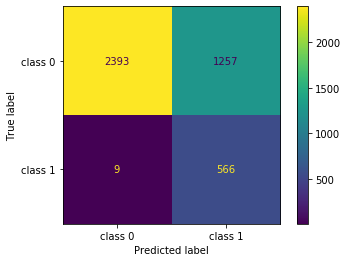

Can't produce feature importance for classifier logistic_regression
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.853


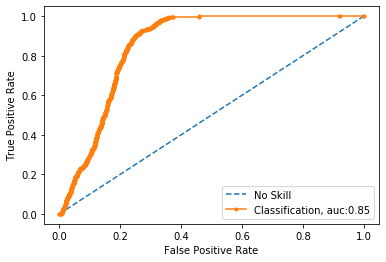


##################################################################################



################# cassification report for classifier random_forest ################

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3650
           1       0.55      0.51      0.53       575

    accuracy                           0.88      4225
   macro avg       0.74      0.72      0.73      4225
weighted avg       0.87      0.88      0.88      4225


 Confusion matrix (Wikipedia format):

[[3413  280]
 [ 237  295]]

 Confusion matrix (sklearn (transposed) format):



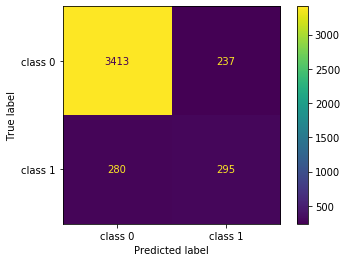

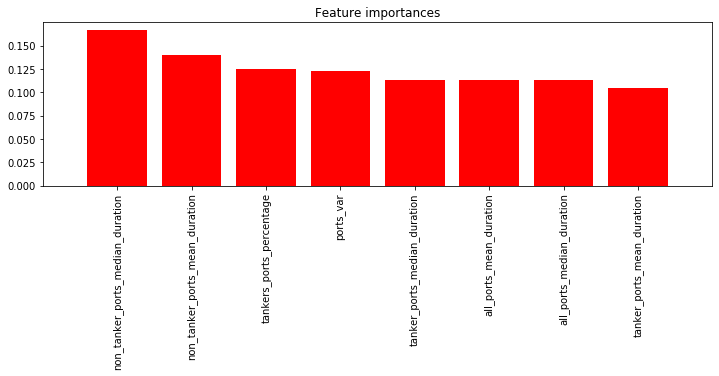

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.909


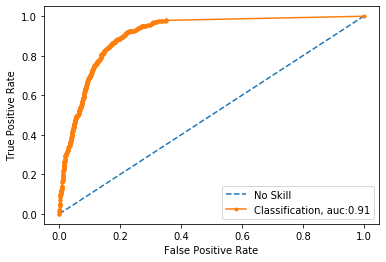


##################################################################################



################# cassification report for classifier xgboost ################

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3650
           1       0.57      0.52      0.54       575

    accuracy                           0.88      4225
   macro avg       0.75      0.73      0.74      4225
weighted avg       0.88      0.88      0.88      4225


 Confusion matrix (Wikipedia format):

[[3428  278]
 [ 222  297]]

 Confusion matrix (sklearn (transposed) format):



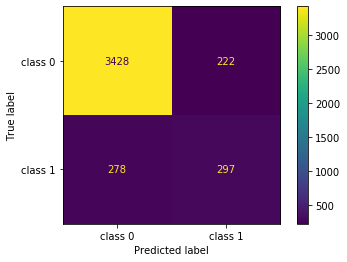

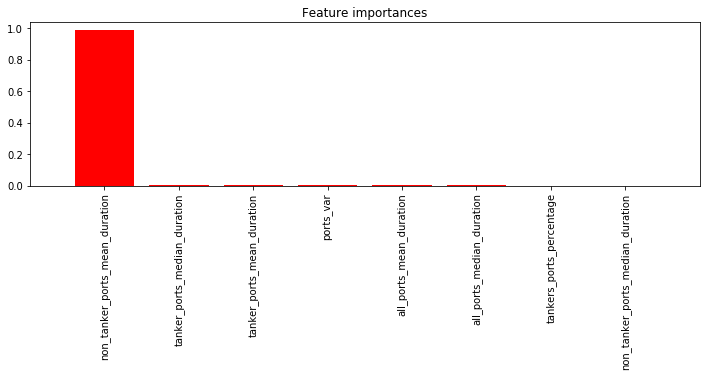

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.910


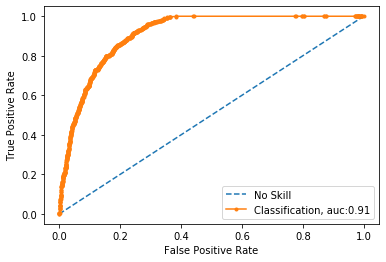


##################################################################################

The classifier with the maximal minimal f1 score is xgboost


In [92]:
#Summarize the performance of each of the tuned classifiers, and find the one with max-min F1 score.

f1_per_clf = {}
curr_figsize = plt.rcParams['figure.figsize']
for clfname in tuned_classifiers:
    print()
    print( "\n################# cassification report for classifier {} ################\n".format(clfname))
    clf = tuned_classifiers[clfname]
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print( classification_report(y_true, y_pred) )
    print("\n Confusion matrix (Wikipedia format):\n")
    print(confusion_matrix(y_true, y_pred, labels=[0,1]).T) 
    print("\n Confusion matrix (sklearn (transposed) format):\n")
    plot_confusion_matrix(clf, X_test_scaled, y_true, display_labels=['class 0', 'class 1'], values_format='.0f')
    plt.show()
    if hasattr(clf, 'feature_importances_'):
        plot_features_importances( clf.feature_importances_, X_train.columns)
    else:
        print("Can't produce feature importance for classifier {}".format(clfname))
    plot_roc_curve(clf, X_test_scaled, y_test)
    f1_per_clf[clfname] = f1_score(y_true, y_pred, average=None)[1]
    print("\n##################################################################################\n")
    
sorted_clfnames_by_scores = [k for k, v in sorted(f1_per_clf.items(), key=lambda item: item[1])]
best_classifier = tuned_classifiers[sorted_clfnames_by_scores[-1]]
print("The classifier with the maximal minimal f1 score is {}".format(sorted_clfnames_by_scores[-1]))

In [1]:
training_cleaned.csv

NameError: name 'tuned_classifiers' is not defined

### best results so far ###

Full features set:
Logistic: 0.732 (+/-0.038) for {'C': 0.3, 'class_weight': None, 'max_iter': 10000}
RF: 0.825 (+/-0.031) for {'class_weight': 'balanced', 'max_depth': 100, 'n_estimators': 500, 'n_jobs': -1}



Wrong f1 score:
Logistic: {'C': 1200, 'class_weight': 'balanced'}, 0.627
RF: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 200}, 0.761 
XGboost: {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 100}, 0.766 

correct f1 score, full features set
Logistic: {'C': 10, 'class_weight': 'balanced'}, 0.665
RF: {'class_weight': 'balanced', 'max_depth': 40, 'n_estimators': 500}, 0.758 

# Submission #

In [ ]:
X_test_for_submission,_,_  = extract_features(test_set_df, ts_handling_scheme='create_x')
scaler_submission = preprocessing.StandardScaler().fit(X)
X_scaled = scaler_submission.transform(X)
X_test_for_submission_scaled = scaler_submission.transform(X_test_for_submission)

In [ ]:
def predict_and_save_to_file(clf, clf_id):
    y_test_predicted = clf.predict(X_test_for_submission_scaled)
    res_df = pd.DataFrame( { 'label' : y_test_predicted, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
    res_df.to_csv(f"submission_{clf_id}.csv", index=False)


In [ ]:
# Now apply on provided test set.
for clf_id, clf in tuned_classifiers_for_submission.items():
    predict_and_save_to_file(clf, clf_id)

# Some experiments #

TODO:
    
    * IMPORTANT!! Remove duplicates!!!
   

In [16]:
import gmplot

# Create the map plotter:
apikey = '' # (your API key here)
gmap = gmplot.GoogleMapPlotter(37.766956, -122.448481, 14, apikey=apikey)

# Mark a hidden gem:
gmap.marker(37.770776, -122.461689, color='cornflowerblue')

# Highlight some attractions:
attractions_lats, attractions_lngs = zip(*[
    (37.769901, -122.498331),
    (37.768645, -122.475328),
    (37.771478, -122.468677),
    (37.769867, -122.466102),
    (37.767187, -122.467496),
    (37.770104, -122.470436)
])
gmap.scatter(attractions_lats, attractions_lngs, color='#3B0B39', size=40, marker=False)

# Outline the Golden Gate Park:
golden_gate_park = zip(*[
    (37.771269, -122.511015),
    (37.773495, -122.464830),
    (37.774797, -122.454538),
    (37.771988, -122.454018),
    (37.773646, -122.440979),
    (37.772742, -122.440797),
    (37.771096, -122.453889),
    (37.768669, -122.453518),
    (37.766227, -122.460213),
    (37.764028, -122.510347)
])
gmap.polygon(*golden_gate_park, color='cornflowerblue', edge_width=10)

# Draw the map to an HTML file:
gmap.draw('map.html')

In [194]:
import geopy.distance

coords_1 = (17.692, 83.28)
coords_2 = (16.978, 82.279)

print(geopy.distance.geodesic(coords_1, coords_2).km)

132.53385211071947


In [207]:
import gmplot

# Create the map plotter:
apikey = '' # (your API key here)
gmap = gmplot.GoogleMapPlotter(17.69, 83.28, 2, apikey=apikey)

test_grp = train_set_df_orig.groupby('ves_id').get_group('56dd02bde4b02341a159b0ab')
gmap.polygon(test_grp['Lat'].values, test_grp['Long'].values, color='cornflowerblue', edge_width=2)
gmap.draw('map_vss.html')

In [210]:
import gmaps
# gmaps.configure(api_key='AIza...')

fig = gmaps.figure(center=(51.5, 0.1), zoom_level=9)

# Features to draw on the map
gmt_meridian = gmaps.Line(
    start=(52.0, 0.0),
    end=(50.0, 0.0),
    stroke_weight=3.0
)
greenwich = gmaps.Marker((51.3, 0.0), info_box_content='Greenwich')

drawing = gmaps.drawing_layer(features=[greenwich, gmt_meridian])
fig.add_layer(drawing)
fig
plt.show()

In [45]:
# import gmplot package
import gmplot
#Set different latitude and longitude points
Charminar_top_attraction_lats, Charminar_top_attraction_lons = grp_56dd02bde4b02341a159b0ab_cleaned['Lat'].values, grp_56dd02bde4b02341a159b0ab_cleaned['Long'].values
# zip(*[
#    (17.3833, 78.4011),(17.4239, 78.4738),(17.3713, 78.4804),(17.3616, 78.4747),
#    (17.3578, 78.4717),(17.3604, 78.4736),(17.2543, 78.6808),(17.4062, 78.4691),
#    (17.3950, 78.3968),(17.3587, 78.2988),(17.4156, 78.4750)])
#declare the center of the map, and how much we want the map zoomed in
gmap3 = gmplot.GoogleMapPlotter(17.3616, 78.4747, 13)
# Scatter map
gmap3.scatter( Charminar_top_attraction_lats, Charminar_top_attraction_lons, '#FF0000',size = 50, marker = False )
# Plot method Draw a line in between given coordinates
gmap3.plot(Charminar_top_attraction_lats, Charminar_top_attraction_lons, 'cornflowerblue', edge_width = 3.0)
#Your Google_API_Key
# gmap.apikey = " API_Key”
# save it to html
gmap3.draw(r"scatter_56dd02bde4b02341a159b0ab_cleaned.html")

In [17]:
import os
os.system('map.html')

0

In [14]:
#Plot a vessel timeseries
def plot_vessel_timeline(vessel_id, extracted_features = None, plot_ax = None):
    if plot_ax is None:
        fig_p, ax_p = plt.subplots()
    else:
        ax_p = plot_ax
    
    curr_patient_df = train_orig_grouped.get_group(vessel_id)
    first_timestamp = curr_patient_df['timestamp'].iloc[0]
    curr_patient_df.index = list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, curr_patient_df['timestamp']))
    curr_patient_df[['measurement_x', 'measurement_y', 'measurement_z']].plot(ax=ax_p)
    if extracted_features is not None:
        coefs = extracted_features[:9].reshape(3,3).T
        x_regr = curr_patient_df.index.values
        x_mat = np.array([np.ones(len(x_regr)), x_regr, x_regr*x_regr ]).T
        curr_patient_df_approx = pd.DataFrame( x_mat.dot(coefs), 
                                              columns = ['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr'], 
                                                index = curr_patient_df.index
                                             )
        curr_patient_df_approx[['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr']].plot(ax=ax_p, style='--')
    ax_p.set_title(f"Patient {patient_id} timeseries")
    ax_p.set_xlabel("time from first timestamp (ms)")
    return len(curr_patient_df), ax_p


In [15]:
def extract_time_series

#Converts the 
def extract_features(in_df: pd.DataFrame) -> pd.DataFrame:
    #TODO: input sanity checks   
    X = []
    y = []
    iter_over = in_dfs.groupby('patient_id') if type(in_dfs) ==  pd.DataFrame else in_dfs
    for _,patient_df in iter_over:
        extracted_features = extract_single_patient_features( patient_df, extraction_scheme, ts_handling_scheme, add_avg_dists )
     
#         print(f"Appending features of shape {extracted_features.shape}")
        X.append(extracted_features )
#         print(np.array(X).shape)
#         if len(X) == 388:
#             set_trace()
        if 'label' in patient_df:
            y.append(patient_df['label'].iloc[0])
    features_names = ['meas_{}_a{}'.format(i,j) for i in ['x', 'y', 'z'] for j in range(3)]
    intersection_names = ['intersect_x_y_1', 'intersect_x_y_2', 'intersect_x_z_1', 'intersect_x_z_2',  'intersect_y_z_1', 'intersect_y_z_2']
    avg_dist_names = ['avg_dist_x_y', 'avg_dist_x_z', 'avg_dist_y_z']
    
    all_features_names = features_names + intersection_names
    if add_avg_dists:
        all_features_names += avg_dist_names
    
    return np.array(X), np.array(y),  all_features_names

SyntaxError: invalid syntax (<ipython-input-15-eaa33083f872>, line 1)

In [22]:
df = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6]})

In [29]:
tmp = df['b'].apply(lambda x :x in set([4,6,7]))

In [30]:
tmp

0    False
1     True
2    False
Name: b, dtype: bool

In [439]:
df.drop([1])

,a,b
0,1,4
2,3,6


In [227]:
l = []
for ind,r in df.iterrows():
    l.append(r)

In [228]:
l

[a    1
 b    4
 Name: 0, dtype: int64,
 a    2
 b    5
 Name: 1, dtype: int64,
 a    3
 b    6
 Name: 2, dtype: int64]

In [229]:
pd.DataFrame(l)

,a,b
0,1,4
1,2,5
2,3,6


In [375]:
df1 = pd.DataFrame({'a':[1], 'b':[2]})
df2 = pd.DataFrame({'a':[3], 'b':[4]})
pd.concat([df1, df2])

,a,b
0,1,2
0,3,4


In [6]:
import geopandas
from shapely.geometry import Point
s = geopandas.GeoSeries([Point(1, 1), Point(2, 2), Point(3, 3)])
s.centroid

0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
2    POINT (3.00000 3.00000)
dtype: geometry

In [57]:
from shapely.geometry import Polygon

p = MultiPoint([(1, 1), (0,0), (2,3)])
print( p.representative_point())


POINT (1 1)


In [18]:
p.points

AttributeError: 'Polygon' object has no attribute 'points'

In [21]:
X_temp_train,_,_,_ = train_test_split(train_df_to_work_with, train_df_to_work_with['label'], test_size = 0.2)
tankers_ports_set = set(X_temp_train['port_id'][X_temp_train['label']==1])
print("There are {} ports visited by tankers, which are\
 {:0.2f}% of the overall ports".format(len(tankers_ports_set), len(tankers_ports_set)/num_unique_ports_in_train*100))

There are 1585 ports visited by tankers, which are 44.15% of the overall ports
